In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn import svm


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [30]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [34]:
p = Pipeline.objects.all()[64]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: dummy frog ugs opt
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog
Classifier: Random Forest
Task status: Status.SUCCESS


In [35]:
len(p.data_source.articles)

3099

In [37]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [38]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fcac8764a90>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fcb6b1573d0>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fcaed95f7d0>), ('Sentiment', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuot...64b90>), ('Frog', <newsgac.nlp_tools.models.frog.FrogFeatureExtractor object at 0x7fcaed95f590>)]))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [39]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [40]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [41]:
X_train = X
y_train = labels
y_test = labels_test

In [42]:
y_test.shape

(344,)

In [43]:
kernel_list = ['linear', 'rbf', 'poly', 'sigmoid']
# kernel_list = ['linear']
class_weights = [None, 'balanced']

In [44]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'kernel': hp.choice('kernel', kernel_list),
        'class_weight': hp.choice('class_weight', class_weights),
        'C': hp.uniform('C', 0, 20),
        'gamma': hp.uniform('gamma',0.001,10)
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [45]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    c = params['C']
    gamma = params['gamma']
    kernel = params['kernel']
    class_weight = params['class_weight']
    
    model = svm.SVC(kernel=kernel,
            C=c,
            random_state=42,
            decision_function_shape='ovr',
            # class_weight=self.class_weight,
            class_weight=class_weight,
            probability=True,
            gamma=gamma)
    
    model.fit(X_train, y_train)
    labels_prediction = model.predict(X_test)
    labels_probs = model.predict_proba(X_test)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, labels_prediction)
    test_loss = log_loss(y_test, labels_probs)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [46]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['kernel'] = kernel_list[best_param['kernel']]
best_param['class_weight'] = class_weights[best_param['class_weight']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.476928041304 and loss 1.1978657031 :

  0%|          | 0/1000 [00:04<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.447674418605 and loss 1.30558164237 :

  0%|          | 0/1000 [00:04<?, ?it/s, best loss: ?]
{'kernel': 'linear', 'C': 0.3641162174645185, 'gamma': 0.49723964731838016, 'class_weight': 'balanced'}

  0%|          | 0/1000 [00:04<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:04<1:11:06,  4.27s/it]


  0%|          | 1/1000 [00:04<1:10:56,  4.26s/it, best loss: -0.447674418605]
Parameters with this training accuracy 0.99031945789 and loss 0.314239608533 :

  0%|          | 1/1000 [00:18<1:10:56,  4.26s/it, best loss: -0.447674418605]
Parameters with this testing accuracy 0.517441860465 and loss 1.52252550215 :

  0%|          | 1/1000 [00:18<1:10:56,  4.26s/it, best loss: -0.447674418605]
{'kernel': 'rbf', 'C': 10.88380913025649, 'gamma': 0.5615038651809909, 'class_weight': 'balanced'}

  0%|          | 1/1000 [00:18<1:10:56,  4.26s/it, best loss: -0.447674418605]

Hyperopt:   0%|          | 2/1000 [00:18<1:58:38,  7.13s/it]


  0%|          | 2/1000 [00:18<1:58:31,  7.13s/it, best loss: -0.517441860465]
Parameters with this training accuracy 0.406582768635 and loss 1.93570466562 :

  0%|          | 2/1000 [00:20<1:58:31,  7.13s/it, best loss: -0.517441860465]
Parameters with this testing accuracy 0.453488372093 and loss 1.92217678253 :

  0%|          | 2/1000 [00:20<1:58:31,  7.13s/it, best loss: -0.517441860465]
{'kernel': 'sigmoid', 'C': 12.103492384773034, 'gamma': 3.1456877087275403, 'class_weight': None}

  0%|          | 2/1000 [00:20<1:58:31,  7.13s/it, best loss: -0.517441860465]

Hyperopt:   0%|          | 3/1000 [00:20<1:37:10,  5.85s/it]


  0%|          | 3/1000 [00:20<1:37:05,  5.84s/it, best loss: -0.517441860465]
Parameters with this training accuracy 0.62633107454 and loss 1.22091405067 :

  0%|          | 3/1000 [01:14<1:37:05,  5.84s/it, best loss: -0.517441860465]
Parameters with this testing accuracy 0.595930232558 and loss 1.32177003472 :

  0%|          | 3/1000 [01:14<1:37:05,  5.84s/it, best loss: -0.517441860465]
{'kernel': 'linear', 'C': 13.30246169688137, 'gamma': 8.981529820010456, 'class_weight': None}

  0%|          | 3/1000 [01:14<1:37:05,  5.84s/it, best loss: -0.517441860465]

Hyperopt:   0%|          | 4/1000 [01:14<5:34:15, 20.14s/it]


  0%|          | 4/1000 [01:14<5:34:12, 20.13s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22233850242 :

  0%|          | 4/1000 [02:05<5:34:12, 20.13s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32394623269 :

  0%|          | 4/1000 [02:05<5:34:12, 20.13s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.179710112127193, 'gamma': 9.215829698582406, 'class_weight': None}

  0%|          | 4/1000 [02:05<5:34:12, 20.13s/it, best loss: -0.595930232558]

Hyperopt:   0%|          | 5/1000 [02:05<8:10:16, 29.56s/it]


  0%|          | 5/1000 [02:05<8:10:13, 29.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.48568481796 :

  0%|          | 5/1000 [02:25<8:10:13, 29.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95156742637 :

  0%|          | 5/1000 [02:25<8:10:13, 29.56s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 3.2886892675352275, 'gamma': 7.058063628116285, 'class_weight': None}

  0%|          | 5/1000 [02:25<8:10:13, 29.56s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 6/1000 [02:25<7:18:48, 26.49s/it]


  1%|          | 6/1000 [02:25<7:18:46, 26.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22072072612 :

  1%|          | 6/1000 [03:05<7:18:46, 26.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3219663499 :

  1%|          | 6/1000 [03:05<7:18:46, 26.49s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.626139817342743, 'gamma': 6.225159865603142, 'class_weight': None}

  1%|          | 6/1000 [03:05<7:18:46, 26.49s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 7/1000 [03:05<8:25:12, 30.53s/it]


  1%|          | 7/1000 [03:05<8:25:10, 30.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.516618263956 and loss 1.20772075723 :

  1%|          | 7/1000 [03:24<8:25:10, 30.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30163189197 :

  1%|          | 7/1000 [03:24<8:25:10, 30.52s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 9.979002316785511, 'gamma': 6.254960207015558, 'class_weight': 'balanced'}

  1%|          | 7/1000 [03:24<8:25:10, 30.52s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 8/1000 [03:24<7:28:02, 27.10s/it]


  1%|          | 8/1000 [03:24<7:28:01, 27.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93803347066 :

  1%|          | 8/1000 [03:26<7:28:01, 27.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92145410903 :

  1%|          | 8/1000 [03:26<7:28:01, 27.10s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 3.9157596479515444, 'gamma': 7.822154840272506, 'class_weight': None}

  1%|          | 8/1000 [03:26<7:28:01, 27.10s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 9/1000 [03:26<5:24:43, 19.66s/it]


  1%|          | 9/1000 [03:26<5:24:43, 19.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.18140882218 :

  1%|          | 9/1000 [03:43<5:24:43, 19.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.94805536822 :

  1%|          | 9/1000 [03:43<5:24:43, 19.66s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 12.110797004312218, 'gamma': 4.515355689317835, 'class_weight': 'balanced'}

  1%|          | 9/1000 [03:43<5:24:43, 19.66s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 10/1000 [03:43<5:08:36, 18.70s/it]


  1%|          | 10/1000 [03:43<5:08:36, 18.70s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.51954619882 :

  1%|          | 10/1000 [03:59<5:08:36, 18.70s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.91844807853 :

  1%|          | 10/1000 [03:59<5:08:36, 18.70s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 9.781564492536665, 'gamma': 3.1876574065725567, 'class_weight': 'balanced'}

  1%|          | 10/1000 [03:59<5:08:36, 18.70s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 11/1000 [03:59<4:57:11, 18.03s/it]


  1%|          | 11/1000 [03:59<4:57:11, 18.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.515004840271 and loss 1.20607926349 :

  1%|          | 11/1000 [04:14<4:57:11, 18.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.473837209302 and loss 1.30087164548 :

  1%|          | 11/1000 [04:14<4:57:11, 18.03s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.467515511407989, 'gamma': 6.299508596990953, 'class_weight': 'balanced'}

  1%|          | 11/1000 [04:14<4:57:11, 18.03s/it, best loss: -0.595930232558]

Hyperopt:   1%|          | 12/1000 [04:14<4:41:49, 17.11s/it]


  1%|          | 12/1000 [04:14<4:41:48, 17.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.988060664731 and loss 1.42526307465 :

  1%|          | 12/1000 [07:24<4:41:48, 17.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.508720930233 and loss 1.55567956453 :

  1%|          | 12/1000 [07:24<4:41:48, 17.11s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 11.537362035536516, 'gamma': 0.7312825544345894, 'class_weight': 'balanced'}

  1%|          | 12/1000 [07:24<4:41:48, 17.11s/it, best loss: -0.595930232558]

Hyperopt:   1%|▏         | 13/1000 [07:24<18:52:57, 68.87s/it]


  1%|▏         | 13/1000 [07:24<18:52:57, 68.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.44952593991 :

  1%|▏         | 13/1000 [07:37<18:52:57, 68.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95063288008 :

  1%|▏         | 13/1000 [07:37<18:52:57, 68.87s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 9.418481513271203, 'gamma': 6.776731857982286, 'class_weight': None}

  1%|▏         | 13/1000 [07:37<18:52:57, 68.87s/it, best loss: -0.595930232558]

Hyperopt:   1%|▏         | 14/1000 [07:37<14:19:05, 52.28s/it]


  1%|▏         | 14/1000 [07:37<14:19:05, 52.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.51726363343 and loss 1.2083864983 :

  1%|▏         | 14/1000 [07:52<14:19:05, 52.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.473837209302 and loss 1.30200336087 :

  1%|▏         | 14/1000 [07:52<14:19:05, 52.28s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.339363582373608, 'gamma': 0.6167390211456099, 'class_weight': 'balanced'}

  1%|▏         | 14/1000 [07:52<14:19:05, 52.28s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 15/1000 [07:52<11:15:15, 41.13s/it]


  2%|▏         | 15/1000 [07:52<11:15:15, 41.13s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.41673051194 :

  2%|▏         | 15/1000 [13:16<11:15:15, 41.13s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55636376862 :

  2%|▏         | 15/1000 [13:16<11:15:15, 41.13s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 3.9499150015184226, 'gamma': 7.398449422441661, 'class_weight': None}

  2%|▏         | 15/1000 [13:16<11:15:15, 41.13s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 16/1000 [13:16<34:25:00, 125.92s/it]


  2%|▏         | 16/1000 [13:16<34:25:00, 125.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93497310668 :

  2%|▏         | 16/1000 [13:19<34:25:00, 125.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92061960852 :

  2%|▏         | 16/1000 [13:19<34:25:00, 125.92s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 6.901463341038541, 'gamma': 6.05676916891715, 'class_weight': None}

  2%|▏         | 16/1000 [13:19<34:25:00, 125.92s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 17/1000 [13:19<24:16:10, 88.88s/it] 


  2%|▏         | 17/1000 [13:19<24:16:10, 88.88s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.41870066787 :

  2%|▏         | 17/1000 [18:46<24:16:10, 88.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55780023607 :

  2%|▏         | 17/1000 [18:46<24:16:10, 88.88s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 7.558820581321486, 'gamma': 6.979132719737585, 'class_weight': None}

  2%|▏         | 17/1000 [18:46<24:16:10, 88.88s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 18/1000 [18:46<43:44:33, 160.36s/it]


  2%|▏         | 18/1000 [18:46<43:44:33, 160.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.89701454793 :

  2%|▏         | 18/1000 [18:59<43:44:33, 160.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.93878943601 :

  2%|▏         | 18/1000 [18:59<43:44:33, 160.36s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 6.301550914793865, 'gamma': 3.8250895220514716, 'class_weight': None}

  2%|▏         | 18/1000 [18:59<43:44:33, 160.36s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 19/1000 [18:59<31:42:18, 116.35s/it]


  2%|▏         | 19/1000 [18:59<31:42:18, 116.35s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.518877057115 and loss 1.20883679966 :

  2%|▏         | 19/1000 [19:20<31:42:18, 116.35s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30207701642 :

  2%|▏         | 19/1000 [19:20<31:42:18, 116.35s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.278068464464717, 'gamma': 5.329786037134851, 'class_weight': 'balanced'}

  2%|▏         | 19/1000 [19:20<31:42:18, 116.35s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 20/1000 [19:20<23:50:02, 87.55s/it] 


  2%|▏         | 20/1000 [19:20<23:50:02, 87.55s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22113023307 :

  2%|▏         | 20/1000 [20:15<23:50:02, 87.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.3221382196 :

  2%|▏         | 20/1000 [20:15<23:50:02, 87.55s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.07216613228077, 'gamma': 9.354762687750284, 'class_weight': None}

  2%|▏         | 20/1000 [20:15<23:50:02, 87.55s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 21/1000 [20:15<21:08:22, 77.73s/it]


  2%|▏         | 21/1000 [20:15<21:08:22, 77.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.2212731137 :

  2%|▏         | 21/1000 [21:09<21:08:22, 77.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32282815253 :

  2%|▏         | 21/1000 [21:09<21:08:22, 77.73s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.142527188840926, 'gamma': 9.979800842263538, 'class_weight': None}

  2%|▏         | 21/1000 [21:09<21:08:22, 77.73s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 22/1000 [21:09<19:12:50, 70.73s/it]


  2%|▏         | 22/1000 [21:09<19:12:50, 70.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.628267182962 and loss 1.21962533819 :

  2%|▏         | 22/1000 [22:27<19:12:50, 70.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32224632471 :

  2%|▏         | 22/1000 [22:27<19:12:50, 70.73s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.98580543999157, 'gamma': 8.443233333968722, 'class_weight': None}

  2%|▏         | 22/1000 [22:27<19:12:50, 70.73s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 23/1000 [22:27<19:47:52, 72.95s/it]


  2%|▏         | 23/1000 [22:27<19:47:52, 72.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22146194679 :

  2%|▏         | 23/1000 [23:21<19:47:52, 72.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32296169016 :

  2%|▏         | 23/1000 [23:21<19:47:52, 72.95s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.100587665124236, 'gamma': 9.969162729144177, 'class_weight': None}

  2%|▏         | 23/1000 [23:21<19:47:52, 72.95s/it, best loss: -0.595930232558]

Hyperopt:   2%|▏         | 24/1000 [23:21<18:14:49, 67.30s/it]


  2%|▏         | 24/1000 [23:21<18:14:49, 67.30s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22078844596 :

  2%|▏         | 24/1000 [24:35<18:14:49, 67.30s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32174654361 :

  2%|▏         | 24/1000 [24:35<18:14:49, 67.30s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.73021912746969, 'gamma': 9.636315926085624, 'class_weight': None}

  2%|▏         | 24/1000 [24:35<18:14:49, 67.30s/it, best loss: -0.595930232558]

Hyperopt:   2%|▎         | 25/1000 [24:35<18:43:02, 69.11s/it]


  2%|▎         | 25/1000 [24:35<18:43:02, 69.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42098282396 :

  2%|▎         | 25/1000 [29:48<18:43:02, 69.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55938794011 :

  2%|▎         | 25/1000 [29:48<18:43:02, 69.11s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 14.080758699698222, 'gamma': 8.702612007444586, 'class_weight': None}

  2%|▎         | 25/1000 [29:48<18:43:02, 69.11s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 26/1000 [29:48<38:33:13, 142.50s/it]


  3%|▎         | 26/1000 [29:48<38:33:13, 142.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93862534176 :

  3%|▎         | 26/1000 [29:51<38:33:13, 142.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92169582868 :

  3%|▎         | 26/1000 [29:51<38:33:13, 142.50s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 15.154670818085851, 'gamma': 8.416930277239901, 'class_weight': None}

  3%|▎         | 26/1000 [29:51<38:33:13, 142.50s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 27/1000 [29:51<27:10:14, 100.53s/it]


  3%|▎         | 27/1000 [29:51<27:10:14, 100.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22095543096 :

  3%|▎         | 27/1000 [30:55<27:10:14, 100.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32169528164 :

  3%|▎         | 27/1000 [30:55<27:10:14, 100.53s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.026428887776202, 'gamma': 8.978067503095632, 'class_weight': None}

  3%|▎         | 27/1000 [30:55<27:10:14, 100.53s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 28/1000 [30:55<24:12:31, 89.66s/it] 


  3%|▎         | 28/1000 [30:55<24:12:31, 89.66s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626976444014 and loss 1.22104360533 :

  3%|▎         | 28/1000 [32:02<24:12:31, 89.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32296171027 :

  3%|▎         | 28/1000 [32:02<24:12:31, 89.66s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.93227733714152, 'gamma': 1.7108405355654122, 'class_weight': None}

  3%|▎         | 28/1000 [32:02<24:12:31, 89.66s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 29/1000 [32:02<22:19:35, 82.78s/it]


  3%|▎         | 29/1000 [32:02<22:19:35, 82.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22143614203 :

  3%|▎         | 29/1000 [32:53<22:19:35, 82.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32282727853 :

  3%|▎         | 29/1000 [32:53<22:19:35, 82.78s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.706854500906614, 'gamma': 9.801169303078819, 'class_weight': None}

  3%|▎         | 29/1000 [32:53<22:19:35, 82.78s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 30/1000 [32:53<19:44:53, 73.29s/it]


  3%|▎         | 30/1000 [32:53<19:44:53, 73.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.22052148874 :

  3%|▎         | 30/1000 [34:07<19:44:53, 73.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32209606408 :

  3%|▎         | 30/1000 [34:07<19:44:53, 73.29s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.93614166296944, 'gamma': 8.054183883807545, 'class_weight': None}

  3%|▎         | 30/1000 [34:07<19:44:53, 73.29s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 31/1000 [34:07<19:46:14, 73.45s/it]


  3%|▎         | 31/1000 [34:07<19:46:14, 73.45s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93653107445 :

  3%|▎         | 31/1000 [34:10<19:46:14, 73.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92424648313 :

  3%|▎         | 31/1000 [34:10<19:46:14, 73.45s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 12.988648650157655, 'gamma': 7.872488658042265, 'class_weight': None}

  3%|▎         | 31/1000 [34:10<19:46:14, 73.45s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 32/1000 [34:10<14:02:23, 52.21s/it]


  3%|▎         | 32/1000 [34:10<14:02:23, 52.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22076557281 :

  3%|▎         | 32/1000 [35:06<14:02:23, 52.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32195555952 :

  3%|▎         | 32/1000 [35:06<14:02:23, 52.21s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.347014716936496, 'gamma': 1.7122623240744308, 'class_weight': None}

  3%|▎         | 32/1000 [35:06<14:02:23, 52.21s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 33/1000 [35:06<14:22:37, 53.52s/it]


  3%|▎         | 33/1000 [35:06<14:22:37, 53.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.41955074431 :

  3%|▎         | 33/1000 [40:19<14:22:37, 53.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55853857621 :

  3%|▎         | 33/1000 [40:19<14:22:37, 53.52s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 16.47986408604262, 'gamma': 1.8413257897998627, 'class_weight': None}

  3%|▎         | 33/1000 [40:19<14:22:37, 53.52s/it, best loss: -0.595930232558]

Hyperopt:   3%|▎         | 34/1000 [40:19<35:15:32, 131.40s/it]


  3%|▎         | 34/1000 [40:19<35:15:32, 131.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.2207190549 :

  3%|▎         | 34/1000 [41:04<35:15:32, 131.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32143260464 :

  3%|▎         | 34/1000 [41:04<35:15:32, 131.40s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.063988752209346, 'gamma': 9.98571553604981, 'class_weight': None}

  3%|▎         | 34/1000 [41:04<35:15:32, 131.40s/it, best loss: -0.595930232558]

Hyperopt:   4%|▎         | 35/1000 [41:04<28:16:28, 105.48s/it]


  4%|▎         | 35/1000 [41:04<28:16:28, 105.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22102646115 :

  4%|▎         | 35/1000 [41:53<28:16:28, 105.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.3219782778 :

  4%|▎         | 35/1000 [41:53<28:16:28, 105.48s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.194794170646674, 'gamma': 2.0030928541073942, 'class_weight': None}

  4%|▎         | 35/1000 [41:53<28:16:28, 105.48s/it, best loss: -0.595930232558]

Hyperopt:   4%|▎         | 36/1000 [41:53<23:42:00, 88.51s/it] 


  4%|▎         | 36/1000 [41:53<23:42:00, 88.51s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.401097128106 and loss 1.939799681 :

  4%|▎         | 36/1000 [41:56<23:42:00, 88.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.450581395349 and loss 1.92430804736 :

  4%|▎         | 36/1000 [41:56<23:42:00, 88.51s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 17.485469372061, 'gamma': 2.203338015258566, 'class_weight': None}

  4%|▎         | 36/1000 [41:56<23:42:00, 88.51s/it, best loss: -0.595930232558]

Hyperopt:   4%|▎         | 37/1000 [41:56<16:46:35, 62.72s/it]


  4%|▎         | 37/1000 [41:56<16:46:35, 62.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.497902549209 and loss 1.19521069622 :

  4%|▎         | 37/1000 [42:02<16:46:35, 62.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.44476744186 and loss 1.29754951201 :

  4%|▎         | 37/1000 [42:02<16:46:35, 62.72s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 1.4590995189487685, 'gamma': 0.20753498325004416, 'class_weight': 'balanced'}

  4%|▎         | 37/1000 [42:02<16:46:35, 62.72s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 38/1000 [42:02<12:12:08, 45.66s/it]


  4%|▍         | 38/1000 [42:02<12:12:08, 45.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.23447092861 :

  4%|▍         | 38/1000 [42:19<12:12:08, 45.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.94898396936 :

  4%|▍         | 38/1000 [42:19<12:12:08, 45.66s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 14.362158651865018, 'gamma': 4.681278085919475, 'class_weight': None}

  4%|▍         | 38/1000 [42:19<12:12:08, 45.66s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 39/1000 [42:19<9:57:11, 37.29s/it] 


  4%|▍         | 39/1000 [42:19<9:57:11, 37.29s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.627621813488 and loss 1.22056376902 :

  4%|▍         | 39/1000 [43:36<9:57:11, 37.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32162370353 :

  4%|▍         | 39/1000 [43:36<9:57:11, 37.29s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.738354431869848, 'gamma': 3.481160963395113, 'class_weight': None}

  4%|▍         | 39/1000 [43:36<9:57:11, 37.29s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 40/1000 [43:36<13:06:17, 49.14s/it]


  4%|▍         | 40/1000 [43:36<13:06:17, 49.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.105517909003 and loss 1.94900148763 :

  4%|▍         | 40/1000 [43:44<13:06:17, 49.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.110465116279 and loss 1.93300270844 :

  4%|▍         | 40/1000 [43:44<13:06:17, 49.14s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 15.664247537996166, 'gamma': 5.489159916816104, 'class_weight': 'balanced'}

  4%|▍         | 40/1000 [43:44<13:06:17, 49.14s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 41/1000 [43:44<9:49:43, 36.90s/it] 


  4%|▍         | 41/1000 [43:44<9:49:43, 36.90s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.62633107454 and loss 1.21981650796 :

  4%|▍         | 41/1000 [44:29<9:49:43, 36.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32343513837 :

  4%|▍         | 41/1000 [44:29<9:49:43, 36.90s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.011544395623591, 'gamma': 9.288493133558282, 'class_weight': None}

  4%|▍         | 41/1000 [44:29<9:49:43, 36.90s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 42/1000 [44:29<10:28:06, 39.34s/it]


  4%|▍         | 42/1000 [44:29<10:28:06, 39.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.16931286029 :

  4%|▍         | 42/1000 [44:46<10:28:06, 39.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.89977463514 :

  4%|▍         | 42/1000 [44:46<10:28:06, 39.34s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 19.07338301244996, 'gamma': 2.7248456409292756, 'class_weight': 'balanced'}

  4%|▍         | 42/1000 [44:46<10:28:06, 39.34s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 43/1000 [44:46<8:38:12, 32.49s/it] 


  4%|▍         | 43/1000 [44:46<8:38:12, 32.49s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.42097507873 :

  4%|▍         | 43/1000 [49:55<8:38:12, 32.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55923822073 :

  4%|▍         | 43/1000 [49:55<8:38:12, 32.49s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 10.859474118257822, 'gamma': 7.4328928247025265, 'class_weight': None}

  4%|▍         | 43/1000 [49:55<8:38:12, 32.49s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 44/1000 [49:55<30:37:50, 115.35s/it]


  4%|▍         | 44/1000 [49:55<30:37:50, 115.35s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22085795872 :

  4%|▍         | 44/1000 [50:57<30:37:50, 115.35s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32188545792 :

  4%|▍         | 44/1000 [50:57<30:37:50, 115.35s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.000219380356874, 'gamma': 4.017584089545977, 'class_weight': None}

  4%|▍         | 44/1000 [50:57<30:37:50, 115.35s/it, best loss: -0.595930232558]

Hyperopt:   4%|▍         | 45/1000 [50:57<26:23:48, 99.51s/it] 


  4%|▍         | 45/1000 [50:57<26:23:48, 99.51s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.516295579219 and loss 1.20648011072 :

  4%|▍         | 45/1000 [51:14<26:23:48, 99.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30112871175 :

  4%|▍         | 45/1000 [51:14<26:23:48, 99.51s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.948479983194652, 'gamma': 1.1368507404766302, 'class_weight': 'balanced'}

  4%|▍         | 45/1000 [51:14<26:23:48, 99.51s/it, best loss: -0.595930232558]

Hyperopt:   5%|▍         | 46/1000 [51:14<19:49:26, 74.81s/it]


  5%|▍         | 46/1000 [51:14<19:49:26, 74.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.89564183258 :

  5%|▍         | 46/1000 [51:33<19:49:26, 74.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.93809454832 :

  5%|▍         | 46/1000 [51:33<19:49:26, 74.81s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 17.263710339009435, 'gamma': 3.788328796269491, 'class_weight': None}

  5%|▍         | 46/1000 [51:33<19:49:26, 74.81s/it, best loss: -0.595930232558]

Hyperopt:   5%|▍         | 47/1000 [51:33<15:18:45, 57.84s/it]


  5%|▍         | 47/1000 [51:33<15:18:45, 57.84s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.42352189035 :

  5%|▍         | 47/1000 [56:35<15:18:45, 57.84s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.56160742311 :

  5%|▍         | 47/1000 [56:35<15:18:45, 57.84s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 11.995136920650037, 'gamma': 2.652557011150666, 'class_weight': None}

  5%|▍         | 47/1000 [56:35<15:18:45, 57.84s/it, best loss: -0.595930232558]

Hyperopt:   5%|▍         | 48/1000 [56:35<34:41:12, 131.17s/it]


  5%|▍         | 48/1000 [56:35<34:41:11, 131.17s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.0154888673766 and loss 1.95798270097 :

  5%|▍         | 48/1000 [56:44<34:41:11, 131.17s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.0261627906977 and loss 1.94481583159 :

  5%|▍         | 48/1000 [56:44<34:41:11, 131.17s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.97459334812296, 'gamma': 9.629388360741173, 'class_weight': 'balanced'}

  5%|▍         | 48/1000 [56:44<34:41:11, 131.17s/it, best loss: -0.595930232558]

Hyperopt:   5%|▍         | 49/1000 [56:44<24:57:05, 94.45s/it] 


  5%|▍         | 49/1000 [56:44<24:57:05, 94.45s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.622136172959 and loss 1.22059446641 :

  5%|▍         | 49/1000 [57:03<24:57:05, 94.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32114594094 :

  5%|▍         | 49/1000 [57:03<24:57:05, 94.45s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 5.47167286097922, 'gamma': 4.311009499859188, 'class_weight': None}

  5%|▍         | 49/1000 [57:03<24:57:05, 94.45s/it, best loss: -0.595930232558]

Hyperopt:   5%|▌         | 50/1000 [57:03<18:58:28, 71.90s/it]


  5%|▌         | 50/1000 [57:03<18:58:28, 71.90s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.39900740164 :

  5%|▌         | 50/1000 [57:17<18:58:28, 71.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95029039161 :

  5%|▌         | 50/1000 [57:17<18:58:28, 71.90s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 10.663575829668517, 'gamma': 5.727141402653332, 'class_weight': None}

  5%|▌         | 50/1000 [57:17<18:58:28, 71.90s/it, best loss: -0.595930232558]

Hyperopt:   5%|▌         | 51/1000 [57:17<14:20:49, 54.42s/it]


  5%|▌         | 51/1000 [57:17<14:20:48, 54.42s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.490158115521 and loss 1.19521404373 :

  5%|▌         | 51/1000 [57:21<14:20:48, 54.42s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.453488372093 and loss 1.29901169444 :

  5%|▌         | 51/1000 [57:21<14:20:48, 54.42s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 0.9079333823407669, 'gamma': 6.5881713675676945, 'class_weight': 'balanced'}

  5%|▌         | 51/1000 [57:21<14:20:48, 54.42s/it, best loss: -0.595930232558]

Hyperopt:   5%|▌         | 52/1000 [57:21<10:22:01, 39.37s/it]


  5%|▌         | 52/1000 [57:21<10:22:01, 39.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.22114721197 :

  5%|▌         | 52/1000 [57:44<10:22:01, 39.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32135428139 :

  5%|▌         | 52/1000 [57:44<10:22:01, 39.37s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 7.862751203016446, 'gamma': 4.973256771987328, 'class_weight': None}

  5%|▌         | 52/1000 [57:44<10:22:01, 39.37s/it, best loss: -0.595930232558]

Hyperopt:   5%|▌         | 53/1000 [57:44<9:05:44, 34.58s/it] 


  5%|▌         | 53/1000 [57:44<9:05:44, 34.58s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996127783156 and loss 1.42082571153 :

  5%|▌         | 53/1000 [1:02:47<9:05:44, 34.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55933578789 :

  5%|▌         | 53/1000 [1:02:47<9:05:44, 34.58s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 16.139514316958977, 'gamma': 1.3538802968764645, 'class_weight': None}

  5%|▌         | 53/1000 [1:02:47<9:05:44, 34.58s/it, best loss: -0.595930232558]

Hyperopt:   5%|▌         | 54/1000 [1:02:47<30:14:41, 115.10s/it]


  5%|▌         | 54/1000 [1:02:47<30:14:41, 115.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22147799852 :

  5%|▌         | 54/1000 [1:03:27<30:14:41, 115.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3224204494 :

  5%|▌         | 54/1000 [1:03:27<30:14:41, 115.10s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.45356393727677, 'gamma': 9.291956457344401, 'class_weight': None}

  5%|▌         | 54/1000 [1:03:27<30:14:41, 115.10s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 55/1000 [1:03:27<24:17:14, 92.52s/it] 


  6%|▌         | 55/1000 [1:03:27<24:17:14, 92.52s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.0138754436915 and loss 1.94896528806 :

  6%|▌         | 55/1000 [1:03:35<24:17:14, 92.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.0203488372093 and loss 1.9381219509 :

  6%|▌         | 55/1000 [1:03:35<24:17:14, 92.52s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 9.947092395615122, 'gamma': 7.287864989743021, 'class_weight': 'balanced'}

  6%|▌         | 55/1000 [1:03:35<24:17:14, 92.52s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 56/1000 [1:03:35<17:38:08, 67.25s/it]


  6%|▌         | 56/1000 [1:03:35<17:38:08, 67.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.5298064866 :

  6%|▌         | 56/1000 [1:03:53<17:38:08, 67.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95225086938 :

  6%|▌         | 56/1000 [1:03:53<17:38:08, 67.25s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 13.616101331531969, 'gamma': 8.291690289339732, 'class_weight': None}

  6%|▌         | 56/1000 [1:03:53<17:38:08, 67.25s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 57/1000 [1:03:53<13:44:08, 52.44s/it]


  6%|▌         | 57/1000 [1:03:53<13:44:08, 52.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.619232010326 and loss 1.2207619561 :

  6%|▌         | 57/1000 [1:04:10<13:44:08, 52.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32254837009 :

  6%|▌         | 57/1000 [1:04:10<13:44:08, 52.44s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 4.132922840140784, 'gamma': 4.218315054000331, 'class_weight': None}

  6%|▌         | 57/1000 [1:04:10<13:44:08, 52.44s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 58/1000 [1:04:10<10:56:18, 41.80s/it]


  6%|▌         | 58/1000 [1:04:10<10:56:18, 41.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22100237308 :

  6%|▌         | 58/1000 [1:04:43<10:56:18, 41.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32195082665 :

  6%|▌         | 58/1000 [1:04:43<10:56:18, 41.80s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.549213429839359, 'gamma': 0.16143908829386788, 'class_weight': None}

  6%|▌         | 58/1000 [1:04:43<10:56:18, 41.80s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 59/1000 [1:04:43<10:15:01, 39.21s/it]


  6%|▌         | 59/1000 [1:04:43<10:15:01, 39.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42151475661 :

  6%|▌         | 59/1000 [1:09:30<10:15:01, 39.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.55906094443 :

  6%|▌         | 59/1000 [1:09:30<10:15:01, 39.21s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 9.172609574148112, 'gamma': 8.930484154348484, 'class_weight': 'balanced'}

  6%|▌         | 59/1000 [1:09:30<10:15:01, 39.21s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 60/1000 [1:09:31<29:39:35, 113.59s/it]


  6%|▌         | 60/1000 [1:09:30<29:39:35, 113.59s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.2208931078 :

  6%|▌         | 60/1000 [1:10:55<29:39:35, 113.59s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32192600192 :

  6%|▌         | 60/1000 [1:10:55<29:39:35, 113.59s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.94107220914524, 'gamma': 9.75266500532739, 'class_weight': None}

  6%|▌         | 60/1000 [1:10:55<29:39:35, 113.59s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 61/1000 [1:10:55<27:23:23, 105.01s/it]


  6%|▌         | 61/1000 [1:10:55<27:23:23, 105.01s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93527444874 :

  6%|▌         | 61/1000 [1:10:57<27:23:23, 105.01s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92172753129 :

  6%|▌         | 61/1000 [1:10:57<27:23:23, 105.01s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 13.1986995552951, 'gamma': 6.589154990405429, 'class_weight': None}

  6%|▌         | 61/1000 [1:10:57<27:23:23, 105.01s/it, best loss: -0.595930232558]

Hyperopt:   6%|▌         | 62/1000 [1:10:57<19:18:10, 74.08s/it] 


  6%|▌         | 62/1000 [1:10:57<19:18:10, 74.08s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.62310422717 and loss 1.22103035696 :

  6%|▌         | 62/1000 [1:11:16<19:18:10, 74.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32257435845 :

  6%|▌         | 62/1000 [1:11:16<19:18:10, 74.08s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 5.9414525596345555, 'gamma': 8.712881320780328, 'class_weight': None}

  6%|▌         | 62/1000 [1:11:16<19:18:10, 74.08s/it, best loss: -0.595930232558]

Hyperopt:   6%|▋         | 63/1000 [1:11:16<14:55:48, 57.36s/it]


  6%|▋         | 63/1000 [1:11:16<14:55:48, 57.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.32244599014 :

  6%|▋         | 63/1000 [1:11:33<14:55:48, 57.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.9056704211 :

  6%|▋         | 63/1000 [1:11:33<14:55:48, 57.36s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 16.7284291542527, 'gamma': 2.8994036655981748, 'class_weight': None}

  6%|▋         | 63/1000 [1:11:33<14:55:48, 57.36s/it, best loss: -0.595930232558]

Hyperopt:   6%|▋         | 64/1000 [1:11:33<11:48:37, 45.42s/it]


  6%|▋         | 64/1000 [1:11:33<11:48:37, 45.42s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.522103904485 and loss 1.21002273847 :

  6%|▋         | 64/1000 [1:12:01<11:48:37, 45.42s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30378048097 :

  6%|▋         | 64/1000 [1:12:01<11:48:37, 45.42s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.319653389667316, 'gamma': 5.119560657041012, 'class_weight': 'balanced'}

  6%|▋         | 64/1000 [1:12:01<11:48:37, 45.42s/it, best loss: -0.595930232558]

Hyperopt:   6%|▋         | 65/1000 [1:12:01<10:22:55, 39.97s/it]


  6%|▋         | 65/1000 [1:12:01<10:22:55, 39.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22086445669 :

  6%|▋         | 65/1000 [1:12:53<10:22:55, 39.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32156189568 :

  6%|▋         | 65/1000 [1:12:53<10:22:55, 39.97s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.30279425437029, 'gamma': 0.9467221360779785, 'class_weight': None}

  6%|▋         | 65/1000 [1:12:53<10:22:55, 39.97s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 66/1000 [1:12:53<11:18:18, 43.57s/it]


  7%|▋         | 66/1000 [1:12:53<11:18:19, 43.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22125512629 :

  7%|▋         | 66/1000 [1:13:36<11:18:19, 43.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32208734594 :

  7%|▋         | 66/1000 [1:13:36<11:18:19, 43.57s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.86252835386759, 'gamma': 2.42485208458342, 'class_weight': None}

  7%|▋         | 66/1000 [1:13:36<11:18:19, 43.57s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 67/1000 [1:13:36<11:16:10, 43.48s/it]


  7%|▋         | 67/1000 [1:13:36<11:16:10, 43.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.2195938504 :

  7%|▋         | 67/1000 [1:14:22<11:16:10, 43.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32283445907 :

  7%|▋         | 67/1000 [1:14:22<11:16:10, 43.48s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.443305830953019, 'gamma': 0.46988494359354926, 'class_weight': None}

  7%|▋         | 67/1000 [1:14:22<11:16:10, 43.48s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 68/1000 [1:14:22<11:30:01, 44.42s/it]


  7%|▋         | 68/1000 [1:14:22<11:30:01, 44.42s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22041757505 :

  7%|▋         | 68/1000 [1:14:55<11:30:01, 44.42s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32079365146 :

  7%|▋         | 68/1000 [1:14:55<11:30:01, 44.42s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.345868530231675, 'gamma': 0.4427931515238853, 'class_weight': None}

  7%|▋         | 68/1000 [1:14:55<11:30:01, 44.42s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 69/1000 [1:14:55<10:34:03, 40.86s/it]


  7%|▋         | 69/1000 [1:14:55<10:34:03, 40.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.21944623011 :

  7%|▋         | 69/1000 [1:15:46<10:34:03, 40.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32275252351 :

  7%|▋         | 69/1000 [1:15:46<10:34:03, 40.86s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.830513112620494, 'gamma': 9.891133512839197, 'class_weight': None}

  7%|▋         | 69/1000 [1:15:46<10:34:03, 40.86s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 70/1000 [1:15:46<11:22:04, 44.00s/it]


  7%|▋         | 70/1000 [1:15:46<11:22:04, 44.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22143408137 :

  7%|▋         | 70/1000 [1:16:41<11:22:04, 44.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32224469318 :

  7%|▋         | 70/1000 [1:16:41<11:22:04, 44.00s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.50654248775062, 'gamma': 2.373885455379808, 'class_weight': None}

  7%|▋         | 70/1000 [1:16:41<11:22:04, 44.00s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 71/1000 [1:16:41<12:08:59, 47.08s/it]


  7%|▋         | 71/1000 [1:16:41<12:08:59, 47.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22013646652 :

  7%|▋         | 71/1000 [1:17:19<12:08:59, 47.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32095242004 :

  7%|▋         | 71/1000 [1:17:19<12:08:59, 47.08s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.27646374252029, 'gamma': 3.4301672114847657, 'class_weight': None}

  7%|▋         | 71/1000 [1:17:19<12:08:59, 47.08s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 72/1000 [1:17:19<11:28:14, 44.50s/it]


  7%|▋         | 72/1000 [1:17:19<11:28:14, 44.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22100154959 :

  7%|▋         | 72/1000 [1:18:10<11:28:14, 44.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32194174945 :

  7%|▋         | 72/1000 [1:18:10<11:28:14, 44.50s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.846028711667858, 'gamma': 7.724471000270485, 'class_weight': None}

  7%|▋         | 72/1000 [1:18:10<11:28:14, 44.50s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 73/1000 [1:18:10<11:59:16, 46.56s/it]


  7%|▋         | 73/1000 [1:18:10<11:59:16, 46.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.21943695742 :

  7%|▋         | 73/1000 [1:19:18<11:59:16, 46.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32338171718 :

  7%|▋         | 73/1000 [1:19:18<11:59:16, 46.56s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.369790761046726, 'gamma': 5.832017045731204, 'class_weight': None}

  7%|▋         | 73/1000 [1:19:18<11:59:16, 46.56s/it, best loss: -0.595930232558]

Hyperopt:   7%|▋         | 74/1000 [1:19:18<13:35:39, 52.85s/it]


  7%|▋         | 74/1000 [1:19:18<13:35:39, 52.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.4209520729 :

  7%|▋         | 74/1000 [1:24:34<13:35:39, 52.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.55960615669 :

  7%|▋         | 74/1000 [1:24:34<13:35:39, 52.85s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 8.404380944644652, 'gamma': 1.4720936138496126, 'class_weight': None}

  7%|▋         | 74/1000 [1:24:34<13:35:39, 52.85s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 75/1000 [1:24:34<33:53:31, 131.90s/it]


  8%|▊         | 75/1000 [1:24:34<33:53:30, 131.90s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22119987551 :

  8%|▊         | 75/1000 [1:25:20<33:53:30, 131.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32222476252 :

  8%|▊         | 75/1000 [1:25:20<33:53:30, 131.90s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.347198310351002, 'gamma': 0.43883284644798604, 'class_weight': None}

  8%|▊         | 75/1000 [1:25:20<33:53:30, 131.90s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 76/1000 [1:25:20<27:13:34, 106.08s/it]


  8%|▊         | 76/1000 [1:25:20<27:13:34, 106.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.401097128106 and loss 1.93991068654 :

  8%|▊         | 76/1000 [1:25:23<27:13:34, 106.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.450581395349 and loss 1.9243978645 :

  8%|▊         | 76/1000 [1:25:23<27:13:34, 106.08s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.83039744657178, 'gamma': 2.175613599747549, 'class_weight': None}

  8%|▊         | 76/1000 [1:25:23<27:13:34, 106.08s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 77/1000 [1:25:23<19:14:54, 75.08s/it] 


  8%|▊         | 77/1000 [1:25:23<19:14:54, 75.08s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.624717650855 and loss 1.22089863505 :

  8%|▊         | 77/1000 [1:25:49<19:14:54, 75.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32110678484 :

  8%|▊         | 77/1000 [1:25:49<19:14:54, 75.08s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 7.042162766194426, 'gamma': 0.9602995733829554, 'class_weight': None}

  8%|▊         | 77/1000 [1:25:49<19:14:54, 75.08s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 78/1000 [1:25:49<15:26:16, 60.28s/it]


  8%|▊         | 78/1000 [1:25:49<15:26:16, 60.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.55923187969 :

  8%|▊         | 78/1000 [1:26:06<15:26:16, 60.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95246787701 :

  8%|▊         | 78/1000 [1:26:06<15:26:16, 60.28s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 15.937990657912138, 'gamma': 9.384513052113785, 'class_weight': None}

  8%|▊         | 78/1000 [1:26:06<15:26:16, 60.28s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 79/1000 [1:26:06<12:09:37, 47.53s/it]


  8%|▊         | 79/1000 [1:26:06<12:09:37, 47.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42052792341 :

  8%|▊         | 79/1000 [1:31:36<12:09:37, 47.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55905459724 :

  8%|▊         | 79/1000 [1:31:36<12:09:37, 47.53s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 18.439730677526626, 'gamma': 8.131559153873686, 'class_weight': None}

  8%|▊         | 79/1000 [1:31:36<12:09:37, 47.53s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 80/1000 [1:31:36<33:45:43, 132.11s/it]


  8%|▊         | 80/1000 [1:31:36<33:45:43, 132.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.521458535011 and loss 1.20967593054 :

  8%|▊         | 80/1000 [1:32:01<33:45:43, 132.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30383259047 :

  8%|▊         | 80/1000 [1:32:01<33:45:43, 132.11s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.57248781669129, 'gamma': 3.7801344619267208, 'class_weight': 'balanced'}

  8%|▊         | 80/1000 [1:32:01<33:45:43, 132.11s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 81/1000 [1:32:01<25:31:43, 100.00s/it]


  8%|▊         | 81/1000 [1:32:01<25:31:43, 100.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22106347642 :

  8%|▊         | 81/1000 [1:33:11<25:31:43, 100.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32195553343 :

  8%|▊         | 81/1000 [1:33:11<25:31:43, 100.00s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.466718842570135, 'gamma': 7.028191474954877, 'class_weight': None}

  8%|▊         | 81/1000 [1:33:11<25:31:43, 100.00s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 82/1000 [1:33:11<23:13:15, 91.06s/it] 


  8%|▊         | 82/1000 [1:33:11<23:13:15, 91.06s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.410777670216 and loss 1.93570630256 :

  8%|▊         | 82/1000 [1:33:13<23:13:15, 91.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.92227400501 :

  8%|▊         | 82/1000 [1:33:13<23:13:15, 91.06s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 9.595244194083001, 'gamma': 3.322542803182939, 'class_weight': None}

  8%|▊         | 82/1000 [1:33:13<23:13:15, 91.06s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 83/1000 [1:33:13<16:23:38, 64.36s/it]


  8%|▊         | 83/1000 [1:33:13<16:23:38, 64.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.21978725672 :

  8%|▊         | 83/1000 [1:33:47<16:23:38, 64.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32077312854 :

  8%|▊         | 83/1000 [1:33:47<16:23:38, 64.36s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.469241015547773, 'gamma': 8.684830325856343, 'class_weight': None}

  8%|▊         | 83/1000 [1:33:47<16:23:38, 64.36s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 84/1000 [1:33:47<14:03:17, 55.24s/it]


  8%|▊         | 84/1000 [1:33:47<14:03:17, 55.24s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.55083454506 :

  8%|▊         | 84/1000 [1:34:02<14:03:17, 55.24s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95243333742 :

  8%|▊         | 84/1000 [1:34:02<14:03:17, 55.24s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 13.299467266292881, 'gamma': 9.446786719287237, 'class_weight': 'balanced'}

  8%|▊         | 84/1000 [1:34:02<14:03:17, 55.24s/it, best loss: -0.595930232558]

Hyperopt:   8%|▊         | 85/1000 [1:34:02<10:59:35, 43.25s/it]


  8%|▊         | 85/1000 [1:34:02<10:59:35, 43.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22067432407 :

  8%|▊         | 85/1000 [1:34:50<10:59:35, 43.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32249790776 :

  8%|▊         | 85/1000 [1:34:50<10:59:35, 43.25s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.382846379993033, 'gamma': 7.62385780228761, 'class_weight': None}

  8%|▊         | 85/1000 [1:34:50<10:59:35, 43.25s/it, best loss: -0.595930232558]

Hyperopt:   9%|▊         | 86/1000 [1:34:50<11:20:28, 44.67s/it]


  9%|▊         | 86/1000 [1:34:50<11:20:28, 44.67s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22162539352 :

  9%|▊         | 86/1000 [1:35:30<11:20:28, 44.67s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32257266799 :

  9%|▊         | 86/1000 [1:35:30<11:20:28, 44.67s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.886178717621288, 'gamma': 4.654901757254052, 'class_weight': None}

  9%|▊         | 86/1000 [1:35:30<11:20:28, 44.67s/it, best loss: -0.595930232558]

Hyperopt:   9%|▊         | 87/1000 [1:35:30<10:57:33, 43.21s/it]


  9%|▊         | 87/1000 [1:35:30<10:57:33, 43.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.41846563185 :

  9%|▊         | 87/1000 [1:39:50<10:57:33, 43.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55746034243 :

  9%|▊         | 87/1000 [1:39:50<10:57:33, 43.21s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 10.237695682420936, 'gamma': 4.694469351092093, 'class_weight': None}

  9%|▊         | 87/1000 [1:39:50<10:57:33, 43.21s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 88/1000 [1:39:50<27:24:32, 108.19s/it]


  9%|▉         | 88/1000 [1:39:50<27:24:32, 108.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93507018489 :

  9%|▉         | 88/1000 [1:39:52<27:24:32, 108.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92100532672 :

  9%|▉         | 88/1000 [1:39:52<27:24:32, 108.19s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 13.895281911909619, 'gamma': 6.236678000314853, 'class_weight': None}

  9%|▉         | 88/1000 [1:39:52<27:24:32, 108.19s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 89/1000 [1:39:52<19:19:31, 76.37s/it] 


  9%|▉         | 89/1000 [1:39:52<19:19:31, 76.37s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.520813165537 and loss 1.2094202192 :

  9%|▉         | 89/1000 [1:40:14<19:19:31, 76.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30323851972 :

  9%|▉         | 89/1000 [1:40:14<19:19:31, 76.37s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.722116837413964, 'gamma': 4.067240482828388, 'class_weight': 'balanced'}

  9%|▉         | 89/1000 [1:40:14<19:19:31, 76.37s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 90/1000 [1:40:14<15:10:53, 60.06s/it]


  9%|▉         | 90/1000 [1:40:14<15:10:53, 60.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22133109489 :

  9%|▉         | 90/1000 [1:41:09<15:10:53, 60.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32256253589 :

  9%|▉         | 90/1000 [1:41:09<15:10:53, 60.06s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.901017211719168, 'gamma': 2.8862145123093423, 'class_weight': None}

  9%|▉         | 90/1000 [1:41:09<15:10:53, 60.06s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 91/1000 [1:41:09<14:44:19, 58.37s/it]


  9%|▉         | 91/1000 [1:41:09<14:44:19, 58.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.54495976178 :

  9%|▉         | 91/1000 [1:41:23<14:44:19, 58.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95242351606 :

  9%|▉         | 91/1000 [1:41:23<14:44:19, 58.37s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 17.639459618732268, 'gamma': 9.09231406153326, 'class_weight': None}

  9%|▉         | 91/1000 [1:41:23<14:44:19, 58.37s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 92/1000 [1:41:23<11:25:03, 45.27s/it]


  9%|▉         | 92/1000 [1:41:23<11:25:03, 45.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22128814731 :

  9%|▉         | 92/1000 [1:42:00<11:25:03, 45.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32198416811 :

  9%|▉         | 92/1000 [1:42:00<11:25:03, 45.27s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.797245910020726, 'gamma': 0.02778427288053109, 'class_weight': None}

  9%|▉         | 92/1000 [1:42:00<11:25:03, 45.27s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 93/1000 [1:42:00<10:45:59, 42.73s/it]


  9%|▉         | 93/1000 [1:42:00<10:45:59, 42.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625685705066 and loss 1.22117765462 :

  9%|▉         | 93/1000 [1:42:38<10:45:59, 42.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32220875404 :

  9%|▉         | 93/1000 [1:42:38<10:45:59, 42.73s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.779872042455214, 'gamma': 0.649549798499826, 'class_weight': None}

  9%|▉         | 93/1000 [1:42:38<10:45:59, 42.73s/it, best loss: -0.595930232558]

Hyperopt:   9%|▉         | 94/1000 [1:42:38<10:24:11, 41.34s/it]


  9%|▉         | 94/1000 [1:42:38<10:24:11, 41.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42385163738 :

  9%|▉         | 94/1000 [1:46:58<10:24:11, 41.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.56089727816 :

  9%|▉         | 94/1000 [1:46:58<10:24:11, 41.34s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 2.16063779174371, 'gamma': 7.645340484498355, 'class_weight': 'balanced'}

  9%|▉         | 94/1000 [1:46:58<10:24:11, 41.34s/it, best loss: -0.595930232558]

Hyperopt:  10%|▉         | 95/1000 [1:46:58<26:53:29, 106.97s/it]


 10%|▉         | 95/1000 [1:46:58<26:53:29, 106.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93675644603 :

 10%|▉         | 95/1000 [1:47:00<26:53:29, 106.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92446059802 :

 10%|▉         | 95/1000 [1:47:00<26:53:29, 106.97s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 15.369009230605288, 'gamma': 7.985762028624258, 'class_weight': None}

 10%|▉         | 95/1000 [1:47:00<26:53:29, 106.97s/it, best loss: -0.595930232558]

Hyperopt:  10%|▉         | 96/1000 [1:47:00<18:56:49, 75.45s/it] 


 10%|▉         | 96/1000 [1:47:00<18:56:49, 75.45s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.627621813488 and loss 1.22146122218 :

 10%|▉         | 96/1000 [1:47:55<18:56:49, 75.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32275714072 :

 10%|▉         | 96/1000 [1:47:55<18:56:49, 75.45s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.05117885812822, 'gamma': 1.5785001114102675, 'class_weight': None}

 10%|▉         | 96/1000 [1:47:55<18:56:49, 75.45s/it, best loss: -0.595930232558]

Hyperopt:  10%|▉         | 97/1000 [1:47:55<17:22:19, 69.26s/it]


 10%|▉         | 97/1000 [1:47:55<17:22:19, 69.26s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22128062573 :

 10%|▉         | 97/1000 [1:48:37<17:22:19, 69.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32209214381 :

 10%|▉         | 97/1000 [1:48:37<17:22:19, 69.26s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.532025498890919, 'gamma': 1.0319527402501278, 'class_weight': None}

 10%|▉         | 97/1000 [1:48:37<17:22:19, 69.26s/it, best loss: -0.595930232558]

Hyperopt:  10%|▉         | 98/1000 [1:48:37<15:19:52, 61.19s/it]


 10%|▉         | 98/1000 [1:48:37<15:19:52, 61.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.45277009507 :

 10%|▉         | 98/1000 [1:48:53<15:19:52, 61.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95102394423 :

 10%|▉         | 98/1000 [1:48:53<15:19:52, 61.19s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 14.87312768756304, 'gamma': 6.806732744412768, 'class_weight': 'balanced'}

 10%|▉         | 98/1000 [1:48:53<15:19:52, 61.19s/it, best loss: -0.595930232558]

Hyperopt:  10%|▉         | 99/1000 [1:48:53<11:54:22, 47.57s/it]


 10%|▉         | 99/1000 [1:48:53<11:54:22, 47.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22051106834 :

 10%|▉         | 99/1000 [1:49:58<11:54:22, 47.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32192857391 :

 10%|▉         | 99/1000 [1:49:58<11:54:22, 47.57s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.765473750863173, 'gamma': 5.487988059284524, 'class_weight': None}

 10%|▉         | 99/1000 [1:49:58<11:54:22, 47.57s/it, best loss: -0.595930232558]

Hyperopt:  10%|█         | 100/1000 [1:49:58<13:10:07, 52.68s/it]


 10%|█         | 100/1000 [1:49:58<13:10:07, 52.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.4645345605 :

 10%|█         | 100/1000 [1:54:32<13:10:07, 52.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.57049055032 :

 10%|█         | 100/1000 [1:54:32<13:10:07, 52.68s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 14.343084792460822, 'gamma': 8.56483364539034, 'class_weight': None}

 10%|█         | 100/1000 [1:54:32<13:10:07, 52.68s/it, best loss: -0.595930232558]

Hyperopt:  10%|█         | 101/1000 [1:54:32<29:43:47, 119.05s/it]


 10%|█         | 101/1000 [1:54:32<29:43:47, 119.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625363020329 and loss 1.22094028085 :

 10%|█         | 101/1000 [1:55:01<29:43:47, 119.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32124614888 :

 10%|█         | 101/1000 [1:55:01<29:43:47, 119.05s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.856451645216449, 'gamma': 1.2810410360300302, 'class_weight': None}

 10%|█         | 101/1000 [1:55:01<29:43:47, 119.05s/it, best loss: -0.595930232558]

Hyperopt:  10%|█         | 102/1000 [1:55:01<22:58:43, 92.12s/it] 


 10%|█         | 102/1000 [1:55:01<22:58:43, 92.12s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22158916611 :

 10%|█         | 102/1000 [1:55:56<22:58:43, 92.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32305582025 :

 10%|█         | 102/1000 [1:55:56<22:58:43, 92.12s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.024777481903364, 'gamma': 1.9681635732939384, 'class_weight': None}

 10%|█         | 102/1000 [1:55:56<22:58:43, 92.12s/it, best loss: -0.595930232558]

Hyperopt:  10%|█         | 103/1000 [1:55:56<20:09:50, 80.93s/it]


 10%|█         | 103/1000 [1:55:56<20:09:50, 80.93s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.402710551791 and loss 1.93899217748 :

 10%|█         | 103/1000 [1:55:58<20:09:50, 80.93s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.453488372093 and loss 1.92406722182 :

 10%|█         | 103/1000 [1:55:58<20:09:50, 80.93s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 11.123580484522792, 'gamma': 2.0144320307490364, 'class_weight': None}

 10%|█         | 103/1000 [1:55:58<20:09:50, 80.93s/it, best loss: -0.595930232558]

Hyperopt:  10%|█         | 104/1000 [1:55:58<14:16:12, 57.34s/it]


 10%|█         | 104/1000 [1:55:58<14:16:12, 57.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.513391416586 and loss 1.20526774495 :

 10%|█         | 104/1000 [1:56:11<14:16:12, 57.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.30079721103 :

 10%|█         | 104/1000 [1:56:11<14:16:12, 57.34s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 7.715142578647869, 'gamma': 7.297049235385051, 'class_weight': 'balanced'}

 10%|█         | 104/1000 [1:56:11<14:16:12, 57.34s/it, best loss: -0.595930232558]

Hyperopt:  10%|█         | 105/1000 [1:56:11<10:57:15, 44.06s/it]


 10%|█         | 105/1000 [1:56:11<10:57:15, 44.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.443728646 :

 10%|█         | 105/1000 [1:56:26<10:57:15, 44.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.91013249418 :

 10%|█         | 105/1000 [1:56:26<10:57:15, 44.06s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 15.415700386288716, 'gamma': 3.008386147403507, 'class_weight': None}

 10%|█         | 105/1000 [1:56:26<10:57:15, 44.06s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 106/1000 [1:56:26<8:44:46, 35.22s/it] 


 11%|█         | 106/1000 [1:56:26<8:44:46, 35.22s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.627621813488 and loss 1.21912963753 :

 11%|█         | 106/1000 [1:57:34<8:44:46, 35.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.3223822667 :

 11%|█         | 106/1000 [1:57:34<8:44:46, 35.22s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.633762335049912, 'gamma': 9.582948438643689, 'class_weight': None}

 11%|█         | 106/1000 [1:57:34<8:44:46, 35.22s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 107/1000 [1:57:34<11:13:29, 45.25s/it]


 11%|█         | 107/1000 [1:57:34<11:13:29, 45.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.619232010326 and loss 1.22166333617 :

 11%|█         | 107/1000 [1:57:51<11:13:29, 45.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32285604325 :

 11%|█         | 107/1000 [1:57:51<11:13:29, 45.25s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 4.482926499899436, 'gamma': 6.422055856220487, 'class_weight': None}

 11%|█         | 107/1000 [1:57:51<11:13:29, 45.25s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 108/1000 [1:57:51<9:06:53, 36.79s/it] 


 11%|█         | 108/1000 [1:57:51<9:06:53, 36.79s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.42364842901 :

 11%|█         | 108/1000 [2:02:23<9:06:53, 36.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.5615202262 :

 11%|█         | 108/1000 [2:02:23<9:06:53, 36.79s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 16.055217684474222, 'gamma': 8.956772335755556, 'class_weight': None}

 11%|█         | 108/1000 [2:02:23<9:06:53, 36.79s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 109/1000 [2:02:23<26:30:52, 107.13s/it]


 11%|█         | 109/1000 [2:02:23<26:30:52, 107.13s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.522103904485 and loss 1.21037426665 :

 11%|█         | 109/1000 [2:02:47<26:30:52, 107.13s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30406929237 :

 11%|█         | 109/1000 [2:02:47<26:30:52, 107.13s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.230866517883413, 'gamma': 2.5012912373328042, 'class_weight': 'balanced'}

 11%|█         | 109/1000 [2:02:47<26:30:52, 107.13s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 110/1000 [2:02:47<20:19:29, 82.21s/it] 


 11%|█         | 110/1000 [2:02:47<20:19:29, 82.21s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.400774443369 and loss 1.94208427453 :

 11%|█         | 110/1000 [2:02:50<20:19:29, 82.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.450581395349 and loss 1.92537808511 :

 11%|█         | 110/1000 [2:02:50<20:19:29, 82.21s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 12.481186367320165, 'gamma': 0.8231622081996539, 'class_weight': None}

 11%|█         | 110/1000 [2:02:50<20:19:29, 82.21s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 111/1000 [2:02:50<14:26:53, 58.51s/it]


 11%|█         | 111/1000 [2:02:50<14:26:53, 58.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.21950522166 :

 11%|█         | 111/1000 [2:03:35<14:26:53, 58.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32293792746 :

 11%|█         | 111/1000 [2:03:35<14:26:53, 58.51s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.49884731266223, 'gamma': 8.322164757052299, 'class_weight': None}

 11%|█         | 111/1000 [2:03:35<14:26:53, 58.51s/it, best loss: -0.595930232558]

Hyperopt:  11%|█         | 112/1000 [2:03:35<13:27:50, 54.58s/it]


 11%|█         | 112/1000 [2:03:35<13:27:50, 54.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22036355687 :

 11%|█         | 112/1000 [2:04:17<13:27:50, 54.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32208056488 :

 11%|█         | 112/1000 [2:04:17<13:27:50, 54.58s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.687123490826567, 'gamma': 9.940567597219552, 'class_weight': None}

 11%|█         | 112/1000 [2:04:17<13:27:50, 54.58s/it, best loss: -0.595930232558]

Hyperopt:  11%|█▏        | 113/1000 [2:04:17<12:31:21, 50.83s/it]


 11%|█▏        | 113/1000 [2:04:17<12:31:21, 50.83s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.51709962753 :

 11%|█▏        | 113/1000 [2:04:32<12:31:21, 50.83s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.91841163989 :

 11%|█▏        | 113/1000 [2:04:32<12:31:21, 50.83s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 11.98081378843383, 'gamma': 3.185496494656836, 'class_weight': None}

 11%|█▏        | 113/1000 [2:04:32<12:31:21, 50.83s/it, best loss: -0.595930232558]

Hyperopt:  11%|█▏        | 114/1000 [2:04:32<9:49:10, 39.90s/it] 


 11%|█▏        | 114/1000 [2:04:32<9:49:10, 39.90s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.42067806365 :

 11%|█▏        | 114/1000 [2:09:21<9:49:10, 39.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.55862147695 :

 11%|█▏        | 114/1000 [2:09:21<9:49:10, 39.90s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 18.39361555843149, 'gamma': 4.368685971846662, 'class_weight': 'balanced'}

 11%|█▏        | 114/1000 [2:09:21<9:49:10, 39.90s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 115/1000 [2:09:21<28:12:07, 114.72s/it]


 12%|█▏        | 115/1000 [2:09:21<28:12:08, 114.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.22035796789 :

 12%|█▏        | 115/1000 [2:09:52<28:12:08, 114.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32115994236 :

 12%|█▏        | 115/1000 [2:09:52<28:12:08, 114.72s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.645495424385494, 'gamma': 0.1700528287583016, 'class_weight': None}

 12%|█▏        | 115/1000 [2:09:52<28:12:08, 114.72s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 116/1000 [2:09:52<21:58:31, 89.49s/it] 


 12%|█▏        | 116/1000 [2:09:52<21:58:31, 89.49s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626653759277 and loss 1.21963513051 :

 12%|█▏        | 116/1000 [2:10:41<21:58:31, 89.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32294290407 :

 12%|█▏        | 116/1000 [2:10:41<21:58:31, 89.49s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.610079369359495, 'gamma': 5.889274786937335, 'class_weight': None}

 12%|█▏        | 116/1000 [2:10:41<21:58:31, 89.49s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 117/1000 [2:10:41<18:58:02, 77.33s/it]


 12%|█▏        | 117/1000 [2:10:41<18:58:02, 77.33s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.40819619232 and loss 1.93543253632 :

 12%|█▏        | 117/1000 [2:10:43<18:58:02, 77.33s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.456395348837 and loss 1.92136217909 :

 12%|█▏        | 117/1000 [2:10:43<18:58:02, 77.33s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.194247441463144, 'gamma': 3.573403240773229, 'class_weight': None}

 12%|█▏        | 117/1000 [2:10:43<18:58:02, 77.33s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 118/1000 [2:10:43<13:27:08, 54.91s/it]


 12%|█▏        | 118/1000 [2:10:43<13:27:08, 54.91s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625363020329 and loss 1.22085123381 :

 12%|█▏        | 118/1000 [2:11:11<13:27:08, 54.91s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32118681473 :

 12%|█▏        | 118/1000 [2:11:11<13:27:08, 54.91s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.387010999502955, 'gamma': 9.99302263681899, 'class_weight': None}

 12%|█▏        | 118/1000 [2:11:11<13:27:08, 54.91s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 119/1000 [2:11:11<11:24:25, 46.61s/it]


 12%|█▏        | 119/1000 [2:11:11<11:24:25, 46.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.26934449379 :

 12%|█▏        | 119/1000 [2:11:27<11:24:25, 46.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.94883742058 :

 12%|█▏        | 119/1000 [2:11:27<11:24:25, 46.61s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 6.809477535948152, 'gamma': 4.959443025863614, 'class_weight': 'balanced'}

 12%|█▏        | 119/1000 [2:11:27<11:24:25, 46.61s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 120/1000 [2:11:27<9:11:00, 37.57s/it] 


 12%|█▏        | 120/1000 [2:11:27<9:11:00, 37.57s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22122537127 :

 12%|█▏        | 120/1000 [2:12:06<9:11:00, 37.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32276453068 :

 12%|█▏        | 120/1000 [2:12:06<9:11:00, 37.57s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.659361004329494, 'gamma': 9.742816972435321, 'class_weight': None}

 12%|█▏        | 120/1000 [2:12:06<9:11:00, 37.57s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 121/1000 [2:12:06<9:15:49, 37.94s/it]


 12%|█▏        | 121/1000 [2:12:06<9:15:49, 37.94s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.21927099316 :

 12%|█▏        | 121/1000 [2:13:04<9:15:49, 37.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32361665876 :

 12%|█▏        | 121/1000 [2:13:04<9:15:49, 37.94s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.558822633890813, 'gamma': 7.540106386326897, 'class_weight': None}

 12%|█▏        | 121/1000 [2:13:04<9:15:49, 37.94s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 122/1000 [2:13:04<10:43:04, 43.95s/it]


 12%|█▏        | 122/1000 [2:13:04<10:43:04, 43.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42127635665 :

 12%|█▏        | 122/1000 [2:17:54<10:43:04, 43.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55955187656 :

 12%|█▏        | 122/1000 [2:17:54<10:43:04, 43.95s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 17.734806222286032, 'gamma': 8.762009258097992, 'class_weight': None}

 12%|█▏        | 122/1000 [2:17:54<10:43:04, 43.95s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 123/1000 [2:17:54<28:43:28, 117.91s/it]


 12%|█▏        | 123/1000 [2:17:54<28:43:28, 117.91s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22180525947 :

 12%|█▏        | 123/1000 [2:18:45<28:43:28, 117.91s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32267101827 :

 12%|█▏        | 123/1000 [2:18:45<28:43:28, 117.91s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.831406079378128, 'gamma': 6.061217198111343, 'class_weight': None}

 12%|█▏        | 123/1000 [2:18:45<28:43:28, 117.91s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▏        | 124/1000 [2:18:45<23:45:35, 97.64s/it] 


 12%|█▏        | 124/1000 [2:18:45<23:45:35, 97.64s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.0135527589545 and loss 1.94862853995 :

 12%|█▏        | 124/1000 [2:18:53<23:45:35, 97.64s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.0232558139535 and loss 1.93443091099 :

 12%|█▏        | 124/1000 [2:18:53<23:45:35, 97.64s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.629375494568816, 'gamma': 6.73550798205756, 'class_weight': 'balanced'}

 12%|█▏        | 124/1000 [2:18:53<23:45:35, 97.64s/it, best loss: -0.595930232558]

Hyperopt:  12%|█▎        | 125/1000 [2:18:53<17:12:55, 70.83s/it]


 12%|█▎        | 125/1000 [2:18:53<17:12:55, 70.83s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622136172959 and loss 1.221209264 :

 12%|█▎        | 125/1000 [2:19:11<17:12:55, 70.83s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32239202469 :

 12%|█▎        | 125/1000 [2:19:11<17:12:55, 70.83s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 5.58655063879232, 'gamma': 9.16504478714226, 'class_weight': None}

 12%|█▎        | 125/1000 [2:19:11<17:12:55, 70.83s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 126/1000 [2:19:11<13:21:25, 55.02s/it]


 13%|█▎        | 126/1000 [2:19:11<13:21:25, 55.02s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.22046655646 :

 13%|█▎        | 126/1000 [2:20:20<13:21:25, 55.02s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32157500466 :

 13%|█▎        | 126/1000 [2:20:20<13:21:25, 55.02s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.934342179430978, 'gamma': 7.853285300934193, 'class_weight': None}

 13%|█▎        | 126/1000 [2:20:20<13:21:25, 55.02s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 127/1000 [2:20:20<14:21:08, 59.18s/it]


 13%|█▎        | 127/1000 [2:20:20<14:21:08, 59.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.46698312659 :

 13%|█▎        | 127/1000 [2:20:35<14:21:08, 59.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95131488265 :

 13%|█▎        | 127/1000 [2:20:35<14:21:08, 59.18s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 13.319926196986888, 'gamma': 7.138652952690212, 'class_weight': None}

 13%|█▎        | 127/1000 [2:20:35<14:21:08, 59.18s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 128/1000 [2:20:35<11:08:21, 45.99s/it]


 13%|█▎        | 128/1000 [2:20:35<11:08:20, 45.99s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22137796427 :

 13%|█▎        | 128/1000 [2:21:18<11:08:20, 45.99s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32225179759 :

 13%|█▎        | 128/1000 [2:21:18<11:08:20, 45.99s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.953751346411295, 'gamma': 8.13855914000655, 'class_weight': None}

 13%|█▎        | 128/1000 [2:21:18<11:08:20, 45.99s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 129/1000 [2:21:18<10:55:26, 45.15s/it]


 13%|█▎        | 129/1000 [2:21:18<10:55:27, 45.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.220005397 :

 13%|█▎        | 129/1000 [2:21:50<10:55:27, 45.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32067280257 :

 13%|█▎        | 129/1000 [2:21:50<10:55:27, 45.15s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.128412105572096, 'gamma': 4.013611672193938, 'class_weight': None}

 13%|█▎        | 129/1000 [2:21:50<10:55:27, 45.15s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 130/1000 [2:21:50<9:55:24, 41.06s/it] 


 13%|█▎        | 130/1000 [2:21:50<9:55:24, 41.06s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.41852545018 :

 13%|█▎        | 130/1000 [2:26:20<9:55:24, 41.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.5567294642 :

 13%|█▎        | 130/1000 [2:26:20<9:55:24, 41.06s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 18.743170781763972, 'gamma': 5.2795503975718825, 'class_weight': 'balanced'}

 13%|█▎        | 130/1000 [2:26:20<9:55:24, 41.06s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 131/1000 [2:26:20<26:31:05, 109.86s/it]


 13%|█▎        | 131/1000 [2:26:20<26:31:05, 109.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22155304207 :

 13%|█▎        | 131/1000 [2:27:06<26:31:05, 109.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32250571633 :

 13%|█▎        | 131/1000 [2:27:06<26:31:05, 109.86s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.299289863976862, 'gamma': 1.136484262775278, 'class_weight': None}

 13%|█▎        | 131/1000 [2:27:06<26:31:05, 109.86s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 132/1000 [2:27:06<21:50:55, 90.62s/it] 


 13%|█▎        | 132/1000 [2:27:06<21:50:55, 90.62s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.403033236528 and loss 1.94022565493 :

 13%|█▎        | 132/1000 [2:27:08<21:50:55, 90.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.453488372093 and loss 1.92520563048 :

 13%|█▎        | 132/1000 [2:27:08<21:50:55, 90.62s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 9.371869398077049, 'gamma': 1.6582356489138106, 'class_weight': None}

 13%|█▎        | 132/1000 [2:27:08<21:50:55, 90.62s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 133/1000 [2:27:08<15:26:33, 64.12s/it]


 13%|█▎        | 133/1000 [2:27:08<15:26:33, 64.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625040335592 and loss 1.22003390976 :

 13%|█▎        | 133/1000 [2:27:36<15:26:33, 64.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32015668917 :

 13%|█▎        | 133/1000 [2:27:36<15:26:33, 64.12s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 9.735582731585389, 'gamma': 0.31769353016702295, 'class_weight': None}

 13%|█▎        | 133/1000 [2:27:37<15:26:33, 64.12s/it, best loss: -0.595930232558]

Hyperopt:  13%|█▎        | 134/1000 [2:27:37<12:50:00, 53.35s/it]


 13%|█▎        | 134/1000 [2:27:37<12:50:00, 53.35s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.21997643685 :

 13%|█▎        | 134/1000 [2:28:12<12:50:00, 53.35s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3210905888 :

 13%|█▎        | 134/1000 [2:28:12<12:50:00, 53.35s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.02011780880375, 'gamma': 2.5945464583926987, 'class_weight': None}

 13%|█▎        | 134/1000 [2:28:12<12:50:00, 53.35s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▎        | 135/1000 [2:28:12<11:32:31, 48.04s/it]


 14%|█▎        | 135/1000 [2:28:12<11:32:31, 48.04s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.31971684862 :

 14%|█▎        | 135/1000 [2:28:27<11:32:31, 48.04s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.90536199131 :

 14%|█▎        | 135/1000 [2:28:27<11:32:31, 48.04s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 11.641036332424102, 'gamma': 2.893486427359691, 'class_weight': 'balanced'}

 14%|█▎        | 135/1000 [2:28:27<11:32:31, 48.04s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▎        | 136/1000 [2:28:27<9:07:14, 38.00s/it] 


 14%|█▎        | 136/1000 [2:28:27<9:07:14, 38.00s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.42189127556 :

 14%|█▎        | 136/1000 [2:33:19<9:07:14, 38.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.56188614487 :

 14%|█▎        | 136/1000 [2:33:19<9:07:14, 38.00s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 17.27456068633328, 'gamma': 9.536671770365395, 'class_weight': None}

 14%|█▎        | 136/1000 [2:33:19<9:07:14, 38.00s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▎        | 137/1000 [2:33:19<27:22:03, 114.16s/it]


 14%|█▎        | 137/1000 [2:33:19<27:22:03, 114.16s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22127987614 :

 14%|█▎        | 137/1000 [2:34:14<27:22:03, 114.16s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32241119939 :

 14%|█▎        | 137/1000 [2:34:14<27:22:03, 114.16s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.861627437235367, 'gamma': 1.9874869648456457, 'class_weight': None}

 14%|█▎        | 137/1000 [2:34:14<27:22:03, 114.16s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 138/1000 [2:34:14<23:06:03, 96.48s/it] 


 14%|█▍        | 138/1000 [2:34:14<23:06:03, 96.48s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.627621813488 and loss 1.22111858693 :

 14%|█▍        | 138/1000 [2:35:14<23:06:03, 96.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.322267955 :

 14%|█▍        | 138/1000 [2:35:14<23:06:03, 96.48s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.08133813424738, 'gamma': 2.2716122473325764, 'class_weight': None}

 14%|█▍        | 138/1000 [2:35:14<23:06:03, 96.48s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 139/1000 [2:35:14<20:28:32, 85.61s/it]


 14%|█▍        | 139/1000 [2:35:14<20:28:32, 85.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.0135527589545 and loss 1.94759847138 :

 14%|█▍        | 139/1000 [2:35:20<20:28:32, 85.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.0232558139535 and loss 1.9390258856 :

 14%|█▍        | 139/1000 [2:35:20<20:28:32, 85.61s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 15.973075447888041, 'gamma': 6.4738583541349755, 'class_weight': 'balanced'}

 14%|█▍        | 139/1000 [2:35:20<20:28:32, 85.61s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 140/1000 [2:35:20<14:46:15, 61.83s/it]


 14%|█▍        | 140/1000 [2:35:20<14:46:15, 61.83s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.619232010326 and loss 1.2225381145 :

 14%|█▍        | 140/1000 [2:35:30<14:46:15, 61.83s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32357392057 :

 14%|█▍        | 140/1000 [2:35:30<14:46:15, 61.83s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 2.653417582762155, 'gamma': 5.56252097483604, 'class_weight': None}

 14%|█▍        | 140/1000 [2:35:30<14:46:15, 61.83s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 141/1000 [2:35:30<10:58:45, 46.01s/it]


 14%|█▍        | 141/1000 [2:35:30<10:58:45, 46.01s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 0.243897704483 :

 14%|█▍        | 141/1000 [2:35:41<10:58:45, 46.01s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.488372093023 and loss 1.61751135951 :

 14%|█▍        | 141/1000 [2:35:41<10:58:45, 46.01s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 12.22477809212266, 'gamma': 0.7454224294317182, 'class_weight': None}

 14%|█▍        | 141/1000 [2:35:41<10:58:45, 46.01s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 142/1000 [2:35:41<8:30:06, 35.67s/it] 


 14%|█▍        | 142/1000 [2:35:41<8:30:06, 35.67s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22178239019 :

 14%|█▍        | 142/1000 [2:36:28<8:30:06, 35.67s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32297135991 :

 14%|█▍        | 142/1000 [2:36:28<8:30:06, 35.67s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.680360387473282, 'gamma': 6.079616364637516, 'class_weight': None}

 14%|█▍        | 142/1000 [2:36:28<8:30:06, 35.67s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 143/1000 [2:36:28<9:16:59, 39.00s/it]


 14%|█▍        | 143/1000 [2:36:28<9:16:59, 39.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22019615401 :

 14%|█▍        | 143/1000 [2:36:59<9:16:59, 39.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32061674492 :

 14%|█▍        | 143/1000 [2:36:59<9:16:59, 39.00s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.48182350033114, 'gamma': 4.926397044961559, 'class_weight': None}

 14%|█▍        | 143/1000 [2:36:59<9:16:59, 39.00s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 144/1000 [2:36:59<8:42:29, 36.62s/it]


 14%|█▍        | 144/1000 [2:36:59<8:42:29, 36.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.42316734109 :

 14%|█▍        | 144/1000 [2:41:29<8:42:29, 36.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.56138233235 :

 14%|█▍        | 144/1000 [2:41:29<8:42:29, 36.62s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 13.598331281055653, 'gamma': 3.6798182860096507, 'class_weight': None}

 14%|█▍        | 144/1000 [2:41:29<8:42:29, 36.62s/it, best loss: -0.595930232558]

Hyperopt:  14%|█▍        | 145/1000 [2:41:29<25:21:22, 106.76s/it]


 14%|█▍        | 145/1000 [2:41:29<25:21:22, 106.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.612455630849 and loss 1.22651342279 :

 14%|█▍        | 145/1000 [2:41:32<25:21:22, 106.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.33288949987 :

 14%|█▍        | 145/1000 [2:41:32<25:21:22, 106.76s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 0.23875603033338955, 'gamma': 4.4575316292578275, 'class_weight': None}

 14%|█▍        | 145/1000 [2:41:32<25:21:22, 106.76s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▍        | 146/1000 [2:41:32<17:54:39, 75.50s/it] 


 15%|█▍        | 146/1000 [2:41:32<17:54:38, 75.50s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.62633107454 and loss 1.22100712144 :

 15%|█▍        | 146/1000 [2:42:20<17:54:38, 75.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32227306768 :

 15%|█▍        | 146/1000 [2:42:20<17:54:38, 75.50s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.643176335335676, 'gamma': 5.830428985199106, 'class_weight': None}

 15%|█▍        | 146/1000 [2:42:20<17:54:38, 75.50s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▍        | 147/1000 [2:42:20<15:55:29, 67.21s/it]


 15%|█▍        | 147/1000 [2:42:20<15:55:29, 67.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22110223334 :

 15%|█▍        | 147/1000 [2:43:11<15:55:29, 67.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32270011622 :

 15%|█▍        | 147/1000 [2:43:11<15:55:29, 67.21s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.536192512689464, 'gamma': 8.417079488268435, 'class_weight': None}

 15%|█▍        | 147/1000 [2:43:11<15:55:29, 67.21s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▍        | 148/1000 [2:43:11<14:47:44, 62.52s/it]


 15%|█▍        | 148/1000 [2:43:11<14:47:44, 62.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.21974865671 :

 15%|█▍        | 148/1000 [2:43:59<14:47:44, 62.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32326612372 :

 15%|█▍        | 148/1000 [2:43:59<14:47:44, 62.52s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.248476447121135, 'gamma': 8.366681851422346, 'class_weight': None}

 15%|█▍        | 148/1000 [2:43:59<14:47:44, 62.52s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▍        | 149/1000 [2:43:59<13:43:30, 58.06s/it]


 15%|█▍        | 149/1000 [2:43:59<13:43:30, 58.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22125070919 :

 15%|█▍        | 149/1000 [2:44:47<13:43:30, 58.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32264463153 :

 15%|█▍        | 149/1000 [2:44:47<13:43:30, 58.06s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.278661097896627, 'gamma': 6.822558370455457, 'class_weight': None}

 15%|█▍        | 149/1000 [2:44:47<13:43:30, 58.06s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▌        | 150/1000 [2:44:47<12:59:39, 55.04s/it]


 15%|█▌        | 150/1000 [2:44:47<12:59:39, 55.04s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22004842925 :

 15%|█▌        | 150/1000 [2:45:27<12:59:39, 55.04s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32353251128 :

 15%|█▌        | 150/1000 [2:45:27<12:59:39, 55.04s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.055445122621462, 'gamma': 4.7356666293439815, 'class_weight': None}

 15%|█▌        | 150/1000 [2:45:27<12:59:39, 55.04s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▌        | 151/1000 [2:45:27<11:55:36, 50.57s/it]


 15%|█▌        | 151/1000 [2:45:27<11:55:36, 50.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22197269031 :

 15%|█▌        | 151/1000 [2:46:15<11:55:36, 50.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32338479087 :

 15%|█▌        | 151/1000 [2:46:15<11:55:36, 50.57s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.07411649268353, 'gamma': 1.3869807948515547, 'class_weight': None}

 15%|█▌        | 151/1000 [2:46:15<11:55:36, 50.57s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▌        | 152/1000 [2:46:15<11:42:39, 49.72s/it]


 15%|█▌        | 152/1000 [2:46:15<11:42:39, 49.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.2208514576 :

 15%|█▌        | 152/1000 [2:47:22<11:42:39, 49.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32210112852 :

 15%|█▌        | 152/1000 [2:47:22<11:42:39, 49.72s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.0286935565426, 'gamma': 8.82663981589326, 'class_weight': None}

 15%|█▌        | 152/1000 [2:47:22<11:42:39, 49.72s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▌        | 153/1000 [2:47:22<12:55:59, 54.97s/it]


 15%|█▌        | 153/1000 [2:47:22<12:55:59, 54.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22069695672 :

 15%|█▌        | 153/1000 [2:48:14<12:55:59, 54.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32178866909 :

 15%|█▌        | 153/1000 [2:48:14<12:55:59, 54.97s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.224931711897337, 'gamma': 5.183430474314084, 'class_weight': None}

 15%|█▌        | 153/1000 [2:48:14<12:55:59, 54.97s/it, best loss: -0.595930232558]

Hyperopt:  15%|█▌        | 154/1000 [2:48:14<12:44:01, 54.19s/it]


 15%|█▌        | 154/1000 [2:48:14<12:44:01, 54.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22154378638 :

 15%|█▌        | 154/1000 [2:49:12<12:44:01, 54.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32274145691 :

 15%|█▌        | 154/1000 [2:49:12<12:44:01, 54.19s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.288565359520923, 'gamma': 3.356715484257239, 'class_weight': None}

 15%|█▌        | 154/1000 [2:49:12<12:44:01, 54.19s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 155/1000 [2:49:12<12:57:45, 55.23s/it]


 16%|█▌        | 155/1000 [2:49:12<12:57:45, 55.23s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22028688361 :

 16%|█▌        | 155/1000 [2:50:15<12:57:45, 55.23s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3209241038 :

 16%|█▌        | 155/1000 [2:50:15<12:57:45, 55.23s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.001762921988583, 'gamma': 5.25627644447197, 'class_weight': None}

 16%|█▌        | 155/1000 [2:50:15<12:57:45, 55.23s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 156/1000 [2:50:15<13:29:36, 57.56s/it]


 16%|█▌        | 156/1000 [2:50:15<13:29:36, 57.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.21925909079 :

 16%|█▌        | 156/1000 [2:50:53<13:29:36, 57.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32246531148 :

 16%|█▌        | 156/1000 [2:50:53<13:29:36, 57.56s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.912081946605657, 'gamma': 9.797425377523203, 'class_weight': None}

 16%|█▌        | 156/1000 [2:50:53<13:29:36, 57.56s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 157/1000 [2:50:53<12:04:47, 51.59s/it]


 16%|█▌        | 157/1000 [2:50:53<12:04:47, 51.59s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22142121116 :

 16%|█▌        | 157/1000 [2:51:36<12:04:47, 51.59s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32257710078 :

 16%|█▌        | 157/1000 [2:51:36<12:04:47, 51.59s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.19332850699182, 'gamma': 3.9620336358485613, 'class_weight': None}

 16%|█▌        | 157/1000 [2:51:36<12:04:47, 51.59s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 158/1000 [2:51:36<11:29:08, 49.11s/it]


 16%|█▌        | 158/1000 [2:51:36<11:29:08, 49.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22043951779 :

 16%|█▌        | 158/1000 [2:52:30<11:29:08, 49.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32136989437 :

 16%|█▌        | 158/1000 [2:52:30<11:29:08, 49.11s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.346053677786447, 'gamma': 6.971211411705755, 'class_weight': None}

 16%|█▌        | 158/1000 [2:52:30<11:29:08, 49.11s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 159/1000 [2:52:30<11:48:18, 50.53s/it]


 16%|█▌        | 159/1000 [2:52:30<11:48:18, 50.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93501763061 :

 16%|█▌        | 159/1000 [2:52:32<11:48:18, 50.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92086009723 :

 16%|█▌        | 159/1000 [2:52:32<11:48:18, 50.53s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.718302598568034, 'gamma': 6.120740709883675, 'class_weight': None}

 16%|█▌        | 159/1000 [2:52:33<11:48:18, 50.53s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 160/1000 [2:52:33<8:26:06, 36.15s/it] 


 16%|█▌        | 160/1000 [2:52:33<8:26:06, 36.15s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626653759277 and loss 1.21970327766 :

 16%|█▌        | 160/1000 [2:53:18<8:26:06, 36.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32290383982 :

 16%|█▌        | 160/1000 [2:53:18<8:26:06, 36.15s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.449245534425572, 'gamma': 0.013626620574437531, 'class_weight': None}

 16%|█▌        | 160/1000 [2:53:18<8:26:06, 36.15s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 161/1000 [2:53:18<9:06:41, 39.10s/it]


 16%|█▌        | 161/1000 [2:53:18<9:06:41, 39.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.27305208874 :

 16%|█▌        | 161/1000 [2:53:34<9:06:41, 39.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.90376768034 :

 16%|█▌        | 161/1000 [2:53:34<9:06:41, 39.10s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 16.654254607460192, 'gamma': 2.836884931152949, 'class_weight': 'balanced'}

 16%|█▌        | 161/1000 [2:53:34<9:06:41, 39.10s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▌        | 162/1000 [2:53:34<7:28:06, 32.08s/it]


 16%|█▌        | 162/1000 [2:53:34<7:28:06, 32.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22153807518 :

 16%|█▌        | 162/1000 [2:54:16<7:28:06, 32.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32247899597 :

 16%|█▌        | 162/1000 [2:54:16<7:28:06, 32.08s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.32089662684141, 'gamma': 1.8229620347583082, 'class_weight': None}

 16%|█▌        | 162/1000 [2:54:16<7:28:06, 32.08s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▋        | 163/1000 [2:54:16<8:07:50, 34.97s/it]


 16%|█▋        | 163/1000 [2:54:16<8:07:50, 34.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22069571836 :

 16%|█▋        | 163/1000 [2:55:01<8:07:50, 34.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32235389267 :

 16%|█▋        | 163/1000 [2:55:01<8:07:50, 34.97s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.241413121120452, 'gamma': 1.9380847906856187, 'class_weight': None}

 16%|█▋        | 163/1000 [2:55:01<8:07:50, 34.97s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▋        | 164/1000 [2:55:01<8:51:06, 38.12s/it]


 16%|█▋        | 164/1000 [2:55:01<8:51:06, 38.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.41895357694 :

 16%|█▋        | 164/1000 [3:00:16<8:51:06, 38.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55792006131 :

 16%|█▋        | 164/1000 [3:00:16<8:51:06, 38.12s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 12.318751292269155, 'gamma': 3.0849294311551416, 'class_weight': None}

 16%|█▋        | 164/1000 [3:00:16<8:51:06, 38.12s/it, best loss: -0.595930232558]

Hyperopt:  16%|█▋        | 165/1000 [3:00:16<28:04:22, 121.03s/it]


 16%|█▋        | 165/1000 [3:00:16<28:04:22, 121.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22103670484 :

 16%|█▋        | 165/1000 [3:00:58<28:04:22, 121.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32213209998 :

 16%|█▋        | 165/1000 [3:00:58<28:04:22, 121.03s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.910309434367038, 'gamma': 8.061067992474419, 'class_weight': None}

 16%|█▋        | 165/1000 [3:00:58<28:04:22, 121.03s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 166/1000 [3:00:58<22:31:57, 97.26s/it] 


 17%|█▋        | 166/1000 [3:00:58<22:31:57, 97.26s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626653759277 and loss 1.22042955601 :

 17%|█▋        | 166/1000 [3:01:33<22:31:57, 97.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32138047869 :

 17%|█▋        | 166/1000 [3:01:33<22:31:57, 97.26s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.390702359533936, 'gamma': 3.300927524911478, 'class_weight': None}

 17%|█▋        | 166/1000 [3:01:33<22:31:57, 97.26s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 167/1000 [3:01:33<18:14:07, 78.81s/it]


 17%|█▋        | 167/1000 [3:01:33<18:14:07, 78.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.0141981284285 and loss 1.95189401131 :

 17%|█▋        | 167/1000 [3:01:41<18:14:07, 78.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.0232558139535 and loss 1.94257793373 :

 17%|█▋        | 167/1000 [3:01:41<18:14:07, 78.81s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 8.58317701856188, 'gamma': 2.4069113276181993, 'class_weight': 'balanced'}

 17%|█▋        | 167/1000 [3:01:41<18:14:07, 78.81s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 168/1000 [3:01:41<13:18:26, 57.58s/it]


 17%|█▋        | 168/1000 [3:01:41<13:18:26, 57.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22152124616 :

 17%|█▋        | 168/1000 [3:02:23<13:18:26, 57.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32228036547 :

 17%|█▋        | 168/1000 [3:02:23<13:18:26, 57.58s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.783560322030626, 'gamma': 7.488360324738895, 'class_weight': None}

 17%|█▋        | 168/1000 [3:02:23<13:18:26, 57.58s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 169/1000 [3:02:23<12:12:19, 52.88s/it]


 17%|█▋        | 169/1000 [3:02:23<12:12:19, 52.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.16121542435 :

 17%|█▋        | 169/1000 [3:02:39<12:12:19, 52.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.94830763525 :

 17%|█▋        | 169/1000 [3:02:39<12:12:19, 52.88s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 12.899731996877557, 'gamma': 4.557014390248, 'class_weight': None}

 17%|█▋        | 169/1000 [3:02:39<12:12:19, 52.88s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 170/1000 [3:02:39<9:37:54, 41.78s/it] 


 17%|█▋        | 170/1000 [3:02:39<9:37:54, 41.78s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.627299128751 and loss 1.2208407796 :

 17%|█▋        | 170/1000 [3:03:11<9:37:54, 41.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32191881582 :

 17%|█▋        | 170/1000 [3:03:11<9:37:54, 41.78s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.833074984599957, 'gamma': 0.936151903405264, 'class_weight': None}

 17%|█▋        | 170/1000 [3:03:11<9:37:54, 41.78s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 171/1000 [3:03:11<8:57:14, 38.88s/it]


 17%|█▋        | 171/1000 [3:03:11<8:57:14, 38.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.21967671863 :

 17%|█▋        | 171/1000 [3:04:19<8:57:14, 38.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32097155613 :

 17%|█▋        | 171/1000 [3:04:19<8:57:14, 38.88s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.8000762072803, 'gamma': 0.4696944572892589, 'class_weight': None}

 17%|█▋        | 171/1000 [3:04:19<8:57:14, 38.88s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 172/1000 [3:04:19<10:57:15, 47.63s/it]


 17%|█▋        | 172/1000 [3:04:19<10:57:15, 47.63s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.41893476847 :

 17%|█▋        | 172/1000 [3:08:54<10:57:15, 47.63s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.55727239112 :

 17%|█▋        | 172/1000 [3:08:54<10:57:15, 47.63s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 18.671189680511628, 'gamma': 9.103598812364597, 'class_weight': 'balanced'}

 17%|█▋        | 172/1000 [3:08:54<10:57:15, 47.63s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 173/1000 [3:08:54<26:36:52, 115.86s/it]


 17%|█▋        | 173/1000 [3:08:54<26:36:52, 115.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.94105241599 :

 17%|█▋        | 173/1000 [3:08:57<26:36:52, 115.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92299081529 :

 17%|█▋        | 173/1000 [3:08:57<26:36:52, 115.86s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 19.280977234359582, 'gamma': 9.429448374640295, 'class_weight': None}

 17%|█▋        | 173/1000 [3:08:57<26:36:52, 115.86s/it, best loss: -0.595930232558]

Hyperopt:  17%|█▋        | 174/1000 [3:08:57<18:45:26, 81.75s/it] 


 17%|█▋        | 174/1000 [3:08:57<18:45:26, 81.75s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.625040335592 and loss 1.22092030678 :

 17%|█▋        | 174/1000 [3:09:24<18:45:26, 81.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32099174242 :

 17%|█▋        | 174/1000 [3:09:24<18:45:26, 81.75s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 9.051798623684663, 'gamma': 0.0068855621179484405, 'class_weight': None}

 17%|█▋        | 174/1000 [3:09:24<18:45:26, 81.75s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 175/1000 [3:09:24<14:59:17, 65.40s/it]


 18%|█▊        | 175/1000 [3:09:24<14:59:17, 65.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22152341913 :

 18%|█▊        | 175/1000 [3:10:06<14:59:17, 65.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32276714736 :

 18%|█▊        | 175/1000 [3:10:06<14:59:17, 65.40s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.950284048381636, 'gamma': 8.599103816232969, 'class_weight': None}

 18%|█▊        | 175/1000 [3:10:06<14:59:17, 65.40s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 176/1000 [3:10:06<13:21:37, 58.37s/it]


 18%|█▊        | 176/1000 [3:10:06<13:21:37, 58.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22134169717 :

 18%|█▊        | 176/1000 [3:10:51<13:21:37, 58.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32247247316 :

 18%|█▊        | 176/1000 [3:10:51<13:21:37, 58.37s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.948336224800565, 'gamma': 7.2133626207291925, 'class_weight': None}

 18%|█▊        | 176/1000 [3:10:51<13:21:37, 58.37s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 177/1000 [3:10:51<12:26:43, 54.44s/it]


 18%|█▊        | 177/1000 [3:10:51<12:26:43, 54.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.44912707685 :

 18%|█▊        | 177/1000 [3:11:07<12:26:43, 54.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95101172016 :

 18%|█▊        | 177/1000 [3:11:07<12:26:43, 54.44s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 12.03579058249525, 'gamma': 6.741661028621853, 'class_weight': None}

 18%|█▊        | 177/1000 [3:11:07<12:26:43, 54.44s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 178/1000 [3:11:07<9:48:19, 42.94s/it] 


 18%|█▊        | 178/1000 [3:11:07<9:48:19, 42.94s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.995805098419 and loss 1.42130009249 :

 18%|█▊        | 178/1000 [3:17:02<9:48:19, 42.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.523255813953 and loss 1.55871960622 :

 18%|█▊        | 178/1000 [3:17:02<9:48:19, 42.94s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 17.850805758867274, 'gamma': 1.5004176725695202, 'class_weight': 'balanced'}

 18%|█▊        | 178/1000 [3:17:02<9:48:19, 42.94s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 179/1000 [3:17:02<31:09:00, 136.59s/it]


 18%|█▊        | 179/1000 [3:17:02<31:09:00, 136.59s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22136612144 :

 18%|█▊        | 179/1000 [3:17:48<31:09:00, 136.59s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32224777403 :

 18%|█▊        | 179/1000 [3:17:48<31:09:00, 136.59s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.462016003851216, 'gamma': 1.1281595425244646, 'class_weight': None}

 18%|█▊        | 179/1000 [3:17:48<31:09:00, 136.59s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 180/1000 [3:17:48<24:53:35, 109.29s/it]


 18%|█▊        | 180/1000 [3:17:48<24:53:35, 109.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.21948704757 :

 18%|█▊        | 180/1000 [3:18:25<24:53:35, 109.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32255301625 :

 18%|█▊        | 180/1000 [3:18:25<24:53:35, 109.29s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.09890212003114, 'gamma': 2.6418220568123227, 'class_weight': None}

 18%|█▊        | 180/1000 [3:18:25<24:53:35, 109.29s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 181/1000 [3:18:25<19:56:58, 87.69s/it] 


 18%|█▊        | 181/1000 [3:18:25<19:56:58, 87.69s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.401097128106 and loss 1.93846045935 :

 18%|█▊        | 181/1000 [3:18:27<19:56:58, 87.69s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.450581395349 and loss 1.9235532914 :

 18%|█▊        | 181/1000 [3:18:27<19:56:58, 87.69s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 16.6661729715474, 'gamma': 2.1165054263519583, 'class_weight': None}

 18%|█▊        | 181/1000 [3:18:27<19:56:58, 87.69s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 182/1000 [3:18:27<14:05:56, 62.05s/it]


 18%|█▊        | 182/1000 [3:18:27<14:05:56, 62.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22087527191 :

 18%|█▊        | 182/1000 [3:19:39<14:05:56, 62.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32233224368 :

 18%|█▊        | 182/1000 [3:19:39<14:05:56, 62.05s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.98358152017055, 'gamma': 7.6466003072816155, 'class_weight': None}

 18%|█▊        | 182/1000 [3:19:39<14:05:56, 62.05s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 183/1000 [3:19:39<14:42:38, 64.82s/it]


 18%|█▊        | 183/1000 [3:19:39<14:42:38, 64.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625685705066 and loss 1.21592335188 :

 18%|█▊        | 183/1000 [3:20:08<14:42:38, 64.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31841696914 :

 18%|█▊        | 183/1000 [3:20:08<14:42:38, 64.82s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 9.84296049115228, 'gamma': 5.598544742852447, 'class_weight': None}

 18%|█▊        | 183/1000 [3:20:08<14:42:38, 64.82s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 184/1000 [3:20:08<12:15:50, 54.11s/it]


 18%|█▊        | 184/1000 [3:20:08<12:15:50, 54.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.03650658319 :

 18%|█▊        | 184/1000 [3:20:22<12:15:50, 54.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.94494580269 :

 18%|█▊        | 184/1000 [3:20:22<12:15:50, 54.11s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 16.01849149109944, 'gamma': 4.183046624937436, 'class_weight': 'balanced'}

 18%|█▊        | 184/1000 [3:20:22<12:15:50, 54.11s/it, best loss: -0.595930232558]

Hyperopt:  18%|█▊        | 185/1000 [3:20:22<9:33:46, 42.24s/it] 


 18%|█▊        | 185/1000 [3:20:22<9:33:46, 42.24s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.624717650855 and loss 1.22015644206 :

 18%|█▊        | 185/1000 [3:20:45<9:33:46, 42.24s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32202980017 :

 18%|█▊        | 185/1000 [3:20:45<9:33:46, 42.24s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.069394181675879, 'gamma': 0.6815615254019076, 'class_weight': None}

 18%|█▊        | 185/1000 [3:20:45<9:33:46, 42.24s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▊        | 186/1000 [3:20:45<8:15:00, 36.49s/it]


 19%|█▊        | 186/1000 [3:20:45<8:15:00, 36.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22149605227 :

 19%|█▊        | 186/1000 [3:21:29<8:15:00, 36.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32302916082 :

 19%|█▊        | 186/1000 [3:21:29<8:15:00, 36.49s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.631653764636832, 'gamma': 6.285340388864163, 'class_weight': None}

 19%|█▊        | 186/1000 [3:21:29<8:15:00, 36.49s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▊        | 187/1000 [3:21:29<8:43:21, 38.62s/it]


 19%|█▊        | 187/1000 [3:21:29<8:43:21, 38.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.41974684817 :

 19%|█▊        | 187/1000 [3:26:33<8:43:21, 38.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55849044209 :

 19%|█▊        | 187/1000 [3:26:33<8:43:21, 38.62s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 15.794748978978655, 'gamma': 6.328318388870251, 'class_weight': None}

 19%|█▊        | 187/1000 [3:26:33<8:43:21, 38.62s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 188/1000 [3:26:33<26:41:35, 118.34s/it]


 19%|█▉        | 188/1000 [3:26:33<26:41:35, 118.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22088215165 :

 19%|█▉        | 188/1000 [3:27:18<26:41:35, 118.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32207013349 :

 19%|█▉        | 188/1000 [3:27:18<26:41:35, 118.34s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.316276669755496, 'gamma': 7.796649851202533, 'class_weight': None}

 19%|█▉        | 188/1000 [3:27:18<26:41:35, 118.34s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 189/1000 [3:27:18<21:40:35, 96.22s/it] 


 19%|█▉        | 189/1000 [3:27:18<21:40:35, 96.22s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.624072281381 and loss 1.2208370008 :

 19%|█▉        | 189/1000 [3:27:44<21:40:35, 96.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32179761418 :

 19%|█▉        | 189/1000 [3:27:44<21:40:35, 96.22s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 7.373370151847485, 'gamma': 4.844520354864764, 'class_weight': None}

 19%|█▉        | 189/1000 [3:27:44<21:40:35, 96.22s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 190/1000 [3:27:44<16:52:52, 75.03s/it]


 19%|█▉        | 190/1000 [3:27:44<16:52:52, 75.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.405937399161 and loss 1.93541551692 :

 19%|█▉        | 190/1000 [3:27:46<16:52:52, 75.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.453488372093 and loss 1.92138549773 :

 19%|█▉        | 190/1000 [3:27:46<16:52:52, 75.03s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 17.090392348049956, 'gamma': 3.5809937207275655, 'class_weight': None}

 19%|█▉        | 190/1000 [3:27:46<16:52:52, 75.03s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 191/1000 [3:27:46<11:56:52, 53.17s/it]


 19%|█▉        | 191/1000 [3:27:46<11:56:52, 53.17s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.520167796063 and loss 1.2091923379 :

 19%|█▉        | 191/1000 [3:28:08<11:56:52, 53.17s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.479651162791 and loss 1.30232766015 :

 19%|█▉        | 191/1000 [3:28:08<11:56:52, 53.17s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.370002784885923, 'gamma': 4.762361253309479, 'class_weight': 'balanced'}

 19%|█▉        | 191/1000 [3:28:08<11:56:52, 53.17s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 192/1000 [3:28:08<9:51:26, 43.92s/it] 


 19%|█▉        | 192/1000 [3:28:08<9:51:26, 43.92s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996127783156 and loss 0.546191473542 :

 19%|█▉        | 192/1000 [3:28:22<9:51:26, 43.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.473837209302 and loss 1.83599918345 :

 19%|█▉        | 192/1000 [3:28:22<9:51:26, 43.92s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 13.72665511503939, 'gamma': 1.7244977681486526, 'class_weight': None}

 19%|█▉        | 192/1000 [3:28:22<9:51:26, 43.92s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 193/1000 [3:28:22<7:51:29, 35.05s/it]


 19%|█▉        | 193/1000 [3:28:22<7:51:28, 35.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.21946988378 :

 19%|█▉        | 193/1000 [3:29:28<7:51:28, 35.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32422554152 :

 19%|█▉        | 193/1000 [3:29:28<7:51:28, 35.05s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.277706625158807, 'gamma': 2.227115959386195, 'class_weight': None}

 19%|█▉        | 193/1000 [3:29:28<7:51:28, 35.05s/it, best loss: -0.595930232558]

Hyperopt:  19%|█▉        | 194/1000 [3:29:28<9:55:11, 44.31s/it]


 19%|█▉        | 194/1000 [3:29:28<9:55:11, 44.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22138901033 :

 19%|█▉        | 194/1000 [3:30:35<9:55:11, 44.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32288504041 :

 19%|█▉        | 194/1000 [3:30:35<9:55:11, 44.31s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.587614167098128, 'gamma': 5.819329107480781, 'class_weight': None}

 19%|█▉        | 194/1000 [3:30:35<9:55:11, 44.31s/it, best loss: -0.595930232558]

Hyperopt:  20%|█▉        | 195/1000 [3:30:35<11:22:55, 50.90s/it]


 20%|█▉        | 195/1000 [3:30:35<11:22:56, 50.90s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22167442802 :

 20%|█▉        | 195/1000 [3:31:16<11:22:56, 50.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32261750791 :

 20%|█▉        | 195/1000 [3:31:16<11:22:56, 50.90s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.059880609394863, 'gamma': 1.2178744131561405, 'class_weight': None}

 20%|█▉        | 195/1000 [3:31:16<11:22:56, 50.90s/it, best loss: -0.595930232558]

Hyperopt:  20%|█▉        | 196/1000 [3:31:16<10:42:04, 47.92s/it]


 20%|█▉        | 196/1000 [3:31:16<10:42:04, 47.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.41914360809 :

 20%|█▉        | 196/1000 [3:36:31<10:42:04, 47.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55804956773 :

 20%|█▉        | 196/1000 [3:36:31<10:42:04, 47.92s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 13.498228051119487, 'gamma': 7.4837999774803485, 'class_weight': None}

 20%|█▉        | 196/1000 [3:36:31<10:42:04, 47.92s/it, best loss: -0.595930232558]

Hyperopt:  20%|█▉        | 197/1000 [3:36:31<28:35:55, 128.21s/it]


 20%|█▉        | 197/1000 [3:36:31<28:35:55, 128.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.519522426589 and loss 1.20928029064 :

 20%|█▉        | 197/1000 [3:36:51<28:35:55, 128.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.479651162791 and loss 1.30227398557 :

 20%|█▉        | 197/1000 [3:36:51<28:35:55, 128.21s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.194935472191563, 'gamma': 4.062031880129891, 'class_weight': 'balanced'}

 20%|█▉        | 197/1000 [3:36:51<28:35:55, 128.21s/it, best loss: -0.595930232558]

Hyperopt:  20%|█▉        | 198/1000 [3:36:51<21:20:10, 95.77s/it] 


 20%|█▉        | 198/1000 [3:36:51<21:20:10, 95.77s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.354630525976 and loss 1.94567295114 :

 20%|█▉        | 198/1000 [3:36:56<21:20:10, 95.77s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.372093023256 and loss 1.91711836174 :

 20%|█▉        | 198/1000 [3:36:56<21:20:10, 95.77s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 15.369139922357922, 'gamma': 0.2046019675283851, 'class_weight': None}

 20%|█▉        | 198/1000 [3:36:56<21:20:10, 95.77s/it, best loss: -0.595930232558]

Hyperopt:  20%|█▉        | 199/1000 [3:36:56<15:15:13, 68.56s/it]


 20%|█▉        | 199/1000 [3:36:56<15:15:13, 68.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.2187826913 :

 20%|█▉        | 199/1000 [3:38:06<15:15:13, 68.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.3222624129 :

 20%|█▉        | 199/1000 [3:38:06<15:15:13, 68.56s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.98012335506815, 'gamma': 3.323745466367397, 'class_weight': None}

 20%|█▉        | 199/1000 [3:38:07<15:15:13, 68.56s/it, best loss: -0.595930232558]

Hyperopt:  20%|██        | 200/1000 [3:38:07<15:20:42, 69.05s/it]


 20%|██        | 200/1000 [3:38:07<15:20:42, 69.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.54776965685 :

 20%|██        | 200/1000 [3:38:22<15:20:42, 69.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95245808228 :

 20%|██        | 200/1000 [3:38:22<15:20:42, 69.05s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 16.206240670724767, 'gamma': 9.294239744328815, 'class_weight': None}

 20%|██        | 200/1000 [3:38:22<15:20:42, 69.05s/it, best loss: -0.595930232558]

Hyperopt:  20%|██        | 201/1000 [3:38:22<11:45:43, 53.00s/it]


 20%|██        | 201/1000 [3:38:22<11:45:42, 52.99s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22119902358 :

 20%|██        | 201/1000 [3:39:27<11:45:42, 52.99s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32133871903 :

 20%|██        | 201/1000 [3:39:27<11:45:42, 52.99s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.54274775986788, 'gamma': 3.852645317282371, 'class_weight': None}

 20%|██        | 201/1000 [3:39:27<11:45:42, 52.99s/it, best loss: -0.595930232558]

Hyperopt:  20%|██        | 202/1000 [3:39:27<12:34:27, 56.73s/it]


 20%|██        | 202/1000 [3:39:27<12:34:27, 56.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22098140749 :

 20%|██        | 202/1000 [3:40:06<12:34:27, 56.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32205481562 :

 20%|██        | 202/1000 [3:40:06<12:34:27, 56.73s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.479704471745999, 'gamma': 8.031391361201825, 'class_weight': None}

 20%|██        | 202/1000 [3:40:06<12:34:27, 56.73s/it, best loss: -0.595930232558]

Hyperopt:  20%|██        | 203/1000 [3:40:06<11:19:27, 51.15s/it]


 20%|██        | 203/1000 [3:40:06<11:19:27, 51.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.521781219748 and loss 1.2097056173 :

 20%|██        | 203/1000 [3:40:29<11:19:27, 51.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30333574766 :

 20%|██        | 203/1000 [3:40:29<11:19:27, 51.15s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.40565196188799, 'gamma': 5.290628852279419, 'class_weight': 'balanced'}

 20%|██        | 203/1000 [3:40:29<11:19:27, 51.15s/it, best loss: -0.595930232558]

Hyperopt:  20%|██        | 204/1000 [3:40:29<9:29:53, 42.96s/it] 


 20%|██        | 204/1000 [3:40:29<9:29:53, 42.96s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.41914551539 :

 20%|██        | 204/1000 [3:45:38<9:29:53, 42.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55766174487 :

 20%|██        | 204/1000 [3:45:38<9:29:53, 42.96s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 11.683520024466258, 'gamma': 8.93560276563433, 'class_weight': None}

 20%|██        | 204/1000 [3:45:38<9:29:53, 42.96s/it, best loss: -0.595930232558]

Hyperopt:  20%|██        | 205/1000 [3:45:38<27:04:39, 122.62s/it]


 20%|██        | 205/1000 [3:45:38<27:04:39, 122.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.21987290597 :

 20%|██        | 205/1000 [3:46:19<27:04:39, 122.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32375688405 :

 20%|██        | 205/1000 [3:46:19<27:04:39, 122.62s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.136145752160953, 'gamma': 0.5267177472708143, 'class_weight': None}

 20%|██        | 205/1000 [3:46:19<27:04:39, 122.62s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 206/1000 [3:46:19<21:40:33, 98.28s/it] 


 21%|██        | 206/1000 [3:46:19<21:40:33, 98.28s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626653759277 and loss 1.22158408006 :

 21%|██        | 206/1000 [3:47:17<21:40:33, 98.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32233514147 :

 21%|██        | 206/1000 [3:47:17<21:40:33, 98.28s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.069808094396603, 'gamma': 1.3634204426310252, 'class_weight': None}

 21%|██        | 206/1000 [3:47:17<21:40:33, 98.28s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 207/1000 [3:47:17<18:56:19, 85.98s/it]


 21%|██        | 207/1000 [3:47:17<18:56:19, 85.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93707071767 :

 21%|██        | 207/1000 [3:47:19<18:56:19, 85.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92480088038 :

 21%|██        | 207/1000 [3:47:19<18:56:19, 85.98s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 18.605492336550313, 'gamma': 8.167377999123453, 'class_weight': None}

 21%|██        | 207/1000 [3:47:19<18:56:19, 85.98s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 208/1000 [3:47:19<13:22:41, 60.81s/it]


 21%|██        | 208/1000 [3:47:19<13:22:41, 60.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.2210945217 :

 21%|██        | 208/1000 [3:48:11<13:22:41, 60.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32155207643 :

 21%|██        | 208/1000 [3:48:11<13:22:41, 60.81s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.779650878788356, 'gamma': 2.4781436892855413, 'class_weight': None}

 21%|██        | 208/1000 [3:48:11<13:22:41, 60.81s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 209/1000 [3:48:11<12:47:14, 58.20s/it]


 21%|██        | 209/1000 [3:48:11<12:47:14, 58.20s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.992900935786 and loss 0.263949019913 :

 21%|██        | 209/1000 [3:48:24<12:47:14, 58.20s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.488372093023 and loss 1.67328702467 :

 21%|██        | 209/1000 [3:48:24<12:47:14, 58.20s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 6.42644412894135, 'gamma': 0.9373801396218666, 'class_weight': 'balanced'}

 21%|██        | 209/1000 [3:48:24<12:47:14, 58.20s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 210/1000 [3:48:24<9:48:51, 44.72s/it] 


 21%|██        | 210/1000 [3:48:24<9:48:51, 44.72s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22021553489 :

 21%|██        | 210/1000 [3:48:56<9:48:51, 44.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32088696614 :

 21%|██        | 210/1000 [3:48:56<9:48:51, 44.72s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.057512497530082, 'gamma': 1.5730091824125112, 'class_weight': None}

 21%|██        | 210/1000 [3:48:56<9:48:51, 44.72s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 211/1000 [3:48:56<8:55:34, 40.73s/it]


 21%|██        | 211/1000 [3:48:56<8:55:34, 40.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.2210526185 :

 21%|██        | 211/1000 [3:49:41<8:55:34, 40.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32209366418 :

 21%|██        | 211/1000 [3:49:41<8:55:34, 40.73s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.6662035331043, 'gamma': 7.007000150854054, 'class_weight': None}

 21%|██        | 211/1000 [3:49:41<8:55:34, 40.73s/it, best loss: -0.595930232558]

Hyperopt:  21%|██        | 212/1000 [3:49:41<9:15:18, 42.28s/it]


 21%|██        | 212/1000 [3:49:41<9:15:18, 42.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42370767692 :

 21%|██        | 212/1000 [3:54:21<9:15:18, 42.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.56184973308 :

 21%|██        | 212/1000 [3:54:21<9:15:18, 42.28s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 14.843312260774942, 'gamma': 6.4761300710696625, 'class_weight': None}

 21%|██        | 212/1000 [3:54:21<9:15:18, 42.28s/it, best loss: -0.595930232558]

Hyperopt:  21%|██▏       | 213/1000 [3:54:21<24:47:34, 113.41s/it]


 21%|██▏       | 213/1000 [3:54:21<24:47:34, 113.41s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22158618831 :

 21%|██▏       | 213/1000 [3:55:09<24:47:34, 113.41s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32254379955 :

 21%|██▏       | 213/1000 [3:55:09<24:47:34, 113.41s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.494626695578475, 'gamma': 3.8682990315428962, 'class_weight': None}

 21%|██▏       | 213/1000 [3:55:09<24:47:34, 113.41s/it, best loss: -0.595930232558]

Hyperopt:  21%|██▏       | 214/1000 [3:55:09<20:29:41, 93.87s/it] 


 21%|██▏       | 214/1000 [3:55:09<20:29:41, 93.87s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.62633107454 and loss 1.22169134541 :

 21%|██▏       | 214/1000 [3:55:54<20:29:41, 93.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32289526822 :

 21%|██▏       | 214/1000 [3:55:54<20:29:41, 93.87s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.735092586638977, 'gamma': 5.0494769692855295, 'class_weight': None}

 21%|██▏       | 214/1000 [3:55:54<20:29:41, 93.87s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 215/1000 [3:55:54<17:14:58, 79.11s/it]


 22%|██▏       | 215/1000 [3:55:54<17:14:58, 79.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93497095023 :

 22%|██▏       | 215/1000 [3:55:56<17:14:58, 79.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92079345707 :

 22%|██▏       | 215/1000 [3:55:56<17:14:58, 79.11s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 17.906024969521805, 'gamma': 6.005297437366117, 'class_weight': None}

 22%|██▏       | 215/1000 [3:55:56<17:14:58, 79.11s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 216/1000 [3:55:56<12:13:25, 56.13s/it]


 22%|██▏       | 216/1000 [3:55:56<12:13:25, 56.13s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.519845111326 and loss 1.20933694213 :

 22%|██▏       | 216/1000 [3:56:15<12:13:25, 56.13s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.479651162791 and loss 1.30235175457 :

 22%|██▏       | 216/1000 [3:56:15<12:13:25, 56.13s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.490618509465987, 'gamma': 0.02778442356480284, 'class_weight': 'balanced'}

 22%|██▏       | 216/1000 [3:56:15<12:13:25, 56.13s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 217/1000 [3:56:15<9:44:20, 44.78s/it] 


 22%|██▏       | 217/1000 [3:56:15<9:44:20, 44.78s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 1.37529287239 :

 22%|██▏       | 217/1000 [3:56:27<9:44:20, 44.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.90689993271 :

 22%|██▏       | 217/1000 [3:56:27<9:44:20, 44.78s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 10.644819831013706, 'gamma': 2.931537561879856, 'class_weight': None}

 22%|██▏       | 217/1000 [3:56:27<9:44:20, 44.78s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 218/1000 [3:56:28<7:38:57, 35.21s/it]


 22%|██▏       | 218/1000 [3:56:28<7:38:58, 35.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620845434011 and loss 1.22090057802 :

 22%|██▏       | 218/1000 [3:56:43<7:38:58, 35.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32157296713 :

 22%|██▏       | 218/1000 [3:56:43<7:38:58, 35.21s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 5.181977011278994, 'gamma': 2.7104258648148747, 'class_weight': None}

 22%|██▏       | 218/1000 [3:56:43<7:38:58, 35.21s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 219/1000 [3:56:43<6:21:45, 29.33s/it]


 22%|██▏       | 219/1000 [3:56:43<6:21:45, 29.33s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22160090948 :

 22%|██▏       | 219/1000 [3:57:26<6:21:45, 29.33s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32246649908 :

 22%|██▏       | 219/1000 [3:57:26<6:21:45, 29.33s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.914395382606314, 'gamma': 5.455831389065527, 'class_weight': None}

 22%|██▏       | 219/1000 [3:57:26<6:21:45, 29.33s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 220/1000 [3:57:26<7:15:13, 33.48s/it]


 22%|██▏       | 220/1000 [3:57:26<7:15:13, 33.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.44729734598 :

 22%|██▏       | 220/1000 [4:01:57<7:15:13, 33.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55862900346 :

 22%|██▏       | 220/1000 [4:01:57<7:15:13, 33.48s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 11.29111830276441, 'gamma': 5.469975323180653, 'class_weight': None}

 22%|██▏       | 220/1000 [4:01:57<7:15:13, 33.48s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 221/1000 [4:01:57<22:39:26, 104.71s/it]


 22%|██▏       | 221/1000 [4:01:57<22:39:26, 104.71s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.519845111326 and loss 1.2095031776 :

 22%|██▏       | 221/1000 [4:02:19<22:39:26, 104.71s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.479651162791 and loss 1.30259571741 :

 22%|██▏       | 221/1000 [4:02:19<22:39:26, 104.71s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.179162160563054, 'gamma': 1.9086811219826392, 'class_weight': 'balanced'}

 22%|██▏       | 221/1000 [4:02:19<22:39:26, 104.71s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 222/1000 [4:02:19<17:14:48, 79.81s/it] 


 22%|██▏       | 222/1000 [4:02:19<17:14:48, 79.81s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22049272615 :

 22%|██▏       | 222/1000 [4:03:08<17:14:48, 79.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32197605171 :

 22%|██▏       | 222/1000 [4:03:08<17:14:48, 79.81s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.889262856111447, 'gamma': 4.253653090945948, 'class_weight': None}

 22%|██▏       | 222/1000 [4:03:08<17:14:48, 79.81s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 223/1000 [4:03:08<15:15:37, 70.70s/it]


 22%|██▏       | 223/1000 [4:03:08<15:15:37, 70.70s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.431106808648 and loss 1.93893580297 :

 22%|██▏       | 223/1000 [4:03:11<15:15:37, 70.70s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.468023255814 and loss 1.92255304464 :

 22%|██▏       | 223/1000 [4:03:11<15:15:37, 70.70s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 3.511894586225381, 'gamma': 8.400443259923282, 'class_weight': None}

 22%|██▏       | 223/1000 [4:03:11<15:15:37, 70.70s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▏       | 224/1000 [4:03:11<10:50:21, 50.29s/it]


 22%|██▏       | 224/1000 [4:03:11<10:50:21, 50.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.21981827709 :

 22%|██▏       | 224/1000 [4:04:07<10:50:21, 50.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32330123777 :

 22%|██▏       | 224/1000 [4:04:07<10:50:21, 50.28s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.362672761881544, 'gamma': 9.909970824351188, 'class_weight': None}

 22%|██▏       | 224/1000 [4:04:07<10:50:21, 50.28s/it, best loss: -0.595930232558]

Hyperopt:  22%|██▎       | 225/1000 [4:04:07<11:12:13, 52.04s/it]


 22%|██▎       | 225/1000 [4:04:07<11:12:12, 52.04s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.22046046068 :

 22%|██▎       | 225/1000 [4:05:09<11:12:12, 52.04s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.3212017773 :

 22%|██▎       | 225/1000 [4:05:09<11:12:12, 52.04s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.264835731552253, 'gamma': 8.686280498556114, 'class_weight': None}

 22%|██▎       | 225/1000 [4:05:09<11:12:12, 52.04s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 226/1000 [4:05:09<11:49:02, 54.96s/it]


 23%|██▎       | 226/1000 [4:05:09<11:49:02, 54.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625040335592 and loss 1.22076082831 :

 23%|██▎       | 226/1000 [4:05:35<11:49:02, 54.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32047763397 :

 23%|██▎       | 226/1000 [4:05:35<11:49:02, 54.96s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 9.448571617147149, 'gamma': 9.758799698064536, 'class_weight': None}

 23%|██▎       | 226/1000 [4:05:35<11:49:02, 54.96s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 227/1000 [4:05:36<9:58:29, 46.45s/it] 


 23%|██▎       | 227/1000 [4:05:36<9:58:29, 46.45s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 2.53555108267 :

 23%|██▎       | 227/1000 [4:05:51<9:58:29, 46.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95222747042 :

 23%|██▎       | 227/1000 [4:05:51<9:58:29, 46.45s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 12.096390251340674, 'gamma': 8.477065775183114, 'class_weight': 'balanced'}

 23%|██▎       | 227/1000 [4:05:51<9:58:29, 46.45s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 228/1000 [4:05:51<7:58:16, 37.17s/it]


 23%|██▎       | 228/1000 [4:05:51<7:58:16, 37.17s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625685705066 and loss 1.2209718697 :

 23%|██▎       | 228/1000 [4:06:18<7:58:16, 37.17s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32116368998 :

 23%|██▎       | 228/1000 [4:06:18<7:58:16, 37.17s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.926034741787511, 'gamma': 0.6854400715858737, 'class_weight': None}

 23%|██▎       | 228/1000 [4:06:18<7:58:16, 37.17s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 229/1000 [4:06:18<7:17:52, 34.08s/it]


 23%|██▎       | 229/1000 [4:06:18<7:17:52, 34.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.41734084066 :

 23%|██▎       | 229/1000 [4:10:49<7:17:52, 34.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55657916242 :

 23%|██▎       | 229/1000 [4:10:49<7:17:52, 34.08s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 0.7765172752068246, 'gamma': 6.673326555306735, 'class_weight': None}

 23%|██▎       | 229/1000 [4:10:49<7:17:52, 34.08s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 230/1000 [4:10:49<22:29:46, 105.18s/it]


 23%|██▎       | 230/1000 [4:10:49<22:29:46, 105.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22034703546 :

 23%|██▎       | 230/1000 [4:11:51<22:29:46, 105.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.321708403 :

 23%|██▎       | 230/1000 [4:11:51<22:29:46, 105.18s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.22566551956462, 'gamma': 2.1499415637270247, 'class_weight': None}

 23%|██▎       | 230/1000 [4:11:51<22:29:46, 105.18s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 231/1000 [4:11:51<19:42:40, 92.28s/it] 


 23%|██▎       | 231/1000 [4:11:51<19:42:40, 92.28s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.377541142304 and loss 1.94184350878 :

 23%|██▎       | 231/1000 [4:11:56<19:42:40, 92.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.412790697674 and loss 1.91947253728 :

 23%|██▎       | 231/1000 [4:11:56<19:42:40, 92.28s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 17.77526603653416, 'gamma': 0.3210923420040461, 'class_weight': None}

 23%|██▎       | 231/1000 [4:11:56<19:42:40, 92.28s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 232/1000 [4:11:56<14:07:05, 66.18s/it]


 23%|██▎       | 232/1000 [4:11:56<14:07:05, 66.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22014825687 :

 23%|██▎       | 232/1000 [4:12:30<14:07:05, 66.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32139711156 :

 23%|██▎       | 232/1000 [4:12:30<14:07:05, 66.18s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.292611908518262, 'gamma': 9.53893341754172, 'class_weight': None}

 23%|██▎       | 232/1000 [4:12:30<14:07:05, 66.18s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 233/1000 [4:12:30<12:01:08, 56.41s/it]


 23%|██▎       | 233/1000 [4:12:30<12:01:08, 56.41s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.22027013605 :

 23%|██▎       | 233/1000 [4:13:32<12:01:08, 56.41s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32191323645 :

 23%|██▎       | 233/1000 [4:13:32<12:01:08, 56.41s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.83621194409826, 'gamma': 7.338757053609614, 'class_weight': None}

 23%|██▎       | 233/1000 [4:13:32<12:01:08, 56.41s/it, best loss: -0.595930232558]

Hyperopt:  23%|██▎       | 234/1000 [4:13:32<12:22:09, 58.13s/it]


 23%|██▎       | 234/1000 [4:13:32<12:22:09, 58.13s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 0.554174405082 :

 23%|██▎       | 234/1000 [4:13:46<12:22:09, 58.13s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.470930232558 and loss 1.8360132839 :

 23%|██▎       | 234/1000 [4:13:46<12:22:09, 58.13s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 12.41641485254773, 'gamma': 1.7394760288450186, 'class_weight': 'balanced'}

 23%|██▎       | 234/1000 [4:13:46<12:22:09, 58.13s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▎       | 235/1000 [4:13:46<9:32:00, 44.86s/it] 


 24%|██▎       | 235/1000 [4:13:46<9:32:00, 44.86s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626653759277 and loss 1.22155214286 :

 24%|██▎       | 235/1000 [4:14:27<9:32:00, 44.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32276120296 :

 24%|██▎       | 235/1000 [4:14:27<9:32:00, 44.86s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.076498803214333, 'gamma': 0.94870825691809, 'class_weight': None}

 24%|██▎       | 235/1000 [4:14:27<9:32:00, 44.86s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▎       | 236/1000 [4:14:27<9:16:08, 43.68s/it]


 24%|██▎       | 236/1000 [4:14:27<9:16:08, 43.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.995805098419 and loss 1.42570741972 :

 24%|██▎       | 236/1000 [4:19:03<9:16:08, 43.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.56592822014 :

 24%|██▎       | 236/1000 [4:19:03<9:16:08, 43.68s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 11.07110646963583, 'gamma': 1.229425284544493, 'class_weight': None}

 24%|██▎       | 236/1000 [4:19:03<9:16:08, 43.68s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▎       | 237/1000 [4:19:03<24:03:19, 113.50s/it]


 24%|██▎       | 237/1000 [4:19:03<24:03:19, 113.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22052483741 :

 24%|██▎       | 237/1000 [4:19:38<24:03:19, 113.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3216026357 :

 24%|██▎       | 237/1000 [4:19:38<24:03:19, 113.50s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.655247948897548, 'gamma': 3.029280414015366, 'class_weight': None}

 24%|██▎       | 237/1000 [4:19:38<24:03:19, 113.50s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 238/1000 [4:19:38<19:01:13, 89.86s/it] 


 24%|██▍       | 238/1000 [4:19:38<19:01:12, 89.86s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.627944498225 and loss 1.21993475939 :

 24%|██▍       | 238/1000 [4:20:43<19:01:12, 89.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32109630025 :

 24%|██▍       | 238/1000 [4:20:43<19:01:12, 89.86s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.465796010469617, 'gamma': 7.153227833211183, 'class_weight': None}

 24%|██▍       | 238/1000 [4:20:43<19:01:12, 89.86s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 239/1000 [4:20:43<17:25:36, 82.44s/it]


 24%|██▍       | 239/1000 [4:20:43<17:25:36, 82.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.404646660213 and loss 1.9356260095 :

 24%|██▍       | 239/1000 [4:20:46<17:25:36, 82.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.450581395349 and loss 1.9215650001 :

 24%|██▍       | 239/1000 [4:20:46<17:25:36, 82.44s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 17.48075670617985, 'gamma': 3.481098054302673, 'class_weight': None}

 24%|██▍       | 239/1000 [4:20:46<17:25:36, 82.44s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 240/1000 [4:20:46<12:20:36, 58.47s/it]


 24%|██▍       | 240/1000 [4:20:46<12:20:36, 58.47s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.5204904808 and loss 1.20959215376 :

 24%|██▍       | 240/1000 [4:21:09<12:20:36, 58.47s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.479651162791 and loss 1.30316019514 :

 24%|██▍       | 240/1000 [4:21:09<12:20:36, 58.47s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.096662176404354, 'gamma': 9.98847119164601, 'class_weight': 'balanced'}

 24%|██▍       | 240/1000 [4:21:09<12:20:36, 58.47s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 241/1000 [4:21:09<10:05:20, 47.85s/it]


 24%|██▍       | 241/1000 [4:21:09<10:05:20, 47.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.21965563192 :

 24%|██▍       | 241/1000 [4:21:52<10:05:20, 47.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.3229590287 :

 24%|██▍       | 241/1000 [4:21:52<10:05:20, 47.85s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.631842981102023, 'gamma': 7.939959217029604, 'class_weight': None}

 24%|██▍       | 241/1000 [4:21:52<10:05:20, 47.85s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 242/1000 [4:21:52<9:45:22, 46.34s/it] 


 24%|██▍       | 242/1000 [4:21:52<9:45:22, 46.34s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.996450467893 and loss 2.5310901201 :

 24%|██▍       | 242/1000 [4:22:08<9:45:22, 46.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95223867657 :

 24%|██▍       | 242/1000 [4:22:08<9:45:22, 46.34s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 19.919434268129358, 'gamma': 8.331701458480886, 'class_weight': None}

 24%|██▍       | 242/1000 [4:22:08<9:45:22, 46.34s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 243/1000 [4:22:08<7:51:45, 37.39s/it]


 24%|██▍       | 243/1000 [4:22:08<7:51:45, 37.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22089729018 :

 24%|██▍       | 243/1000 [4:22:59<7:51:45, 37.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32128574516 :

 24%|██▍       | 243/1000 [4:22:59<7:51:45, 37.39s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.636491065638815, 'gamma': 7.537886428463972, 'class_weight': None}

 24%|██▍       | 243/1000 [4:22:59<7:51:45, 37.39s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 244/1000 [4:22:59<8:43:40, 41.56s/it]


 24%|██▍       | 244/1000 [4:22:59<8:43:40, 41.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.628267182962 and loss 1.22109865381 :

 24%|██▍       | 244/1000 [4:24:16<8:43:40, 41.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32262253419 :

 24%|██▍       | 244/1000 [4:24:16<8:43:40, 41.56s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.958072821112545, 'gamma': 7.733324428082643, 'class_weight': None}

 24%|██▍       | 244/1000 [4:24:16<8:43:40, 41.56s/it, best loss: -0.595930232558]

Hyperopt:  24%|██▍       | 245/1000 [4:24:16<10:56:18, 52.16s/it]


 24%|██▍       | 245/1000 [4:24:16<10:56:18, 52.16s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 1.42307785573 :

 24%|██▍       | 245/1000 [4:28:47<10:56:18, 52.16s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.56109175393 :

 24%|██▍       | 245/1000 [4:28:47<10:56:18, 52.16s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 15.67767341844759, 'gamma': 5.660947036859492, 'class_weight': None}

 24%|██▍       | 245/1000 [4:28:47<10:56:18, 52.16s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▍       | 246/1000 [4:28:47<24:37:47, 117.60s/it]


 25%|██▍       | 246/1000 [4:28:47<24:37:47, 117.60s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.0245240400129 and loss 1.95671128798 :

 25%|██▍       | 246/1000 [4:29:03<24:37:47, 117.60s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.0261627906977 and loss 1.93130354963 :

 25%|██▍       | 246/1000 [4:29:03<24:37:47, 117.60s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.301408626437905, 'gamma': 0.37494026831892846, 'class_weight': 'balanced'}

 25%|██▍       | 246/1000 [4:29:03<24:37:47, 117.60s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▍       | 247/1000 [4:29:03<18:14:49, 87.24s/it] 


 25%|██▍       | 247/1000 [4:29:03<18:14:49, 87.24s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626008389803 and loss 1.22124639008 :

 25%|██▍       | 247/1000 [4:29:52<18:14:49, 87.24s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32208465476 :

 25%|██▍       | 247/1000 [4:29:52<18:14:49, 87.24s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.54576408395705, 'gamma': 6.943019946692814, 'class_weight': None}

 25%|██▍       | 247/1000 [4:29:52<18:14:49, 87.24s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▍       | 248/1000 [4:29:52<15:51:00, 75.88s/it]


 25%|██▍       | 248/1000 [4:29:52<15:51:00, 75.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.21962464914 :

 25%|██▍       | 248/1000 [4:30:30<15:51:00, 75.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32281907532 :

 25%|██▍       | 248/1000 [4:30:30<15:51:00, 75.88s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.996697825929841, 'gamma': 6.156581849207473, 'class_weight': None}

 25%|██▍       | 248/1000 [4:30:30<15:51:00, 75.88s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▍       | 249/1000 [4:30:31<13:27:54, 64.55s/it]


 25%|██▍       | 249/1000 [4:30:31<13:27:54, 64.55s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22153595785 :

 25%|██▍       | 249/1000 [4:31:13<13:27:54, 64.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32299337439 :

 25%|██▍       | 249/1000 [4:31:13<13:27:54, 64.55s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.50045264407506, 'gamma': 5.991660785949416, 'class_weight': None}

 25%|██▍       | 249/1000 [4:31:13<13:27:54, 64.55s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▌       | 250/1000 [4:31:13<12:04:20, 57.95s/it]


 25%|██▌       | 250/1000 [4:31:13<12:04:19, 57.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624072281381 and loss 1.22120198034 :

 25%|██▌       | 250/1000 [4:31:38<12:04:19, 57.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32186862268 :

 25%|██▌       | 250/1000 [4:31:38<12:04:19, 57.95s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 8.166406591176756, 'gamma': 4.399759823420919, 'class_weight': None}

 25%|██▌       | 250/1000 [4:31:38<12:04:19, 57.95s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▌       | 251/1000 [4:31:38<10:00:45, 48.12s/it]


 25%|██▌       | 251/1000 [4:31:38<10:00:45, 48.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996450467893 and loss 2.46543528273 :

 25%|██▌       | 251/1000 [4:31:55<10:00:45, 48.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.459302325581 and loss 1.95139388998 :

 25%|██▌       | 251/1000 [4:31:55<10:00:45, 48.12s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 14.833342482118049, 'gamma': 7.120037944116283, 'class_weight': None}

 25%|██▌       | 251/1000 [4:31:55<10:00:45, 48.12s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▌       | 252/1000 [4:31:55<8:01:09, 38.60s/it] 


 25%|██▌       | 252/1000 [4:31:55<8:01:09, 38.60s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626976444014 and loss 1.22119143927 :

 25%|██▌       | 252/1000 [4:32:52<8:01:09, 38.60s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32254408119 :

 25%|██▌       | 252/1000 [4:32:52<8:01:09, 38.60s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.231642011418824, 'gamma': 3.7361605755802554, 'class_weight': None}

 25%|██▌       | 252/1000 [4:32:52<8:01:09, 38.60s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▌       | 253/1000 [4:32:52<9:11:17, 44.28s/it]


 25%|██▌       | 253/1000 [4:32:52<9:11:17, 44.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.41839259917 :

 25%|██▌       | 253/1000 [4:37:29<9:11:17, 44.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.55649270011 :

 25%|██▌       | 253/1000 [4:37:29<9:11:17, 44.28s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 15.27486290827865, 'gamma': 1.859097552453544, 'class_weight': 'balanced'}

 25%|██▌       | 253/1000 [4:37:29<9:11:17, 44.28s/it, best loss: -0.595930232558]

Hyperopt:  25%|██▌       | 254/1000 [4:37:29<23:37:25, 114.00s/it]


 25%|██▌       | 254/1000 [4:37:29<23:37:25, 114.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22063163261 :

 25%|██▌       | 254/1000 [4:38:29<23:37:25, 114.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32144549181 :

 25%|██▌       | 254/1000 [4:38:29<23:37:25, 114.00s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 18.481039949808043, 'gamma': 3.130359018257463, 'class_weight': None}

 25%|██▌       | 254/1000 [4:38:29<23:37:25, 114.00s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 255/1000 [4:38:29<20:16:32, 97.98s/it] 


 26%|██▌       | 255/1000 [4:38:29<20:16:32, 97.98s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.62633107454 and loss 1.22143044911 :

 26%|██▌       | 255/1000 [4:39:15<20:16:32, 97.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32260754766 :

 26%|██▌       | 255/1000 [4:39:15<20:16:32, 97.98s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.10837796776148, 'gamma': 2.746918155316692, 'class_weight': None}

 26%|██▌       | 255/1000 [4:39:15<20:16:32, 97.98s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 256/1000 [4:39:15<17:00:39, 82.31s/it]


 26%|██▌       | 256/1000 [4:39:15<17:00:39, 82.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.403033236528 and loss 1.93680120901 :

 26%|██▌       | 256/1000 [4:39:17<17:00:39, 82.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.450581395349 and loss 1.92355814276 :

 26%|██▌       | 256/1000 [4:39:17<17:00:39, 82.31s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 14.017830659170693, 'gamma': 2.567227149158844, 'class_weight': None}

 26%|██▌       | 256/1000 [4:39:17<17:00:39, 82.31s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 257/1000 [4:39:17<12:01:26, 58.26s/it]


 26%|██▌       | 257/1000 [4:39:17<12:01:26, 58.26s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22045685343 :

 26%|██▌       | 257/1000 [4:39:54<12:01:26, 58.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32092948486 :

 26%|██▌       | 257/1000 [4:39:54<12:01:26, 58.26s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.92499844314963, 'gamma': 6.586267485263767, 'class_weight': None}

 26%|██▌       | 257/1000 [4:39:54<12:01:26, 58.26s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 258/1000 [4:39:54<10:40:07, 51.76s/it]


 26%|██▌       | 258/1000 [4:39:54<10:40:07, 51.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22104120796 :

 26%|██▌       | 258/1000 [4:40:44<10:40:07, 51.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32268483018 :

 26%|██▌       | 258/1000 [4:40:44<10:40:07, 51.76s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.551292903809667, 'gamma': 9.121475192913227, 'class_weight': None}

 26%|██▌       | 258/1000 [4:40:44<10:40:07, 51.76s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 259/1000 [4:40:44<10:34:38, 51.39s/it]


 26%|██▌       | 259/1000 [4:40:44<10:34:38, 51.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22100129478 :

 26%|██▌       | 259/1000 [4:41:32<10:34:38, 51.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32216696482 :

 26%|██▌       | 259/1000 [4:41:32<10:34:38, 51.39s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.262723416775387, 'gamma': 9.274427496882097, 'class_weight': None}

 26%|██▌       | 259/1000 [4:41:32<10:34:38, 51.39s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 260/1000 [4:41:32<10:21:03, 50.36s/it]


 26%|██▌       | 260/1000 [4:41:32<10:21:03, 50.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22132201011 :

 26%|██▌       | 260/1000 [4:42:19<10:21:03, 50.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32217367006 :

 26%|██▌       | 260/1000 [4:42:19<10:21:03, 50.36s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.214025296162653, 'gamma': 8.194794692398961, 'class_weight': None}

 26%|██▌       | 260/1000 [4:42:19<10:21:03, 50.36s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 261/1000 [4:42:19<10:05:10, 49.14s/it]


 26%|██▌       | 261/1000 [4:42:19<10:05:10, 49.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22067491021 :

 26%|██▌       | 261/1000 [4:42:58<10:05:10, 49.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32117600827 :

 26%|██▌       | 261/1000 [4:42:58<10:05:10, 49.14s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.433473699864024, 'gamma': 0.15672181139248864, 'class_weight': None}

 26%|██▌       | 261/1000 [4:42:58<10:05:10, 49.14s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▌       | 262/1000 [4:42:58<9:29:34, 46.31s/it] 


 26%|██▌       | 262/1000 [4:42:58<9:29:34, 46.31s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626653759277 and loss 1.22133780986 :

 26%|██▌       | 262/1000 [4:43:40<9:29:34, 46.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32260754594 :

 26%|██▌       | 262/1000 [4:43:40<9:29:34, 46.31s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.426852220713522, 'gamma': 8.932720013061267, 'class_weight': None}

 26%|██▌       | 262/1000 [4:43:40<9:29:34, 46.31s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▋       | 263/1000 [4:43:40<9:12:25, 44.97s/it]


 26%|██▋       | 263/1000 [4:43:40<9:12:26, 44.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22163879722 :

 26%|██▋       | 263/1000 [4:44:28<9:12:26, 44.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.322808912 :

 26%|██▋       | 263/1000 [4:44:28<9:12:26, 44.97s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.036064458134568, 'gamma': 4.59958219768511, 'class_weight': None}

 26%|██▋       | 263/1000 [4:44:28<9:12:26, 44.97s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▋       | 264/1000 [4:44:28<9:22:25, 45.85s/it]


 26%|██▋       | 264/1000 [4:44:28<9:22:25, 45.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.22095562014 :

 26%|██▋       | 264/1000 [4:45:30<9:22:25, 45.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32197872177 :

 26%|██▋       | 264/1000 [4:45:30<9:22:25, 45.85s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.32983049623224, 'gamma': 5.141353256633718, 'class_weight': None}

 26%|██▋       | 264/1000 [4:45:30<9:22:25, 45.85s/it, best loss: -0.595930232558]

Hyperopt:  26%|██▋       | 265/1000 [4:45:30<10:21:42, 50.75s/it]


 26%|██▋       | 265/1000 [4:45:30<10:21:42, 50.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22063643703 :

 26%|██▋       | 265/1000 [4:46:36<10:21:42, 50.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32174094858 :

 26%|██▋       | 265/1000 [4:46:36<10:21:42, 50.75s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.92867829569858, 'gamma': 5.77896438678671, 'class_weight': None}

 26%|██▋       | 265/1000 [4:46:36<10:21:42, 50.75s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 266/1000 [4:46:36<11:14:50, 55.16s/it]


 27%|██▋       | 266/1000 [4:46:36<11:14:50, 55.16s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.22075652941 :

 27%|██▋       | 266/1000 [4:47:43<11:14:50, 55.16s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32157693852 :

 27%|██▋       | 266/1000 [4:47:43<11:14:50, 55.16s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 19.062878359002593, 'gamma': 7.352843305918134, 'class_weight': None}

 27%|██▋       | 266/1000 [4:47:43<11:14:50, 55.16s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 267/1000 [4:47:43<11:56:47, 58.67s/it]


 27%|██▋       | 267/1000 [4:47:43<11:56:47, 58.67s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22101681147 :

 27%|██▋       | 267/1000 [4:48:24<11:56:47, 58.67s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3214064844 :

 27%|██▋       | 267/1000 [4:48:24<11:56:47, 58.67s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.674723252316229, 'gamma': 1.4303593528654286, 'class_weight': None}

 27%|██▋       | 267/1000 [4:48:24<11:56:47, 58.67s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 268/1000 [4:48:24<10:51:55, 53.44s/it]


 27%|██▋       | 268/1000 [4:48:24<10:51:55, 53.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.22032704832 :

 27%|██▋       | 268/1000 [4:48:55<10:51:55, 53.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32136025669 :

 27%|██▋       | 268/1000 [4:48:55<10:51:55, 53.44s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 10.785999215587616, 'gamma': 8.62666476597504, 'class_weight': None}

 27%|██▋       | 268/1000 [4:48:55<10:51:55, 53.44s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 269/1000 [4:48:55<9:30:29, 46.82s/it] 


 27%|██▋       | 269/1000 [4:48:55<9:30:29, 46.82s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.626976444014 and loss 1.22237779428 :

 27%|██▋       | 269/1000 [4:49:42<9:30:29, 46.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32360880046 :

 27%|██▋       | 269/1000 [4:49:42<9:30:29, 46.82s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.87258646653826, 'gamma': 8.08576472313046, 'class_weight': None}

 27%|██▋       | 269/1000 [4:49:42<9:30:29, 46.82s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 270/1000 [4:49:42<9:29:16, 46.79s/it]


 27%|██▋       | 270/1000 [4:49:42<9:29:16, 46.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.22102613556 :

 27%|██▋       | 270/1000 [4:50:23<9:29:16, 46.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32224316385 :

 27%|██▋       | 270/1000 [4:50:23<9:29:16, 46.79s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.141572385807997, 'gamma': 3.3227114482665776, 'class_weight': None}

 27%|██▋       | 270/1000 [4:50:23<9:29:16, 46.79s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 271/1000 [4:50:23<9:09:01, 45.19s/it]


 27%|██▋       | 271/1000 [4:50:23<9:09:01, 45.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22011840107 :

 27%|██▋       | 271/1000 [4:51:05<9:09:01, 45.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32362515803 :

 27%|██▋       | 271/1000 [4:51:05<9:09:01, 45.19s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 13.896144935692638, 'gamma': 7.978690129960957, 'class_weight': None}

 27%|██▋       | 271/1000 [4:51:05<9:09:01, 45.19s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 272/1000 [4:51:05<8:56:30, 44.22s/it]


 27%|██▋       | 272/1000 [4:51:05<8:56:30, 44.22s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22105114487 :

 27%|██▋       | 272/1000 [4:51:45<8:56:30, 44.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32191287344 :

 27%|██▋       | 272/1000 [4:51:45<8:56:30, 44.22s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.332950085694835, 'gamma': 2.1661237623147755, 'class_weight': None}

 27%|██▋       | 272/1000 [4:51:45<8:56:30, 44.22s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 273/1000 [4:51:45<8:39:39, 42.89s/it]


 27%|██▋       | 273/1000 [4:51:45<8:39:39, 42.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.21978795784 :

 27%|██▋       | 273/1000 [4:52:45<8:39:39, 42.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3206699075 :

 27%|██▋       | 273/1000 [4:52:45<8:39:39, 42.89s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 17.87579904707808, 'gamma': 4.915569089541114, 'class_weight': None}

 27%|██▋       | 273/1000 [4:52:45<8:39:39, 42.89s/it, best loss: -0.595930232558]

Hyperopt:  27%|██▋       | 274/1000 [4:52:45<9:40:50, 48.00s/it]


 27%|██▋       | 274/1000 [4:52:45<9:40:50, 48.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 0.289534773548 :

 27%|██▋       | 274/1000 [4:52:58<9:40:50, 48.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.508720930233 and loss 1.54806098926 :

 27%|██▋       | 274/1000 [4:52:58<9:40:50, 48.00s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 11.924100421776481, 'gamma': 0.5733371722574361, 'class_weight': None}

 27%|██▋       | 274/1000 [4:52:58<9:40:50, 48.00s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 275/1000 [4:52:58<7:33:55, 37.57s/it]


 28%|██▊       | 275/1000 [4:52:58<7:33:55, 37.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.21976305489 :

 28%|██▊       | 275/1000 [4:53:33<7:33:55, 37.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32128806323 :

 28%|██▊       | 275/1000 [4:53:33<7:33:55, 37.57s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 11.620690088946864, 'gamma': 0.8275614505772504, 'class_weight': None}

 28%|██▊       | 275/1000 [4:53:33<7:33:55, 37.57s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 276/1000 [4:53:33<7:24:13, 36.81s/it]


 28%|██▊       | 276/1000 [4:53:33<7:24:13, 36.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22104172959 :

 28%|██▊       | 276/1000 [4:54:27<7:24:13, 36.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32253725423 :

 28%|██▊       | 276/1000 [4:54:27<7:24:13, 36.81s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 16.876276434486343, 'gamma': 1.9930939043274876, 'class_weight': None}

 28%|██▊       | 276/1000 [4:54:27<7:24:13, 36.81s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 277/1000 [4:54:27<8:24:19, 41.85s/it]


 28%|██▊       | 277/1000 [4:54:27<8:24:19, 41.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.22134977755 :

 28%|██▊       | 277/1000 [4:55:18<8:24:19, 41.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32215211965 :

 28%|██▊       | 277/1000 [4:55:18<8:24:19, 41.85s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.75934772302993, 'gamma': 2.3639659813307943, 'class_weight': None}

 28%|██▊       | 277/1000 [4:55:18<8:24:19, 41.85s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 278/1000 [4:55:18<8:55:21, 44.49s/it]


 28%|██▊       | 278/1000 [4:55:18<8:55:21, 44.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22126386238 :

 28%|██▊       | 278/1000 [4:56:06<8:55:21, 44.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32188122588 :

 28%|██▊       | 278/1000 [4:56:06<8:55:21, 44.49s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 14.610197290624411, 'gamma': 2.31926720315196, 'class_weight': None}

 28%|██▊       | 278/1000 [4:56:06<8:55:21, 44.49s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 279/1000 [4:56:06<9:09:36, 45.74s/it]


 28%|██▊       | 279/1000 [4:56:06<9:09:36, 45.74s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.996127783156 and loss 1.41808041897 :

 28%|██▊       | 279/1000 [5:00:32<9:09:36, 45.74s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.517441860465 and loss 1.55697756313 :

 28%|██▊       | 279/1000 [5:00:32<9:09:36, 45.74s/it, best loss: -0.595930232558]
{'kernel': 'poly', 'C': 13.538907062753747, 'gamma': 1.624222816379172, 'class_weight': None}

 28%|██▊       | 279/1000 [5:00:32<9:09:36, 45.74s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 280/1000 [5:00:32<22:20:46, 111.73s/it]


 28%|██▊       | 280/1000 [5:00:32<22:20:46, 111.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.22021478651 :

 28%|██▊       | 280/1000 [5:01:17<22:20:46, 111.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.32345199647 :

 28%|██▊       | 280/1000 [5:01:17<22:20:46, 111.73s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 15.282540732337194, 'gamma': 1.253092695066428, 'class_weight': None}

 28%|██▊       | 280/1000 [5:01:17<22:20:46, 111.73s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 281/1000 [5:01:17<18:20:20, 91.82s/it] 


 28%|██▊       | 281/1000 [5:01:17<18:20:20, 91.82s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.518877057115 and loss 1.20905566111 :

 28%|██▊       | 281/1000 [5:01:36<18:20:20, 91.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.476744186047 and loss 1.30220044537 :

 28%|██▊       | 281/1000 [5:01:36<18:20:20, 91.82s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 12.637207634367892, 'gamma': 1.1615962007632576, 'class_weight': 'balanced'}

 28%|██▊       | 281/1000 [5:01:36<18:20:20, 91.82s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 282/1000 [5:01:36<13:56:22, 69.89s/it]


 28%|██▊       | 282/1000 [5:01:36<13:56:22, 69.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.421426266538 and loss 1.93506113959 :

 28%|██▊       | 282/1000 [5:01:38<13:56:22, 69.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.46511627907 and loss 1.92039530543 :

 28%|██▊       | 282/1000 [5:01:38<13:56:22, 69.89s/it, best loss: -0.595930232558]
{'kernel': 'sigmoid', 'C': 10.202042076415738, 'gamma': 4.18075866329805, 'class_weight': None}

 28%|██▊       | 282/1000 [5:01:38<13:56:22, 69.89s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 283/1000 [5:01:39<9:53:18, 49.65s/it] 


 28%|██▊       | 283/1000 [5:01:39<9:53:18, 49.65s/it, best loss: -0.595930232558] 
Parameters with this training accuracy 0.625363020329 and loss 1.22001925749 :

 28%|██▊       | 283/1000 [5:02:07<9:53:18, 49.65s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.32014780282 :

 28%|██▊       | 283/1000 [5:02:07<9:53:18, 49.65s/it, best loss: -0.595930232558]
{'kernel': 'linear', 'C': 9.653616759837949, 'gamma': 6.864773699602873, 'class_weight': None}

 28%|██▊       | 283/1000 [5:02:07<9:53:18, 49.65s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 284/1000 [5:02:07<8:37:06, 43.33s/it]


 28%|██▊       | 284/1000 [5:02:07<8:37:06, 43.33s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.709261051952 and loss 0.938061467673 :

 28%|██▊       | 284/1000 [5:02:10<8:37:06, 43.33s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.604651162791 and loss 1.23265802515 :

 28%|██▊       | 284/1000 [5:02:10<8:37:06, 43.33s/it, best loss: -0.595930232558]
{'kernel': 'rbf', 'C': 11.335864070549064, 'gamma': 0.02309955042668571, 'class_weight': None}

 28%|██▊       | 284/1000 [5:02:10<8:37:06, 43.33s/it, best loss: -0.595930232558]

Hyperopt:  28%|██▊       | 285/1000 [5:02:11<6:13:38, 31.35s/it]


 28%|██▊       | 285/1000 [5:02:11<6:13:38, 31.35s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.54090726611 :

 28%|██▊       | 285/1000 [5:02:24<6:13:38, 31.35s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95235496332 :

 28%|██▊       | 285/1000 [5:02:24<6:13:38, 31.35s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.587621404512209, 'gamma': 8.798426693447444, 'class_weight': None}

 28%|██▊       | 285/1000 [5:02:24<6:13:38, 31.35s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▊       | 286/1000 [5:02:24<5:10:06, 26.06s/it]


 29%|██▊       | 286/1000 [5:02:24<5:10:06, 26.06s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.46719909312 :

 29%|██▊       | 286/1000 [5:02:38<5:10:06, 26.06s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95076355154 :

 29%|██▊       | 286/1000 [5:02:38<5:10:06, 26.06s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.043149264438393, 'gamma': 6.119009837571394, 'class_weight': None}

 29%|██▊       | 286/1000 [5:02:38<5:10:06, 26.06s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▊       | 287/1000 [5:02:38<4:24:42, 22.28s/it]


 29%|██▊       | 287/1000 [5:02:38<4:24:42, 22.28s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.49428843822 :

 29%|██▊       | 287/1000 [5:02:51<4:24:42, 22.28s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95137851278 :

 29%|██▊       | 287/1000 [5:02:51<4:24:42, 22.28s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.010173756582248, 'gamma': 7.8424496388039575, 'class_weight': 'balanced'}

 29%|██▊       | 287/1000 [5:02:51<4:24:42, 22.28s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 288/1000 [5:02:51<3:54:12, 19.74s/it]


 29%|██▉       | 288/1000 [5:02:51<3:54:12, 19.74s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.43154642961 :

 29%|██▉       | 288/1000 [5:03:07<3:54:12, 19.74s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95066269023 :

 29%|██▉       | 288/1000 [5:03:07<3:54:12, 19.74s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.313372752719484, 'gamma': 6.309233492244702, 'class_weight': None}

 29%|██▉       | 288/1000 [5:03:07<3:54:12, 19.74s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 289/1000 [5:03:07<3:37:48, 18.38s/it]


 29%|██▉       | 289/1000 [5:03:07<3:37:48, 18.38s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.41138816957 :

 29%|██▉       | 289/1000 [5:03:22<3:37:48, 18.38s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95017436505 :

 29%|██▉       | 289/1000 [5:03:22<3:37:48, 18.38s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 5.996992911196977, 'gamma': 5.8936035679011365, 'class_weight': None}

 29%|██▉       | 289/1000 [5:03:22<3:37:48, 18.38s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 290/1000 [5:03:22<3:25:35, 17.37s/it]


 29%|██▉       | 290/1000 [5:03:22<3:25:35, 17.37s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.09219396501 :

 29%|██▉       | 290/1000 [5:03:36<3:25:35, 17.37s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.89373924622 :

 29%|██▉       | 290/1000 [5:03:36<3:25:35, 17.37s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.74954030737768, 'gamma': 2.6409899599017517, 'class_weight': None}

 29%|██▉       | 290/1000 [5:03:36<3:25:35, 17.37s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 291/1000 [5:03:36<3:14:06, 16.43s/it]


 29%|██▉       | 291/1000 [5:03:36<3:14:06, 16.43s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.53240038248 :

 29%|██▉       | 291/1000 [5:03:52<3:14:06, 16.43s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95225096865 :

 29%|██▉       | 291/1000 [5:03:52<3:14:06, 16.43s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.421109890604837, 'gamma': 8.381597633093115, 'class_weight': None}

 29%|██▉       | 291/1000 [5:03:52<3:14:06, 16.43s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 292/1000 [5:03:52<3:12:30, 16.31s/it]


 29%|██▉       | 292/1000 [5:03:52<3:12:30, 16.31s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.345861691601 :

 29%|██▉       | 292/1000 [5:04:04<3:12:30, 16.31s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.520348837209 and loss 1.49402298973 :

 29%|██▉       | 292/1000 [5:04:04<3:12:30, 16.31s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.754022028107315, 'gamma': 0.44778164957951405, 'class_weight': None}

 29%|██▉       | 292/1000 [5:04:04<3:12:30, 16.31s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 293/1000 [5:04:04<2:58:04, 15.11s/it]


 29%|██▉       | 293/1000 [5:04:04<2:58:04, 15.11s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.39807579182 :

 29%|██▉       | 293/1000 [5:04:21<2:58:04, 15.11s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.9502841155 :

 29%|██▉       | 293/1000 [5:04:21<2:58:04, 15.11s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.439715773812329, 'gamma': 5.717787578489391, 'class_weight': None}

 29%|██▉       | 293/1000 [5:04:21<2:58:04, 15.11s/it, best loss: -0.604651162791]

Hyperopt:  29%|██▉       | 294/1000 [5:04:21<3:03:05, 15.56s/it]


 29%|██▉       | 294/1000 [5:04:21<3:03:05, 15.56s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.37316351312 :

 29%|██▉       | 294/1000 [5:04:37<3:03:05, 15.56s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.9499169712 :

 29%|██▉       | 294/1000 [5:04:37<3:03:05, 15.56s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 18.690140861587327, 'gamma': 5.463254139669605, 'class_weight': 'balanced'}

 29%|██▉       | 294/1000 [5:04:37<3:03:05, 15.56s/it, best loss: -0.604651162791]

Hyperopt:  30%|██▉       | 295/1000 [5:04:37<3:05:15, 15.77s/it]


 30%|██▉       | 295/1000 [5:04:37<3:05:14, 15.77s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.54536797839 :

 30%|██▉       | 295/1000 [5:04:53<3:05:14, 15.77s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95242344298 :

 30%|██▉       | 295/1000 [5:04:53<3:05:14, 15.77s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 5.226277580328838, 'gamma': 9.108035061600106, 'class_weight': None}

 30%|██▉       | 295/1000 [5:04:53<3:05:14, 15.77s/it, best loss: -0.604651162791]

Hyperopt:  30%|██▉       | 296/1000 [5:04:53<3:04:17, 15.71s/it]


 30%|██▉       | 296/1000 [5:04:53<3:04:17, 15.71s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.43651382022 :

 30%|██▉       | 296/1000 [5:05:08<3:04:17, 15.71s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95047908674 :

 30%|██▉       | 296/1000 [5:05:08<3:04:17, 15.71s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 2.9393034949524743, 'gamma': 6.5519474360296055, 'class_weight': None}

 30%|██▉       | 296/1000 [5:05:08<3:04:17, 15.71s/it, best loss: -0.604651162791]

Hyperopt:  30%|██▉       | 297/1000 [5:05:08<3:02:26, 15.57s/it]


 30%|██▉       | 297/1000 [5:05:08<3:02:26, 15.57s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.49333423385 :

 30%|██▉       | 297/1000 [5:05:23<3:02:26, 15.57s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.9517651206 :

 30%|██▉       | 297/1000 [5:05:23<3:02:26, 15.57s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.53707410031905, 'gamma': 7.2370128772128295, 'class_weight': None}

 30%|██▉       | 297/1000 [5:05:23<3:02:26, 15.57s/it, best loss: -0.604651162791]

Hyperopt:  30%|██▉       | 298/1000 [5:05:23<3:02:00, 15.56s/it]


 30%|██▉       | 298/1000 [5:05:23<3:02:00, 15.56s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.53526571111 :

 30%|██▉       | 298/1000 [5:05:41<3:02:00, 15.56s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95228712165 :

 30%|██▉       | 298/1000 [5:05:41<3:02:00, 15.56s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.091516728473863, 'gamma': 8.488611209733786, 'class_weight': None}

 30%|██▉       | 298/1000 [5:05:41<3:02:00, 15.56s/it, best loss: -0.604651162791]

Hyperopt:  30%|██▉       | 299/1000 [5:05:41<3:08:33, 16.14s/it]


 30%|██▉       | 299/1000 [5:05:41<3:08:34, 16.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.236852445946 :

 30%|██▉       | 299/1000 [5:05:53<3:08:34, 16.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.491279069767 and loss 1.63877631511 :

 30%|██▉       | 299/1000 [5:05:53<3:08:34, 16.14s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.19468368139733, 'gamma': 0.8029235967385695, 'class_weight': None}

 30%|██▉       | 299/1000 [5:05:53<3:08:34, 16.14s/it, best loss: -0.604651162791]

Hyperopt:  30%|███       | 300/1000 [5:05:53<2:55:27, 15.04s/it]


 30%|███       | 300/1000 [5:05:53<2:55:27, 15.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.31250416894 :

 30%|███       | 300/1000 [5:06:10<2:55:27, 15.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94796947473 :

 30%|███       | 300/1000 [5:06:10<2:55:27, 15.04s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 19.39573579129504, 'gamma': 5.092078636125373, 'class_weight': None}

 30%|███       | 300/1000 [5:06:10<2:55:27, 15.04s/it, best loss: -0.604651162791]

Hyperopt:  30%|███       | 301/1000 [5:06:10<2:59:46, 15.43s/it]


 30%|███       | 301/1000 [5:06:10<2:59:46, 15.43s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.55207594106 :

 30%|███       | 301/1000 [5:06:25<2:59:46, 15.43s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.9524472654 :

 30%|███       | 301/1000 [5:06:25<2:59:46, 15.43s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.790939584371654, 'gamma': 9.599559863833207, 'class_weight': 'balanced'}

 30%|███       | 301/1000 [5:06:25<2:59:46, 15.43s/it, best loss: -0.604651162791]

Hyperopt:  30%|███       | 302/1000 [5:06:25<2:59:04, 15.39s/it]


 30%|███       | 302/1000 [5:06:25<2:59:04, 15.39s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.42364863357 :

 30%|███       | 302/1000 [5:10:49<2:59:04, 15.39s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.56158914351 :

 30%|███       | 302/1000 [5:10:49<2:59:04, 15.39s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 12.2006249309839, 'gamma': 4.783945551709544, 'class_weight': None}

 30%|███       | 302/1000 [5:10:49<2:59:04, 15.39s/it, best loss: -0.604651162791]

Hyperopt:  30%|███       | 303/1000 [5:10:49<17:25:07, 89.97s/it]


 30%|███       | 303/1000 [5:10:49<17:25:07, 89.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.723459180381 and loss 0.903145537178 :

 30%|███       | 303/1000 [5:10:53<17:25:07, 89.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.604651162791 and loss 1.22693091464 :

 30%|███       | 303/1000 [5:10:53<17:25:07, 89.97s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.409161828144164, 'gamma': 0.0300136064688985, 'class_weight': None}

 30%|███       | 303/1000 [5:10:54<17:25:07, 89.97s/it, best loss: -0.604651162791]

Hyperopt:  30%|███       | 304/1000 [5:10:54<12:25:58, 64.31s/it]


 30%|███       | 304/1000 [5:10:54<12:25:58, 64.31s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.45047152218 :

 30%|███       | 304/1000 [5:11:10<12:25:58, 64.31s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95103763555 :

 30%|███       | 304/1000 [5:11:10<12:25:58, 64.31s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 4.539724491370805, 'gamma': 6.777860540801497, 'class_weight': None}

 30%|███       | 304/1000 [5:11:10<12:25:58, 64.31s/it, best loss: -0.604651162791]

Hyperopt:  30%|███       | 305/1000 [5:11:10<9:39:09, 50.00s/it] 


 30%|███       | 305/1000 [5:11:10<9:39:09, 50.00s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.991610196838 and loss 0.437834682268 :

 30%|███       | 305/1000 [5:11:19<9:39:09, 50.00s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.563953488372 and loss 1.4285384031 :

 30%|███       | 305/1000 [5:11:19<9:39:09, 50.00s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.09820863291357, 'gamma': 0.31137411599786374, 'class_weight': None}

 30%|███       | 305/1000 [5:11:19<9:39:09, 50.00s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 306/1000 [5:11:19<7:14:09, 37.54s/it]


 31%|███       | 306/1000 [5:11:19<7:14:09, 37.54s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.931590835753 and loss 0.614857526302 :

 31%|███       | 306/1000 [5:11:25<7:14:09, 37.54s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.55523255814 and loss 1.33548525347 :

 31%|███       | 306/1000 [5:11:25<7:14:09, 37.54s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.654666122032786, 'gamma': 0.14641861163732933, 'class_weight': None}

 31%|███       | 306/1000 [5:11:25<7:14:09, 37.54s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 307/1000 [5:11:25<5:24:46, 28.12s/it]


 31%|███       | 307/1000 [5:11:25<5:24:46, 28.12s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.70087124879 and loss 0.941627053606 :

 31%|███       | 307/1000 [5:11:29<5:24:46, 28.12s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.604651162791 and loss 1.23610302316 :

 31%|███       | 307/1000 [5:11:29<5:24:46, 28.12s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.684280239084876, 'gamma': 0.025107748843499766, 'class_weight': None}

 31%|███       | 307/1000 [5:11:29<5:24:46, 28.12s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 308/1000 [5:11:29<4:01:28, 20.94s/it]


 31%|███       | 308/1000 [5:11:29<4:01:28, 20.94s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.829622458858 and loss 0.721920094146 :

 31%|███       | 308/1000 [5:11:34<4:01:28, 20.94s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.28000781258 :

 31%|███       | 308/1000 [5:11:34<4:01:28, 20.94s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.473094506510243, 'gamma': 0.09176119075686764, 'class_weight': None}

 31%|███       | 308/1000 [5:11:34<4:01:28, 20.94s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 309/1000 [5:11:34<3:06:51, 16.22s/it]


 31%|███       | 309/1000 [5:11:34<3:06:50, 16.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.261576632152 :

 31%|███       | 309/1000 [5:11:47<3:06:50, 16.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.505813953488 and loss 1.58545534397 :

 31%|███       | 309/1000 [5:11:47<3:06:50, 16.22s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.149459437171393, 'gamma': 0.6637073203130345, 'class_weight': None}

 31%|███       | 309/1000 [5:11:47<3:06:50, 16.22s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 310/1000 [5:11:47<2:54:51, 15.21s/it]


 31%|███       | 310/1000 [5:11:47<2:54:51, 15.21s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.545014520813 and loss 1.04179948141 :

 31%|███       | 310/1000 [5:11:53<2:54:51, 15.21s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.441860465116 and loss 1.25562919217 :

 31%|███       | 310/1000 [5:11:53<2:54:51, 15.21s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.198756274173669, 'gamma': 0.01412844708028203, 'class_weight': 'balanced'}

 31%|███       | 310/1000 [5:11:53<2:54:51, 15.21s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 311/1000 [5:11:53<2:22:28, 12.41s/it]


 31%|███       | 311/1000 [5:11:53<2:22:28, 12.41s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.48203067832 :

 31%|███       | 311/1000 [5:12:09<2:22:28, 12.41s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95180140787 :

 31%|███       | 311/1000 [5:12:09<2:22:28, 12.41s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 5.77263399488804, 'gamma': 7.524105471566217, 'class_weight': None}

 31%|███       | 311/1000 [5:12:09<2:22:28, 12.41s/it, best loss: -0.604651162791]

Hyperopt:  31%|███       | 312/1000 [5:12:10<2:36:55, 13.69s/it]


 31%|███       | 312/1000 [5:12:10<2:36:55, 13.69s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.234950210196 :

 31%|███       | 312/1000 [5:12:24<2:36:55, 13.69s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.491279069767 and loss 1.67115273181 :

 31%|███       | 312/1000 [5:12:24<2:36:55, 13.69s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.7997938602811825, 'gamma': 0.8965494853151182, 'class_weight': None}

 31%|███       | 312/1000 [5:12:24<2:36:55, 13.69s/it, best loss: -0.604651162791]

Hyperopt:  31%|███▏      | 313/1000 [5:12:24<2:39:16, 13.91s/it]


 31%|███▏      | 313/1000 [5:12:24<2:39:16, 13.91s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.367585710567 :

 31%|███▏      | 313/1000 [5:12:38<2:39:16, 13.91s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.476744186047 and loss 1.78500483816 :

 31%|███▏      | 313/1000 [5:12:38<2:39:16, 13.91s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.85394983049586, 'gamma': 1.3716084213586548, 'class_weight': None}

 31%|███▏      | 313/1000 [5:12:38<2:39:16, 13.91s/it, best loss: -0.604651162791]

Hyperopt:  31%|███▏      | 314/1000 [5:12:38<2:40:15, 14.02s/it]


 31%|███▏      | 314/1000 [5:12:38<2:40:15, 14.02s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.671184252985 and loss 1.00015426337 :

 31%|███▏      | 314/1000 [5:12:42<2:40:15, 14.02s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.24287978934 :

 31%|███▏      | 314/1000 [5:12:42<2:40:15, 14.02s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.817392900479378, 'gamma': 0.01792202263191891, 'class_weight': None}

 31%|███▏      | 314/1000 [5:12:42<2:40:15, 14.02s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 315/1000 [5:12:42<2:06:00, 11.04s/it]


 32%|███▏      | 315/1000 [5:12:42<2:06:00, 11.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.32858816376 :

 32%|███▏      | 315/1000 [5:12:56<2:06:00, 11.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.523255813953 and loss 1.50843354614 :

 32%|███▏      | 315/1000 [5:12:56<2:06:00, 11.04s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.75844728521869, 'gamma': 0.4811173129211361, 'class_weight': None}

 32%|███▏      | 315/1000 [5:12:56<2:06:00, 11.04s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 316/1000 [5:12:56<2:15:18, 11.87s/it]


 32%|███▏      | 316/1000 [5:12:56<2:15:18, 11.87s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.955469506292 and loss 0.490644136441 :

 32%|███▏      | 316/1000 [5:13:04<2:15:18, 11.87s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.563953488372 and loss 1.39522614663 :

 32%|███▏      | 316/1000 [5:13:04<2:15:18, 11.87s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.077690295690115, 'gamma': 0.283149052200911, 'class_weight': 'balanced'}

 32%|███▏      | 316/1000 [5:13:04<2:15:18, 11.87s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 317/1000 [5:13:04<2:03:04, 10.81s/it]


 32%|███▏      | 317/1000 [5:13:04<2:03:04, 10.81s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.43565257529 :

 32%|███▏      | 317/1000 [5:13:20<2:03:04, 10.81s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95091127791 :

 32%|███▏      | 317/1000 [5:13:20<2:03:04, 10.81s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.36671636748758, 'gamma': 6.418482410231945, 'class_weight': None}

 32%|███▏      | 317/1000 [5:13:20<2:03:04, 10.81s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 318/1000 [5:13:20<2:19:32, 12.28s/it]


 32%|███▏      | 318/1000 [5:13:20<2:19:32, 12.28s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.568247821878 and loss 1.2327324353 :

 32%|███▏      | 318/1000 [5:13:24<2:19:32, 12.28s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.549418604651 and loss 1.32784537999 :

 32%|███▏      | 318/1000 [5:13:24<2:19:32, 12.28s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 4.426124588643703, 'gamma': 0.001052595372359029, 'class_weight': None}

 32%|███▏      | 318/1000 [5:13:24<2:19:32, 12.28s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 319/1000 [5:13:24<1:51:55,  9.86s/it]


 32%|███▏      | 319/1000 [5:13:24<1:51:55,  9.86s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.26986978297 :

 32%|███▏      | 319/1000 [5:13:38<1:51:55,  9.86s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.476744186047 and loss 1.72547587635 :

 32%|███▏      | 319/1000 [5:13:38<1:51:55,  9.86s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 4.870301556313434, 'gamma': 1.0822951100228102, 'class_weight': None}

 32%|███▏      | 319/1000 [5:13:38<1:51:55,  9.86s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 320/1000 [5:13:38<2:06:15, 11.14s/it]


 32%|███▏      | 320/1000 [5:13:38<2:06:15, 11.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.27006267804 :

 32%|███▏      | 320/1000 [5:13:53<2:06:15, 11.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.502906976744 and loss 1.57293952874 :

 32%|███▏      | 320/1000 [5:13:53<2:06:15, 11.14s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.2234430582029, 'gamma': 0.6333812476671798, 'class_weight': None}

 32%|███▏      | 320/1000 [5:13:53<2:06:15, 11.14s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 321/1000 [5:13:53<2:16:12, 12.04s/it]


 32%|███▏      | 321/1000 [5:13:53<2:16:12, 12.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 2.17339851693 :

 32%|███▏      | 321/1000 [5:14:08<2:16:12, 12.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94798985497 :

 32%|███▏      | 321/1000 [5:14:08<2:16:12, 12.04s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 2.194983372876007, 'gamma': 4.49873916522391, 'class_weight': None}

 32%|███▏      | 321/1000 [5:14:08<2:16:12, 12.04s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 322/1000 [5:14:08<2:28:45, 13.16s/it]


 32%|███▏      | 322/1000 [5:14:08<2:28:45, 13.17s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.264322089043 :

 32%|███▏      | 322/1000 [5:14:22<2:28:45, 13.17s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.7226276468 :

 32%|███▏      | 322/1000 [5:14:22<2:28:45, 13.17s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.219472275844183, 'gamma': 1.0715183093740435, 'class_weight': None}

 32%|███▏      | 322/1000 [5:14:22<2:28:45, 13.17s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 323/1000 [5:14:22<2:31:04, 13.39s/it]


 32%|███▏      | 323/1000 [5:14:22<2:31:04, 13.39s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 0.511357915111 :

 32%|███▏      | 323/1000 [5:14:37<2:31:04, 13.39s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.482558139535 and loss 1.82094465975 :

 32%|███▏      | 323/1000 [5:14:37<2:31:04, 13.39s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.761060096908363, 'gamma': 1.6072745508276252, 'class_weight': 'balanced'}

 32%|███▏      | 323/1000 [5:14:37<2:31:04, 13.39s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▏      | 324/1000 [5:14:37<2:35:33, 13.81s/it]


 32%|███▏      | 324/1000 [5:14:37<2:35:33, 13.81s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.99354630526 and loss 0.378238427266 :

 32%|███▏      | 324/1000 [5:14:48<2:35:33, 13.81s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.531976744186 and loss 1.46603579982 :

 32%|███▏      | 324/1000 [5:14:48<2:35:33, 13.81s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.2065184148098576, 'gamma': 0.39194356663198354, 'class_weight': None}

 32%|███▏      | 324/1000 [5:14:48<2:35:33, 13.81s/it, best loss: -0.604651162791]

Hyperopt:  32%|███▎      | 325/1000 [5:14:48<2:24:34, 12.85s/it]


 32%|███▎      | 325/1000 [5:14:48<2:24:34, 12.85s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.593757493107 :

 32%|███▎      | 325/1000 [5:15:01<2:24:34, 12.85s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.46511627907 and loss 1.8503415595 :

 32%|███▎      | 325/1000 [5:15:01<2:24:34, 12.85s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.309332367411287, 'gamma': 1.8598192879624198, 'class_weight': None}

 32%|███▎      | 325/1000 [5:15:01<2:24:34, 12.85s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 326/1000 [5:15:01<2:26:33, 13.05s/it]


 33%|███▎      | 326/1000 [5:15:01<2:26:33, 13.05s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.404655922549 :

 33%|███▎      | 326/1000 [5:15:14<2:26:33, 13.05s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.79733124053 :

 33%|███▎      | 326/1000 [5:15:14<2:26:33, 13.05s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.490152445972388, 'gamma': 1.445144393791402, 'class_weight': None}

 33%|███▎      | 326/1000 [5:15:14<2:26:33, 13.05s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 327/1000 [5:15:14<2:25:53, 13.01s/it]


 33%|███▎      | 327/1000 [5:15:14<2:25:53, 13.01s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.245008443632 :

 33%|███▎      | 327/1000 [5:15:27<2:25:53, 13.01s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.488372093023 and loss 1.61513114275 :

 33%|███▎      | 327/1000 [5:15:27<2:25:53, 13.01s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.559475485985047, 'gamma': 0.7392078320466522, 'class_weight': None}

 33%|███▎      | 327/1000 [5:15:27<2:25:53, 13.01s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 328/1000 [5:15:27<2:26:10, 13.05s/it]


 33%|███▎      | 328/1000 [5:15:27<2:26:10, 13.05s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.990642142627 and loss 0.476405053232 :

 33%|███▎      | 328/1000 [5:15:35<2:26:10, 13.05s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.566860465116 and loss 1.41128194507 :

 33%|███▎      | 328/1000 [5:15:35<2:26:10, 13.05s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.508838031675944, 'gamma': 0.269344939231564, 'class_weight': None}

 33%|███▎      | 328/1000 [5:15:35<2:26:10, 13.05s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 329/1000 [5:15:35<2:07:46, 11.42s/it]


 33%|███▎      | 329/1000 [5:15:35<2:07:45, 11.42s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.56957148065 :

 33%|███▎      | 329/1000 [5:15:50<2:07:45, 11.42s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95236150307 :

 33%|███▎      | 329/1000 [5:15:50<2:07:45, 11.42s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.954033894207004, 'gamma': 7.959831072290048, 'class_weight': None}

 33%|███▎      | 329/1000 [5:15:50<2:07:45, 11.42s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 330/1000 [5:15:50<2:19:43, 12.51s/it]


 33%|███▎      | 330/1000 [5:15:50<2:19:43, 12.51s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.240775507075 :

 33%|███▎      | 330/1000 [5:16:04<2:19:43, 12.51s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.485465116279 and loss 1.69855202566 :

 33%|███▎      | 330/1000 [5:16:04<2:19:43, 12.51s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.753021101459444, 'gamma': 0.984604248804825, 'class_weight': None}

 33%|███▎      | 330/1000 [5:16:04<2:19:43, 12.51s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 331/1000 [5:16:04<2:23:10, 12.84s/it]


 33%|███▎      | 331/1000 [5:16:04<2:23:10, 12.84s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.934817683124 and loss 0.544267443865 :

 33%|███▎      | 331/1000 [5:16:10<2:23:10, 12.84s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.558139534884 and loss 1.36961461026 :

 33%|███▎      | 331/1000 [5:16:10<2:23:10, 12.84s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.13425761054125, 'gamma': 0.23356145584277602, 'class_weight': 'balanced'}

 33%|███▎      | 331/1000 [5:16:10<2:23:10, 12.84s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 332/1000 [5:16:10<2:02:54, 11.04s/it]


 33%|███▎      | 332/1000 [5:16:10<2:02:55, 11.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.28207143712 :

 33%|███▎      | 332/1000 [5:16:23<2:02:55, 11.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.508720930233 and loss 1.55683231991 :

 33%|███▎      | 332/1000 [5:16:23<2:02:55, 11.04s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.566074255100542, 'gamma': 0.5943660595438067, 'class_weight': None}

 33%|███▎      | 332/1000 [5:16:23<2:02:55, 11.04s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 333/1000 [5:16:23<2:08:22, 11.55s/it]


 33%|███▎      | 333/1000 [5:16:23<2:08:22, 11.55s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.529660004541 :

 33%|███▎      | 333/1000 [5:16:37<2:08:22, 11.55s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.473837209302 and loss 1.83058097834 :

 33%|███▎      | 333/1000 [5:16:37<2:08:22, 11.55s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 5.544118402451375, 'gamma': 1.6784880086338725, 'class_weight': None}

 33%|███▎      | 333/1000 [5:16:37<2:08:22, 11.55s/it, best loss: -0.604651162791]

Hyperopt:  33%|███▎      | 334/1000 [5:16:37<2:15:03, 12.17s/it]


 33%|███▎      | 334/1000 [5:16:37<2:15:03, 12.17s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.344345911665 :

 33%|███▎      | 334/1000 [5:16:49<2:15:03, 12.17s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.77382373629 :

 33%|███▎      | 334/1000 [5:16:49<2:15:03, 12.17s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.343019524355764, 'gamma': 1.3080928864353485, 'class_weight': None}

 33%|███▎      | 334/1000 [5:16:49<2:15:03, 12.17s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▎      | 335/1000 [5:16:49<2:15:24, 12.22s/it]


 34%|███▎      | 335/1000 [5:16:49<2:15:24, 12.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.242562642171 :

 34%|███▎      | 335/1000 [5:17:01<2:15:24, 12.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.491279069767 and loss 1.62088131193 :

 34%|███▎      | 335/1000 [5:17:01<2:15:24, 12.22s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.653039399794794, 'gamma': 0.7545528522367028, 'class_weight': None}

 34%|███▎      | 335/1000 [5:17:01<2:15:24, 12.22s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▎      | 336/1000 [5:17:01<2:13:11, 12.04s/it]


 34%|███▎      | 336/1000 [5:17:01<2:13:12, 12.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.421748951275 and loss 1.93553546776 :

 34%|███▎      | 336/1000 [5:17:03<2:13:12, 12.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.46511627907 and loss 1.92123039774 :

 34%|███▎      | 336/1000 [5:17:03<2:13:12, 12.04s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 6.23166665683117, 'gamma': 3.6149358500930084, 'class_weight': None}

 34%|███▎      | 336/1000 [5:17:03<2:13:12, 12.04s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▎      | 337/1000 [5:17:03<1:39:32,  9.01s/it]


 34%|███▎      | 337/1000 [5:17:03<1:39:32,  9.01s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.862213617296 and loss 0.716011803251 :

 34%|███▎      | 337/1000 [5:17:07<1:39:32,  9.01s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.563953488372 and loss 1.28839347836 :

 34%|███▎      | 337/1000 [5:17:07<1:39:32,  9.01s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.945311912770572, 'gamma': 0.08454262120142603, 'class_weight': None}

 34%|███▎      | 337/1000 [5:17:07<1:39:32,  9.01s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 338/1000 [5:17:07<1:24:12,  7.63s/it]


 34%|███▍      | 338/1000 [5:17:07<1:24:12,  7.63s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.62747530398 :

 34%|███▍      | 338/1000 [5:17:21<1:24:12,  7.63s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95375983384 :

 34%|███▍      | 338/1000 [5:17:21<1:24:12,  7.63s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 3.701680398830022, 'gamma': 7.520131968675145, 'class_weight': 'balanced'}

 34%|███▍      | 338/1000 [5:17:21<1:24:12,  7.63s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 339/1000 [5:17:21<1:43:30,  9.40s/it]


 34%|███▍      | 339/1000 [5:17:21<1:43:30,  9.40s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.41974962921 :

 34%|███▍      | 339/1000 [5:22:08<1:43:30,  9.40s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.56113166627 :

 34%|███▍      | 339/1000 [5:22:08<1:43:30,  9.40s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 1.6824848091763034, 'gamma': 7.779591010850002, 'class_weight': None}

 34%|███▍      | 339/1000 [5:22:08<1:43:30,  9.40s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 340/1000 [5:22:08<17:01:49, 92.89s/it]


 34%|███▍      | 340/1000 [5:22:08<17:01:49, 92.89s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.54805964469 :

 34%|███▍      | 340/1000 [5:22:24<17:01:49, 92.89s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95239118464 :

 34%|███▍      | 340/1000 [5:22:24<17:01:49, 92.89s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.673438553647699, 'gamma': 9.321134092420653, 'class_weight': None}

 34%|███▍      | 340/1000 [5:22:24<17:01:49, 92.89s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 341/1000 [5:22:24<12:45:48, 69.73s/it]


 34%|███▍      | 341/1000 [5:22:24<12:45:48, 69.73s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.409809616005 and loss 1.93588738675 :

 34%|███▍      | 341/1000 [5:22:26<12:45:48, 69.73s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.92223899622 :

 34%|███▍      | 341/1000 [5:22:26<12:45:48, 69.73s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 8.6442839721403, 'gamma': 3.0952602094131048, 'class_weight': None}

 34%|███▍      | 341/1000 [5:22:26<12:45:48, 69.73s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 342/1000 [5:22:26<9:02:58, 49.51s/it] 


 34%|███▍      | 342/1000 [5:22:26<9:02:58, 49.51s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 1.97217891373 :

 34%|███▍      | 342/1000 [5:22:41<9:02:58, 49.51s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94184465938 :

 34%|███▍      | 342/1000 [5:22:41<9:02:58, 49.51s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.083409998822583, 'gamma': 3.9591218271213076, 'class_weight': None}

 34%|███▍      | 342/1000 [5:22:41<9:02:58, 49.51s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 343/1000 [5:22:41<7:08:19, 39.12s/it]


 34%|███▍      | 343/1000 [5:22:41<7:08:19, 39.12s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.237904575347 :

 34%|███▍      | 343/1000 [5:22:53<7:08:19, 39.12s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.488372093023 and loss 1.68976421514 :

 34%|███▍      | 343/1000 [5:22:53<7:08:19, 39.12s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.784103983513777, 'gamma': 0.9549967786491502, 'class_weight': None}

 34%|███▍      | 343/1000 [5:22:53<7:08:19, 39.12s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 344/1000 [5:22:53<5:39:30, 31.05s/it]


 34%|███▍      | 344/1000 [5:22:53<5:39:30, 31.05s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.53958719888 :

 34%|███▍      | 344/1000 [5:23:10<5:39:30, 31.05s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95207097141 :

 34%|███▍      | 344/1000 [5:23:10<5:39:30, 31.05s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.310763021452905, 'gamma': 8.885396177547927, 'class_weight': None}

 34%|███▍      | 344/1000 [5:23:10<5:39:30, 31.05s/it, best loss: -0.604651162791]

Hyperopt:  34%|███▍      | 345/1000 [5:23:10<4:51:42, 26.72s/it]


 34%|███▍      | 345/1000 [5:23:10<4:51:42, 26.72s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.41856714636 :

 34%|███▍      | 345/1000 [5:27:52<4:51:42, 26.72s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.520348837209 and loss 1.55674596598 :

 34%|███▍      | 345/1000 [5:27:52<4:51:42, 26.72s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 12.21566550105826, 'gamma': 2.814511843242069, 'class_weight': 'balanced'}

 34%|███▍      | 345/1000 [5:27:52<4:51:42, 26.72s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▍      | 346/1000 [5:27:52<18:46:59, 103.39s/it]


 35%|███▍      | 346/1000 [5:27:52<18:46:59, 103.39s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.11501366985 :

 35%|███▍      | 346/1000 [5:28:09<18:46:59, 103.39s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94698965577 :

 35%|███▍      | 346/1000 [5:28:09<18:46:59, 103.39s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.445332786939511, 'gamma': 4.350644013493686, 'class_weight': None}

 35%|███▍      | 346/1000 [5:28:09<18:46:59, 103.39s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▍      | 347/1000 [5:28:09<14:03:21, 77.49s/it] 


 35%|███▍      | 347/1000 [5:28:09<14:03:21, 77.49s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.404646660213 and loss 1.94045935334 :

 35%|███▍      | 347/1000 [5:28:12<14:03:21, 77.49s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.450581395349 and loss 1.92503182928 :

 35%|███▍      | 347/1000 [5:28:12<14:03:21, 77.49s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 8.164049654345419, 'gamma': 2.0774618997603453, 'class_weight': None}

 35%|███▍      | 347/1000 [5:28:12<14:03:21, 77.49s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▍      | 348/1000 [5:28:12<9:56:41, 54.91s/it] 


 35%|███▍      | 348/1000 [5:28:12<9:56:41, 54.91s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996127783156 and loss 0.354447102221 :

 35%|███▍      | 348/1000 [5:28:23<9:56:41, 54.91s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.526162790698 and loss 1.48723559642 :

 35%|███▍      | 348/1000 [5:28:23<9:56:41, 54.91s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 12.798122887474218, 'gamma': 0.4326353871257196, 'class_weight': None}

 35%|███▍      | 348/1000 [5:28:23<9:56:41, 54.91s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▍      | 349/1000 [5:28:23<7:35:20, 41.97s/it]


 35%|███▍      | 349/1000 [5:28:23<7:35:20, 41.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.417152491 :

 35%|███▍      | 349/1000 [5:28:39<7:35:20, 41.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95044499021 :

 35%|███▍      | 349/1000 [5:28:39<7:35:20, 41.97s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.448720914902678, 'gamma': 5.988342323955475, 'class_weight': None}

 35%|███▍      | 349/1000 [5:28:39<7:35:20, 41.97s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▌      | 350/1000 [5:28:39<6:08:41, 34.03s/it]


 35%|███▌      | 350/1000 [5:28:39<6:08:41, 34.03s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.28130002356 :

 35%|███▌      | 350/1000 [5:28:53<6:08:41, 34.03s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94963036351 :

 35%|███▌      | 350/1000 [5:28:53<6:08:41, 34.03s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.940972236513119, 'gamma': 5.033524886810635, 'class_weight': None}

 35%|███▌      | 350/1000 [5:28:53<6:08:41, 34.03s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▌      | 351/1000 [5:28:53<5:02:23, 27.96s/it]


 35%|███▌      | 351/1000 [5:28:53<5:02:23, 27.96s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.423678413 :

 35%|███▌      | 351/1000 [5:33:27<5:02:23, 27.96s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.56154749306 :

 35%|███▌      | 351/1000 [5:33:27<5:02:23, 27.96s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 7.135175956781419, 'gamma': 8.743074377952679, 'class_weight': None}

 35%|███▌      | 351/1000 [5:33:27<5:02:23, 27.96s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▌      | 352/1000 [5:33:27<18:19:54, 101.84s/it]


 35%|███▌      | 352/1000 [5:33:27<18:19:54, 101.84s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.35309261302 :

 35%|███▌      | 352/1000 [5:33:43<18:19:54, 101.84s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94998325041 :

 35%|███▌      | 352/1000 [5:33:43<18:19:54, 101.84s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.42852513397026, 'gamma': 5.319069006501717, 'class_weight': 'balanced'}

 35%|███▌      | 352/1000 [5:33:43<18:19:54, 101.84s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▌      | 353/1000 [5:33:43<13:40:08, 76.06s/it] 


 35%|███▌      | 353/1000 [5:33:43<13:40:08, 76.06s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.431106808648 and loss 1.9350568063 :

 35%|███▌      | 353/1000 [5:33:45<13:40:08, 76.06s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.92078805809 :

 35%|███▌      | 353/1000 [5:33:45<13:40:08, 76.06s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 5.215308710333921, 'gamma': 6.2281763639559635, 'class_weight': None}

 35%|███▌      | 353/1000 [5:33:45<13:40:08, 76.06s/it, best loss: -0.604651162791]

Hyperopt:  35%|███▌      | 354/1000 [5:33:45<9:40:22, 53.91s/it] 


 35%|███▌      | 354/1000 [5:33:45<9:40:22, 53.91s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996127783156 and loss 0.614254358635 :

 35%|███▌      | 354/1000 [5:33:59<9:40:22, 53.91s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.46511627907 and loss 1.85583624219 :

 35%|███▌      | 354/1000 [5:33:59<9:40:22, 53.91s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 3.135432997299075, 'gamma': 1.9146530085975477, 'class_weight': None}

 35%|███▌      | 354/1000 [5:33:59<9:40:22, 53.91s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 355/1000 [5:33:59<7:30:28, 41.91s/it]


 36%|███▌      | 355/1000 [5:33:59<7:30:28, 41.91s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.40662922842 :

 36%|███▌      | 355/1000 [5:34:13<7:30:28, 41.91s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95034664802 :

 36%|███▌      | 355/1000 [5:34:13<7:30:28, 41.91s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.387294917054681, 'gamma': 5.819035210088388, 'class_weight': None}

 36%|███▌      | 355/1000 [5:34:13<7:30:28, 41.91s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 356/1000 [5:34:13<6:01:17, 33.66s/it]


 36%|███▌      | 356/1000 [5:34:13<6:01:17, 33.66s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.798400309751 :

 36%|███▌      | 356/1000 [5:34:27<6:01:17, 33.66s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.879178255 :

 36%|███▌      | 356/1000 [5:34:27<6:01:17, 33.66s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.647579393173888, 'gamma': 2.2938452548247894, 'class_weight': None}

 36%|███▌      | 356/1000 [5:34:27<6:01:17, 33.66s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 357/1000 [5:34:27<4:57:01, 27.72s/it]


 36%|███▌      | 357/1000 [5:34:27<4:57:01, 27.72s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.42282850052 :

 36%|███▌      | 357/1000 [5:38:45<4:57:01, 27.72s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.56131940699 :

 36%|███▌      | 357/1000 [5:38:45<4:57:01, 27.72s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 11.63617802484308, 'gamma': 9.813892191583172, 'class_weight': None}

 36%|███▌      | 357/1000 [5:38:45<4:57:01, 27.72s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 358/1000 [5:38:45<17:15:02, 96.73s/it]


 36%|███▌      | 358/1000 [5:38:45<17:15:02, 96.73s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.46430933216 :

 36%|███▌      | 358/1000 [5:39:00<17:15:02, 96.73s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95137173133 :

 36%|███▌      | 358/1000 [5:39:00<17:15:02, 96.73s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.807819277624406, 'gamma': 7.095072111180926, 'class_weight': None}

 36%|███▌      | 358/1000 [5:39:00<17:15:02, 96.73s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 359/1000 [5:39:00<12:51:33, 72.22s/it]


 36%|███▌      | 359/1000 [5:39:00<12:51:33, 72.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.0187157147467 and loss 1.94575475416 :

 36%|███▌      | 359/1000 [5:39:09<12:51:33, 72.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.031976744186 and loss 1.9300149101 :

 36%|███▌      | 359/1000 [5:39:09<12:51:33, 72.22s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 9.29615373510064, 'gamma': 1.200763248570352, 'class_weight': 'balanced'}

 36%|███▌      | 359/1000 [5:39:09<12:51:33, 72.22s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 360/1000 [5:39:09<9:26:47, 53.14s/it] 


 36%|███▌      | 360/1000 [5:39:09<9:26:47, 53.14s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996127783156 and loss 0.417268436572 :

 36%|███▌      | 360/1000 [5:39:23<9:26:47, 53.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.8009958094 :

 36%|███▌      | 360/1000 [5:39:23<9:26:47, 53.14s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.924400842800175, 'gamma': 1.4679809967017479, 'class_weight': None}

 36%|███▌      | 360/1000 [5:39:23<9:26:47, 53.14s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 361/1000 [5:39:23<7:22:11, 41.52s/it]


 36%|███▌      | 361/1000 [5:39:23<7:22:11, 41.52s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.44452806351 :

 36%|███▌      | 361/1000 [5:39:38<7:22:11, 41.52s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95077183884 :

 36%|███▌      | 361/1000 [5:39:38<7:22:11, 41.52s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.907892077910005, 'gamma': 6.611412808511079, 'class_weight': None}

 36%|███▌      | 361/1000 [5:39:38<7:22:11, 41.52s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▌      | 362/1000 [5:39:38<5:57:30, 33.62s/it]


 36%|███▌      | 362/1000 [5:39:38<5:57:30, 33.62s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.52790053047 :

 36%|███▌      | 362/1000 [5:39:53<5:57:30, 33.62s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95220826162 :

 36%|███▌      | 362/1000 [5:39:54<5:57:30, 33.62s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.840356662233603, 'gamma': 8.236931449813474, 'class_weight': None}

 36%|███▌      | 362/1000 [5:39:54<5:57:30, 33.62s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▋      | 363/1000 [5:39:54<4:58:37, 28.13s/it]


 36%|███▋      | 363/1000 [5:39:54<4:58:37, 28.13s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.991287512101 and loss 1.42341248181 :

 36%|███▋      | 363/1000 [5:44:00<4:58:37, 28.13s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.56651583252 :

 36%|███▋      | 363/1000 [5:44:00<4:58:37, 28.13s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 12.23481372618913, 'gamma': 0.5068498095838785, 'class_weight': None}

 36%|███▋      | 363/1000 [5:44:00<4:58:37, 28.13s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▋      | 364/1000 [5:44:00<16:32:57, 93.68s/it]


 36%|███▋      | 364/1000 [5:44:00<16:32:57, 93.68s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.55012676954 :

 36%|███▋      | 364/1000 [5:44:16<16:32:57, 93.68s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95248424208 :

 36%|███▋      | 364/1000 [5:44:16<16:32:57, 93.68s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 12.595156690958005, 'gamma': 9.430571108665745, 'class_weight': None}

 36%|███▋      | 364/1000 [5:44:16<16:32:57, 93.68s/it, best loss: -0.604651162791]

Hyperopt:  36%|███▋      | 365/1000 [5:44:16<12:23:45, 70.28s/it]


 36%|███▋      | 365/1000 [5:44:16<12:23:45, 70.28s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.431106808648 and loss 1.93480335436 :

 36%|███▋      | 365/1000 [5:44:18<12:23:45, 70.28s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.92003101808 :

 36%|███▋      | 365/1000 [5:44:18<12:23:45, 70.28s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 4.194713376766005, 'gamma': 5.614367992748309, 'class_weight': None}

 36%|███▋      | 365/1000 [5:44:18<12:23:45, 70.28s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 366/1000 [5:44:18<8:47:01, 49.88s/it] 


 37%|███▋      | 366/1000 [5:44:18<8:47:01, 49.88s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.708938367215 and loss 0.898783984759 :

 37%|███▋      | 366/1000 [5:44:23<8:47:01, 49.88s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.511627906977 and loss 1.26782045294 :

 37%|███▋      | 366/1000 [5:44:23<8:47:01, 49.88s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.176574108951081, 'gamma': 0.041211769533962314, 'class_weight': 'balanced'}

 37%|███▋      | 366/1000 [5:44:23<8:47:01, 49.88s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 367/1000 [5:44:23<6:24:39, 36.46s/it]


 37%|███▋      | 367/1000 [5:44:23<6:24:39, 36.46s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.975109255307 :

 37%|███▋      | 367/1000 [5:44:38<6:24:39, 36.46s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.462209302326 and loss 1.88916180186 :

 37%|███▋      | 367/1000 [5:44:38<6:24:39, 36.46s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 4.8341523718369945, 'gamma': 2.4913385650216076, 'class_weight': None}

 37%|███▋      | 367/1000 [5:44:38<6:24:39, 36.46s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 368/1000 [5:44:38<5:15:58, 30.00s/it]


 37%|███▋      | 368/1000 [5:44:38<5:15:58, 30.00s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.260461360359 :

 37%|███▋      | 368/1000 [5:44:51<5:15:58, 30.00s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.72026241436 :

 37%|███▋      | 368/1000 [5:44:51<5:15:58, 30.00s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.930358838527384, 'gamma': 1.0623589391305113, 'class_weight': None}

 37%|███▋      | 368/1000 [5:44:51<5:15:58, 30.00s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 369/1000 [5:44:51<4:22:43, 24.98s/it]


 37%|███▋      | 369/1000 [5:44:51<4:22:43, 24.98s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.42286664459 :

 37%|███▋      | 369/1000 [5:49:27<4:22:43, 24.98s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.56112077023 :

 37%|███▋      | 369/1000 [5:49:27<4:22:43, 24.98s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 6.899314051990528, 'gamma': 3.253826813677614, 'class_weight': None}

 37%|███▋      | 369/1000 [5:49:27<4:22:43, 24.98s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 370/1000 [5:49:27<17:31:03, 100.10s/it]


 37%|███▋      | 370/1000 [5:49:27<17:31:03, 100.10s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.47499933754 :

 37%|███▋      | 370/1000 [5:49:42<17:31:03, 100.10s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95162135826 :

 37%|███▋      | 370/1000 [5:49:42<17:31:03, 100.10s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 5.899043923765904, 'gamma': 7.331210983561369, 'class_weight': None}

 37%|███▋      | 370/1000 [5:49:42<17:31:03, 100.10s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 371/1000 [5:49:42<13:03:03, 74.70s/it] 


 37%|███▋      | 371/1000 [5:49:42<13:03:03, 74.70s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.431106808648 and loss 1.93553643321 :

 37%|███▋      | 371/1000 [5:49:44<13:03:03, 74.70s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.92224356563 :

 37%|███▋      | 371/1000 [5:49:44<13:03:03, 74.70s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 13.001655447724849, 'gamma': 6.855102996026706, 'class_weight': None}

 37%|███▋      | 371/1000 [5:49:44<13:03:03, 74.70s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 372/1000 [5:49:44<9:13:55, 52.92s/it] 


 37%|███▋      | 372/1000 [5:49:44<9:13:55, 52.92s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.991932881575 and loss 0.481024977243 :

 37%|███▋      | 372/1000 [5:49:52<9:13:55, 52.92s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.575581395349 and loss 1.41175892716 :

 37%|███▋      | 372/1000 [5:49:52<9:13:55, 52.92s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.3141233255105, 'gamma': 0.2659883253164185, 'class_weight': None}

 37%|███▋      | 372/1000 [5:49:52<9:13:55, 52.92s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 373/1000 [5:49:52<6:51:19, 39.36s/it]


 37%|███▋      | 373/1000 [5:49:52<6:51:19, 39.36s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.43946937056 :

 37%|███▋      | 373/1000 [5:50:07<6:51:19, 39.36s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95074744896 :

 37%|███▋      | 373/1000 [5:50:07<6:51:19, 39.36s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 7.496228658631578, 'gamma': 6.491690736003488, 'class_weight': 'balanced'}

 37%|███▋      | 373/1000 [5:50:07<6:51:19, 39.36s/it, best loss: -0.604651162791]

Hyperopt:  37%|███▋      | 374/1000 [5:50:07<5:35:10, 32.12s/it]


 37%|███▋      | 374/1000 [5:50:07<5:35:10, 32.12s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.45938294228 :

 37%|███▋      | 374/1000 [5:50:23<5:35:10, 32.12s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95124811149 :

 37%|███▋      | 374/1000 [5:50:23<5:35:10, 32.12s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.473612095913614, 'gamma': 6.984285096496489, 'class_weight': None}

 37%|███▋      | 374/1000 [5:50:23<5:35:10, 32.12s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 375/1000 [5:50:23<4:42:42, 27.14s/it]


 38%|███▊      | 375/1000 [5:50:23<4:42:42, 27.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.994837044208 and loss 1.42015445604 :

 38%|███▊      | 375/1000 [5:55:44<4:42:42, 27.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.520348837209 and loss 1.56578805497 :

 38%|███▊      | 375/1000 [5:55:44<4:42:42, 27.14s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 10.45281779708313, 'gamma': 0.8117372853071361, 'class_weight': None}

 38%|███▊      | 375/1000 [5:55:44<4:42:42, 27.14s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 376/1000 [5:55:44<19:58:32, 115.24s/it]


 38%|███▊      | 376/1000 [5:55:44<19:58:32, 115.24s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.477698259479 :

 38%|███▊      | 376/1000 [5:55:57<19:58:32, 115.24s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.81697130154 :

 38%|███▊      | 376/1000 [5:55:57<19:58:32, 115.24s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.900483790968476, 'gamma': 1.5742757689839255, 'class_weight': None}

 38%|███▊      | 376/1000 [5:55:57<19:58:32, 115.24s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 377/1000 [5:55:57<14:39:02, 84.66s/it] 


 38%|███▊      | 377/1000 [5:55:57<14:39:02, 84.66s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.332687963859 and loss 1.92555319115 :

 38%|███▊      | 377/1000 [5:56:01<14:39:02, 84.66s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.345930232558 and loss 1.87966725692 :

 38%|███▊      | 377/1000 [5:56:01<14:39:02, 84.66s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 14.216468234434474, 'gamma': 0.06402163918214973, 'class_weight': None}

 38%|███▊      | 377/1000 [5:56:01<14:39:02, 84.66s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 378/1000 [5:56:01<10:27:05, 60.49s/it]


 38%|███▊      | 378/1000 [5:56:01<10:27:05, 60.49s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.35407932693 :

 38%|███▊      | 378/1000 [5:56:15<10:27:05, 60.49s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95005120834 :

 38%|███▊      | 378/1000 [5:56:15<10:27:05, 60.49s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.12227736611101, 'gamma': 5.328313886034177, 'class_weight': None}

 38%|███▊      | 378/1000 [5:56:15<10:27:05, 60.49s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 379/1000 [5:56:15<8:02:47, 46.65s/it] 


 38%|███▊      | 379/1000 [5:56:15<8:02:47, 46.65s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 2.18160692409 :

 38%|███▊      | 379/1000 [5:56:30<8:02:47, 46.65s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94863011427 :

 38%|███▊      | 379/1000 [5:56:30<8:02:47, 46.65s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.651997249751073, 'gamma': 4.621013528161514, 'class_weight': None}

 38%|███▊      | 379/1000 [5:56:30<8:02:47, 46.65s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 380/1000 [5:56:30<6:21:30, 36.92s/it]


 38%|███▊      | 380/1000 [5:56:30<6:21:30, 36.92s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.87281335237 :

 38%|███▊      | 380/1000 [5:56:44<6:21:30, 36.92s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.93703453293 :

 38%|███▊      | 380/1000 [5:56:44<6:21:30, 36.92s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.320429209271571, 'gamma': 3.749341668534337, 'class_weight': 'balanced'}

 38%|███▊      | 380/1000 [5:56:44<6:21:30, 36.92s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 381/1000 [5:56:44<5:11:09, 30.16s/it]


 38%|███▊      | 381/1000 [5:56:44<5:11:09, 30.16s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.994837044208 and loss 1.41937939276 :

 38%|███▊      | 381/1000 [6:01:17<5:11:09, 30.16s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.520348837209 and loss 1.5652729891 :

 38%|███▊      | 381/1000 [6:01:17<5:11:09, 30.16s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 11.263338707384404, 'gamma': 0.7816366171887633, 'class_weight': None}

 38%|███▊      | 381/1000 [6:01:17<5:11:09, 30.16s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 382/1000 [6:01:17<17:39:35, 102.87s/it]


 38%|███▊      | 382/1000 [6:01:17<17:39:35, 102.87s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.23691862378 :

 38%|███▊      | 382/1000 [6:01:32<17:39:35, 102.87s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94811492767 :

 38%|███▊      | 382/1000 [6:01:32<17:39:35, 102.87s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.505473378209993, 'gamma': 4.737704428486313, 'class_weight': None}

 38%|███▊      | 382/1000 [6:01:32<17:39:35, 102.87s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 383/1000 [6:01:32<13:07:16, 76.56s/it] 


 38%|███▊      | 383/1000 [6:01:32<13:07:16, 76.56s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.393675379155 and loss 1.92880700558 :

 38%|███▊      | 383/1000 [6:01:37<13:07:16, 76.56s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.447674418605 and loss 1.91246404409 :

 38%|███▊      | 383/1000 [6:01:37<13:07:16, 76.56s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 11.977967638186534, 'gamma': 0.47502724021712134, 'class_weight': None}

 38%|███▊      | 383/1000 [6:01:37<13:07:16, 76.56s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 384/1000 [6:01:37<9:25:38, 55.09s/it] 


 38%|███▊      | 384/1000 [6:01:37<9:25:38, 55.09s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 2.54465861311 :

 38%|███▊      | 384/1000 [6:01:52<9:25:38, 55.09s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95237599474 :

 38%|███▊      | 384/1000 [6:01:52<9:25:38, 55.09s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.592442039020522, 'gamma': 9.03359892554355, 'class_weight': None}

 38%|███▊      | 384/1000 [6:01:52<9:25:38, 55.09s/it, best loss: -0.604651162791]

Hyperopt:  38%|███▊      | 385/1000 [6:01:52<7:23:24, 43.26s/it]


 38%|███▊      | 385/1000 [6:01:52<7:23:24, 43.26s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.736418228 :

 38%|███▊      | 385/1000 [6:02:07<7:23:24, 43.26s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.929027231 :

 38%|███▊      | 385/1000 [6:02:07<7:23:24, 43.26s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 17.518911439584993, 'gamma': 3.467241674161897, 'class_weight': None}

 38%|███▊      | 385/1000 [6:02:07<7:23:24, 43.26s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▊      | 386/1000 [6:02:07<5:54:17, 34.62s/it]


 39%|███▊      | 386/1000 [6:02:07<5:54:17, 34.62s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.1867629601 :

 39%|███▊      | 386/1000 [6:02:21<5:54:17, 34.62s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.9000666008 :

 39%|███▊      | 386/1000 [6:02:21<5:54:17, 34.62s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 15.028425201376924, 'gamma': 2.7451829000199934, 'class_weight': None}

 39%|███▊      | 386/1000 [6:02:21<5:54:17, 34.62s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▊      | 387/1000 [6:02:21<4:50:34, 28.44s/it]


 39%|███▊      | 387/1000 [6:02:21<4:50:34, 28.44s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.995482413682 and loss 1.42853486634 :

 39%|███▊      | 387/1000 [6:06:48<4:50:34, 28.44s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.520348837209 and loss 1.56776507954 :

 39%|███▊      | 387/1000 [6:06:48<4:50:34, 28.44s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 10.979569257182135, 'gamma': 1.4445554505908846, 'class_weight': 'balanced'}

 39%|███▊      | 387/1000 [6:06:48<4:50:34, 28.44s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 388/1000 [6:06:48<16:59:50, 99.98s/it]


 39%|███▉      | 388/1000 [6:06:48<16:59:50, 99.98s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.43210076674 :

 39%|███▉      | 388/1000 [6:07:02<16:59:50, 99.98s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95068719014 :

 39%|███▉      | 388/1000 [6:07:02<16:59:50, 99.98s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 12.92055865764539, 'gamma': 6.287514240327579, 'class_weight': None}

 39%|███▉      | 388/1000 [6:07:02<16:59:50, 99.98s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 389/1000 [6:07:02<12:36:30, 74.29s/it]


 39%|███▉      | 389/1000 [6:07:02<12:36:30, 74.29s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.404323975476 and loss 1.78358705187 :

 39%|███▉      | 389/1000 [6:07:06<12:36:30, 74.29s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.421511627907 and loss 1.75985324993 :

 39%|███▉      | 389/1000 [6:07:06<12:36:30, 74.29s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 8.049254069918781, 'gamma': 0.027109007734064078, 'class_weight': None}

 39%|███▉      | 389/1000 [6:07:06<12:36:30, 74.29s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 390/1000 [6:07:06<9:00:50, 53.20s/it] 


 39%|███▉      | 390/1000 [6:07:06<9:00:50, 53.20s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996127783156 and loss 0.303091589759 :

 39%|███▉      | 390/1000 [6:07:19<9:00:50, 53.20s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.473837209302 and loss 1.74404730459 :

 39%|███▉      | 390/1000 [6:07:19<9:00:50, 53.20s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 2.3933796304884396, 'gamma': 1.1575447515347956, 'class_weight': None}

 39%|███▉      | 390/1000 [6:07:19<9:00:50, 53.20s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 391/1000 [6:07:19<6:57:19, 41.12s/it]


 39%|███▉      | 391/1000 [6:07:19<6:57:19, 41.12s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 2.10428095151 :

 39%|███▉      | 391/1000 [6:07:33<6:57:19, 41.12s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94740274592 :

 39%|███▉      | 391/1000 [6:07:33<6:57:19, 41.12s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 1.3416135712060981, 'gamma': 4.28312490508078, 'class_weight': None}

 39%|███▉      | 391/1000 [6:07:33<6:57:19, 41.12s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 392/1000 [6:07:33<5:34:00, 32.96s/it]


 39%|███▉      | 392/1000 [6:07:33<5:34:00, 32.96s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.558438822118 :

 39%|███▉      | 392/1000 [6:07:46<5:34:00, 32.96s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.84008210626 :

 39%|███▉      | 392/1000 [6:07:46<5:34:00, 32.96s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 12.246529042880995, 'gamma': 1.760564780967253, 'class_weight': None}

 39%|███▉      | 392/1000 [6:07:46<5:34:00, 32.96s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 393/1000 [6:07:46<4:33:34, 27.04s/it]


 39%|███▉      | 393/1000 [6:07:46<4:33:34, 27.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.41882726912 :

 39%|███▉      | 393/1000 [6:12:01<4:33:34, 27.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.55774261735 :

 39%|███▉      | 393/1000 [6:12:01<4:33:34, 27.04s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 11.517807091728026, 'gamma': 5.054560225024422, 'class_weight': None}

 39%|███▉      | 393/1000 [6:12:01<4:33:34, 27.04s/it, best loss: -0.604651162791]

Hyperopt:  39%|███▉      | 394/1000 [6:12:01<16:04:17, 95.47s/it]


 39%|███▉      | 394/1000 [6:12:01<16:04:17, 95.47s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.54530791717 :

 39%|███▉      | 394/1000 [6:12:17<16:04:17, 95.47s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95236420756 :

 39%|███▉      | 394/1000 [6:12:17<16:04:17, 95.47s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 18.546584137495913, 'gamma': 9.066224056938738, 'class_weight': 'balanced'}

 39%|███▉      | 394/1000 [6:12:17<16:04:17, 95.47s/it, best loss: -0.604651162791]

Hyperopt:  40%|███▉      | 395/1000 [6:12:17<11:59:59, 71.40s/it]


 40%|███▉      | 395/1000 [6:12:17<11:59:58, 71.40s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.397547595999 and loss 1.93300946637 :

 40%|███▉      | 395/1000 [6:12:21<11:59:58, 71.40s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.450581395349 and loss 1.91943672796 :

 40%|███▉      | 395/1000 [6:12:21<11:59:58, 71.40s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 15.692632309139487, 'gamma': 0.5711113597083812, 'class_weight': None}

 40%|███▉      | 395/1000 [6:12:21<11:59:58, 71.40s/it, best loss: -0.604651162791]

Hyperopt:  40%|███▉      | 396/1000 [6:12:21<8:36:46, 51.34s/it] 


 40%|███▉      | 396/1000 [6:12:21<8:36:46, 51.34s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.964827363666 and loss 0.457699547704 :

 40%|███▉      | 396/1000 [6:12:29<8:36:46, 51.34s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.561046511628 and loss 1.40179886072 :

 40%|███▉      | 396/1000 [6:12:29<8:36:46, 51.34s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 4.849123241251526, 'gamma': 0.28803606303225915, 'class_weight': None}

 40%|███▉      | 396/1000 [6:12:29<8:36:46, 51.34s/it, best loss: -0.604651162791]

Hyperopt:  40%|███▉      | 397/1000 [6:12:29<6:24:58, 38.31s/it]


 40%|███▉      | 397/1000 [6:12:29<6:24:58, 38.31s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.656340755082 and loss 1.04177681297 :

 40%|███▉      | 397/1000 [6:12:33<6:24:58, 38.31s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.24212830339 :

 40%|███▉      | 397/1000 [6:12:33<6:24:58, 38.31s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.213668882801237, 'gamma': 0.011948764723660327, 'class_weight': None}

 40%|███▉      | 397/1000 [6:12:33<6:24:58, 38.31s/it, best loss: -0.604651162791]

Hyperopt:  40%|███▉      | 398/1000 [6:12:33<4:40:24, 27.95s/it]


 40%|███▉      | 398/1000 [6:12:33<4:40:24, 27.95s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.36852633836 :

 40%|███▉      | 398/1000 [6:12:48<4:40:24, 27.95s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.90764024303 :

 40%|███▉      | 398/1000 [6:12:48<4:40:24, 27.95s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 3.9949484962363604, 'gamma': 2.9629644770608174, 'class_weight': None}

 40%|███▉      | 398/1000 [6:12:48<4:40:24, 27.95s/it, best loss: -0.604651162791]

Hyperopt:  40%|███▉      | 399/1000 [6:12:48<4:01:57, 24.16s/it]


 40%|███▉      | 399/1000 [6:12:48<4:01:57, 24.16s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.41820141849 :

 40%|███▉      | 399/1000 [6:17:13<4:01:57, 24.16s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.55724839793 :

 40%|███▉      | 399/1000 [6:17:13<4:01:57, 24.16s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 7.06735241484742, 'gamma': 2.1486176261104473, 'class_weight': None}

 40%|███▉      | 399/1000 [6:17:13<4:01:57, 24.16s/it, best loss: -0.604651162791]

Hyperopt:  40%|████      | 400/1000 [6:17:13<16:04:27, 96.45s/it]


 40%|████      | 400/1000 [6:17:13<16:04:27, 96.45s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.263169556325 :

 40%|████      | 400/1000 [6:17:25<16:04:27, 96.45s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.502906976744 and loss 1.5830065637 :

 40%|████      | 400/1000 [6:17:25<16:04:27, 96.45s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.960756385180266, 'gamma': 0.6572214737835002, 'class_weight': None}

 40%|████      | 400/1000 [6:17:25<16:04:27, 96.45s/it, best loss: -0.604651162791]

Hyperopt:  40%|████      | 401/1000 [6:17:25<11:48:30, 70.97s/it]


 40%|████      | 401/1000 [6:17:25<11:48:30, 70.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627621813488 and loss 1.22119367536 :

 40%|████      | 401/1000 [6:18:21<11:48:30, 70.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32248439653 :

 40%|████      | 401/1000 [6:18:21<11:48:30, 70.97s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 17.89821876786193, 'gamma': 7.6720595058120775, 'class_weight': None}

 40%|████      | 401/1000 [6:18:21<11:48:30, 70.97s/it, best loss: -0.604651162791]

Hyperopt:  40%|████      | 402/1000 [6:18:22<11:04:57, 66.72s/it]


 40%|████      | 402/1000 [6:18:21<11:04:57, 66.72s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22133343114 :

 40%|████      | 402/1000 [6:19:10<11:04:57, 66.72s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32240517601 :

 40%|████      | 402/1000 [6:19:10<11:04:57, 66.72s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 15.368485867845378, 'gamma': 2.330058837413429, 'class_weight': None}

 40%|████      | 402/1000 [6:19:10<11:04:57, 66.72s/it, best loss: -0.604651162791]

Hyperopt:  40%|████      | 403/1000 [6:19:10<10:10:19, 61.34s/it]


 40%|████      | 403/1000 [6:19:10<10:10:19, 61.34s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626976444014 and loss 1.21937931454 :

 40%|████      | 403/1000 [6:20:09<10:10:19, 61.34s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.32087956228 :

 40%|████      | 403/1000 [6:20:09<10:10:19, 61.34s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 18.408173301703656, 'gamma': 3.9962799397312243, 'class_weight': None}

 40%|████      | 403/1000 [6:20:09<10:10:19, 61.34s/it, best loss: -0.604651162791]

Hyperopt:  40%|████      | 404/1000 [6:20:09<10:01:29, 60.55s/it]


 40%|████      | 404/1000 [6:20:09<10:01:29, 60.55s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22075386545 :

 40%|████      | 404/1000 [6:21:02<10:01:29, 60.55s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32208076756 :

 40%|████      | 404/1000 [6:21:02<10:01:29, 60.55s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 16.156746127474058, 'gamma': 0.23550579537909258, 'class_weight': None}

 40%|████      | 404/1000 [6:21:02<10:01:29, 60.55s/it, best loss: -0.604651162791]

Hyperopt:  40%|████      | 405/1000 [6:21:02<9:37:50, 58.27s/it] 


 40%|████      | 405/1000 [6:21:02<9:37:50, 58.27s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.62633107454 and loss 1.22190552735 :

 40%|████      | 405/1000 [6:21:43<9:37:50, 58.27s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32327466025 :

 40%|████      | 405/1000 [6:21:43<9:37:50, 58.27s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 12.758548348597502, 'gamma': 8.515343332456608, 'class_weight': None}

 40%|████      | 405/1000 [6:21:43<9:37:50, 58.27s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 406/1000 [6:21:43<8:46:18, 53.16s/it]


 41%|████      | 406/1000 [6:21:43<8:46:18, 53.16s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22124974884 :

 41%|████      | 406/1000 [6:22:22<8:46:18, 53.16s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32288748564 :

 41%|████      | 406/1000 [6:22:22<8:46:18, 53.16s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 12.57873824734025, 'gamma': 8.582287960555254, 'class_weight': None}

 41%|████      | 406/1000 [6:22:22<8:46:18, 53.16s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 407/1000 [6:22:22<8:03:34, 48.93s/it]


 41%|████      | 407/1000 [6:22:22<8:03:34, 48.93s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626008389803 and loss 1.22134054905 :

 41%|████      | 407/1000 [6:23:02<8:03:34, 48.93s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32281288812 :

 41%|████      | 407/1000 [6:23:02<8:03:34, 48.93s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.944407125729832, 'gamma': 8.149123705015725, 'class_weight': None}

 41%|████      | 407/1000 [6:23:02<8:03:34, 48.93s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 408/1000 [6:23:02<7:35:11, 46.13s/it]


 41%|████      | 408/1000 [6:23:02<7:35:11, 46.13s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22177314917 :

 41%|████      | 408/1000 [6:23:47<7:35:11, 46.13s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.3228360846 :

 41%|████      | 408/1000 [6:23:47<7:35:11, 46.13s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 14.593426017835206, 'gamma': 7.749843071496169, 'class_weight': None}

 41%|████      | 408/1000 [6:23:47<7:35:11, 46.13s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 409/1000 [6:23:47<7:30:12, 45.71s/it]


 41%|████      | 409/1000 [6:23:47<7:30:12, 45.71s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626008389803 and loss 1.2203774609 :

 41%|████      | 409/1000 [6:24:31<7:30:12, 45.71s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32361642611 :

 41%|████      | 409/1000 [6:24:31<7:30:12, 45.71s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 14.885817428702074, 'gamma': 9.668293945192968, 'class_weight': None}

 41%|████      | 409/1000 [6:24:31<7:30:12, 45.71s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 410/1000 [6:24:31<7:26:10, 45.37s/it]


 41%|████      | 410/1000 [6:24:31<7:26:10, 45.37s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.21556145079 :

 41%|████      | 410/1000 [6:25:08<7:26:10, 45.37s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32081283512 :

 41%|████      | 410/1000 [6:25:08<7:26:10, 45.37s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 14.258818791156251, 'gamma': 9.274422632964203, 'class_weight': None}

 41%|████      | 410/1000 [6:25:08<7:26:10, 45.37s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 411/1000 [6:25:08<7:01:31, 42.94s/it]


 41%|████      | 411/1000 [6:25:08<7:01:31, 42.94s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626008389803 and loss 1.22070633086 :

 41%|████      | 411/1000 [6:25:41<7:01:31, 42.94s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32198288701 :

 41%|████      | 411/1000 [6:25:41<7:01:31, 42.94s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 11.645995612718156, 'gamma': 0.8951256625513833, 'class_weight': None}

 41%|████      | 411/1000 [6:25:41<7:01:31, 42.94s/it, best loss: -0.604651162791]

Hyperopt:  41%|████      | 412/1000 [6:25:41<6:29:11, 39.71s/it]


 41%|████      | 412/1000 [6:25:41<6:29:11, 39.71s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627299128751 and loss 1.22070459056 :

 41%|████      | 412/1000 [6:26:12<6:29:11, 39.71s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32177221466 :

 41%|████      | 412/1000 [6:26:12<6:29:11, 39.71s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 10.811914182772462, 'gamma': 8.676981335672421, 'class_weight': None}

 41%|████      | 412/1000 [6:26:12<6:29:11, 39.71s/it, best loss: -0.604651162791]

Hyperopt:  41%|████▏     | 413/1000 [6:26:12<6:05:17, 37.34s/it]


 41%|████▏     | 413/1000 [6:26:12<6:05:17, 37.34s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22121588407 :

 41%|████▏     | 413/1000 [6:26:56<6:05:17, 37.34s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32244880818 :

 41%|████▏     | 413/1000 [6:26:56<6:05:17, 37.34s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.518895254634856, 'gamma': 0.016631964739843505, 'class_weight': None}

 41%|████▏     | 413/1000 [6:26:56<6:05:17, 37.34s/it, best loss: -0.604651162791]

Hyperopt:  41%|████▏     | 414/1000 [6:26:56<6:22:12, 39.13s/it]


 41%|████▏     | 414/1000 [6:26:56<6:22:12, 39.13s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.2189055015 :

 41%|████▏     | 414/1000 [6:27:49<6:22:12, 39.13s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32239861764 :

 41%|████▏     | 414/1000 [6:27:49<6:22:12, 39.13s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 16.99478548319187, 'gamma': 4.4518242375550425, 'class_weight': None}

 41%|████▏     | 414/1000 [6:27:49<6:22:12, 39.13s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 415/1000 [6:27:49<7:01:38, 43.25s/it]


 42%|████▏     | 415/1000 [6:27:49<7:01:38, 43.25s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626976444014 and loss 1.22103204102 :

 42%|████▏     | 415/1000 [6:28:41<7:01:38, 43.25s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32261987906 :

 42%|████▏     | 415/1000 [6:28:41<7:01:38, 43.25s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 15.550382308609143, 'gamma': 7.2267854194530825, 'class_weight': None}

 42%|████▏     | 415/1000 [6:28:41<7:01:38, 43.25s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 416/1000 [6:28:41<7:28:55, 46.12s/it]


 42%|████▏     | 416/1000 [6:28:41<7:28:55, 46.12s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627299128751 and loss 1.22040679167 :

 42%|████▏     | 416/1000 [6:29:48<7:28:55, 46.12s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.32123996855 :

 42%|████▏     | 416/1000 [6:29:48<7:28:55, 46.12s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 18.930458808778518, 'gamma': 9.882097055384042, 'class_weight': None}

 42%|████▏     | 416/1000 [6:29:48<7:28:55, 46.12s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 417/1000 [6:29:48<8:27:26, 52.22s/it]


 42%|████▏     | 417/1000 [6:29:48<8:27:26, 52.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626008389803 and loss 1.22054710272 :

 42%|████▏     | 417/1000 [6:30:42<8:27:26, 52.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32219695415 :

 42%|████▏     | 417/1000 [6:30:42<8:27:26, 52.22s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 16.705074803534565, 'gamma': 1.268511040248387, 'class_weight': None}

 42%|████▏     | 417/1000 [6:30:42<8:27:26, 52.22s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 418/1000 [6:30:42<8:30:52, 52.67s/it]


 42%|████▏     | 418/1000 [6:30:42<8:30:52, 52.67s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627299128751 and loss 1.21676153937 :

 42%|████▏     | 418/1000 [6:31:35<8:30:52, 52.67s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.31985278071 :

 42%|████▏     | 418/1000 [6:31:35<8:30:52, 52.67s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 17.423601148876948, 'gamma': 3.4430848930224003, 'class_weight': None}

 42%|████▏     | 418/1000 [6:31:35<8:30:52, 52.67s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 419/1000 [6:31:35<8:31:50, 52.86s/it]


 42%|████▏     | 419/1000 [6:31:35<8:31:50, 52.86s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626976444014 and loss 1.22041790153 :

 42%|████▏     | 419/1000 [6:32:07<8:31:50, 52.86s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32102552336 :

 42%|████▏     | 419/1000 [6:32:07<8:31:50, 52.86s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 10.49907527440565, 'gamma': 5.498187064337108, 'class_weight': None}

 42%|████▏     | 419/1000 [6:32:07<8:31:50, 52.86s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 420/1000 [6:32:07<7:30:59, 46.65s/it]


 42%|████▏     | 420/1000 [6:32:07<7:30:59, 46.66s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.2205835998 :

 42%|████▏     | 420/1000 [6:32:45<7:30:59, 46.66s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32256181078 :

 42%|████▏     | 420/1000 [6:32:45<7:30:59, 46.66s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 12.295501855457665, 'gamma': 8.036645529898973, 'class_weight': None}

 42%|████▏     | 420/1000 [6:32:45<7:30:59, 46.66s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 421/1000 [6:32:45<7:05:36, 44.11s/it]


 42%|████▏     | 421/1000 [6:32:45<7:05:37, 44.11s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.427879961278 and loss 1.9349614421 :

 42%|████▏     | 421/1000 [6:32:47<7:05:37, 44.11s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.470930232558 and loss 1.91982296583 :

 42%|████▏     | 421/1000 [6:32:47<7:05:37, 44.11s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 15.898990445385888, 'gamma': 4.984999253149669, 'class_weight': None}

 42%|████▏     | 421/1000 [6:32:47<7:05:37, 44.11s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 422/1000 [6:32:47<5:02:59, 31.45s/it]


 42%|████▏     | 422/1000 [6:32:47<5:02:59, 31.45s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.5318914956 :

 42%|████▏     | 422/1000 [6:33:01<5:02:59, 31.45s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95225189998 :

 42%|████▏     | 422/1000 [6:33:01<5:02:59, 31.45s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.183250097268523, 'gamma': 8.353613448603149, 'class_weight': None}

 42%|████▏     | 422/1000 [6:33:01<5:02:59, 31.45s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 423/1000 [6:33:01<4:12:08, 26.22s/it]


 42%|████▏     | 423/1000 [6:33:01<4:12:08, 26.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22096177198 :

 42%|████▏     | 423/1000 [6:33:49<4:12:08, 26.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32223206872 :

 42%|████▏     | 423/1000 [6:33:49<4:12:08, 26.22s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 16.432528444641477, 'gamma': 4.583700423751457, 'class_weight': None}

 42%|████▏     | 423/1000 [6:33:49<4:12:08, 26.22s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▏     | 424/1000 [6:33:49<5:14:55, 32.81s/it]


 42%|████▏     | 424/1000 [6:33:49<5:14:55, 32.80s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627944498225 and loss 1.21972928939 :

 42%|████▏     | 424/1000 [6:34:53<5:14:55, 32.80s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.32088091166 :

 42%|████▏     | 424/1000 [6:34:53<5:14:55, 32.80s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 19.92730222173712, 'gamma': 4.177296934125497, 'class_weight': None}

 42%|████▏     | 424/1000 [6:34:53<5:14:55, 32.80s/it, best loss: -0.604651162791]

Hyperopt:  42%|████▎     | 425/1000 [6:34:53<6:43:35, 42.11s/it]


 42%|████▎     | 425/1000 [6:34:53<6:43:35, 42.11s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.43303127454 :

 42%|████▎     | 425/1000 [6:35:08<6:43:35, 42.11s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95036437513 :

 42%|████▎     | 425/1000 [6:35:08<6:43:35, 42.11s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.261109228710943, 'gamma': 6.351823387833116, 'class_weight': None}

 42%|████▎     | 425/1000 [6:35:08<6:43:35, 42.11s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 426/1000 [6:35:08<5:24:40, 33.94s/it]


 43%|████▎     | 426/1000 [6:35:08<5:24:40, 33.94s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.44806145837 :

 43%|████▎     | 426/1000 [6:35:23<5:24:40, 33.94s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95172861935 :

 43%|████▎     | 426/1000 [6:35:23<5:24:40, 33.94s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 19.499184800671983, 'gamma': 7.483815678587147, 'class_weight': None}

 43%|████▎     | 426/1000 [6:35:23<5:24:40, 33.94s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 427/1000 [6:35:23<4:28:51, 28.15s/it]


 43%|████▎     | 427/1000 [6:35:23<4:28:51, 28.15s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22146188922 :

 43%|████▎     | 427/1000 [6:36:09<4:28:51, 28.15s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32332782571 :

 43%|████▎     | 427/1000 [6:36:09<4:28:51, 28.15s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 14.396139402240966, 'gamma': 3.2199461786519628, 'class_weight': None}

 43%|████▎     | 427/1000 [6:36:09<4:28:51, 28.15s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 428/1000 [6:36:09<5:20:55, 33.66s/it]


 43%|████▎     | 428/1000 [6:36:09<5:20:55, 33.66s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.41843615291 :

 43%|████▎     | 428/1000 [6:40:27<5:20:55, 33.66s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.55738790559 :

 43%|████▎     | 428/1000 [6:40:27<5:20:55, 33.66s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 9.458020623056896, 'gamma': 3.8427921521465542, 'class_weight': None}

 43%|████▎     | 428/1000 [6:40:27<5:20:55, 33.66s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 429/1000 [6:40:27<16:01:01, 100.98s/it]


 43%|████▎     | 429/1000 [6:40:27<16:01:01, 100.98s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.992900935786 and loss 0.472499381863 :

 43%|████▎     | 429/1000 [6:40:35<16:01:01, 100.98s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.575581395349 and loss 1.41695649629 :

 43%|████▎     | 429/1000 [6:40:35<16:01:01, 100.98s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.90205813200243, 'gamma': 0.27517511500675673, 'class_weight': None}

 43%|████▎     | 429/1000 [6:40:35<16:01:01, 100.98s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 430/1000 [6:40:35<11:34:06, 73.06s/it] 


 43%|████▎     | 430/1000 [6:40:35<11:34:06, 73.06s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.520167796063 and loss 1.20963360011 :

 43%|████▎     | 430/1000 [6:40:56<11:34:06, 73.06s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.3022927665 :

 43%|████▎     | 430/1000 [6:40:56<11:34:06, 73.06s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 15.01944908923987, 'gamma': 5.236168935957352, 'class_weight': 'balanced'}

 43%|████▎     | 430/1000 [6:40:56<11:34:06, 73.06s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 431/1000 [6:40:56<9:05:31, 57.53s/it] 


 43%|████▎     | 431/1000 [6:40:56<9:05:31, 57.52s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 2.45937777442 :

 43%|████▎     | 431/1000 [6:41:11<9:05:31, 57.52s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95124110824 :

 43%|████▎     | 431/1000 [6:41:11<9:05:31, 57.52s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.678892416010019, 'gamma': 6.973945158777118, 'class_weight': None}

 43%|████▎     | 431/1000 [6:41:11<9:05:31, 57.52s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 432/1000 [6:41:11<7:03:03, 44.69s/it]


 43%|████▎     | 432/1000 [6:41:11<7:03:03, 44.69s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.431106808648 and loss 1.94315032116 :

 43%|████▎     | 432/1000 [6:41:13<7:03:03, 44.69s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.92404527489 :

 43%|████▎     | 432/1000 [6:41:13<7:03:03, 44.69s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 14.701008503254736, 'gamma': 9.9917151746759, 'class_weight': None}

 43%|████▎     | 432/1000 [6:41:13<7:03:03, 44.69s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 433/1000 [6:41:13<5:01:38, 31.92s/it]


 43%|████▎     | 433/1000 [6:41:13<5:01:38, 31.92s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22105023571 :

 43%|████▎     | 433/1000 [6:41:51<5:01:38, 31.92s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32221210767 :

 43%|████▎     | 433/1000 [6:41:51<5:01:38, 31.92s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 11.806252493193174, 'gamma': 9.37916783042203, 'class_weight': None}

 43%|████▎     | 433/1000 [6:41:51<5:01:38, 31.92s/it, best loss: -0.604651162791]

Hyperopt:  43%|████▎     | 434/1000 [6:41:51<5:16:16, 33.53s/it]


 43%|████▎     | 434/1000 [6:41:51<5:16:16, 33.53s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.05051237672 :

 43%|████▎     | 434/1000 [6:42:05<5:16:16, 33.53s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.89382390692 :

 43%|████▎     | 434/1000 [6:42:05<5:16:16, 33.53s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.965930722694353, 'gamma': 2.5861754890956283, 'class_weight': None}

 43%|████▎     | 434/1000 [6:42:05<5:16:16, 33.53s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▎     | 435/1000 [6:42:05<4:21:18, 27.75s/it]


 44%|████▎     | 435/1000 [6:42:05<4:21:18, 27.75s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22153371856 :

 44%|████▎     | 435/1000 [6:42:57<4:21:18, 27.75s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32258279236 :

 44%|████▎     | 435/1000 [6:42:57<4:21:18, 27.75s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 17.078976461448217, 'gamma': 7.348906335511773, 'class_weight': None}

 44%|████▎     | 435/1000 [6:42:57<4:21:18, 27.75s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▎     | 436/1000 [6:42:57<5:28:43, 34.97s/it]


 44%|████▎     | 436/1000 [6:42:57<5:28:43, 34.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.238435561256 :

 44%|████▎     | 436/1000 [6:43:10<5:28:43, 34.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.488372093023 and loss 1.69207861263 :

 44%|████▎     | 436/1000 [6:43:10<5:28:43, 34.97s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 13.718427060664501, 'gamma': 0.9625571619809932, 'class_weight': None}

 44%|████▎     | 436/1000 [6:43:10<5:28:43, 34.97s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▎     | 437/1000 [6:43:10<4:27:52, 28.55s/it]


 44%|████▎     | 437/1000 [6:43:10<4:27:52, 28.55s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.992900935786 and loss 1.42005878075 :

 44%|████▎     | 437/1000 [6:47:55<4:27:52, 28.55s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.505813953488 and loss 1.56478483389 :

 44%|████▎     | 437/1000 [6:47:55<4:27:52, 28.55s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 11.227378395345209, 'gamma': 0.6017215482834355, 'class_weight': None}

 44%|████▎     | 437/1000 [6:47:55<4:27:52, 28.55s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 438/1000 [6:47:55<16:27:48, 105.46s/it]


 44%|████▍     | 438/1000 [6:47:55<16:27:48, 105.46s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 0.565235101024 :

 44%|████▍     | 438/1000 [6:48:09<16:27:48, 105.46s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.83922578999 :

 44%|████▍     | 438/1000 [6:48:09<16:27:48, 105.46s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 15.926330982316092, 'gamma': 1.7512097292561595, 'class_weight': 'balanced'}

 44%|████▍     | 438/1000 [6:48:09<16:27:48, 105.46s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 439/1000 [6:48:09<12:08:10, 77.88s/it] 


 44%|████▍     | 439/1000 [6:48:09<12:08:10, 77.88s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.62633107454 and loss 1.22112694269 :

 44%|████▍     | 439/1000 [6:48:48<12:08:10, 77.88s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32200329098 :

 44%|████▍     | 439/1000 [6:48:48<12:08:10, 77.88s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.013924647027675, 'gamma': 0.49059045376382837, 'class_weight': None}

 44%|████▍     | 439/1000 [6:48:48<12:08:10, 77.88s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 440/1000 [6:48:48<10:17:45, 66.19s/it]


 44%|████▍     | 440/1000 [6:48:48<10:17:45, 66.19s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626008389803 and loss 1.22185857321 :

 44%|████▍     | 440/1000 [6:49:25<10:17:45, 66.19s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.322706939 :

 44%|████▍     | 440/1000 [6:49:25<10:17:45, 66.19s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 12.624043881817926, 'gamma': 5.365870465548304, 'class_weight': None}

 44%|████▍     | 440/1000 [6:49:25<10:17:45, 66.19s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 441/1000 [6:49:25<8:57:02, 57.64s/it] 


 44%|████▍     | 441/1000 [6:49:25<8:57:02, 57.64s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 1.40210245628 :

 44%|████▍     | 441/1000 [6:49:39<8:57:02, 57.64s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.9102567087 :

 44%|████▍     | 441/1000 [6:49:39<8:57:02, 57.64s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 18.16997045696896, 'gamma': 3.009408394264087, 'class_weight': None}

 44%|████▍     | 441/1000 [6:49:39<8:57:02, 57.64s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 442/1000 [6:49:39<6:54:23, 44.56s/it]


 44%|████▍     | 442/1000 [6:49:39<6:54:23, 44.56s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.431106808648 and loss 1.93930161237 :

 44%|████▍     | 442/1000 [6:49:41<6:54:23, 44.56s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.92221081448 :

 44%|████▍     | 442/1000 [6:49:41<6:54:23, 44.56s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 10.864920158106905, 'gamma': 8.777668604099231, 'class_weight': None}

 44%|████▍     | 442/1000 [6:49:41<6:54:23, 44.56s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 443/1000 [6:49:41<4:55:19, 31.81s/it]


 44%|████▍     | 443/1000 [6:49:41<4:55:19, 31.81s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22142707035 :

 44%|████▍     | 443/1000 [6:50:28<4:55:19, 31.81s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.3228612783 :

 44%|████▍     | 443/1000 [6:50:28<4:55:19, 31.81s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 15.407379411653233, 'gamma': 1.117064109019387, 'class_weight': None}

 44%|████▍     | 443/1000 [6:50:28<4:55:19, 31.81s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 444/1000 [6:50:28<5:36:35, 36.32s/it]


 44%|████▍     | 444/1000 [6:50:28<5:36:35, 36.32s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.44525843262 :

 44%|████▍     | 444/1000 [6:50:43<5:36:35, 36.32s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95093505087 :

 44%|████▍     | 444/1000 [6:50:44<5:36:35, 36.32s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.283584407895242, 'gamma': 6.646041688118714, 'class_weight': None}

 44%|████▍     | 444/1000 [6:50:44<5:36:35, 36.32s/it, best loss: -0.604651162791]

Hyperopt:  44%|████▍     | 445/1000 [6:50:44<4:37:37, 30.01s/it]


 44%|████▍     | 445/1000 [6:50:44<4:37:37, 30.01s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627944498225 and loss 1.2207255249 :

 44%|████▍     | 445/1000 [6:51:50<4:37:37, 30.01s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.32216735768 :

 44%|████▍     | 445/1000 [6:51:50<4:37:37, 30.01s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 19.06868785747166, 'gamma': 5.909015278596311, 'class_weight': None}

 44%|████▍     | 445/1000 [6:51:50<4:37:37, 30.01s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▍     | 446/1000 [6:51:50<6:18:22, 40.98s/it]


 45%|████▍     | 446/1000 [6:51:50<6:18:22, 40.98s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.54944171708 :

 45%|████▍     | 446/1000 [6:52:05<6:18:22, 40.98s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95214800073 :

 45%|████▍     | 446/1000 [6:52:05<6:18:22, 40.98s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.963606965852842, 'gamma': 9.606325852417962, 'class_weight': 'balanced'}

 45%|████▍     | 446/1000 [6:52:05<6:18:22, 40.98s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▍     | 447/1000 [6:52:05<5:06:12, 33.22s/it]


 45%|████▍     | 447/1000 [6:52:05<5:06:12, 33.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.41868632275 :

 45%|████▍     | 447/1000 [6:56:23<5:06:12, 33.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.55780024208 :

 45%|████▍     | 447/1000 [6:56:23<5:06:12, 33.22s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 16.697093789473556, 'gamma': 7.855669530338977, 'class_weight': None}

 45%|████▍     | 447/1000 [6:56:23<5:06:12, 33.22s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▍     | 448/1000 [6:56:23<15:26:27, 100.70s/it]


 45%|████▍     | 448/1000 [6:56:23<15:26:27, 100.70s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.83053353731 :

 45%|████▍     | 448/1000 [6:56:38<15:26:27, 100.70s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.93479544039 :

 45%|████▍     | 448/1000 [6:56:38<15:26:27, 100.70s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 12.068757381165732, 'gamma': 3.6654133328455796, 'class_weight': None}

 45%|████▍     | 448/1000 [6:56:38<15:26:27, 100.70s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▍     | 449/1000 [6:56:38<11:28:05, 74.93s/it] 


 45%|████▍     | 449/1000 [6:56:38<11:28:05, 74.93s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.62633107454 and loss 1.22162701993 :

 45%|████▍     | 449/1000 [6:57:36<11:28:05, 74.93s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32273990938 :

 45%|████▍     | 449/1000 [6:57:36<11:28:05, 74.93s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 17.257879050825167, 'gamma': 6.0962697928426275, 'class_weight': None}

 45%|████▍     | 449/1000 [6:57:36<11:28:05, 74.93s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▌     | 450/1000 [6:57:36<10:40:35, 69.88s/it]


 45%|████▌     | 450/1000 [6:57:36<10:40:35, 69.88s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.627299128751 and loss 1.22005490961 :

 45%|████▌     | 450/1000 [6:58:11<10:40:35, 69.88s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32043823568 :

 45%|████▌     | 450/1000 [6:58:11<10:40:35, 69.88s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 10.368860230999928, 'gamma': 0.32740250000336574, 'class_weight': None}

 45%|████▌     | 450/1000 [6:58:11<10:40:35, 69.88s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▌     | 451/1000 [6:58:11<9:01:56, 59.23s/it] 


 45%|████▌     | 451/1000 [6:58:11<9:01:56, 59.23s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 2.37621043511 :

 45%|████▌     | 451/1000 [6:58:26<9:01:56, 59.23s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94971864139 :

 45%|████▌     | 451/1000 [6:58:26<9:01:56, 59.23s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 5.697418187278124, 'gamma': 5.571841609319501, 'class_weight': None}

 45%|████▌     | 451/1000 [6:58:26<9:01:56, 59.23s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▌     | 452/1000 [6:58:26<7:01:41, 46.17s/it]


 45%|████▌     | 452/1000 [6:58:26<7:01:41, 46.17s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.400774443369 and loss 1.94045675352 :

 45%|████▌     | 452/1000 [6:58:29<7:01:41, 46.17s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.453488372093 and loss 1.92540894891 :

 45%|████▌     | 452/1000 [6:58:29<7:01:41, 46.17s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 15.658965087838947, 'gamma': 1.4695709159566765, 'class_weight': None}

 45%|████▌     | 452/1000 [6:58:29<7:01:41, 46.17s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▌     | 453/1000 [6:58:29<5:01:05, 33.03s/it]


 45%|████▌     | 453/1000 [6:58:29<5:01:05, 33.03s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.625363020329 and loss 1.21959478256 :

 45%|████▌     | 453/1000 [6:58:56<5:01:05, 33.03s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32003499279 :

 45%|████▌     | 453/1000 [6:58:56<5:01:05, 33.03s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 8.91314734716081, 'gamma': 5.746840151089155, 'class_weight': None}

 45%|████▌     | 453/1000 [6:58:56<5:01:05, 33.03s/it, best loss: -0.604651162791]

Hyperopt:  45%|████▌     | 454/1000 [6:58:56<4:45:14, 31.34s/it]


 45%|████▌     | 454/1000 [6:58:56<4:45:14, 31.34s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 0.646578368192 :

 45%|████▌     | 454/1000 [6:59:11<4:45:14, 31.34s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.46511627907 and loss 1.86061281878 :

 45%|████▌     | 454/1000 [6:59:11<4:45:14, 31.34s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.569173309588496, 'gamma': 1.973340425064256, 'class_weight': 'balanced'}

 45%|████▌     | 454/1000 [6:59:11<4:45:14, 31.34s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 455/1000 [6:59:11<3:59:18, 26.35s/it]


 46%|████▌     | 455/1000 [6:59:11<3:59:17, 26.34s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.21891990908 :

 46%|████▌     | 455/1000 [6:59:51<3:59:17, 26.34s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32235191945 :

 46%|████▌     | 455/1000 [6:59:51<3:59:17, 26.34s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.492985210899263, 'gamma': 0.032728368867205045, 'class_weight': None}

 46%|████▌     | 455/1000 [6:59:51<3:59:17, 26.34s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 456/1000 [6:59:51<4:35:54, 30.43s/it]


 46%|████▌     | 456/1000 [6:59:51<4:35:54, 30.43s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22140915298 :

 46%|████▌     | 456/1000 [7:00:26<4:35:54, 30.43s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32262454737 :

 46%|████▌     | 456/1000 [7:00:26<4:35:54, 30.43s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 11.55938601605186, 'gamma': 0.8177762580782626, 'class_weight': None}

 46%|████▌     | 456/1000 [7:00:26<4:35:54, 30.43s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 457/1000 [7:00:26<4:49:27, 31.99s/it]


 46%|████▌     | 457/1000 [7:00:26<4:49:27, 31.99s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.722938897248 :

 46%|████▌     | 457/1000 [7:00:41<4:49:27, 31.99s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.87236645859 :

 46%|████▌     | 457/1000 [7:00:41<4:49:27, 31.99s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.086583047363252, 'gamma': 2.1616552736457604, 'class_weight': None}

 46%|████▌     | 457/1000 [7:00:41<4:49:27, 31.99s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 458/1000 [7:00:41<4:01:58, 26.79s/it]


 46%|████▌     | 458/1000 [7:00:41<4:01:58, 26.79s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.42431846771 :

 46%|████▌     | 458/1000 [7:05:09<4:01:58, 26.79s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.520348837209 and loss 1.56243947063 :

 46%|████▌     | 458/1000 [7:05:09<4:01:58, 26.79s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 12.3672747533065, 'gamma': 1.2771964983913895, 'class_weight': None}

 46%|████▌     | 458/1000 [7:05:09<4:01:58, 26.79s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 459/1000 [7:05:09<14:54:07, 99.16s/it]


 46%|████▌     | 459/1000 [7:05:09<14:54:07, 99.16s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.48363935131 :

 46%|████▌     | 459/1000 [7:05:24<14:54:07, 99.16s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95186001107 :

 46%|████▌     | 459/1000 [7:05:24<14:54:07, 99.16s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 10.659296720352554, 'gamma': 7.598057424737541, 'class_weight': None}

 46%|████▌     | 459/1000 [7:05:24<14:54:07, 99.16s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 460/1000 [7:05:24<11:04:14, 73.80s/it]


 46%|████▌     | 460/1000 [7:05:24<11:04:13, 73.80s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626976444014 and loss 1.22075480924 :

 46%|████▌     | 460/1000 [7:05:54<11:04:13, 73.80s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32118431016 :

 46%|████▌     | 460/1000 [7:05:54<11:04:13, 73.80s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 10.229365638521847, 'gamma': 1.279738039060814, 'class_weight': None}

 46%|████▌     | 460/1000 [7:05:54<11:04:13, 73.80s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 461/1000 [7:05:54<9:05:39, 60.74s/it] 


 46%|████▌     | 461/1000 [7:05:54<9:05:39, 60.74s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996127783156 and loss 0.291088271928 :

 46%|████▌     | 461/1000 [7:06:06<9:05:39, 60.74s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.508720930233 and loss 1.54626693008 :

 46%|████▌     | 461/1000 [7:06:06<9:05:39, 60.74s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 18.14145302832636, 'gamma': 0.5688755546806429, 'class_weight': None}

 46%|████▌     | 461/1000 [7:06:06<9:05:39, 60.74s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▌     | 462/1000 [7:06:06<6:53:22, 46.10s/it]


 46%|████▌     | 462/1000 [7:06:06<6:53:22, 46.10s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22077798301 :

 46%|████▌     | 462/1000 [7:06:42<6:53:22, 46.10s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32148401413 :

 46%|████▌     | 462/1000 [7:06:42<6:53:22, 46.10s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.015077057009071, 'gamma': 0.1981533459832291, 'class_weight': None}

 46%|████▌     | 462/1000 [7:06:42<6:53:22, 46.10s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▋     | 463/1000 [7:06:42<6:26:04, 43.14s/it]


 46%|████▋     | 463/1000 [7:06:42<6:26:04, 43.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.516295579219 and loss 1.20675298357 :

 46%|████▋     | 463/1000 [7:06:56<6:26:04, 43.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.476744186047 and loss 1.3011706252 :

 46%|████▋     | 463/1000 [7:06:56<6:26:04, 43.14s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 9.183099746176651, 'gamma': 0.15178673379180935, 'class_weight': 'balanced'}

 46%|████▋     | 463/1000 [7:06:56<6:26:04, 43.14s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▋     | 464/1000 [7:06:56<5:06:43, 34.34s/it]


 46%|████▋     | 464/1000 [7:06:56<5:06:43, 34.34s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.431106808648 and loss 1.93537702596 :

 46%|████▋     | 464/1000 [7:06:58<5:06:43, 34.34s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.468023255814 and loss 1.92201672126 :

 46%|████▋     | 464/1000 [7:06:58<5:06:43, 34.34s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 7.454660584991974, 'gamma': 6.749454966547046, 'class_weight': None}

 46%|████▋     | 464/1000 [7:06:58<5:06:43, 34.34s/it, best loss: -0.604651162791]

Hyperopt:  46%|████▋     | 465/1000 [7:06:58<3:40:08, 24.69s/it]


 46%|████▋     | 465/1000 [7:06:58<3:40:08, 24.69s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.488128736588 :

 46%|████▋     | 465/1000 [7:07:12<3:40:08, 24.69s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.482558139535 and loss 1.81916304115 :

 46%|████▋     | 465/1000 [7:07:12<3:40:08, 24.69s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 17.717635136254057, 'gamma': 1.5912100407473022, 'class_weight': None}

 46%|████▋     | 465/1000 [7:07:12<3:40:08, 24.69s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 466/1000 [7:07:12<3:10:14, 21.38s/it]


 47%|████▋     | 466/1000 [7:07:12<3:10:14, 21.38s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.234822813604 :

 47%|████▋     | 466/1000 [7:07:25<3:10:14, 21.38s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.491279069767 and loss 1.66489440192 :

 47%|████▋     | 466/1000 [7:07:25<3:10:14, 21.38s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 6.804996491106644, 'gamma': 0.8779224855935994, 'class_weight': None}

 47%|████▋     | 466/1000 [7:07:25<3:10:14, 21.38s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 467/1000 [7:07:25<2:47:34, 18.86s/it]


 47%|████▋     | 467/1000 [7:07:25<2:47:34, 18.86s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.22106107394 :

 47%|████▋     | 467/1000 [7:08:04<2:47:34, 18.86s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32228827146 :

 47%|████▋     | 467/1000 [7:08:04<2:47:34, 18.86s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.815013695687231, 'gamma': 8.371435658425156, 'class_weight': None}

 47%|████▋     | 467/1000 [7:08:04<2:47:34, 18.86s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 468/1000 [7:08:04<3:41:25, 24.97s/it]


 47%|████▋     | 468/1000 [7:08:04<3:41:25, 24.97s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 1.42342805485 :

 47%|████▋     | 468/1000 [7:12:34<3:41:25, 24.97s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.561341931 :

 47%|████▋     | 468/1000 [7:12:34<3:41:25, 24.97s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 14.564852666318107, 'gamma': 3.728151807121808, 'class_weight': None}

 47%|████▋     | 468/1000 [7:12:34<3:41:25, 24.97s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 469/1000 [7:12:34<14:32:55, 98.64s/it]


 47%|████▋     | 469/1000 [7:12:34<14:32:55, 98.64s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.55512296656 :

 47%|████▋     | 469/1000 [7:12:50<14:32:55, 98.64s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95254715559 :

 47%|████▋     | 469/1000 [7:12:50<14:32:55, 98.64s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.739758708289806, 'gamma': 9.991054173755053, 'class_weight': None}

 47%|████▋     | 469/1000 [7:12:50<14:32:55, 98.64s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 470/1000 [7:12:50<10:51:13, 73.72s/it]


 47%|████▋     | 470/1000 [7:12:50<10:51:12, 73.72s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.624717650855 and loss 1.22089945799 :

 47%|████▋     | 470/1000 [7:13:16<10:51:12, 73.72s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32115702665 :

 47%|████▋     | 470/1000 [7:13:16<10:51:12, 73.72s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 8.041879306856186, 'gamma': 3.422821062019048, 'class_weight': None}

 47%|████▋     | 470/1000 [7:13:16<10:51:12, 73.72s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 471/1000 [7:13:16<8:44:12, 59.46s/it] 


 47%|████▋     | 471/1000 [7:13:16<8:44:12, 59.46s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 2.26072896869 :

 47%|████▋     | 471/1000 [7:13:31<8:44:12, 59.46s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94925729229 :

 47%|████▋     | 471/1000 [7:13:31<8:44:12, 59.46s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.748111038778063, 'gamma': 4.79599586356167, 'class_weight': 'balanced'}

 47%|████▋     | 471/1000 [7:13:31<8:44:12, 59.46s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 472/1000 [7:13:31<6:45:10, 46.04s/it]


 47%|████▋     | 472/1000 [7:13:31<6:45:11, 46.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.399161019684 and loss 1.93821616374 :

 47%|████▋     | 472/1000 [7:13:35<6:45:11, 46.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.450581395349 and loss 1.92673681681 :

 47%|████▋     | 472/1000 [7:13:35<6:45:11, 46.04s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 12.499600594631554, 'gamma': 0.7209440361539149, 'class_weight': None}

 47%|████▋     | 472/1000 [7:13:35<6:45:11, 46.04s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 473/1000 [7:13:35<4:53:45, 33.45s/it]


 47%|████▋     | 473/1000 [7:13:35<4:53:45, 33.45s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.45600868284 :

 47%|████▋     | 473/1000 [7:13:50<4:53:45, 33.45s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95169522775 :

 47%|████▋     | 473/1000 [7:13:50<4:53:45, 33.45s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 19.114971337406114, 'gamma': 7.66818981212217, 'class_weight': None}

 47%|████▋     | 473/1000 [7:13:50<4:53:45, 33.45s/it, best loss: -0.604651162791]

Hyperopt:  47%|████▋     | 474/1000 [7:13:50<4:05:29, 28.00s/it]


 47%|████▋     | 474/1000 [7:13:50<4:05:29, 28.00s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.2206869742 :

 47%|████▋     | 474/1000 [7:14:32<4:05:29, 28.00s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32157526383 :

 47%|████▋     | 474/1000 [7:14:32<4:05:29, 28.00s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.335431313263154, 'gamma': 0.32830983480673004, 'class_weight': None}

 47%|████▋     | 474/1000 [7:14:32<4:05:29, 28.00s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 475/1000 [7:14:32<4:41:33, 32.18s/it]


 48%|████▊     | 475/1000 [7:14:32<4:41:34, 32.18s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.580509841884 and loss 1.27309488214 :

 48%|████▊     | 475/1000 [7:14:35<4:41:34, 32.18s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.549418604651 and loss 1.35498973063 :

 48%|████▊     | 475/1000 [7:14:35<4:41:34, 32.18s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 0.016070332129073606, 'gamma': 4.10277512822168, 'class_weight': None}

 48%|████▊     | 475/1000 [7:14:35<4:41:34, 32.18s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 476/1000 [7:14:35<3:23:44, 23.33s/it]


 48%|████▊     | 476/1000 [7:14:35<3:23:44, 23.33s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 0.88512484248 :

 48%|████▊     | 476/1000 [7:14:51<3:23:44, 23.33s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.88508685629 :

 48%|████▊     | 476/1000 [7:14:51<3:23:44, 23.33s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 14.182816049357811, 'gamma': 2.399538102839858, 'class_weight': None}

 48%|████▊     | 476/1000 [7:14:51<3:23:44, 23.33s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 477/1000 [7:14:51<3:04:54, 21.21s/it]


 48%|████▊     | 477/1000 [7:14:51<3:04:54, 21.21s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.995805098419 and loss 1.42100751933 :

 48%|████▊     | 477/1000 [7:20:08<3:04:54, 21.21s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.56181213109 :

 48%|████▊     | 477/1000 [7:20:08<3:04:54, 21.21s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 18.7041338511306, 'gamma': 1.0254792366473695, 'class_weight': None}

 48%|████▊     | 477/1000 [7:20:08<3:04:54, 21.21s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 478/1000 [7:20:08<15:57:06, 110.01s/it]


 48%|████▊     | 478/1000 [7:20:08<15:57:06, 110.01s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.521781219748 and loss 1.21044023728 :

 48%|████▊     | 478/1000 [7:20:34<15:57:06, 110.01s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.476744186047 and loss 1.30405472098 :

 48%|████▊     | 478/1000 [7:20:34<15:57:06, 110.01s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 19.99284394269555, 'gamma': 4.454619168700368, 'class_weight': 'balanced'}

 48%|████▊     | 478/1000 [7:20:34<15:57:06, 110.01s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 479/1000 [7:20:34<12:15:00, 84.65s/it] 


 48%|████▊     | 479/1000 [7:20:34<12:15:00, 84.65s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.996450467893 and loss 2.46446611671 :

 48%|████▊     | 479/1000 [7:20:49<12:15:00, 84.65s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95138003224 :

 48%|████▊     | 479/1000 [7:20:49<12:15:00, 84.65s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.596919811359449, 'gamma': 7.321100534739755, 'class_weight': None}

 48%|████▊     | 479/1000 [7:20:49<12:15:00, 84.65s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 480/1000 [7:20:49<9:13:45, 63.90s/it] 


 48%|████▊     | 480/1000 [7:20:49<9:13:45, 63.90s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.627621813488 and loss 1.22031566411 :

 48%|████▊     | 480/1000 [7:21:20<9:13:45, 63.90s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32162893687 :

 48%|████▊     | 480/1000 [7:21:20<9:13:45, 63.90s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 10.717757312679257, 'gamma': 0.44384063962077747, 'class_weight': None}

 48%|████▊     | 480/1000 [7:21:20<9:13:45, 63.90s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 481/1000 [7:21:20<7:47:34, 54.05s/it]


 48%|████▊     | 481/1000 [7:21:20<7:47:34, 54.05s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.0970660753 :

 48%|████▊     | 481/1000 [7:21:36<7:47:34, 54.05s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94643556027 :

 48%|████▊     | 481/1000 [7:21:36<7:47:34, 54.05s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 11.413725050010264, 'gamma': 4.287703959155814, 'class_weight': None}

 48%|████▊     | 481/1000 [7:21:36<7:47:34, 54.05s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 482/1000 [7:21:36<6:08:05, 42.64s/it]


 48%|████▊     | 482/1000 [7:21:36<6:08:05, 42.64s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.341723136496 and loss 1.85348430156 :

 48%|████▊     | 482/1000 [7:21:41<6:08:05, 42.64s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.331395348837 and loss 1.83381964311 :

 48%|████▊     | 482/1000 [7:21:41<6:08:05, 42.64s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 12.116459266653452, 'gamma': 0.03652933457020008, 'class_weight': None}

 48%|████▊     | 482/1000 [7:21:41<6:08:05, 42.64s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 483/1000 [7:21:41<4:27:59, 31.10s/it]


 48%|████▊     | 483/1000 [7:21:41<4:27:58, 31.10s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626653759277 and loss 1.22109914908 :

 48%|████▊     | 483/1000 [7:22:24<4:27:58, 31.10s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32231431889 :

 48%|████▊     | 483/1000 [7:22:24<4:27:58, 31.10s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 15.284420283092464, 'gamma': 4.032821716987528, 'class_weight': None}

 48%|████▊     | 483/1000 [7:22:24<4:27:58, 31.10s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 484/1000 [7:22:24<4:59:16, 34.80s/it]


 48%|████▊     | 484/1000 [7:22:24<4:59:16, 34.80s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.52710381138 :

 48%|████▊     | 484/1000 [7:22:38<4:59:16, 34.80s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95219201973 :

 48%|████▊     | 484/1000 [7:22:38<4:59:16, 34.80s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 14.136815626290854, 'gamma': 8.220717072905689, 'class_weight': None}

 48%|████▊     | 484/1000 [7:22:38<4:59:16, 34.80s/it, best loss: -0.604651162791]

Hyperopt:  48%|████▊     | 485/1000 [7:22:38<4:04:13, 28.45s/it]


 48%|████▊     | 485/1000 [7:22:38<4:04:13, 28.45s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.42810999715 :

 48%|████▊     | 485/1000 [7:22:51<4:04:13, 28.45s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95059906976 :

 48%|████▊     | 485/1000 [7:22:51<4:04:13, 28.45s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.363994505036732, 'gamma': 6.2216622053257575, 'class_weight': None}

 48%|████▊     | 485/1000 [7:22:51<4:04:13, 28.45s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▊     | 486/1000 [7:22:51<3:25:15, 23.96s/it]


 49%|████▊     | 486/1000 [7:22:51<3:25:15, 23.96s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.519522426589 and loss 1.20869933537 :

 49%|████▊     | 486/1000 [7:23:09<3:25:15, 23.96s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.479651162791 and loss 1.30244663998 :

 49%|████▊     | 486/1000 [7:23:09<3:25:15, 23.96s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 14.494693408201996, 'gamma': 3.014957541183799, 'class_weight': 'balanced'}

 49%|████▊     | 486/1000 [7:23:09<3:25:15, 23.96s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▊     | 487/1000 [7:23:09<3:09:45, 22.19s/it]


 49%|████▊     | 487/1000 [7:23:09<3:09:45, 22.19s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.626976444014 and loss 1.22055074223 :

 49%|████▊     | 487/1000 [7:23:38<3:09:45, 22.19s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32174298669 :

 49%|████▊     | 487/1000 [7:23:38<3:09:45, 22.19s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 11.245236442906181, 'gamma': 8.451254631223115, 'class_weight': None}

 49%|████▊     | 487/1000 [7:23:38<3:09:45, 22.19s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 488/1000 [7:23:38<3:26:10, 24.16s/it]


 49%|████▉     | 488/1000 [7:23:38<3:26:10, 24.16s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.41854929324 :

 49%|████▉     | 488/1000 [7:27:27<3:26:10, 24.16s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.55728842071 :

 49%|████▉     | 488/1000 [7:27:27<3:26:10, 24.16s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 12.734591331303601, 'gamma': 7.0297377056386, 'class_weight': None}

 49%|████▉     | 488/1000 [7:27:27<3:26:10, 24.16s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 489/1000 [7:27:27<12:08:48, 85.57s/it]


 49%|████▉     | 489/1000 [7:27:27<12:08:48, 85.57s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.33110861068 :

 49%|████▉     | 489/1000 [7:27:40<12:08:48, 85.57s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.94993410876 :

 49%|████▉     | 489/1000 [7:27:40<12:08:48, 85.57s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 15.762701164846012, 'gamma': 5.17877193763313, 'class_weight': None}

 49%|████▉     | 489/1000 [7:27:40<12:08:48, 85.57s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 490/1000 [7:27:40<9:03:15, 63.91s/it] 


 49%|████▉     | 490/1000 [7:27:40<9:03:15, 63.91s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.626653759277 and loss 1.221736371 :

 49%|████▉     | 490/1000 [7:28:22<9:03:15, 63.91s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32311545097 :

 49%|████▉     | 490/1000 [7:28:22<9:03:15, 63.91s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 13.345252391777446, 'gamma': 0.5485100436715222, 'class_weight': None}

 49%|████▉     | 490/1000 [7:28:22<9:03:15, 63.91s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 491/1000 [7:28:22<8:06:01, 57.29s/it]


 49%|████▉     | 491/1000 [7:28:22<8:06:01, 57.29s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.51144077014 :

 49%|████▉     | 491/1000 [7:28:36<8:06:01, 57.29s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95237230896 :

 49%|████▉     | 491/1000 [7:28:36<8:06:01, 57.29s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 17.683618035077487, 'gamma': 8.97829757944978, 'class_weight': None}

 49%|████▉     | 491/1000 [7:28:36<8:06:01, 57.29s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 492/1000 [7:28:36<6:14:25, 44.22s/it]


 49%|████▉     | 492/1000 [7:28:36<6:14:25, 44.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.401097128106 and loss 1.94011940778 :

 49%|████▉     | 492/1000 [7:28:38<6:14:25, 44.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.453488372093 and loss 1.92501040229 :

 49%|████▉     | 492/1000 [7:28:38<6:14:25, 44.22s/it, best loss: -0.604651162791]
{'kernel': 'sigmoid', 'C': 13.144810276836726, 'gamma': 1.66466268277556, 'class_weight': None}

 49%|████▉     | 492/1000 [7:28:38<6:14:25, 44.22s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 493/1000 [7:28:38<4:26:44, 31.57s/it]


 49%|████▉     | 493/1000 [7:28:38<4:26:44, 31.57s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.62633107454 and loss 1.221464108 :

 49%|████▉     | 493/1000 [7:29:21<4:26:44, 31.57s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.32265119932 :

 49%|████▉     | 493/1000 [7:29:21<4:26:44, 31.57s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 15.094380558759555, 'gamma': 9.163251993537065, 'class_weight': None}

 49%|████▉     | 493/1000 [7:29:21<4:26:44, 31.57s/it, best loss: -0.604651162791]

Hyperopt:  49%|████▉     | 494/1000 [7:29:21<4:56:20, 35.14s/it]


 49%|████▉     | 494/1000 [7:29:21<4:56:20, 35.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.55292937398 :

 49%|████▉     | 494/1000 [7:29:35<4:56:20, 35.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95246095132 :

 49%|████▉     | 494/1000 [7:29:35<4:56:20, 35.14s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 14.974623805028108, 'gamma': 9.69892046253933, 'class_weight': None}

 49%|████▉     | 494/1000 [7:29:35<4:56:20, 35.14s/it, best loss: -0.604651162791]

Hyperopt:  50%|████▉     | 495/1000 [7:29:35<4:02:05, 28.76s/it]


 50%|████▉     | 495/1000 [7:29:35<4:02:05, 28.76s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.522426589222 and loss 1.21029071632 :

 50%|████▉     | 495/1000 [7:29:58<4:02:05, 28.76s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.476744186047 and loss 1.30406282772 :

 50%|████▉     | 495/1000 [7:29:58<4:02:05, 28.76s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 19.54087683860608, 'gamma': 6.491523208982405, 'class_weight': 'balanced'}

 50%|████▉     | 495/1000 [7:29:58<4:02:05, 28.76s/it, best loss: -0.604651162791]

Hyperopt:  50%|████▉     | 496/1000 [7:29:58<3:46:14, 26.93s/it]


 50%|████▉     | 496/1000 [7:29:58<3:46:14, 26.93s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.4451052097 :

 50%|████▉     | 496/1000 [7:30:11<3:46:14, 26.93s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.950928376 :

 50%|████▉     | 496/1000 [7:30:11<3:46:14, 26.93s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.64384954565641, 'gamma': 6.642739621611068, 'class_weight': None}

 50%|████▉     | 496/1000 [7:30:11<3:46:14, 26.93s/it, best loss: -0.604651162791]

Hyperopt:  50%|████▉     | 497/1000 [7:30:11<3:12:09, 22.92s/it]


 50%|████▉     | 497/1000 [7:30:11<3:12:09, 22.92s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.625363020329 and loss 1.22046012059 :

 50%|████▉     | 497/1000 [7:30:38<3:12:09, 22.92s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32071790782 :

 50%|████▉     | 497/1000 [7:30:38<3:12:09, 22.92s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 9.906884120412574, 'gamma': 6.0780362228130835, 'class_weight': None}

 50%|████▉     | 497/1000 [7:30:38<3:12:09, 22.92s/it, best loss: -0.604651162791]

Hyperopt:  50%|████▉     | 498/1000 [7:30:38<3:21:34, 24.09s/it]


 50%|████▉     | 498/1000 [7:30:38<3:21:34, 24.09s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 1.41723583856 :

 50%|████▉     | 498/1000 [7:34:48<3:21:34, 24.09s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.517441860465 and loss 1.55772966657 :

 50%|████▉     | 498/1000 [7:34:48<3:21:34, 24.09s/it, best loss: -0.604651162791]
{'kernel': 'poly', 'C': 7.724261552884412, 'gamma': 5.966255006305345, 'class_weight': None}

 50%|████▉     | 498/1000 [7:34:48<3:21:34, 24.09s/it, best loss: -0.604651162791]

Hyperopt:  50%|████▉     | 499/1000 [7:34:48<12:46:05, 91.75s/it]


 50%|████▉     | 499/1000 [7:34:48<12:46:05, 91.75s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996127783156 and loss 0.656915811996 :

 50%|████▉     | 499/1000 [7:35:02<12:46:05, 91.75s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.462209302326 and loss 1.86398888236 :

 50%|████▉     | 499/1000 [7:35:02<12:46:05, 91.75s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 8.584897984218319, 'gamma': 2.021067539181232, 'class_weight': None}

 50%|████▉     | 499/1000 [7:35:02<12:46:05, 91.75s/it, best loss: -0.604651162791]

Hyperopt:  50%|█████     | 500/1000 [7:35:02<9:30:54, 68.51s/it] 


 50%|█████     | 500/1000 [7:35:02<9:30:54, 68.51s/it, best loss: -0.604651162791] 
Parameters with this training accuracy 0.626976444014 and loss 1.22055020423 :

 50%|█████     | 500/1000 [7:35:29<9:30:54, 68.51s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.32074815156 :

 50%|█████     | 500/1000 [7:35:29<9:30:54, 68.51s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 10.25181201431971, 'gamma': 4.961235232049555, 'class_weight': None}

 50%|█████     | 500/1000 [7:35:29<9:30:54, 68.51s/it, best loss: -0.604651162791]

Hyperopt:  50%|█████     | 501/1000 [7:35:29<7:46:51, 56.14s/it]


 50%|█████     | 501/1000 [7:35:29<7:46:51, 56.14s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.996450467893 and loss 2.55427070774 :

 50%|█████     | 501/1000 [7:35:43<7:46:51, 56.14s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.459302325581 and loss 1.95254047516 :

 50%|█████     | 501/1000 [7:35:43<7:46:51, 56.14s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 16.468710216595365, 'gamma': 9.844926572843997, 'class_weight': None}

 50%|█████     | 501/1000 [7:35:43<7:46:51, 56.14s/it, best loss: -0.604651162791]

Hyperopt:  50%|█████     | 502/1000 [7:35:43<6:00:53, 43.48s/it]


 50%|█████     | 502/1000 [7:35:43<6:00:53, 43.48s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.522426589222 and loss 1.20947224266 :

 50%|█████     | 502/1000 [7:36:05<6:00:53, 43.48s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.476744186047 and loss 1.30407886303 :

 50%|█████     | 502/1000 [7:36:05<6:00:53, 43.48s/it, best loss: -0.604651162791]
{'kernel': 'linear', 'C': 18.24177553392275, 'gamma': 1.7941933606477554, 'class_weight': 'balanced'}

 50%|█████     | 502/1000 [7:36:05<6:00:53, 43.48s/it, best loss: -0.604651162791]

Hyperopt:  50%|█████     | 503/1000 [7:36:05<5:06:26, 37.00s/it]


 50%|█████     | 503/1000 [7:36:05<5:06:26, 37.00s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.68247821878 and loss 0.977923639043 :

 50%|█████     | 503/1000 [7:36:09<5:06:26, 37.00s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.607558139535 and loss 1.23988135301 :

 50%|█████     | 503/1000 [7:36:09<5:06:26, 37.00s/it, best loss: -0.604651162791]
{'kernel': 'rbf', 'C': 9.551627534706325, 'gamma': 0.018994827817619, 'class_weight': None}

 50%|█████     | 503/1000 [7:36:09<5:06:26, 37.00s/it, best loss: -0.604651162791]

Hyperopt:  50%|█████     | 504/1000 [7:36:09<3:42:13, 26.88s/it]


 50%|█████     | 504/1000 [7:36:09<3:42:13, 26.88s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.247664670754 :

 50%|█████     | 504/1000 [7:36:20<3:42:13, 26.88s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.488372093023 and loss 1.60968834834 :

 50%|█████     | 504/1000 [7:36:20<3:42:13, 26.88s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.267088455726116, 'gamma': 0.7248351468593881, 'class_weight': None}

 50%|█████     | 504/1000 [7:36:20<3:42:13, 26.88s/it, best loss: -0.607558139535]

Hyperopt:  50%|█████     | 505/1000 [7:36:20<3:03:43, 22.27s/it]


 50%|█████     | 505/1000 [7:36:20<3:03:43, 22.27s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.390567773221 :

 50%|█████     | 505/1000 [7:36:32<3:03:43, 22.27s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.476744186047 and loss 1.79296346425 :

 50%|█████     | 505/1000 [7:36:32<3:03:43, 22.27s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 6.37656080670118, 'gamma': 1.4186569091001044, 'class_weight': None}

 50%|█████     | 505/1000 [7:36:32<3:03:43, 22.27s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 506/1000 [7:36:32<2:38:41, 19.27s/it]


 51%|█████     | 506/1000 [7:36:32<2:38:41, 19.27s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.244977897525 :

 51%|█████     | 506/1000 [7:36:44<2:38:41, 19.27s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.482558139535 and loss 1.70538549372 :

 51%|█████     | 506/1000 [7:36:44<2:38:41, 19.27s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 5.5361736136120765, 'gamma': 1.0105583719802853, 'class_weight': None}

 51%|█████     | 506/1000 [7:36:44<2:38:41, 19.27s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 507/1000 [7:36:44<2:20:33, 17.11s/it]


 51%|█████     | 507/1000 [7:36:44<2:20:33, 17.11s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.930300096805 and loss 0.598720747477 :

 51%|█████     | 507/1000 [7:36:50<2:20:33, 17.11s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.552325581395 and loss 1.33872106442 :

 51%|█████     | 507/1000 [7:36:50<2:20:33, 17.11s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.992074325322772, 'gamma': 0.15766967552578282, 'class_weight': None}

 51%|█████     | 507/1000 [7:36:50<2:20:33, 17.11s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 508/1000 [7:36:50<1:51:07, 13.55s/it]


 51%|█████     | 508/1000 [7:36:50<1:51:07, 13.55s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.993223620523 and loss 0.395802461016 :

 51%|█████     | 508/1000 [7:36:58<1:51:07, 13.55s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.540697674419 and loss 1.45336735223 :

 51%|█████     | 508/1000 [7:36:58<1:51:07, 13.55s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.505271257722419, 'gamma': 0.3659320372623694, 'class_weight': None}

 51%|█████     | 508/1000 [7:36:58<1:51:07, 13.55s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 509/1000 [7:36:58<1:38:36, 12.05s/it]


 51%|█████     | 509/1000 [7:36:58<1:38:36, 12.05s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.303235740734 :

 51%|█████     | 509/1000 [7:37:10<1:38:36, 12.05s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.473837209302 and loss 1.74383688285 :

 51%|█████     | 509/1000 [7:37:10<1:38:36, 12.05s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.42232964057243, 'gamma': 1.1593926462186812, 'class_weight': None}

 51%|█████     | 509/1000 [7:37:10<1:38:36, 12.05s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 510/1000 [7:37:10<1:38:41, 12.08s/it]


 51%|█████     | 510/1000 [7:37:10<1:38:41, 12.08s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.55095239161 :

 51%|█████     | 510/1000 [7:37:26<1:38:41, 12.08s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95249520613 :

 51%|█████     | 510/1000 [7:37:26<1:38:41, 12.08s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.190158027637702, 'gamma': 9.579732467563502, 'class_weight': None}

 51%|█████     | 510/1000 [7:37:26<1:38:41, 12.08s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 511/1000 [7:37:26<1:46:53, 13.12s/it]


 51%|█████     | 511/1000 [7:37:26<1:46:53, 13.12s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.871894159406 and loss 0.686711186496 :

 51%|█████     | 511/1000 [7:37:31<1:46:53, 13.12s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.566860465116 and loss 1.2980539977 :

 51%|█████     | 511/1000 [7:37:31<1:46:53, 13.12s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.1771153158405, 'gamma': 0.10212012987815759, 'class_weight': None}

 51%|█████     | 511/1000 [7:37:31<1:46:53, 13.12s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████     | 512/1000 [7:37:31<1:28:02, 10.82s/it]


 51%|█████     | 512/1000 [7:37:31<1:28:02, 10.82s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 1.07871052318 :

 51%|█████     | 512/1000 [7:37:45<1:28:02, 10.82s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.89532911438 :

 51%|█████     | 512/1000 [7:37:45<1:28:02, 10.82s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.888412842928953, 'gamma': 2.6218344657294788, 'class_weight': 'balanced'}

 51%|█████     | 512/1000 [7:37:45<1:28:02, 10.82s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████▏    | 513/1000 [7:37:45<1:35:27, 11.76s/it]


 51%|█████▏    | 513/1000 [7:37:45<1:35:27, 11.76s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.4406400686 :

 51%|█████▏    | 513/1000 [7:38:00<1:35:27, 11.76s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95082072661 :

 51%|█████▏    | 513/1000 [7:38:00<1:35:27, 11.76s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 6.78322068794589, 'gamma': 6.7952573887939876, 'class_weight': None}

 51%|█████▏    | 513/1000 [7:38:00<1:35:27, 11.76s/it, best loss: -0.607558139535]

Hyperopt:  51%|█████▏    | 514/1000 [7:38:00<1:41:58, 12.59s/it]


 51%|█████▏    | 514/1000 [7:38:00<1:41:58, 12.59s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.46781348098 :

 51%|█████▏    | 514/1000 [7:38:15<1:41:58, 12.59s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95145773841 :

 51%|█████▏    | 514/1000 [7:38:15<1:41:58, 12.59s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.878575390276453, 'gamma': 7.171206272644457, 'class_weight': None}

 51%|█████▏    | 514/1000 [7:38:15<1:41:58, 12.59s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 515/1000 [7:38:15<1:47:12, 13.26s/it]


 52%|█████▏    | 515/1000 [7:38:15<1:47:12, 13.26s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.653436592449 and loss 1.05297199871 :

 52%|█████▏    | 515/1000 [7:38:18<1:47:12, 13.26s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.59011627907 and loss 1.24130441579 :

 52%|█████▏    | 515/1000 [7:38:18<1:47:12, 13.26s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.75501765937286, 'gamma': 0.010481368675251734, 'class_weight': None}

 52%|█████▏    | 515/1000 [7:38:18<1:47:12, 13.26s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 516/1000 [7:38:18<1:23:13, 10.32s/it]


 52%|█████▏    | 516/1000 [7:38:18<1:23:13, 10.32s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.52655585691 :

 52%|█████▏    | 516/1000 [7:38:34<1:23:13, 10.32s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95219177623 :

 52%|█████▏    | 516/1000 [7:38:34<1:23:13, 10.32s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.356514793038201, 'gamma': 8.19473259056378, 'class_weight': None}

 52%|█████▏    | 516/1000 [7:38:34<1:23:13, 10.32s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 517/1000 [7:38:34<1:35:32, 11.87s/it]


 52%|█████▏    | 517/1000 [7:38:34<1:35:32, 11.87s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.549542574109 :

 52%|█████▏    | 517/1000 [7:38:47<1:35:32, 11.87s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.470930232558 and loss 1.83778640717 :

 52%|█████▏    | 517/1000 [7:38:47<1:35:32, 11.87s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.793140013027061, 'gamma': 1.7357801194068558, 'class_weight': None}

 52%|█████▏    | 517/1000 [7:38:47<1:35:32, 11.87s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 518/1000 [7:38:47<1:39:40, 12.41s/it]


 52%|█████▏    | 518/1000 [7:38:47<1:39:39, 12.41s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.252718846722 :

 52%|█████▏    | 518/1000 [7:39:00<1:39:39, 12.41s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.497093023256 and loss 1.60000789999 :

 52%|█████▏    | 518/1000 [7:39:00<1:39:39, 12.41s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.117045888868184, 'gamma': 0.7003038686346198, 'class_weight': None}

 52%|█████▏    | 518/1000 [7:39:00<1:39:39, 12.41s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 519/1000 [7:39:00<1:39:29, 12.41s/it]


 52%|█████▏    | 519/1000 [7:39:00<1:39:29, 12.41s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.966763472088 and loss 0.403265421152 :

 52%|█████▏    | 519/1000 [7:39:09<1:39:29, 12.41s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.526162790698 and loss 1.46204980937 :

 52%|█████▏    | 519/1000 [7:39:09<1:39:29, 12.41s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 5.931685006197085, 'gamma': 0.42794041186809995, 'class_weight': 'balanced'}

 52%|█████▏    | 519/1000 [7:39:09<1:39:29, 12.41s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 520/1000 [7:39:09<1:32:44, 11.59s/it]


 52%|█████▏    | 520/1000 [7:39:09<1:32:44, 11.59s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.249101375969 :

 52%|█████▏    | 520/1000 [7:39:21<1:32:44, 11.59s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.482558139535 and loss 1.71116578094 :

 52%|█████▏    | 520/1000 [7:39:21<1:32:44, 11.59s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.416291806583962, 'gamma': 1.0302871006940777, 'class_weight': None}

 52%|█████▏    | 520/1000 [7:39:21<1:32:44, 11.59s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 521/1000 [7:39:21<1:33:39, 11.73s/it]


 52%|█████▏    | 521/1000 [7:39:21<1:33:39, 11.73s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.50329877109 :

 52%|█████▏    | 521/1000 [7:39:35<1:33:39, 11.73s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95205292995 :

 52%|█████▏    | 521/1000 [7:39:35<1:33:39, 11.73s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.331111364401174, 'gamma': 7.92483468216046, 'class_weight': None}

 52%|█████▏    | 521/1000 [7:39:35<1:33:39, 11.73s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 522/1000 [7:39:35<1:37:58, 12.30s/it]


 52%|█████▏    | 522/1000 [7:39:35<1:37:58, 12.30s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.606195739319 :

 52%|█████▏    | 522/1000 [7:39:47<1:37:58, 12.30s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.46511627907 and loss 1.85364655018 :

 52%|█████▏    | 522/1000 [7:39:47<1:37:58, 12.30s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.833173918898376, 'gamma': 1.8946823049282442, 'class_weight': None}

 52%|█████▏    | 522/1000 [7:39:47<1:37:58, 12.30s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 523/1000 [7:39:48<1:38:13, 12.35s/it]


 52%|█████▏    | 523/1000 [7:39:48<1:38:13, 12.35s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.234510231996 :

 52%|█████▏    | 523/1000 [7:39:59<1:38:13, 12.35s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.494186046512 and loss 1.65951661115 :

 52%|█████▏    | 523/1000 [7:39:59<1:38:13, 12.35s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.867920452408214, 'gamma': 0.8618646588514522, 'class_weight': None}

 52%|█████▏    | 523/1000 [7:39:59<1:38:13, 12.35s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▏    | 524/1000 [7:39:59<1:36:41, 12.19s/it]


 52%|█████▏    | 524/1000 [7:39:59<1:36:41, 12.19s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.253721184501 :

 52%|█████▏    | 524/1000 [7:40:15<1:36:41, 12.19s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.5 and loss 1.59824647722 :

 52%|█████▏    | 524/1000 [7:40:15<1:36:41, 12.19s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.67707434161251, 'gamma': 0.6958418422011996, 'class_weight': None}

 52%|█████▏    | 524/1000 [7:40:15<1:36:41, 12.19s/it, best loss: -0.607558139535]

Hyperopt:  52%|█████▎    | 525/1000 [7:40:15<1:43:41, 13.10s/it]


 52%|█████▎    | 525/1000 [7:40:15<1:43:41, 13.10s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.38298839516 :

 52%|█████▎    | 525/1000 [7:40:30<1:43:41, 13.10s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95019480278 :

 52%|█████▎    | 525/1000 [7:40:30<1:43:41, 13.10s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.008596798760564, 'gamma': 5.573838223936223, 'class_weight': None}

 52%|█████▎    | 525/1000 [7:40:30<1:43:41, 13.10s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 526/1000 [7:40:30<1:49:01, 13.80s/it]


 53%|█████▎    | 526/1000 [7:40:30<1:49:01, 13.80s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.334280196112 :

 53%|█████▎    | 526/1000 [7:40:44<1:49:01, 13.80s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.479651162791 and loss 1.7666234272 :

 53%|█████▎    | 526/1000 [7:40:44<1:49:01, 13.80s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.229972237010585, 'gamma': 1.2692147226245263, 'class_weight': None}

 53%|█████▎    | 526/1000 [7:40:44<1:49:01, 13.80s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 527/1000 [7:40:44<1:48:38, 13.78s/it]


 53%|█████▎    | 527/1000 [7:40:44<1:48:38, 13.78s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 1.73366394615 :

 53%|█████▎    | 527/1000 [7:40:58<1:48:38, 13.78s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.92976945259 :

 53%|█████▎    | 527/1000 [7:40:58<1:48:38, 13.78s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.893860106003579, 'gamma': 3.5023754150487827, 'class_weight': 'balanced'}

 53%|█████▎    | 527/1000 [7:40:58<1:48:38, 13.78s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 528/1000 [7:40:58<1:50:08, 14.00s/it]


 53%|█████▎    | 528/1000 [7:40:58<1:50:08, 14.00s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.864615098088 :

 53%|█████▎    | 528/1000 [7:41:13<1:50:08, 14.00s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.8838267223 :

 53%|█████▎    | 528/1000 [7:41:13<1:50:08, 14.00s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 6.5078160758751515, 'gamma': 2.3766657294474323, 'class_weight': None}

 53%|█████▎    | 528/1000 [7:41:13<1:50:08, 14.00s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 529/1000 [7:41:13<1:51:23, 14.19s/it]


 53%|█████▎    | 529/1000 [7:41:13<1:51:23, 14.19s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.39851565021 and loss 1.94681088239 :

 53%|█████▎    | 529/1000 [7:41:18<1:51:23, 14.19s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.450581395349 and loss 1.92852706366 :

 53%|█████▎    | 529/1000 [7:41:18<1:51:23, 14.19s/it, best loss: -0.607558139535]
{'kernel': 'sigmoid', 'C': 12.046472747916463, 'gamma': 0.5898838575738955, 'class_weight': None}

 53%|█████▎    | 529/1000 [7:41:18<1:51:23, 14.19s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 530/1000 [7:41:18<1:29:11, 11.39s/it]


 53%|█████▎    | 530/1000 [7:41:18<1:29:11, 11.39s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.24491620269 :

 53%|█████▎    | 530/1000 [7:41:32<1:29:11, 11.39s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.94911581274 :

 53%|█████▎    | 530/1000 [7:41:32<1:29:11, 11.39s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 4.6201886254286135, 'gamma': 4.732566821982269, 'class_weight': None}

 53%|█████▎    | 530/1000 [7:41:32<1:29:11, 11.39s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 531/1000 [7:41:32<1:36:01, 12.29s/it]


 53%|█████▎    | 531/1000 [7:41:32<1:36:01, 12.29s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.406133220341 :

 53%|█████▎    | 531/1000 [7:41:44<1:36:01, 12.29s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.479651162791 and loss 1.79771970741 :

 53%|█████▎    | 531/1000 [7:41:44<1:36:01, 12.29s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 5.136523632700731, 'gamma': 1.4474922389655769, 'class_weight': None}

 53%|█████▎    | 531/1000 [7:41:44<1:36:01, 12.29s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 532/1000 [7:41:44<1:36:07, 12.32s/it]


 53%|█████▎    | 532/1000 [7:41:44<1:36:07, 12.32s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.974830590513 and loss 0.492074231031 :

 53%|█████▎    | 532/1000 [7:41:51<1:36:07, 12.32s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.572674418605 and loss 1.3958771582 :

 53%|█████▎    | 532/1000 [7:41:51<1:36:07, 12.32s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.617027045438885, 'gamma': 0.2483362663295562, 'class_weight': None}

 53%|█████▎    | 532/1000 [7:41:51<1:36:07, 12.32s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 533/1000 [7:41:51<1:22:24, 10.59s/it]


 53%|█████▎    | 533/1000 [7:41:51<1:22:24, 10.59s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 1.41835782617 :

 53%|█████▎    | 533/1000 [7:45:50<1:22:24, 10.59s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.517441860465 and loss 1.5575706186 :

 53%|█████▎    | 533/1000 [7:45:50<1:22:24, 10.59s/it, best loss: -0.607558139535]
{'kernel': 'poly', 'C': 7.60989838467851, 'gamma': 2.4333582150662894, 'class_weight': None}

 53%|█████▎    | 533/1000 [7:45:50<1:22:24, 10.59s/it, best loss: -0.607558139535]

Hyperopt:  53%|█████▎    | 534/1000 [7:45:50<10:14:34, 79.13s/it]


 53%|█████▎    | 534/1000 [7:45:50<10:14:34, 79.13s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.327742903575 :

 53%|█████▎    | 534/1000 [7:46:00<10:14:34, 79.13s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.531976744186 and loss 1.50915973104 :

 53%|█████▎    | 534/1000 [7:46:00<10:14:34, 79.13s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.521605461992273, 'gamma': 0.4830085763829741, 'class_weight': None}

 53%|█████▎    | 534/1000 [7:46:00<10:14:34, 79.13s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▎    | 535/1000 [7:46:00<7:33:05, 58.46s/it] 


 54%|█████▎    | 535/1000 [7:46:00<7:33:05, 58.46s/it, best loss: -0.607558139535] 
Parameters with this training accuracy 0.994837044208 and loss 0.294871190322 :

 54%|█████▎    | 535/1000 [7:46:12<7:33:05, 58.46s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.485465116279 and loss 1.71618962691 :

 54%|█████▎    | 535/1000 [7:46:12<7:33:05, 58.46s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 6.1667362299026305, 'gamma': 1.0778222346849282, 'class_weight': 'balanced'}

 54%|█████▎    | 535/1000 [7:46:12<7:33:05, 58.46s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▎    | 536/1000 [7:46:12<5:44:27, 44.54s/it]


 54%|█████▎    | 536/1000 [7:46:12<5:44:27, 44.54s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.478864149726 and loss 1.74372309338 :

 54%|█████▎    | 536/1000 [7:46:15<5:44:27, 44.54s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.473837209302 and loss 1.73699014163 :

 54%|█████▎    | 536/1000 [7:46:15<5:44:27, 44.54s/it, best loss: -0.607558139535]
{'kernel': 'sigmoid', 'C': 10.560726946542525, 'gamma': 0.012592666763253487, 'class_weight': None}

 54%|█████▎    | 536/1000 [7:46:15<5:44:27, 44.54s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▎    | 537/1000 [7:46:15<4:07:34, 32.08s/it]


 54%|█████▎    | 537/1000 [7:46:15<4:07:34, 32.08s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 1.23278625601 :

 54%|█████▎    | 537/1000 [7:46:28<4:07:34, 32.08s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.90228759518 :

 54%|█████▎    | 537/1000 [7:46:28<4:07:34, 32.08s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.244809296004686, 'gamma': 2.795420286112007, 'class_weight': None}

 54%|█████▎    | 537/1000 [7:46:28<4:07:34, 32.08s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 538/1000 [7:46:28<3:22:44, 26.33s/it]


 54%|█████▍    | 538/1000 [7:46:28<3:22:44, 26.33s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.49658808983 :

 54%|█████▍    | 538/1000 [7:46:41<3:22:44, 26.33s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.482558139535 and loss 1.82281019796 :

 54%|█████▍    | 538/1000 [7:46:41<3:22:44, 26.33s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.208816372045485, 'gamma': 1.6176020584315316, 'class_weight': None}

 54%|█████▍    | 538/1000 [7:46:41<3:22:44, 26.33s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 539/1000 [7:46:41<2:50:16, 22.16s/it]


 54%|█████▍    | 539/1000 [7:46:41<2:50:16, 22.16s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 1.42378952063 :

 54%|█████▍    | 539/1000 [7:50:54<2:50:16, 22.16s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.517441860465 and loss 1.56171354555 :

 54%|█████▍    | 539/1000 [7:50:54<2:50:16, 22.16s/it, best loss: -0.607558139535]
{'kernel': 'poly', 'C': 9.524884794936709, 'gamma': 9.405294329131111, 'class_weight': None}

 54%|█████▍    | 539/1000 [7:50:54<2:50:16, 22.16s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 540/1000 [7:50:54<11:41:10, 91.46s/it]


 54%|█████▍    | 540/1000 [7:50:54<11:41:10, 91.46s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.639238464021 and loss 1.09168013481 :

 54%|█████▍    | 540/1000 [7:50:57<11:41:10, 91.46s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.59011627907 and loss 1.25092797603 :

 54%|█████▍    | 540/1000 [7:50:57<11:41:10, 91.46s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.688460867117762, 'gamma': 0.007436005333555106, 'class_weight': None}

 54%|█████▍    | 540/1000 [7:50:57<11:41:10, 91.46s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 541/1000 [7:50:57<8:17:38, 65.05s/it] 


 54%|█████▍    | 541/1000 [7:50:57<8:17:38, 65.05s/it, best loss: -0.607558139535] 
Parameters with this training accuracy 0.996127783156 and loss 0.70751416796 :

 54%|█████▍    | 541/1000 [7:51:11<8:17:38, 65.05s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.87067116048 :

 54%|█████▍    | 541/1000 [7:51:11<8:17:38, 65.05s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 12.848875776655497, 'gamma': 2.130677508523913, 'class_weight': None}

 54%|█████▍    | 541/1000 [7:51:11<8:17:38, 65.05s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 542/1000 [7:51:11<6:19:45, 49.75s/it]


 54%|█████▍    | 542/1000 [7:51:11<6:19:45, 49.75s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.235431922198 :

 54%|█████▍    | 542/1000 [7:51:25<6:19:45, 49.75s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.491279069767 and loss 1.6404112968 :

 54%|█████▍    | 542/1000 [7:51:25<6:19:45, 49.75s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.185468270268185, 'gamma': 0.8075399553333981, 'class_weight': None}

 54%|█████▍    | 542/1000 [7:51:25<6:19:45, 49.75s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 543/1000 [7:51:25<4:55:36, 38.81s/it]


 54%|█████▍    | 543/1000 [7:51:25<4:55:36, 38.81s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.130364633753 and loss 1.95513653467 :

 54%|█████▍    | 543/1000 [7:51:31<4:55:36, 38.81s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.191860465116 and loss 1.94399690078 :

 54%|█████▍    | 543/1000 [7:51:31<4:55:36, 38.81s/it, best loss: -0.607558139535]
{'kernel': 'sigmoid', 'C': 10.318268237387757, 'gamma': 8.053716806330343, 'class_weight': 'balanced'}

 54%|█████▍    | 543/1000 [7:51:31<4:55:36, 38.81s/it, best loss: -0.607558139535]

Hyperopt:  54%|█████▍    | 544/1000 [7:51:31<3:41:40, 29.17s/it]


 54%|█████▍    | 544/1000 [7:51:31<3:41:40, 29.17s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.54073155088 :

 54%|█████▍    | 544/1000 [7:51:45<3:41:40, 29.17s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95236149675 :

 54%|█████▍    | 544/1000 [7:51:45<3:41:40, 29.17s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 12.340322150997487, 'gamma': 8.773745879281357, 'class_weight': None}

 54%|█████▍    | 544/1000 [7:51:45<3:41:40, 29.17s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▍    | 545/1000 [7:51:45<3:06:11, 24.55s/it]


 55%|█████▍    | 545/1000 [7:51:45<3:06:12, 24.55s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.357294918282 :

 55%|█████▍    | 545/1000 [7:51:57<3:06:12, 24.55s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.473837209302 and loss 1.78073393961 :

 55%|█████▍    | 545/1000 [7:51:57<3:06:12, 24.55s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.034022922153728, 'gamma': 1.3469382867631519, 'class_weight': None}

 55%|█████▍    | 545/1000 [7:51:57<3:06:12, 24.55s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▍    | 546/1000 [7:51:57<2:37:52, 20.86s/it]


 55%|█████▍    | 546/1000 [7:51:57<2:37:52, 20.86s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.973862536302 and loss 1.41699264852 :

 55%|█████▍    | 546/1000 [7:53:15<2:37:52, 20.86s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.514534883721 and loss 1.55361323073 :

 55%|█████▍    | 546/1000 [7:53:15<2:37:52, 20.86s/it, best loss: -0.607558139535]
{'kernel': 'poly', 'C': 10.020286497023914, 'gamma': 0.27296267595919815, 'class_weight': None}

 55%|█████▍    | 546/1000 [7:53:15<2:37:52, 20.86s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▍    | 547/1000 [7:53:15<4:46:17, 37.92s/it]


 55%|█████▍    | 547/1000 [7:53:15<4:46:17, 37.92s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.234442237754 :

 55%|█████▍    | 547/1000 [7:53:27<4:46:17, 37.92s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.488372093023 and loss 1.68317048138 :

 55%|█████▍    | 547/1000 [7:53:27<4:46:17, 37.92s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.053957401270804, 'gamma': 0.9295014998052411, 'class_weight': None}

 55%|█████▍    | 547/1000 [7:53:27<4:46:17, 37.92s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▍    | 548/1000 [7:53:27<3:46:52, 30.12s/it]


 55%|█████▍    | 548/1000 [7:53:27<3:46:52, 30.12s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.66634398193 and loss 1.0151917509 :

 55%|█████▍    | 548/1000 [7:53:30<3:46:52, 30.12s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.595930232558 and loss 1.24243253946 :

 55%|█████▍    | 548/1000 [7:53:30<3:46:52, 30.12s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.841287606906064, 'gamma': 0.014318276265810812, 'class_weight': None}

 55%|█████▍    | 548/1000 [7:53:30<3:46:52, 30.12s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▍    | 549/1000 [7:53:30<2:45:41, 22.04s/it]


 55%|█████▍    | 549/1000 [7:53:30<2:45:41, 22.04s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.995805098419 and loss 0.362097183817 :

 55%|█████▍    | 549/1000 [7:53:40<2:45:41, 22.04s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.517441860465 and loss 1.48014270394 :

 55%|█████▍    | 549/1000 [7:53:40<2:45:41, 22.04s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.87295720633883, 'gamma': 0.4183083971098833, 'class_weight': None}

 55%|█████▍    | 549/1000 [7:53:40<2:45:41, 22.04s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▌    | 550/1000 [7:53:40<2:18:53, 18.52s/it]


 55%|█████▌    | 550/1000 [7:53:40<2:18:53, 18.52s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.412713778638 and loss 1.94127298911 :

 55%|█████▌    | 550/1000 [7:53:43<2:18:53, 18.52s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.468023255814 and loss 1.9259259933 :

 55%|█████▌    | 550/1000 [7:53:43<2:18:53, 18.52s/it, best loss: -0.607558139535]
{'kernel': 'sigmoid', 'C': 3.22956489535954, 'gamma': 1.8494873055076213, 'class_weight': None}

 55%|█████▌    | 550/1000 [7:53:43<2:18:53, 18.52s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▌    | 551/1000 [7:53:43<1:41:55, 13.62s/it]


 55%|█████▌    | 551/1000 [7:53:43<1:41:55, 13.62s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.92868667312 and loss 0.627657693677 :

 55%|█████▌    | 551/1000 [7:53:48<1:41:55, 13.62s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.561046511628 and loss 1.33170670064 :

 55%|█████▌    | 551/1000 [7:53:48<1:41:55, 13.62s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.580186500556565, 'gamma': 0.13735080120517765, 'class_weight': None}

 55%|█████▌    | 551/1000 [7:53:48<1:41:55, 13.62s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▌    | 552/1000 [7:53:48<1:23:50, 11.23s/it]


 55%|█████▌    | 552/1000 [7:53:48<1:23:50, 11.23s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.49481181598 :

 55%|█████▌    | 552/1000 [7:54:04<1:23:50, 11.23s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95196491936 :

 55%|█████▌    | 552/1000 [7:54:04<1:23:50, 11.23s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.486591379845247, 'gamma': 7.845999427721259, 'class_weight': 'balanced'}

 55%|█████▌    | 552/1000 [7:54:04<1:23:50, 11.23s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▌    | 553/1000 [7:54:04<1:34:07, 12.63s/it]


 55%|█████▌    | 553/1000 [7:54:04<1:34:07, 12.63s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.991932881575 and loss 1.42116400272 :

 55%|█████▌    | 553/1000 [7:57:51<1:34:07, 12.63s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.502906976744 and loss 1.56287575413 :

 55%|█████▌    | 553/1000 [7:57:51<1:34:07, 12.63s/it, best loss: -0.607558139535]
{'kernel': 'poly', 'C': 6.582988996310274, 'gamma': 0.6439462111520649, 'class_weight': None}

 55%|█████▌    | 553/1000 [7:57:51<1:34:07, 12.63s/it, best loss: -0.607558139535]

Hyperopt:  55%|█████▌    | 554/1000 [7:57:51<9:32:27, 77.01s/it]


 55%|█████▌    | 554/1000 [7:57:51<9:32:27, 77.01s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.31196684765 :

 55%|█████▌    | 554/1000 [7:58:05<9:32:27, 77.01s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.479651162791 and loss 1.74955065591 :

 55%|█████▌    | 554/1000 [7:58:05<9:32:27, 77.01s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.876726592005582, 'gamma': 1.1844564340629218, 'class_weight': None}

 55%|█████▌    | 554/1000 [7:58:05<9:32:27, 77.01s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 555/1000 [7:58:05<7:10:13, 58.01s/it]


 56%|█████▌    | 555/1000 [7:58:05<7:10:13, 58.01s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 2.39635404912 :

 56%|█████▌    | 555/1000 [7:58:19<7:10:13, 58.01s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.95022837957 :

 56%|█████▌    | 555/1000 [7:58:19<7:10:13, 58.01s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.441789075237093, 'gamma': 5.686380946970874, 'class_weight': None}

 56%|█████▌    | 555/1000 [7:58:19<7:10:13, 58.01s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 556/1000 [7:58:19<5:32:12, 44.89s/it]


 56%|█████▌    | 556/1000 [7:58:19<5:32:12, 44.89s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.431106808648 and loss 1.93475251324 :

 56%|█████▌    | 556/1000 [7:58:21<5:32:12, 44.89s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.468023255814 and loss 1.91996438482 :

 56%|█████▌    | 556/1000 [7:58:21<5:32:12, 44.89s/it, best loss: -0.607558139535]
{'kernel': 'sigmoid', 'C': 5.322292954711735, 'gamma': 5.329887078384806, 'class_weight': None}

 56%|█████▌    | 556/1000 [7:58:21<5:32:12, 44.89s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 557/1000 [7:58:21<3:56:18, 32.01s/it]


 56%|█████▌    | 557/1000 [7:58:21<3:56:18, 32.01s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.468985489066 :

 56%|█████▌    | 557/1000 [7:58:34<3:56:18, 32.01s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.479651162791 and loss 1.81452069409 :

 56%|█████▌    | 557/1000 [7:58:34<3:56:18, 32.01s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 12.365121122609626, 'gamma': 1.557494355123485, 'class_weight': None}

 56%|█████▌    | 557/1000 [7:58:34<3:56:18, 32.01s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 558/1000 [7:58:34<3:12:26, 26.12s/it]


 56%|█████▌    | 558/1000 [7:58:34<3:12:26, 26.12s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.81277485016 :

 56%|█████▌    | 558/1000 [7:58:47<3:12:26, 26.12s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.459302325581 and loss 1.8802120401 :

 56%|█████▌    | 558/1000 [7:58:47<3:12:26, 26.12s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.24951935095262, 'gamma': 2.3128055071253364, 'class_weight': None}

 56%|█████▌    | 558/1000 [7:58:47<3:12:26, 26.12s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 559/1000 [7:58:47<2:44:07, 22.33s/it]


 56%|█████▌    | 559/1000 [7:58:47<2:44:07, 22.33s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 0.661169812727 :

 56%|█████▌    | 559/1000 [7:59:01<2:44:07, 22.33s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.462209302326 and loss 1.86293913546 :

 56%|█████▌    | 559/1000 [7:59:01<2:44:07, 22.33s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.559472103417434, 'gamma': 2.005514753897439, 'class_weight': 'balanced'}

 56%|█████▌    | 559/1000 [7:59:01<2:44:07, 22.33s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 560/1000 [7:59:01<2:25:39, 19.86s/it]


 56%|█████▌    | 560/1000 [7:59:01<2:25:39, 19.86s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996450467893 and loss 1.42370092418 :

 56%|█████▌    | 560/1000 [8:03:17<2:25:39, 19.86s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.517441860465 and loss 1.56173615209 :

 56%|█████▌    | 560/1000 [8:03:17<2:25:39, 19.86s/it, best loss: -0.607558139535]
{'kernel': 'poly', 'C': 11.877301749062605, 'gamma': 6.414675001289048, 'class_weight': None}

 56%|█████▌    | 560/1000 [8:03:17<2:25:39, 19.86s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 561/1000 [8:03:17<11:03:13, 90.65s/it]


 56%|█████▌    | 561/1000 [8:03:17<11:03:13, 90.65s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.701839303001 and loss 0.946167530701 :

 56%|█████▌    | 561/1000 [8:03:21<11:03:13, 90.65s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.607558139535 and loss 1.2354806973 :

 56%|█████▌    | 561/1000 [8:03:21<11:03:13, 90.65s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.31457894043295, 'gamma': 0.021816678475854355, 'class_weight': None}

 56%|█████▌    | 561/1000 [8:03:21<11:03:13, 90.65s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▌    | 562/1000 [8:03:21<7:51:22, 64.57s/it] 


 56%|█████▌    | 562/1000 [8:03:21<7:51:22, 64.57s/it, best loss: -0.607558139535] 
Parameters with this training accuracy 0.693126815102 and loss 0.956584184022 :

 56%|█████▌    | 562/1000 [8:03:24<7:51:22, 64.57s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.23818881855 :

 56%|█████▌    | 562/1000 [8:03:24<7:51:22, 64.57s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.997954394086381, 'gamma': 0.02244730713974121, 'class_weight': None}

 56%|█████▌    | 562/1000 [8:03:24<7:51:22, 64.57s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▋    | 563/1000 [8:03:24<5:36:59, 46.27s/it]


 56%|█████▋    | 563/1000 [8:03:24<5:36:59, 46.27s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.655695385608 and loss 1.04378770875 :

 56%|█████▋    | 563/1000 [8:03:28<5:36:59, 46.27s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.59011627907 and loss 1.24176943308 :

 56%|█████▋    | 563/1000 [8:03:28<5:36:59, 46.27s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.128800741295782, 'gamma': 0.01183329526713953, 'class_weight': None}

 56%|█████▋    | 563/1000 [8:03:28<5:36:59, 46.27s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▋    | 564/1000 [8:03:28<4:02:46, 33.41s/it]


 56%|█████▋    | 564/1000 [8:03:28<4:02:46, 33.41s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.989674088416 and loss 0.436610225381 :

 56%|█████▋    | 564/1000 [8:03:35<4:02:46, 33.41s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.563953488372 and loss 1.42684721763 :

 56%|█████▋    | 564/1000 [8:03:35<4:02:46, 33.41s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.21811971980448, 'gamma': 0.3117653308348621, 'class_weight': None}

 56%|█████▋    | 564/1000 [8:03:35<4:02:46, 33.41s/it, best loss: -0.607558139535]

Hyperopt:  56%|█████▋    | 565/1000 [8:03:35<3:06:00, 25.66s/it]


 56%|█████▋    | 565/1000 [8:03:35<3:06:00, 25.66s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.995805098419 and loss 0.325515684519 :

 56%|█████▋    | 565/1000 [8:03:46<3:06:00, 25.66s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.529069767442 and loss 1.51107792648 :

 56%|█████▋    | 565/1000 [8:03:46<3:06:00, 25.66s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 6.928999985769627, 'gamma': 0.48744188542868816, 'class_weight': None}

 56%|█████▋    | 565/1000 [8:03:46<3:06:00, 25.66s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 566/1000 [8:03:46<2:32:12, 21.04s/it]


 57%|█████▋    | 566/1000 [8:03:46<2:32:12, 21.04s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.646660212972 and loss 1.07225797982 :

 57%|█████▋    | 566/1000 [8:03:49<2:32:12, 21.04s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.59011627907 and loss 1.24498196023 :

 57%|█████▋    | 566/1000 [8:03:49<2:32:12, 21.04s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.818333409977093, 'gamma': 0.009145501802449399, 'class_weight': None}

 57%|█████▋    | 566/1000 [8:03:49<2:32:12, 21.04s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 567/1000 [8:03:49<1:53:03, 15.67s/it]


 57%|█████▋    | 567/1000 [8:03:49<1:53:03, 15.67s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.236823752552 :

 57%|█████▋    | 567/1000 [8:04:01<1:53:03, 15.67s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.488372093023 and loss 1.68455554267 :

 57%|█████▋    | 567/1000 [8:04:01<1:53:03, 15.67s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.784677969831737, 'gamma': 0.93794621706835, 'class_weight': None}

 57%|█████▋    | 567/1000 [8:04:01<1:53:03, 15.67s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 568/1000 [8:04:01<1:44:40, 14.54s/it]


 57%|█████▋    | 568/1000 [8:04:01<1:44:40, 14.54s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.976444014198 and loss 0.51508675484 :

 57%|█████▋    | 568/1000 [8:04:07<1:44:40, 14.54s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.566860465116 and loss 1.38836305624 :

 57%|█████▋    | 568/1000 [8:04:07<1:44:40, 14.54s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.566653772130845, 'gamma': 0.22899918278080655, 'class_weight': None}

 57%|█████▋    | 568/1000 [8:04:07<1:44:40, 14.54s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 569/1000 [8:04:07<1:26:40, 12.07s/it]


 57%|█████▋    | 569/1000 [8:04:07<1:26:40, 12.07s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.991287512101 and loss 0.267904503455 :

 57%|█████▋    | 569/1000 [8:04:19<1:26:40, 12.07s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.488372093023 and loss 1.60793024153 :

 57%|█████▋    | 569/1000 [8:04:19<1:26:40, 12.07s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.197313239149713, 'gamma': 0.7609484323215033, 'class_weight': 'balanced'}

 57%|█████▋    | 569/1000 [8:04:19<1:26:40, 12.07s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 570/1000 [8:04:19<1:27:12, 12.17s/it]


 57%|█████▋    | 570/1000 [8:04:19<1:27:12, 12.17s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.289908611239 :

 57%|█████▋    | 570/1000 [8:04:30<1:27:12, 12.17s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.508720930233 and loss 1.54786863511 :

 57%|█████▋    | 570/1000 [8:04:30<1:27:12, 12.17s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.272309438803052, 'gamma': 0.5729811796671339, 'class_weight': None}

 57%|█████▋    | 570/1000 [8:04:30<1:27:12, 12.17s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 571/1000 [8:04:30<1:24:31, 11.82s/it]


 57%|█████▋    | 571/1000 [8:04:30<1:24:31, 11.82s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.636656986125 and loss 1.10468002217 :

 57%|█████▋    | 571/1000 [8:04:34<1:24:31, 11.82s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.587209302326 and loss 1.252483695 :

 57%|█████▋    | 571/1000 [8:04:34<1:24:31, 11.82s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.488206101899971, 'gamma': 0.006021535255587174, 'class_weight': None}

 57%|█████▋    | 571/1000 [8:04:34<1:24:31, 11.82s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 572/1000 [8:04:34<1:05:40,  9.21s/it]


 57%|█████▋    | 572/1000 [8:04:34<1:05:40,  9.21s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.301459171691 :

 57%|█████▋    | 572/1000 [8:04:46<1:05:40,  9.21s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.473837209302 and loss 1.74291881339 :

 57%|█████▋    | 572/1000 [8:04:46<1:05:40,  9.21s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.871902254608486, 'gamma': 1.1545310956255284, 'class_weight': None}

 57%|█████▋    | 572/1000 [8:04:46<1:05:40,  9.21s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 573/1000 [8:04:46<1:11:45, 10.08s/it]


 57%|█████▋    | 573/1000 [8:04:46<1:11:45, 10.08s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.993223620523 and loss 0.430375168386 :

 57%|█████▋    | 573/1000 [8:04:53<1:11:45, 10.08s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.566860465116 and loss 1.43642288715 :

 57%|█████▋    | 573/1000 [8:04:53<1:11:45, 10.08s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.101691953079532, 'gamma': 0.31990252841894046, 'class_weight': None}

 57%|█████▋    | 573/1000 [8:04:53<1:11:45, 10.08s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▋    | 574/1000 [8:04:53<1:06:33,  9.38s/it]


 57%|█████▋    | 574/1000 [8:04:53<1:06:34,  9.38s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.237927640115 :

 57%|█████▋    | 574/1000 [8:05:05<1:06:34,  9.38s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.494186046512 and loss 1.63042592441 :

 57%|█████▋    | 574/1000 [8:05:05<1:06:34,  9.38s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.86918198895355, 'gamma': 0.7801886045029722, 'class_weight': None}

 57%|█████▋    | 574/1000 [8:05:05<1:06:34,  9.38s/it, best loss: -0.607558139535]

Hyperopt:  57%|█████▊    | 575/1000 [8:05:05<1:11:14, 10.06s/it]


 57%|█████▊    | 575/1000 [8:05:05<1:11:14, 10.06s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.384686395884 :

 57%|█████▊    | 575/1000 [8:05:17<1:11:14, 10.06s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.476744186047 and loss 1.79483761488 :

 57%|█████▊    | 575/1000 [8:05:17<1:11:14, 10.06s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.715078791737769, 'gamma': 1.402970394841967, 'class_weight': None}

 57%|█████▊    | 575/1000 [8:05:17<1:11:14, 10.06s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 576/1000 [8:05:17<1:15:48, 10.73s/it]


 58%|█████▊    | 576/1000 [8:05:17<1:15:48, 10.73s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.992578251049 and loss 0.373569287684 :

 58%|█████▊    | 576/1000 [8:05:26<1:15:48, 10.73s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.537790697674 and loss 1.46588405373 :

 58%|█████▊    | 576/1000 [8:05:26<1:15:48, 10.73s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 6.018876705173025, 'gamma': 0.3986239654431742, 'class_weight': None}

 58%|█████▊    | 576/1000 [8:05:26<1:15:48, 10.73s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 577/1000 [8:05:26<1:12:07, 10.23s/it]


 58%|█████▊    | 577/1000 [8:05:26<1:12:07, 10.23s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.64795095192 and loss 1.07557033202 :

 58%|█████▊    | 577/1000 [8:05:30<1:12:07, 10.23s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.587209302326 and loss 1.24508798359 :

 58%|█████▊    | 577/1000 [8:05:30<1:12:07, 10.23s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.73270153592869, 'gamma': 0.007624106925150231, 'class_weight': None}

 58%|█████▊    | 577/1000 [8:05:30<1:12:07, 10.23s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 578/1000 [8:05:30<57:01,  8.11s/it]  


 58%|█████▊    | 578/1000 [8:05:30<57:01,  8.11s/it, best loss: -0.607558139535]  
Parameters with this training accuracy 0.971603743143 and loss 0.505159554279 :

 58%|█████▊    | 578/1000 [8:05:36<57:01,  8.11s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.566860465116 and loss 1.38803124335 :

 58%|█████▊    | 578/1000 [8:05:36<57:01,  8.11s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.738124840135745, 'gamma': 0.23768743016716815, 'class_weight': None}

 58%|█████▊    | 578/1000 [8:05:36<57:01,  8.11s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 579/1000 [8:05:36<53:17,  7.59s/it]


 58%|█████▊    | 579/1000 [8:05:36<53:17,  7.59s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.293850181618 :

 58%|█████▊    | 579/1000 [8:05:47<53:17,  7.59s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.508720930233 and loss 1.54322094806 :

 58%|█████▊    | 579/1000 [8:05:47<53:17,  7.59s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.322509046627808, 'gamma': 0.5619038747847213, 'class_weight': None}

 58%|█████▊    | 579/1000 [8:05:47<53:17,  7.59s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 580/1000 [8:05:47<1:00:09,  8.60s/it]


 58%|█████▊    | 580/1000 [8:05:47<1:00:09,  8.60s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.995805098419 and loss 0.371450095818 :

 58%|█████▊    | 580/1000 [8:05:56<1:00:09,  8.60s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.529069767442 and loss 1.47441323408 :

 58%|█████▊    | 580/1000 [8:05:56<1:00:09,  8.60s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.878279601259528, 'gamma': 0.4035295282000379, 'class_weight': None}

 58%|█████▊    | 580/1000 [8:05:56<1:00:09,  8.60s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 581/1000 [8:05:56<1:01:11,  8.76s/it]


 58%|█████▊    | 581/1000 [8:05:56<1:01:11,  8.76s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.237025307713 :

 58%|█████▊    | 581/1000 [8:06:08<1:01:11,  8.76s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.488372093023 and loss 1.69394292885 :

 58%|█████▊    | 581/1000 [8:06:08<1:01:11,  8.76s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.067232414671546, 'gamma': 0.9646198456519794, 'class_weight': None}

 58%|█████▊    | 581/1000 [8:06:08<1:01:11,  8.76s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 582/1000 [8:06:08<1:07:39,  9.71s/it]


 58%|█████▊    | 582/1000 [8:06:08<1:07:39,  9.71s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.945788964182 and loss 0.567468437457 :

 58%|█████▊    | 582/1000 [8:06:14<1:07:39,  9.71s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.572674418605 and loss 1.35308608982 :

 58%|█████▊    | 582/1000 [8:06:14<1:07:39,  9.71s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 8.34551192549185, 'gamma': 0.18228183913560056, 'class_weight': None}

 58%|█████▊    | 582/1000 [8:06:14<1:07:39,  9.71s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 583/1000 [8:06:14<58:50,  8.47s/it]  


 58%|█████▊    | 583/1000 [8:06:14<58:50,  8.47s/it, best loss: -0.607558139535]  
Parameters with this training accuracy 0.996127783156 and loss 0.249042102388 :

 58%|█████▊    | 583/1000 [8:06:25<58:50,  8.47s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.491279069767 and loss 1.60410344813 :

 58%|█████▊    | 583/1000 [8:06:25<58:50,  8.47s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.441320713831958, 'gamma': 0.710886752059422, 'class_weight': None}

 58%|█████▊    | 583/1000 [8:06:25<58:50,  8.47s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 584/1000 [8:06:25<1:05:02,  9.38s/it]


 58%|█████▊    | 584/1000 [8:06:25<1:05:02,  9.38s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.297057385704 :

 58%|█████▊    | 584/1000 [8:06:36<1:05:02,  9.38s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.511627906977 and loss 1.53959828985 :

 58%|█████▊    | 584/1000 [8:06:36<1:05:02,  9.38s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 11.154614139687874, 'gamma': 0.5532730417904628, 'class_weight': None}

 58%|█████▊    | 584/1000 [8:06:36<1:05:02,  9.38s/it, best loss: -0.607558139535]

Hyperopt:  58%|█████▊    | 585/1000 [8:06:36<1:07:53,  9.82s/it]


 58%|█████▊    | 585/1000 [8:06:36<1:07:53,  9.82s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.996127783156 and loss 0.282855869329 :

 58%|█████▊    | 585/1000 [8:06:48<1:07:53,  9.82s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.476744186047 and loss 1.73286576307 :

 58%|█████▊    | 585/1000 [8:06:48<1:07:53,  9.82s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 7.4054486339702805, 'gamma': 1.1119854475749293, 'class_weight': None}

 58%|█████▊    | 585/1000 [8:06:48<1:07:53,  9.82s/it, best loss: -0.607558139535]

Hyperopt:  59%|█████▊    | 586/1000 [8:06:48<1:13:25, 10.64s/it]


 59%|█████▊    | 586/1000 [8:06:48<1:13:25, 10.64s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.693449499839 and loss 0.959439187915 :

 59%|█████▊    | 586/1000 [8:06:52<1:13:25, 10.64s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.604651162791 and loss 1.23812057546 :

 59%|█████▊    | 586/1000 [8:06:52<1:13:25, 10.64s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.557127693247665, 'gamma': 0.021450443395352386, 'class_weight': None}

 59%|█████▊    | 586/1000 [8:06:52<1:13:25, 10.64s/it, best loss: -0.607558139535]

Hyperopt:  59%|█████▊    | 587/1000 [8:06:52<59:01,  8.58s/it]  


 59%|█████▊    | 587/1000 [8:06:52<59:01,  8.58s/it, best loss: -0.607558139535]  
Parameters with this training accuracy 0.949661181026 and loss 0.576108805253 :

 59%|█████▊    | 587/1000 [8:06:59<59:01,  8.58s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.561046511628 and loss 1.35277980676 :

 59%|█████▊    | 587/1000 [8:06:59<59:01,  8.58s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 10.160700047620956, 'gamma': 0.17530904555403004, 'class_weight': None}

 59%|█████▊    | 587/1000 [8:06:59<59:01,  8.58s/it, best loss: -0.607558139535]

Hyperopt:  59%|█████▉    | 588/1000 [8:06:59<56:07,  8.17s/it]


 59%|█████▉    | 588/1000 [8:06:59<56:07,  8.17s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.733785091965 and loss 0.882471651113 :

 59%|█████▉    | 588/1000 [8:07:03<56:07,  8.17s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.610465116279 and loss 1.22849532094 :

 59%|█████▉    | 588/1000 [8:07:03<56:07,  8.17s/it, best loss: -0.607558139535]
{'kernel': 'rbf', 'C': 9.554633511624044, 'gamma': 0.03534546747181799, 'class_weight': None}

 59%|█████▉    | 588/1000 [8:07:03<56:07,  8.17s/it, best loss: -0.607558139535]

Hyperopt:  59%|█████▉    | 589/1000 [8:07:03<47:00,  6.86s/it]


 59%|█████▉    | 589/1000 [8:07:03<46:59,  6.86s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.242041388853 :

 59%|█████▉    | 589/1000 [8:07:15<46:59,  6.86s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.62204839002 :

 59%|█████▉    | 589/1000 [8:07:15<46:59,  6.86s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.604585022150253, 'gamma': 0.7575587341443324, 'class_weight': None}

 59%|█████▉    | 589/1000 [8:07:15<46:59,  6.86s/it, best loss: -0.610465116279]

Hyperopt:  59%|█████▉    | 590/1000 [8:07:15<56:34,  8.28s/it]


 59%|█████▉    | 590/1000 [8:07:15<56:34,  8.28s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235523685373 :

 59%|█████▉    | 590/1000 [8:07:27<56:34,  8.28s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.67627803253 :

 59%|█████▉    | 590/1000 [8:07:27<56:34,  8.28s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.623546136708404, 'gamma': 0.9120163024258442, 'class_weight': None}

 59%|█████▉    | 590/1000 [8:07:27<56:34,  8.28s/it, best loss: -0.610465116279]

Hyperopt:  59%|█████▉    | 591/1000 [8:07:27<1:03:48,  9.36s/it]


 59%|█████▉    | 591/1000 [8:07:27<1:03:48,  9.36s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99354630526 and loss 0.399967618917 :

 59%|█████▉    | 591/1000 [8:07:35<1:03:48,  9.36s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.540697674419 and loss 1.45354827411 :

 59%|█████▉    | 591/1000 [8:07:35<1:03:48,  9.36s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.970827884986516, 'gamma': 0.36076153235194924, 'class_weight': None}

 59%|█████▉    | 591/1000 [8:07:35<1:03:48,  9.36s/it, best loss: -0.610465116279]

Hyperopt:  59%|█████▉    | 592/1000 [8:07:35<1:01:36,  9.06s/it]


 59%|█████▉    | 592/1000 [8:07:35<1:01:36,  9.06s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.295564577383 :

 59%|█████▉    | 592/1000 [8:07:46<1:01:36,  9.06s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.54054395704 :

 59%|█████▉    | 592/1000 [8:07:46<1:01:36,  9.06s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.172460700977021, 'gamma': 0.5561601371620377, 'class_weight': None}

 59%|█████▉    | 592/1000 [8:07:46<1:01:36,  9.06s/it, best loss: -0.610465116279]

Hyperopt:  59%|█████▉    | 593/1000 [8:07:46<1:05:07,  9.60s/it]


 59%|█████▉    | 593/1000 [8:07:46<1:05:07,  9.60s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.653759277186 and loss 1.05085604246 :

 59%|█████▉    | 593/1000 [8:07:49<1:05:07,  9.60s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.24206676136 :

 59%|█████▉    | 593/1000 [8:07:49<1:05:07,  9.60s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.585824907238415, 'gamma': 0.011382235033149824, 'class_weight': None}

 59%|█████▉    | 593/1000 [8:07:49<1:05:07,  9.60s/it, best loss: -0.610465116279]

Hyperopt:  59%|█████▉    | 594/1000 [8:07:49<51:52,  7.67s/it]  


 59%|█████▉    | 594/1000 [8:07:49<51:52,  7.67s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.91900613101 and loss 0.613548245775 :

 59%|█████▉    | 594/1000 [8:07:55<51:52,  7.67s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.33252497084 :

 59%|█████▉    | 594/1000 [8:07:55<51:52,  7.67s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.383764220823434, 'gamma': 0.1480002897683826, 'class_weight': None}

 59%|█████▉    | 594/1000 [8:07:55<51:52,  7.67s/it, best loss: -0.610465116279]

Hyperopt:  60%|█████▉    | 595/1000 [8:07:55<48:06,  7.13s/it]


 60%|█████▉    | 595/1000 [8:07:55<48:06,  7.13s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.354474491199 :

 60%|█████▉    | 595/1000 [8:08:08<48:06,  7.13s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.77933042226 :

 60%|█████▉    | 595/1000 [8:08:08<48:06,  7.13s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.6962916824121965, 'gamma': 1.3388912122302643, 'class_weight': None}

 60%|█████▉    | 595/1000 [8:08:08<48:06,  7.13s/it, best loss: -0.610465116279]

Hyperopt:  60%|█████▉    | 596/1000 [8:08:08<1:00:46,  9.03s/it]


 60%|█████▉    | 596/1000 [8:08:08<1:00:46,  9.03s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.257134866747 :

 60%|█████▉    | 596/1000 [8:08:22<1:00:46,  9.03s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.71788615256 :

 60%|█████▉    | 596/1000 [8:08:22<1:00:46,  9.03s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.745977127005968, 'gamma': 1.053460373826087, 'class_weight': None}

 60%|█████▉    | 596/1000 [8:08:22<1:00:46,  9.03s/it, best loss: -0.610465116279]

Hyperopt:  60%|█████▉    | 597/1000 [8:08:23<1:10:49, 10.54s/it]


 60%|█████▉    | 597/1000 [8:08:22<1:10:49, 10.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.633107454017 and loss 1.11186670274 :

 60%|█████▉    | 597/1000 [8:08:26<1:10:49, 10.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.25632686987 :

 60%|█████▉    | 597/1000 [8:08:26<1:10:49, 10.54s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.702350793691271, 'gamma': 0.006606734472226639, 'class_weight': None}

 60%|█████▉    | 597/1000 [8:08:26<1:10:49, 10.54s/it, best loss: -0.610465116279]

Hyperopt:  60%|█████▉    | 598/1000 [8:08:26<56:23,  8.42s/it]  


 60%|█████▉    | 598/1000 [8:08:26<56:23,  8.42s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.644401419813 and loss 1.07556580696 :

 60%|█████▉    | 598/1000 [8:08:29<56:23,  8.42s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24584428583 :

 60%|█████▉    | 598/1000 [8:08:29<56:23,  8.42s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.044829792494015, 'gamma': 0.009319870210654415, 'class_weight': None}

 60%|█████▉    | 598/1000 [8:08:29<56:23,  8.42s/it, best loss: -0.610465116279]

Hyperopt:  60%|█████▉    | 599/1000 [8:08:29<46:07,  6.90s/it]


 60%|█████▉    | 599/1000 [8:08:29<46:07,  6.90s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.366012601227 :

 60%|█████▉    | 599/1000 [8:08:40<46:07,  6.90s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.47881977224 :

 60%|█████▉    | 599/1000 [8:08:40<46:07,  6.90s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.186642850631664, 'gamma': 0.41290700074014186, 'class_weight': None}

 60%|█████▉    | 599/1000 [8:08:40<46:07,  6.90s/it, best loss: -0.610465116279]

Hyperopt:  60%|██████    | 600/1000 [8:08:40<52:39,  7.90s/it]


 60%|██████    | 600/1000 [8:08:40<52:39,  7.90s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235156646153 :

 60%|██████    | 600/1000 [8:08:53<52:39,  7.90s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.67200810225 :

 60%|██████    | 600/1000 [8:08:53<52:39,  7.90s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.2674718616369, 'gamma': 0.8989332522129708, 'class_weight': None}

 60%|██████    | 600/1000 [8:08:53<52:39,  7.90s/it, best loss: -0.610465116279]

Hyperopt:  60%|██████    | 601/1000 [8:08:53<1:03:44,  9.59s/it]


 60%|██████    | 601/1000 [8:08:53<1:03:44,  9.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.97192642788 and loss 0.521401971928 :

 60%|██████    | 601/1000 [8:09:00<1:03:44,  9.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.38315921396 :

 60%|██████    | 601/1000 [8:09:00<1:03:44,  9.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.103641668742174, 'gamma': 0.22290177281874415, 'class_weight': None}

 60%|██████    | 601/1000 [8:09:00<1:03:44,  9.59s/it, best loss: -0.610465116279]

Hyperopt:  60%|██████    | 602/1000 [8:09:00<57:33,  8.68s/it]  


 60%|██████    | 602/1000 [8:09:00<57:33,  8.68s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.252421199603 :

 60%|██████    | 602/1000 [8:09:11<57:33,  8.68s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.60052071731 :

 60%|██████    | 602/1000 [8:09:11<57:33,  8.68s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.738118414311717, 'gamma': 0.7015561500557783, 'class_weight': None}

 60%|██████    | 602/1000 [8:09:11<57:33,  8.68s/it, best loss: -0.610465116279]

Hyperopt:  60%|██████    | 603/1000 [8:09:11<1:02:53,  9.51s/it]


 60%|██████    | 603/1000 [8:09:11<1:02:54,  9.51s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.342463816714 :

 60%|██████    | 603/1000 [8:09:24<1:02:54,  9.51s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.77264856989 :

 60%|██████    | 603/1000 [8:09:24<1:02:54,  9.51s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.51641500291715, 'gamma': 1.3016051342778399, 'class_weight': None}

 60%|██████    | 603/1000 [8:09:24<1:02:54,  9.51s/it, best loss: -0.610465116279]

Hyperopt:  60%|██████    | 604/1000 [8:09:24<1:08:59, 10.45s/it]


 60%|██████    | 604/1000 [8:09:24<1:08:59, 10.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.636656986125 and loss 1.1054913902 :

 60%|██████    | 604/1000 [8:09:27<1:08:59, 10.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.25199200791 :

 60%|██████    | 604/1000 [8:09:27<1:08:59, 10.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.967990924166795, 'gamma': 0.005509748194315309, 'class_weight': None}

 60%|██████    | 604/1000 [8:09:27<1:08:59, 10.45s/it, best loss: -0.610465116279]

Hyperopt:  60%|██████    | 605/1000 [8:09:27<55:07,  8.37s/it]  


 60%|██████    | 605/1000 [8:09:27<55:07,  8.37s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.289343848627 :

 60%|██████    | 605/1000 [8:09:40<55:07,  8.37s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.54815546792 :

 60%|██████    | 605/1000 [8:09:40<55:07,  8.37s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.256895551776926, 'gamma': 0.5723141833748129, 'class_weight': None}

 60%|██████    | 605/1000 [8:09:40<55:07,  8.37s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 606/1000 [8:09:40<1:03:06,  9.61s/it]


 61%|██████    | 606/1000 [8:09:40<1:03:06,  9.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.37949372228 :

 61%|██████    | 606/1000 [8:09:49<1:03:06,  9.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.529069767442 and loss 1.46999372546 :

 61%|██████    | 606/1000 [8:09:49<1:03:06,  9.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.04388528021364, 'gamma': 0.39179175369017943, 'class_weight': None}

 61%|██████    | 606/1000 [8:09:49<1:03:06,  9.61s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 607/1000 [8:09:49<1:02:47,  9.59s/it]


 61%|██████    | 607/1000 [8:09:49<1:02:47,  9.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234941830272 :

 61%|██████    | 607/1000 [8:10:02<1:02:47,  9.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.65346626365 :

 61%|██████    | 607/1000 [8:10:02<1:02:47,  9.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.357295419495758, 'gamma': 0.8443368213793361, 'class_weight': None}

 61%|██████    | 607/1000 [8:10:02<1:02:47,  9.59s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 608/1000 [8:10:02<1:09:11, 10.59s/it]


 61%|██████    | 608/1000 [8:10:02<1:09:11, 10.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.468966412401 :

 61%|██████    | 608/1000 [8:10:16<1:09:11, 10.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.81447693847 :

 61%|██████    | 608/1000 [8:10:16<1:09:11, 10.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.96788072990744, 'gamma': 1.5571953606959847, 'class_weight': None}

 61%|██████    | 608/1000 [8:10:16<1:09:11, 10.59s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 609/1000 [8:10:16<1:14:42, 11.46s/it]


 61%|██████    | 609/1000 [8:10:16<1:14:42, 11.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.287787803189 :

 61%|██████    | 609/1000 [8:10:29<1:14:42, 11.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.73554942258 :

 61%|██████    | 609/1000 [8:10:29<1:14:42, 11.46s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.460869772415958, 'gamma': 1.1229688037027716, 'class_weight': None}

 61%|██████    | 609/1000 [8:10:29<1:14:42, 11.46s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 610/1000 [8:10:29<1:18:07, 12.02s/it]


 61%|██████    | 610/1000 [8:10:29<1:18:07, 12.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.923846402065 and loss 0.614287994401 :

 61%|██████    | 610/1000 [8:10:35<1:18:07, 12.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.33326646848 :

 61%|██████    | 610/1000 [8:10:35<1:18:07, 12.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.918923023706418, 'gamma': 0.1470277626252486, 'class_weight': None}

 61%|██████    | 610/1000 [8:10:35<1:18:07, 12.02s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 611/1000 [8:10:35<1:05:25, 10.09s/it]


 61%|██████    | 611/1000 [8:10:35<1:05:25, 10.09s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.991932881575 and loss 0.450298732469 :

 61%|██████    | 611/1000 [8:10:43<1:05:25, 10.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.42455342148 :

 61%|██████    | 611/1000 [8:10:43<1:05:25, 10.09s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.591565459794456, 'gamma': 0.2978608136698686, 'class_weight': None}

 61%|██████    | 611/1000 [8:10:43<1:05:25, 10.09s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████    | 612/1000 [8:10:43<1:02:40,  9.69s/it]


 61%|██████    | 612/1000 [8:10:43<1:02:40,  9.69s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.255860615503 :

 61%|██████    | 612/1000 [8:10:56<1:02:40,  9.69s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.59204622667 :

 61%|██████    | 612/1000 [8:10:56<1:02:40,  9.69s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.455176151787304, 'gamma': 0.6803687228350593, 'class_weight': None}

 61%|██████    | 612/1000 [8:10:56<1:02:40,  9.69s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████▏   | 613/1000 [8:10:56<1:08:03, 10.55s/it]


 61%|██████▏   | 613/1000 [8:10:56<1:08:03, 10.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.346563874512 :

 61%|██████▏   | 613/1000 [8:11:09<1:08:03, 10.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75716009495 :

 61%|██████▏   | 613/1000 [8:11:09<1:08:03, 10.55s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.861238811188453, 'gamma': 1.2353306221091498, 'class_weight': 'balanced'}

 61%|██████▏   | 613/1000 [8:11:09<1:08:03, 10.55s/it, best loss: -0.610465116279]

Hyperopt:  61%|██████▏   | 614/1000 [8:11:09<1:12:50, 11.32s/it]


 61%|██████▏   | 614/1000 [8:11:09<1:12:50, 11.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.672474991933 and loss 1.00259006806 :

 61%|██████▏   | 614/1000 [8:11:12<1:12:50, 11.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.24176425616 :

 61%|██████▏   | 614/1000 [8:11:12<1:12:50, 11.32s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.605281325264016, 'gamma': 0.01596551606499739, 'class_weight': None}

 61%|██████▏   | 614/1000 [8:11:12<1:12:50, 11.32s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 615/1000 [8:11:12<57:09,  8.91s/it]  


 62%|██████▏   | 615/1000 [8:11:12<57:09,  8.91s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.319158063446 :

 62%|██████▏   | 615/1000 [8:11:23<57:09,  8.91s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.51681189525 :

 62%|██████▏   | 615/1000 [8:11:23<57:09,  8.91s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.210636197087112, 'gamma': 0.5008931172469772, 'class_weight': None}

 62%|██████▏   | 615/1000 [8:11:23<57:09,  8.91s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 616/1000 [8:11:23<59:57,  9.37s/it]


 62%|██████▏   | 616/1000 [8:11:23<59:57,  9.37s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.243378153737 :

 62%|██████▏   | 616/1000 [8:11:35<59:57,  9.37s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.70357120641 :

 62%|██████▏   | 616/1000 [8:11:35<59:57,  9.37s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.825810253623102, 'gamma': 1.0016232801148663, 'class_weight': None}

 62%|██████▏   | 616/1000 [8:11:35<59:57,  9.37s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 617/1000 [8:11:35<1:05:00, 10.18s/it]


 62%|██████▏   | 617/1000 [8:11:35<1:05:00, 10.18s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.634398192965 and loss 1.10572972015 :

 62%|██████▏   | 617/1000 [8:11:38<1:05:00, 10.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.25649276768 :

 62%|██████▏   | 617/1000 [8:11:38<1:05:00, 10.18s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.67607401349462, 'gamma': 0.0078823456419547, 'class_weight': None}

 62%|██████▏   | 617/1000 [8:11:38<1:05:00, 10.18s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 618/1000 [8:11:38<51:19,  8.06s/it]  


 62%|██████▏   | 618/1000 [8:11:38<51:19,  8.06s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.436099642446 :

 62%|██████▏   | 618/1000 [8:11:50<51:19,  8.06s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80596214011 :

 62%|██████▏   | 618/1000 [8:11:50<51:19,  8.06s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.047339163524121, 'gamma': 1.4995146461176825, 'class_weight': None}

 62%|██████▏   | 618/1000 [8:11:50<51:19,  8.06s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 619/1000 [8:11:50<59:21,  9.35s/it]


 62%|██████▏   | 619/1000 [8:11:50<59:21,  9.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99031945789 and loss 0.489428730692 :

 62%|██████▏   | 619/1000 [8:11:58<59:21,  9.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.40573584131 :

 62%|██████▏   | 619/1000 [8:11:58<59:21,  9.35s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.534657247600341, 'gamma': 0.25627978609768204, 'class_weight': None}

 62%|██████▏   | 619/1000 [8:11:58<59:21,  9.35s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 620/1000 [8:11:58<56:42,  8.95s/it]


 62%|██████▏   | 620/1000 [8:11:58<56:42,  8.95s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234818433582 :

 62%|██████▏   | 620/1000 [8:12:13<56:42,  8.95s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.65671045776 :

 62%|██████▏   | 620/1000 [8:12:13<56:42,  8.95s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.420451167136222, 'gamma': 0.8537591801264106, 'class_weight': None}

 62%|██████▏   | 620/1000 [8:12:13<56:42,  8.95s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 621/1000 [8:12:13<1:07:22, 10.67s/it]


 62%|██████▏   | 621/1000 [8:12:13<1:07:22, 10.67s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.614391739271 and loss 1.15631568629 :

 62%|██████▏   | 621/1000 [8:12:17<1:07:22, 10.67s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.27396366433 :

 62%|██████▏   | 621/1000 [8:12:17<1:07:22, 10.67s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.439400957032737, 'gamma': 0.0024707711491148664, 'class_weight': None}

 62%|██████▏   | 621/1000 [8:12:17<1:07:22, 10.67s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 622/1000 [8:12:17<54:05,  8.59s/it]  


 62%|██████▏   | 622/1000 [8:12:17<54:05,  8.59s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.280472228561 :

 62%|██████▏   | 622/1000 [8:12:30<54:05,  8.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.55916721514 :

 62%|██████▏   | 622/1000 [8:12:30<54:05,  8.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.94352155192696, 'gamma': 0.5998642840805797, 'class_weight': None}

 62%|██████▏   | 622/1000 [8:12:30<54:05,  8.59s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 623/1000 [8:12:30<1:03:17, 10.07s/it]


 62%|██████▏   | 623/1000 [8:12:30<1:03:17, 10.07s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.922555663117 and loss 0.563617877663 :

 62%|██████▏   | 623/1000 [8:12:38<1:03:17, 10.07s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.36417512642 :

 62%|██████▏   | 623/1000 [8:12:38<1:03:17, 10.07s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.094073443368949, 'gamma': 0.2211942385755422, 'class_weight': 'balanced'}

 62%|██████▏   | 623/1000 [8:12:38<1:03:17, 10.07s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▏   | 624/1000 [8:12:38<57:52,  9.24s/it]  


 62%|██████▏   | 624/1000 [8:12:38<57:52,  9.24s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.525011552733 :

 62%|██████▏   | 624/1000 [8:12:53<57:52,  9.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.82924235676 :

 62%|██████▏   | 624/1000 [8:12:53<57:52,  9.24s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.954924644501167, 'gamma': 1.6677411190800528, 'class_weight': None}

 62%|██████▏   | 624/1000 [8:12:53<57:52,  9.24s/it, best loss: -0.610465116279]

Hyperopt:  62%|██████▎   | 625/1000 [8:12:53<1:09:17, 11.09s/it]


 62%|██████▎   | 625/1000 [8:12:53<1:09:17, 11.09s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.324734602885 :

 62%|██████▎   | 625/1000 [8:13:05<1:09:17, 11.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.51198358408 :

 62%|██████▎   | 625/1000 [8:13:05<1:09:17, 11.09s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.70274725020612, 'gamma': 0.4889655714934116, 'class_weight': None}

 62%|██████▎   | 625/1000 [8:13:05<1:09:17, 11.09s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 626/1000 [8:13:05<1:10:27, 11.30s/it]


 63%|██████▎   | 626/1000 [8:13:05<1:10:27, 11.30s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.282917813502 :

 63%|██████▎   | 626/1000 [8:13:19<1:10:27, 11.30s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.73294746018 :

 63%|██████▎   | 626/1000 [8:13:19<1:10:27, 11.30s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.467010277585791, 'gamma': 1.1122908520118644, 'class_weight': None}

 63%|██████▎   | 626/1000 [8:13:19<1:10:27, 11.30s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 627/1000 [8:13:19<1:15:15, 12.10s/it]


 63%|██████▎   | 627/1000 [8:13:19<1:15:15, 12.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.243594058574 :

 63%|██████▎   | 627/1000 [8:13:30<1:15:15, 12.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.61516967075 :

 63%|██████▎   | 627/1000 [8:13:30<1:15:15, 12.10s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.826741958694907, 'gamma': 0.7412764468909011, 'class_weight': None}

 63%|██████▎   | 627/1000 [8:13:30<1:15:15, 12.10s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 628/1000 [8:13:30<1:14:18, 11.98s/it]


 63%|██████▎   | 628/1000 [8:13:30<1:14:18, 11.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.357731450373 :

 63%|██████▎   | 628/1000 [8:13:43<1:14:18, 11.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.78013429983 :

 63%|██████▎   | 628/1000 [8:13:43<1:14:18, 11.98s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.1595652058186, 'gamma': 1.3443206568452561, 'class_weight': None}

 63%|██████▎   | 628/1000 [8:13:43<1:14:18, 11.98s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 629/1000 [8:13:43<1:14:40, 12.08s/it]


 63%|██████▎   | 629/1000 [8:13:43<1:14:40, 12.08s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.387648262326 :

 63%|██████▎   | 629/1000 [8:13:51<1:14:40, 12.08s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.46429805822 :

 63%|██████▎   | 629/1000 [8:13:51<1:14:40, 12.08s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.412339266681538, 'gamma': 0.3792384304148477, 'class_weight': None}

 63%|██████▎   | 629/1000 [8:13:51<1:14:40, 12.08s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 630/1000 [8:13:52<1:08:18, 11.08s/it]


 63%|██████▎   | 630/1000 [8:13:52<1:08:18, 11.08s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.941271377864 and loss 0.563484042554 :

 63%|██████▎   | 630/1000 [8:13:57<1:08:18, 11.08s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.35243836339 :

 63%|██████▎   | 630/1000 [8:13:57<1:08:18, 11.08s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.523928168148416, 'gamma': 0.1860292434703527, 'class_weight': None}

 63%|██████▎   | 630/1000 [8:13:57<1:08:18, 11.08s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 631/1000 [8:13:57<58:04,  9.44s/it]  


 63%|██████▎   | 631/1000 [8:13:57<58:04,  9.44s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.995482413682 and loss 0.259073112329 :

 63%|██████▎   | 631/1000 [8:14:09<58:04,  9.44s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.67340988564 :

 63%|██████▎   | 631/1000 [8:14:09<58:04,  9.44s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.158106372987278, 'gamma': 0.9283641026581171, 'class_weight': 'balanced'}

 63%|██████▎   | 631/1000 [8:14:09<58:04,  9.44s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 632/1000 [8:14:09<1:02:31, 10.19s/it]


 63%|██████▎   | 632/1000 [8:14:09<1:02:31, 10.19s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.662149080348 and loss 1.02526282424 :

 63%|██████▎   | 632/1000 [8:14:12<1:02:31, 10.19s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.24217812422 :

 63%|██████▎   | 632/1000 [8:14:12<1:02:31, 10.19s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.528842480806544, 'gamma': 0.01277974105148603, 'class_weight': None}

 63%|██████▎   | 632/1000 [8:14:12<1:02:31, 10.19s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 633/1000 [8:14:12<49:32,  8.10s/it]  


 63%|██████▎   | 633/1000 [8:14:12<49:32,  8.10s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.995805098419 and loss 0.366209153301 :

 63%|██████▎   | 633/1000 [8:14:22<49:32,  8.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.47731985716 :

 63%|██████▎   | 633/1000 [8:14:22<49:32,  8.10s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.50618715123986, 'gamma': 0.4115290870698583, 'class_weight': None}

 63%|██████▎   | 633/1000 [8:14:22<49:32,  8.10s/it, best loss: -0.610465116279]

Hyperopt:  63%|██████▎   | 634/1000 [8:14:22<51:37,  8.46s/it]


 63%|██████▎   | 634/1000 [8:14:22<51:37,  8.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.260400939623 :

 63%|██████▎   | 634/1000 [8:14:34<51:37,  8.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.58734231511 :

 63%|██████▎   | 634/1000 [8:14:34<51:37,  8.46s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.1888899217451865, 'gamma': 0.6683964407665646, 'class_weight': None}

 63%|██████▎   | 634/1000 [8:14:34<51:37,  8.46s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▎   | 635/1000 [8:14:34<58:12,  9.57s/it]


 64%|██████▎   | 635/1000 [8:14:34<58:12,  9.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.569565783835 :

 64%|██████▎   | 635/1000 [8:14:48<58:12,  9.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.84298525741 :

 64%|██████▎   | 635/1000 [8:14:48<58:12,  9.57s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.950876845105912, 'gamma': 1.7855573675215914, 'class_weight': None}

 64%|██████▎   | 635/1000 [8:14:48<58:12,  9.57s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▎   | 636/1000 [8:14:48<1:06:36, 10.98s/it]


 64%|██████▎   | 636/1000 [8:14:48<1:06:36, 10.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.66634398193 and loss 1.01421693153 :

 64%|██████▎   | 636/1000 [8:14:52<1:06:36, 10.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.24256513889 :

 64%|██████▎   | 636/1000 [8:14:52<1:06:36, 10.98s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.477578806353621, 'gamma': 0.014697799702486086, 'class_weight': None}

 64%|██████▎   | 636/1000 [8:14:52<1:06:36, 10.98s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▎   | 637/1000 [8:14:52<53:05,  8.77s/it]  


 64%|██████▎   | 637/1000 [8:14:52<53:05,  8.77s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.310492023563 :

 64%|██████▎   | 637/1000 [8:15:05<53:05,  8.77s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.74852910016 :

 64%|██████▎   | 637/1000 [8:15:05<53:05,  8.77s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.905022217012792, 'gamma': 1.1795209667900202, 'class_weight': None}

 64%|██████▎   | 637/1000 [8:15:05<53:05,  8.77s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 638/1000 [8:15:05<1:01:13, 10.15s/it]


 64%|██████▍   | 638/1000 [8:15:05<1:01:13, 10.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.434937374269 :

 64%|██████▍   | 638/1000 [8:15:19<1:01:13, 10.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80589270811 :

 64%|██████▍   | 638/1000 [8:15:19<1:01:13, 10.15s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.773609699205352, 'gamma': 1.4993401439198848, 'class_weight': None}

 64%|██████▍   | 638/1000 [8:15:19<1:01:13, 10.15s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 639/1000 [8:15:19<1:07:35, 11.23s/it]


 64%|██████▍   | 639/1000 [8:15:19<1:07:35, 11.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.961923201033 and loss 0.524618198337 :

 64%|██████▍   | 639/1000 [8:15:25<1:07:35, 11.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.37322134989 :

 64%|██████▍   | 639/1000 [8:15:25<1:07:35, 11.23s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.87175644394043, 'gamma': 0.2172079215666041, 'class_weight': None}

 64%|██████▍   | 639/1000 [8:15:25<1:07:35, 11.23s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 640/1000 [8:15:25<58:06,  9.69s/it]  


 64%|██████▍   | 640/1000 [8:15:25<58:06,  9.69s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.234961286887 :

 64%|██████▍   | 640/1000 [8:15:37<58:06,  9.69s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.6703297539 :

 64%|██████▍   | 640/1000 [8:15:37<58:06,  9.69s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.305569219518642, 'gamma': 0.8938114263801242, 'class_weight': None}

 64%|██████▍   | 640/1000 [8:15:37<58:06,  9.69s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 641/1000 [8:15:37<1:01:51, 10.34s/it]


 64%|██████▍   | 641/1000 [8:15:37<1:01:52, 10.34s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.988060664731 and loss 0.339565334256 :

 64%|██████▍   | 641/1000 [8:15:47<1:01:52, 10.34s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.49841238947 :

 64%|██████▍   | 641/1000 [8:15:47<1:01:52, 10.34s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.98885182350944, 'gamma': 0.5102139887815577, 'class_weight': 'balanced'}

 64%|██████▍   | 641/1000 [8:15:47<1:01:52, 10.34s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 642/1000 [8:15:47<1:01:53, 10.37s/it]


 64%|██████▍   | 642/1000 [8:15:47<1:01:53, 10.37s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.25174347305 :

 64%|██████▍   | 642/1000 [8:15:59<1:01:53, 10.37s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.497093023256 and loss 1.60177332725 :

 64%|██████▍   | 642/1000 [8:15:59<1:01:53, 10.37s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.753998224800558, 'gamma': 0.7047370617514596, 'class_weight': None}

 64%|██████▍   | 642/1000 [8:15:59<1:01:53, 10.37s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 643/1000 [8:15:59<1:03:39, 10.70s/it]


 64%|██████▍   | 643/1000 [8:15:59<1:03:39, 10.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.251951387299 :

 64%|██████▍   | 643/1000 [8:16:12<1:03:39, 10.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.71381546308 :

 64%|██████▍   | 643/1000 [8:16:12<1:03:39, 10.70s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.39011525682069, 'gamma': 1.038248720656042, 'class_weight': None}

 64%|██████▍   | 643/1000 [8:16:12<1:03:39, 10.70s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 644/1000 [8:16:12<1:08:19, 11.52s/it]


 64%|██████▍   | 644/1000 [8:16:12<1:08:19, 11.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.67279767667 and loss 0.997557655101 :

 64%|██████▍   | 644/1000 [8:16:16<1:08:19, 11.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24232316609 :

 64%|██████▍   | 644/1000 [8:16:16<1:08:19, 11.52s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.261304081014837, 'gamma': 0.017781822187419468, 'class_weight': None}

 64%|██████▍   | 644/1000 [8:16:16<1:08:19, 11.52s/it, best loss: -0.610465116279]

Hyperopt:  64%|██████▍   | 645/1000 [8:16:16<54:07,  9.15s/it]  


 64%|██████▍   | 645/1000 [8:16:16<54:07,  9.15s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.982252339464 and loss 0.440603318837 :

 64%|██████▍   | 645/1000 [8:16:24<54:07,  9.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.41900718057 :

 64%|██████▍   | 645/1000 [8:16:24<54:07,  9.15s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.323387074537541, 'gamma': 0.30618795771560653, 'class_weight': None}

 64%|██████▍   | 645/1000 [8:16:24<54:07,  9.15s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▍   | 646/1000 [8:16:24<53:07,  9.00s/it]


 65%|██████▍   | 646/1000 [8:16:24<53:07,  9.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.289219727834 :

 65%|██████▍   | 646/1000 [8:16:37<53:07,  9.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.54854451491 :

 65%|██████▍   | 646/1000 [8:16:37<53:07,  9.00s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.581221747445783, 'gamma': 0.574373028323755, 'class_weight': None}

 65%|██████▍   | 646/1000 [8:16:37<53:07,  9.00s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▍   | 647/1000 [8:16:37<59:13, 10.07s/it]


 65%|██████▍   | 647/1000 [8:16:37<59:13, 10.07s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.401097128106 and loss 1.94104176843 :

 65%|██████▍   | 647/1000 [8:16:40<59:13, 10.07s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.9254136444 :

 65%|██████▍   | 647/1000 [8:16:40<59:13, 10.07s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 10.34006016954147, 'gamma': 1.3471063182672203, 'class_weight': None}

 65%|██████▍   | 647/1000 [8:16:40<59:13, 10.07s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▍   | 648/1000 [8:16:40<46:10,  7.87s/it]


 65%|██████▍   | 648/1000 [8:16:40<46:10,  7.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.23497667997 :

 65%|██████▍   | 648/1000 [8:16:53<46:10,  7.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.65201067558 :

 65%|██████▍   | 648/1000 [8:16:53<46:10,  7.87s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.915441757979846, 'gamma': 0.8400398705649165, 'class_weight': None}

 65%|██████▍   | 648/1000 [8:16:53<46:10,  7.87s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▍   | 649/1000 [8:16:53<55:47,  9.54s/it]


 65%|██████▍   | 649/1000 [8:16:53<55:47,  9.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.507905776057 and loss 1.20701195137 :

 65%|██████▍   | 649/1000 [8:16:57<55:47,  9.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.406976744186 and loss 1.35893930879 :

 65%|██████▍   | 649/1000 [8:16:57<55:47,  9.54s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 9.460332453698113, 'gamma': 0.00946923096034286, 'class_weight': 'balanced'}

 65%|██████▍   | 649/1000 [8:16:57<55:47,  9.54s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▌   | 650/1000 [8:16:57<46:23,  7.95s/it]


 65%|██████▌   | 650/1000 [8:16:57<46:23,  7.95s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.356678547631 :

 65%|██████▌   | 650/1000 [8:17:07<46:23,  7.95s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.48399488858 :

 65%|██████▌   | 650/1000 [8:17:07<46:23,  7.95s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.703485516226307, 'gamma': 0.42314011288618036, 'class_weight': None}

 65%|██████▌   | 650/1000 [8:17:07<46:23,  7.95s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▌   | 651/1000 [8:17:07<49:11,  8.46s/it]


 65%|██████▌   | 651/1000 [8:17:07<49:11,  8.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.963213939981 and loss 0.536933779841 :

 65%|██████▌   | 651/1000 [8:17:13<49:11,  8.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.36947018075 :

 65%|██████▌   | 651/1000 [8:17:13<49:11,  8.46s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.784873978675156, 'gamma': 0.20772722043485153, 'class_weight': None}

 65%|██████▌   | 651/1000 [8:17:13<49:11,  8.46s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▌   | 652/1000 [8:17:13<44:41,  7.71s/it]


 65%|██████▌   | 652/1000 [8:17:13<44:41,  7.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.52410513636 :

 65%|██████▌   | 652/1000 [8:17:26<44:41,  7.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.82894525634 :

 65%|██████▌   | 652/1000 [8:17:26<44:41,  7.71s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.319992656500208, 'gamma': 1.6652291373918946, 'class_weight': None}

 65%|██████▌   | 652/1000 [8:17:26<44:41,  7.71s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▌   | 653/1000 [8:17:26<54:09,  9.36s/it]


 65%|██████▌   | 653/1000 [8:17:26<54:09,  9.36s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.329842995242 :

 65%|██████▌   | 653/1000 [8:17:39<54:09,  9.36s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.76281986933 :

 65%|██████▌   | 653/1000 [8:17:39<54:09,  9.36s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.860885857699466, 'gamma': 1.249385684930938, 'class_weight': None}

 65%|██████▌   | 653/1000 [8:17:39<54:09,  9.36s/it, best loss: -0.610465116279]

Hyperopt:  65%|██████▌   | 654/1000 [8:17:39<1:00:39, 10.52s/it]


 65%|██████▌   | 654/1000 [8:17:39<1:00:39, 10.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.401097128106 and loss 1.9406366732 :

 65%|██████▌   | 654/1000 [8:17:42<1:00:39, 10.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92745136758 :

 65%|██████▌   | 654/1000 [8:17:42<1:00:39, 10.52s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 12.096714566420204, 'gamma': 1.0386594444530053, 'class_weight': None}

 65%|██████▌   | 654/1000 [8:17:42<1:00:39, 10.52s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 655/1000 [8:17:42<47:03,  8.18s/it]  


 66%|██████▌   | 655/1000 [8:17:42<47:03,  8.18s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.679121196204 :

 66%|██████▌   | 655/1000 [8:17:55<47:03,  8.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.462209302326 and loss 1.86723291909 :

 66%|██████▌   | 655/1000 [8:17:55<47:03,  8.18s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.238126522491076, 'gamma': 2.071846345670077, 'class_weight': None}

 66%|██████▌   | 655/1000 [8:17:55<47:03,  8.18s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 656/1000 [8:17:55<55:13,  9.63s/it]


 66%|██████▌   | 656/1000 [8:17:55<55:13,  9.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.239593750014 :

 66%|██████▌   | 656/1000 [8:18:07<55:13,  9.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.62876077729 :

 66%|██████▌   | 656/1000 [8:18:07<55:13,  9.63s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.394610160988686, 'gamma': 0.7755301673287984, 'class_weight': None}

 66%|██████▌   | 656/1000 [8:18:07<55:13,  9.63s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 657/1000 [8:18:07<58:31, 10.24s/it]


 66%|██████▌   | 657/1000 [8:18:07<58:31, 10.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.608310295019 :

 66%|██████▌   | 657/1000 [8:18:19<58:31, 10.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.85452603529 :

 66%|██████▌   | 657/1000 [8:18:19<58:31, 10.24s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.185968925505852, 'gamma': 1.900094616451007, 'class_weight': None}

 66%|██████▌   | 657/1000 [8:18:19<58:31, 10.24s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 658/1000 [8:18:19<1:02:16, 10.92s/it]


 66%|██████▌   | 658/1000 [8:18:19<1:02:16, 10.92s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.977412068409 and loss 0.421731796991 :

 66%|██████▌   | 658/1000 [8:18:28<1:02:16, 10.92s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.546511627907 and loss 1.43041699343 :

 66%|██████▌   | 658/1000 [8:18:28<1:02:16, 10.92s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.665315451160073, 'gamma': 0.364224566234342, 'class_weight': 'balanced'}

 66%|██████▌   | 658/1000 [8:18:28<1:02:16, 10.92s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 659/1000 [8:18:28<57:40, 10.15s/it]  


 66%|██████▌   | 659/1000 [8:18:28<57:40, 10.15s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.993223620523 and loss 1.41964946845 :

 66%|██████▌   | 659/1000 [8:22:51<57:40, 10.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.56456276902 :

 66%|██████▌   | 659/1000 [8:22:51<57:40, 10.15s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 9.774093807788836, 'gamma': 0.6353470759002382, 'class_weight': None}

 66%|██████▌   | 659/1000 [8:22:51<57:40, 10.15s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 660/1000 [8:22:51<8:08:06, 86.14s/it]


 66%|██████▌   | 660/1000 [8:22:51<8:08:06, 86.14s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.6608583414 and loss 1.03448074538 :

 66%|██████▌   | 660/1000 [8:22:54<8:08:06, 86.14s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.24156308957 :

 66%|██████▌   | 660/1000 [8:22:54<8:08:06, 86.14s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.851083226664763, 'gamma': 0.010879931997065462, 'class_weight': None}

 66%|██████▌   | 660/1000 [8:22:54<8:08:06, 86.14s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 661/1000 [8:22:54<5:46:08, 61.26s/it]


 66%|██████▌   | 661/1000 [8:22:54<5:46:08, 61.26s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.457017721249 :

 66%|██████▌   | 661/1000 [8:23:07<5:46:08, 61.26s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.81186131118 :

 66%|██████▌   | 661/1000 [8:23:07<5:46:08, 61.26s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.170196188912607, 'gamma': 1.5386594358172176, 'class_weight': None}

 66%|██████▌   | 661/1000 [8:23:07<5:46:08, 61.26s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▌   | 662/1000 [8:23:07<4:22:33, 46.61s/it]


 66%|██████▌   | 662/1000 [8:23:07<4:22:33, 46.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.991610196838 and loss 0.446604817958 :

 66%|██████▌   | 662/1000 [8:23:14<4:22:33, 46.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.42413727122 :

 66%|██████▌   | 662/1000 [8:23:14<4:22:33, 46.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.078813098408853, 'gamma': 0.2990463698132094, 'class_weight': None}

 66%|██████▌   | 662/1000 [8:23:14<4:22:33, 46.61s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▋   | 663/1000 [8:23:14<3:15:39, 34.84s/it]


 66%|██████▋   | 663/1000 [8:23:14<3:15:39, 34.84s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.929332042594 and loss 0.590463327386 :

 66%|██████▋   | 663/1000 [8:23:19<3:15:39, 34.84s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.34072987417 :

 66%|██████▋   | 663/1000 [8:23:19<3:15:39, 34.84s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.092537905388319, 'gamma': 0.16467979082322326, 'class_weight': None}

 66%|██████▋   | 663/1000 [8:23:19<3:15:39, 34.84s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▋   | 664/1000 [8:23:19<2:25:31, 25.99s/it]


 66%|██████▋   | 664/1000 [8:23:19<2:25:31, 25.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.656986124556 and loss 1.03369946869 :

 66%|██████▋   | 664/1000 [8:23:23<2:25:31, 25.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24341678581 :

 66%|██████▋   | 664/1000 [8:23:23<2:25:31, 25.99s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.679268074524002, 'gamma': 0.013970407074774045, 'class_weight': None}

 66%|██████▋   | 664/1000 [8:23:23<2:25:31, 25.99s/it, best loss: -0.610465116279]

Hyperopt:  66%|██████▋   | 665/1000 [8:23:23<1:46:52, 19.14s/it]


 66%|██████▋   | 665/1000 [8:23:23<1:46:52, 19.14s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.404646660213 and loss 1.94166442193 :

 66%|██████▋   | 665/1000 [8:23:25<1:46:52, 19.14s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92642308922 :

 66%|██████▋   | 665/1000 [8:23:25<1:46:52, 19.14s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 5.8835268612066285, 'gamma': 1.1628637986985544, 'class_weight': None}

 66%|██████▋   | 665/1000 [8:23:25<1:46:52, 19.14s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 666/1000 [8:23:25<1:18:29, 14.10s/it]


 67%|██████▋   | 666/1000 [8:23:25<1:18:29, 14.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235439448494 :

 67%|██████▋   | 666/1000 [8:23:37<1:18:29, 14.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.67495155187 :

 67%|██████▋   | 666/1000 [8:23:37<1:18:29, 14.10s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.549257974083513, 'gamma': 0.9079533875176317, 'class_weight': None}

 67%|██████▋   | 666/1000 [8:23:37<1:18:29, 14.10s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 667/1000 [8:23:37<1:14:36, 13.44s/it]


 67%|██████▋   | 667/1000 [8:23:37<1:14:36, 13.44s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.986769925783 and loss 0.338685874596 :

 67%|██████▋   | 667/1000 [8:23:47<1:14:36, 13.44s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.50247392057 :

 67%|██████▋   | 667/1000 [8:23:47<1:14:36, 13.44s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.103163919935772, 'gamma': 0.5193222083543881, 'class_weight': 'balanced'}

 67%|██████▋   | 667/1000 [8:23:47<1:14:36, 13.44s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 668/1000 [8:23:47<1:09:33, 12.57s/it]


 67%|██████▋   | 668/1000 [8:23:47<1:09:33, 12.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.394441158529 :

 67%|██████▋   | 668/1000 [8:24:00<1:09:33, 12.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.79425618332 :

 67%|██████▋   | 668/1000 [8:24:00<1:09:33, 12.57s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.724635783473556, 'gamma': 1.4264573922961208, 'class_weight': None}

 67%|██████▋   | 668/1000 [8:24:00<1:09:33, 12.57s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 669/1000 [8:24:00<1:08:55, 12.49s/it]


 67%|██████▋   | 669/1000 [8:24:00<1:08:55, 12.49s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.255601748359 :

 67%|██████▋   | 669/1000 [8:24:11<1:08:55, 12.49s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.59509918342 :

 67%|██████▋   | 669/1000 [8:24:11<1:08:55, 12.49s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.901874154827443, 'gamma': 0.687889643186454, 'class_weight': None}

 67%|██████▋   | 669/1000 [8:24:11<1:08:55, 12.49s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 670/1000 [8:24:11<1:06:54, 12.16s/it]


 67%|██████▋   | 670/1000 [8:24:11<1:06:54, 12.16s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.665053242982 and loss 1.18723182063 :

 67%|██████▋   | 670/1000 [8:24:14<1:06:54, 12.16s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.34053289021 :

 67%|██████▋   | 670/1000 [8:24:14<1:06:54, 12.16s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 11.95157132863959, 'gamma': 0.013914799920318872, 'class_weight': None}

 67%|██████▋   | 670/1000 [8:24:14<1:06:54, 12.16s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 671/1000 [8:24:14<51:33,  9.40s/it]  


 67%|██████▋   | 671/1000 [8:24:14<51:33,  9.40s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.354925957131 :

 67%|██████▋   | 671/1000 [8:24:26<51:33,  9.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.529069767442 and loss 1.48687415498 :

 67%|██████▋   | 671/1000 [8:24:26<51:33,  9.40s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.427710543758204, 'gamma': 0.43173838312253154, 'class_weight': None}

 67%|██████▋   | 671/1000 [8:24:26<51:33,  9.40s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 672/1000 [8:24:26<55:51, 10.22s/it]


 67%|██████▋   | 672/1000 [8:24:26<55:51, 10.22s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.245328400253 :

 67%|██████▋   | 672/1000 [8:24:41<55:51, 10.22s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.70649508246 :

 67%|██████▋   | 672/1000 [8:24:41<55:51, 10.22s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.30473305980242, 'gamma': 1.0118886645669065, 'class_weight': None}

 67%|██████▋   | 672/1000 [8:24:41<55:51, 10.22s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 673/1000 [8:24:41<1:02:45, 11.52s/it]


 67%|██████▋   | 673/1000 [8:24:41<1:02:45, 11.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.558190059398 :

 67%|██████▋   | 673/1000 [8:24:53<1:02:45, 11.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.468023255814 and loss 1.84000524871 :

 67%|██████▋   | 673/1000 [8:24:53<1:02:45, 11.52s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.871279452591315, 'gamma': 1.7597430867744586, 'class_weight': None}

 67%|██████▋   | 673/1000 [8:24:53<1:02:45, 11.52s/it, best loss: -0.610465116279]

Hyperopt:  67%|██████▋   | 674/1000 [8:24:53<1:04:16, 11.83s/it]


 67%|██████▋   | 674/1000 [8:24:53<1:04:16, 11.83s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.970313004195 and loss 0.5215957424 :

 67%|██████▋   | 674/1000 [8:24:59<1:04:16, 11.83s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.38072939083 :

 67%|██████▋   | 674/1000 [8:24:59<1:04:16, 11.83s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.40620427347899, 'gamma': 0.22232998345083732, 'class_weight': None}

 67%|██████▋   | 674/1000 [8:24:59<1:04:16, 11.83s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 675/1000 [8:24:59<54:47, 10.12s/it]  


 68%|██████▊   | 675/1000 [8:24:59<54:47, 10.12s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.402710551791 and loss 1.94116591406 :

 68%|██████▊   | 675/1000 [8:25:03<54:47, 10.12s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.450581395349 and loss 1.92411535773 :

 68%|██████▊   | 675/1000 [8:25:03<54:47, 10.12s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 8.837885707423204, 'gamma': 0.8223426916538968, 'class_weight': None}

 68%|██████▊   | 675/1000 [8:25:03<54:47, 10.12s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 676/1000 [8:25:03<43:30,  8.06s/it]


 68%|██████▊   | 676/1000 [8:25:03<43:30,  8.06s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995159728945 and loss 0.385733398106 :

 68%|██████▊   | 676/1000 [8:25:15<43:30,  8.06s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.77534343358 :

 68%|██████▊   | 676/1000 [8:25:15<43:30,  8.06s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 4.226929450707378, 'gamma': 1.3460270941055397, 'class_weight': 'balanced'}

 68%|██████▊   | 676/1000 [8:25:15<43:30,  8.06s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 677/1000 [8:25:15<50:09,  9.32s/it]


 68%|██████▊   | 677/1000 [8:25:15<50:09,  9.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.664730558245 and loss 1.01244258584 :

 68%|██████▊   | 677/1000 [8:25:18<50:09,  9.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.24431445915 :

 68%|██████▊   | 677/1000 [8:25:18<50:09,  9.32s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.248082245665129, 'gamma': 0.01822502607433559, 'class_weight': None}

 68%|██████▊   | 677/1000 [8:25:18<50:09,  9.32s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 678/1000 [8:25:18<40:09,  7.48s/it]


 68%|██████▊   | 678/1000 [8:25:18<40:09,  7.48s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.357185126638 :

 68%|██████▊   | 678/1000 [8:25:28<40:09,  7.48s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.48527002968 :

 68%|██████▊   | 678/1000 [8:25:28<40:09,  7.48s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.071291055209871, 'gamma': 0.42753955947069533, 'class_weight': None}

 68%|██████▊   | 678/1000 [8:25:28<40:09,  7.48s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 679/1000 [8:25:28<43:36,  8.15s/it]


 68%|██████▊   | 679/1000 [8:25:28<43:36,  8.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.989674088416 and loss 1.42370189714 :

 68%|██████▊   | 679/1000 [8:28:39<43:36,  8.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.56465006848 :

 68%|██████▊   | 679/1000 [8:28:39<43:36,  8.15s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 5.141590539313724, 'gamma': 0.5998096947690033, 'class_weight': None}

 68%|██████▊   | 679/1000 [8:28:39<43:36,  8.15s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 680/1000 [8:28:39<5:36:23, 63.07s/it]


 68%|██████▊   | 680/1000 [8:28:39<5:36:23, 63.07s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.3153327415 :

 68%|██████▊   | 680/1000 [8:28:52<5:36:23, 63.07s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75163181617 :

 68%|██████▊   | 680/1000 [8:28:52<5:36:23, 63.07s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.563061853138009, 'gamma': 1.1939810414686622, 'class_weight': None}

 68%|██████▊   | 680/1000 [8:28:52<5:36:23, 63.07s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 681/1000 [8:28:53<4:16:16, 48.20s/it]


 68%|██████▊   | 681/1000 [8:28:53<4:16:16, 48.20s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.966763472088 and loss 0.576346114597 :

 68%|██████▊   | 681/1000 [8:28:59<4:16:16, 48.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.36126241299 :

 68%|██████▊   | 681/1000 [8:28:59<4:16:16, 48.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.190256122705573, 'gamma': 0.1770016565597277, 'class_weight': None}

 68%|██████▊   | 681/1000 [8:28:59<4:16:16, 48.20s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 682/1000 [8:28:59<3:08:32, 35.57s/it]


 68%|██████▊   | 682/1000 [8:28:59<3:08:32, 35.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.23594933335 :

 68%|██████▊   | 682/1000 [8:29:12<3:08:32, 35.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.64292958269 :

 68%|██████▊   | 682/1000 [8:29:12<3:08:32, 35.57s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.443962427341054, 'gamma': 0.815481658737675, 'class_weight': None}

 68%|██████▊   | 682/1000 [8:29:12<3:08:32, 35.57s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 683/1000 [8:29:12<2:32:54, 28.94s/it]


 68%|██████▊   | 683/1000 [8:29:12<2:32:54, 28.94s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.741473635155 :

 68%|██████▊   | 683/1000 [8:29:27<2:32:54, 28.94s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.87442546604 :

 68%|██████▊   | 683/1000 [8:29:27<2:32:54, 28.94s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.781919259871422, 'gamma': 2.200028806533563, 'class_weight': None}

 68%|██████▊   | 683/1000 [8:29:27<2:32:54, 28.94s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 684/1000 [8:29:27<2:09:47, 24.64s/it]


 68%|██████▊   | 684/1000 [8:29:27<2:09:47, 24.64s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.499193288157 and loss 1.65822536198 :

 68%|██████▊   | 684/1000 [8:29:30<2:09:47, 24.64s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.65558527684 :

 68%|██████▊   | 684/1000 [8:29:30<2:09:47, 24.64s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.814544508529735, 'gamma': 0.009531109240259279, 'class_weight': None}

 68%|██████▊   | 684/1000 [8:29:30<2:09:47, 24.64s/it, best loss: -0.610465116279]

Hyperopt:  68%|██████▊   | 685/1000 [8:29:30<1:35:42, 18.23s/it]


 68%|██████▊   | 685/1000 [8:29:30<1:35:42, 18.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.966118102614 and loss 0.440587367319 :

 68%|██████▊   | 685/1000 [8:29:39<1:35:42, 18.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.549418604651 and loss 1.42446951219 :

 68%|██████▊   | 685/1000 [8:29:39<1:35:42, 18.23s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.637189973961448, 'gamma': 0.3497457566617363, 'class_weight': 'balanced'}

 68%|██████▊   | 685/1000 [8:29:39<1:35:42, 18.23s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▊   | 686/1000 [8:29:39<1:21:41, 15.61s/it]


 69%|██████▊   | 686/1000 [8:29:39<1:21:41, 15.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.495027130786 :

 69%|██████▊   | 686/1000 [8:29:54<1:21:41, 15.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.82100623869 :

 69%|██████▊   | 686/1000 [8:29:54<1:21:41, 15.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.203894170179622, 'gamma': 1.604064216660455, 'class_weight': None}

 69%|██████▊   | 686/1000 [8:29:54<1:21:41, 15.61s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▊   | 687/1000 [8:29:54<1:20:10, 15.37s/it]


 69%|██████▊   | 687/1000 [8:29:54<1:20:10, 15.37s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.270619404241 :

 69%|██████▊   | 687/1000 [8:30:08<1:20:10, 15.37s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.72687467884 :

 69%|██████▊   | 687/1000 [8:30:08<1:20:10, 15.37s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.017650284763185, 'gamma': 1.0877966670617834, 'class_weight': None}

 69%|██████▊   | 687/1000 [8:30:08<1:20:10, 15.37s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 688/1000 [8:30:08<1:16:59, 14.81s/it]


 69%|██████▉   | 688/1000 [8:30:08<1:16:59, 14.81s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.290805953073 :

 69%|██████▉   | 688/1000 [8:30:21<1:16:59, 14.81s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.54669329246 :

 69%|██████▉   | 688/1000 [8:30:21<1:16:59, 14.81s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.966503161254428, 'gamma': 0.570210549798777, 'class_weight': None}

 69%|██████▉   | 688/1000 [8:30:21<1:16:59, 14.81s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 689/1000 [8:30:21<1:13:37, 14.20s/it]


 69%|██████▉   | 689/1000 [8:30:21<1:13:37, 14.20s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.614819137024 :

 69%|██████▉   | 689/1000 [8:30:35<1:13:37, 14.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.8555673645 :

 69%|██████▉   | 689/1000 [8:30:35<1:13:37, 14.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.473780574733151, 'gamma': 1.9158204242701573, 'class_weight': None}

 69%|██████▉   | 689/1000 [8:30:35<1:13:37, 14.20s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 690/1000 [8:30:35<1:13:19, 14.19s/it]


 69%|██████▉   | 690/1000 [8:30:35<1:13:19, 14.19s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.961923201033 and loss 1.41816887156 :

 69%|██████▉   | 690/1000 [8:31:35<1:13:19, 14.19s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.55466845807 :

 69%|██████▉   | 690/1000 [8:31:35<1:13:19, 14.19s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 7.467273728898194, 'gamma': 0.2213956600740676, 'class_weight': None}

 69%|██████▉   | 690/1000 [8:31:35<1:13:19, 14.19s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 691/1000 [8:31:35<2:25:02, 28.16s/it]


 69%|██████▉   | 691/1000 [8:31:35<2:25:02, 28.16s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.254545003022 :

 69%|██████▉   | 691/1000 [8:31:48<2:25:02, 28.16s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.59677395926 :

 69%|██████▉   | 691/1000 [8:31:48<2:25:02, 28.16s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.751972808844114, 'gamma': 0.6919448152053266, 'class_weight': None}

 69%|██████▉   | 691/1000 [8:31:48<2:25:02, 28.16s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 692/1000 [8:31:48<2:00:44, 23.52s/it]


 69%|██████▉   | 692/1000 [8:31:48<2:00:44, 23.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.23749265046 :

 69%|██████▉   | 692/1000 [8:32:02<2:00:44, 23.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.68801365872 :

 69%|██████▉   | 692/1000 [8:32:02<2:00:44, 23.52s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.56614493320274, 'gamma': 0.9493140574076568, 'class_weight': None}

 69%|██████▉   | 692/1000 [8:32:02<2:00:44, 23.52s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 693/1000 [8:32:02<1:45:02, 20.53s/it]


 69%|██████▉   | 693/1000 [8:32:02<1:45:02, 20.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.62310422717 and loss 1.13179838602 :

 69%|██████▉   | 693/1000 [8:32:05<1:45:02, 20.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.2629557181 :

 69%|██████▉   | 693/1000 [8:32:05<1:45:02, 20.53s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.284198849748561, 'gamma': 0.004060475682541986, 'class_weight': None}

 69%|██████▉   | 693/1000 [8:32:05<1:45:02, 20.53s/it, best loss: -0.610465116279]

Hyperopt:  69%|██████▉   | 694/1000 [8:32:05<1:18:50, 15.46s/it]


 69%|██████▉   | 694/1000 [8:32:05<1:18:50, 15.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.349517214268 :

 69%|██████▉   | 694/1000 [8:32:20<1:18:50, 15.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.77673129182 :

 69%|██████▉   | 694/1000 [8:32:20<1:18:50, 15.46s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.544335085508516, 'gamma': 1.3241856557500629, 'class_weight': None}

 69%|██████▉   | 694/1000 [8:32:20<1:18:50, 15.46s/it, best loss: -0.610465116279]

Hyperopt:  70%|██████▉   | 695/1000 [8:32:20<1:16:44, 15.10s/it]


 70%|██████▉   | 695/1000 [8:32:20<1:16:44, 15.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.053888351081 and loss 1.95828155211 :

 70%|██████▉   | 695/1000 [8:32:35<1:16:44, 15.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.0639534883721 and loss 1.93310664082 :

 70%|██████▉   | 695/1000 [8:32:35<1:16:44, 15.10s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.483618889954148, 'gamma': 0.36450220978323195, 'class_weight': 'balanced'}

 70%|██████▉   | 695/1000 [8:32:35<1:16:44, 15.10s/it, best loss: -0.610465116279]

Hyperopt:  70%|██████▉   | 696/1000 [8:32:35<1:17:33, 15.31s/it]


 70%|██████▉   | 696/1000 [8:32:35<1:17:33, 15.31s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.645046789287 and loss 1.07640560865 :

 70%|██████▉   | 696/1000 [8:32:39<1:17:33, 15.31s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24547223806 :

 70%|██████▉   | 696/1000 [8:32:39<1:17:33, 15.31s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.166178599966411, 'gamma': 0.00812575953708846, 'class_weight': None}

 70%|██████▉   | 696/1000 [8:32:39<1:17:33, 15.31s/it, best loss: -0.610465116279]

Hyperopt:  70%|██████▉   | 697/1000 [8:32:39<59:20, 11.75s/it]  


 70%|██████▉   | 697/1000 [8:32:39<59:20, 11.75s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.32789482341 :

 70%|██████▉   | 697/1000 [8:32:50<59:20, 11.75s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.50908540569 :

 70%|██████▉   | 697/1000 [8:32:50<59:20, 11.75s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.442342623627486, 'gamma': 0.4825104315795791, 'class_weight': None}

 70%|██████▉   | 697/1000 [8:32:50<59:20, 11.75s/it, best loss: -0.610465116279]

Hyperopt:  70%|██████▉   | 698/1000 [8:32:50<58:26, 11.61s/it]


 70%|██████▉   | 698/1000 [8:32:50<58:26, 11.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.412094830612 :

 70%|██████▉   | 698/1000 [8:33:04<58:26, 11.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.79954019668 :

 70%|██████▉   | 698/1000 [8:33:04<58:26, 11.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.967821759716216, 'gamma': 1.4588787547691209, 'class_weight': None}

 70%|██████▉   | 698/1000 [8:33:04<58:26, 11.61s/it, best loss: -0.610465116279]

Hyperopt:  70%|██████▉   | 699/1000 [8:33:04<1:02:15, 12.41s/it]


 70%|██████▉   | 699/1000 [8:33:04<1:02:15, 12.41s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.967086156825 and loss 0.519964380648 :

 70%|██████▉   | 699/1000 [8:33:11<1:02:15, 12.41s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.37641179652 :

 70%|██████▉   | 699/1000 [8:33:11<1:02:15, 12.41s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.962724756303833, 'gamma': 0.2233454799928607, 'class_weight': None}

 70%|██████▉   | 699/1000 [8:33:11<1:02:15, 12.41s/it, best loss: -0.610465116279]

Hyperopt:  70%|███████   | 700/1000 [8:33:11<53:29, 10.70s/it]  


 70%|███████   | 700/1000 [8:33:11<53:29, 10.70s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.993868989997 and loss 1.42068228734 :

 70%|███████   | 700/1000 [8:38:14<53:29, 10.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.56560863161 :

 70%|███████   | 700/1000 [8:38:14<53:29, 10.70s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 12.26921786613002, 'gamma': 0.6124234536075726, 'class_weight': None}

 70%|███████   | 700/1000 [8:38:14<53:29, 10.70s/it, best loss: -0.610465116279]

Hyperopt:  70%|███████   | 701/1000 [8:38:14<8:10:08, 98.35s/it]


 70%|███████   | 701/1000 [8:38:14<8:10:08, 98.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.608260729268 and loss 1.1711534786 :

 70%|███████   | 701/1000 [8:38:18<8:10:08, 98.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.28040727001 :

 70%|███████   | 701/1000 [8:38:18<8:10:08, 98.35s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.597946303761239, 'gamma': 0.0020707366864586157, 'class_weight': None}

 70%|███████   | 701/1000 [8:38:18<8:10:08, 98.35s/it, best loss: -0.610465116279]

Hyperopt:  70%|███████   | 702/1000 [8:38:18<5:47:34, 69.98s/it]


 70%|███████   | 702/1000 [8:38:18<5:47:34, 69.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.291592691702 :

 70%|███████   | 702/1000 [8:38:32<5:47:34, 69.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.470930232558 and loss 1.73925941172 :

 70%|███████   | 702/1000 [8:38:32<5:47:34, 69.98s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.059850748182956, 'gamma': 1.134157058506694, 'class_weight': None}

 70%|███████   | 702/1000 [8:38:32<5:47:34, 69.98s/it, best loss: -0.610465116279]

Hyperopt:  70%|███████   | 703/1000 [8:38:32<4:24:03, 53.34s/it]


 70%|███████   | 703/1000 [8:38:32<4:24:03, 53.34s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234737955592 :

 70%|███████   | 703/1000 [8:38:47<4:24:03, 53.34s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.65622123659 :

 70%|███████   | 703/1000 [8:38:47<4:24:03, 53.34s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.394096543149104, 'gamma': 0.8520840550461392, 'class_weight': None}

 70%|███████   | 703/1000 [8:38:47<4:24:03, 53.34s/it, best loss: -0.610465116279]

Hyperopt:  70%|███████   | 704/1000 [8:38:47<3:26:09, 41.79s/it]


 70%|███████   | 704/1000 [8:38:47<3:26:09, 41.79s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.553120516978 :

 70%|███████   | 704/1000 [8:39:01<3:26:09, 41.79s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.83462624546 :

 70%|███████   | 704/1000 [8:39:01<3:26:09, 41.79s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.72762913227165, 'gamma': 1.7129703899799318, 'class_weight': 'balanced'}

 70%|███████   | 704/1000 [8:39:01<3:26:09, 41.79s/it, best loss: -0.610465116279]

Hyperopt:  70%|███████   | 705/1000 [8:39:01<2:45:01, 33.56s/it]


 70%|███████   | 705/1000 [8:39:01<2:45:00, 33.56s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.355598580187 and loss 1.9484624619 :

 70%|███████   | 705/1000 [8:39:07<2:45:00, 33.56s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.366279069767 and loss 1.92051123242 :

 70%|███████   | 705/1000 [8:39:07<2:45:00, 33.56s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 13.663718829519933, 'gamma': 0.2167147382213516, 'class_weight': None}

 70%|███████   | 705/1000 [8:39:07<2:45:00, 33.56s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 706/1000 [8:39:07<2:02:34, 25.02s/it]


 71%|███████   | 706/1000 [8:39:07<2:02:34, 25.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.238826452852 :

 71%|███████   | 706/1000 [8:39:21<2:02:34, 25.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.69178987519 :

 71%|███████   | 706/1000 [8:39:21<2:02:34, 25.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.080674552884336, 'gamma': 0.9568111562170512, 'class_weight': None}

 71%|███████   | 706/1000 [8:39:21<2:02:34, 25.02s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 707/1000 [8:39:21<1:46:02, 21.72s/it]


 71%|███████   | 707/1000 [8:39:21<1:46:02, 21.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.241148649938 :

 71%|███████   | 707/1000 [8:39:34<1:46:02, 21.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.62069751814 :

 71%|███████   | 707/1000 [8:39:34<1:46:02, 21.72s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.99369754290883, 'gamma': 0.7559734377006666, 'class_weight': None}

 71%|███████   | 707/1000 [8:39:34<1:46:02, 21.72s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 708/1000 [8:39:34<1:32:53, 19.09s/it]


 71%|███████   | 708/1000 [8:39:34<1:32:53, 19.09s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.658751007272 :

 71%|███████   | 708/1000 [8:39:50<1:32:53, 19.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.462209302326 and loss 1.86427803651 :

 71%|███████   | 708/1000 [8:39:50<1:32:53, 19.09s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.264072846045083, 'gamma': 2.025270628030229, 'class_weight': None}

 71%|███████   | 708/1000 [8:39:50<1:32:53, 19.09s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 709/1000 [8:39:50<1:28:37, 18.27s/it]


 71%|███████   | 709/1000 [8:39:50<1:28:37, 18.27s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.639561148758 and loss 1.08553652095 :

 71%|███████   | 709/1000 [8:39:53<1:28:37, 18.27s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.25096787688 :

 71%|███████   | 709/1000 [8:39:53<1:28:37, 18.27s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.624709981531385, 'gamma': 0.009138654582438647, 'class_weight': None}

 71%|███████   | 709/1000 [8:39:53<1:28:37, 18.27s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 710/1000 [8:39:53<1:06:55, 13.85s/it]


 71%|███████   | 710/1000 [8:39:53<1:06:55, 13.85s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.987737979994 and loss 1.42376641096 :

 71%|███████   | 710/1000 [8:43:17<1:06:55, 13.85s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.56013901442 :

 71%|███████   | 710/1000 [8:43:17<1:06:55, 13.85s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 7.614763768298541, 'gamma': 0.48389430008494805, 'class_weight': None}

 71%|███████   | 710/1000 [8:43:17<1:06:55, 13.85s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 711/1000 [8:43:17<5:41:21, 70.87s/it]


 71%|███████   | 711/1000 [8:43:17<5:41:21, 70.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.34418871504 :

 71%|███████   | 711/1000 [8:43:32<5:41:21, 70.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.77643244128 :

 71%|███████   | 711/1000 [8:43:32<5:41:21, 70.87s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 4.847793072648516, 'gamma': 1.2998841399981558, 'class_weight': None}

 71%|███████   | 711/1000 [8:43:32<5:41:21, 70.87s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████   | 712/1000 [8:43:32<4:18:33, 53.87s/it]


 71%|███████   | 712/1000 [8:43:32<4:18:33, 53.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99354630526 and loss 0.40360777542 :

 71%|███████   | 712/1000 [8:43:41<4:18:33, 53.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.45056220242 :

 71%|███████   | 712/1000 [8:43:41<4:18:33, 53.87s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.769821426654943, 'gamma': 0.3556013022831136, 'class_weight': None}

 71%|███████   | 712/1000 [8:43:41<4:18:33, 53.87s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████▏  | 713/1000 [8:43:41<3:13:28, 40.45s/it]


 71%|███████▏  | 713/1000 [8:43:41<3:13:28, 40.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.45466279445 and loss 1.30818231705 :

 71%|███████▏  | 713/1000 [8:43:50<3:13:28, 40.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.404069767442 and loss 1.40427581174 :

 71%|███████▏  | 713/1000 [8:43:50<3:13:28, 40.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 0.5200314224893816, 'gamma': 0.0031437513979387585, 'class_weight': 'balanced'}

 71%|███████▏  | 713/1000 [8:43:50<3:13:28, 40.45s/it, best loss: -0.610465116279]

Hyperopt:  71%|███████▏  | 714/1000 [8:43:50<2:28:01, 31.05s/it]


 71%|███████▏  | 714/1000 [8:43:50<2:28:01, 31.05s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.458248459686 :

 71%|███████▏  | 714/1000 [8:44:02<2:28:01, 31.05s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.81212815074 :

 71%|███████▏  | 714/1000 [8:44:02<2:28:01, 31.05s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.193526431257959, 'gamma': 1.5397049913736847, 'class_weight': None}

 71%|███████▏  | 714/1000 [8:44:02<2:28:01, 31.05s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 715/1000 [8:44:02<2:00:53, 25.45s/it]


 72%|███████▏  | 715/1000 [8:44:02<2:00:53, 25.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.403678606002 and loss 1.94149053597 :

 72%|███████▏  | 715/1000 [8:44:05<2:00:53, 25.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92747688173 :

 72%|███████▏  | 715/1000 [8:44:05<2:00:53, 25.45s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 7.923534842321806, 'gamma': 1.073382237344969, 'class_weight': None}

 72%|███████▏  | 715/1000 [8:44:05<2:00:53, 25.45s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 716/1000 [8:44:05<1:27:50, 18.56s/it]


 72%|███████▏  | 716/1000 [8:44:05<1:27:50, 18.56s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.285321035213 :

 72%|███████▏  | 716/1000 [8:44:16<1:27:50, 18.56s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.55352361363 :

 72%|███████▏  | 716/1000 [8:44:16<1:27:50, 18.56s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.944901830819324, 'gamma': 0.5862257321434954, 'class_weight': None}

 72%|███████▏  | 716/1000 [8:44:16<1:27:50, 18.56s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 717/1000 [8:44:16<1:16:53, 16.30s/it]


 72%|███████▏  | 717/1000 [8:44:16<1:16:53, 16.30s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.891255243627 and loss 0.582858295551 :

 72%|███████▏  | 717/1000 [8:44:21<1:16:53, 16.30s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.33888635711 :

 72%|███████▏  | 717/1000 [8:44:21<1:16:53, 16.30s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 3.788780957407594, 'gamma': 0.1882394278321593, 'class_weight': None}

 72%|███████▏  | 717/1000 [8:44:21<1:16:53, 16.30s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 718/1000 [8:44:21<1:01:33, 13.10s/it]


 72%|███████▏  | 718/1000 [8:44:21<1:01:33, 13.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.245096784845 :

 72%|███████▏  | 718/1000 [8:44:33<1:01:33, 13.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.61512846056 :

 72%|███████▏  | 718/1000 [8:44:33<1:01:33, 13.10s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.584264673034337, 'gamma': 0.7391736193804227, 'class_weight': None}

 72%|███████▏  | 718/1000 [8:44:33<1:01:33, 13.10s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 719/1000 [8:44:33<59:12, 12.64s/it]  


 72%|███████▏  | 719/1000 [8:44:33<59:12, 12.64s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 1.41772294006 :

 72%|███████▏  | 719/1000 [8:48:43<59:12, 12.64s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.55948202167 :

 72%|███████▏  | 719/1000 [8:48:43<59:12, 12.64s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 12.595218478489237, 'gamma': 1.8133273926053843, 'class_weight': None}

 72%|███████▏  | 719/1000 [8:48:43<59:12, 12.64s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 720/1000 [8:48:43<6:31:30, 83.89s/it]


 72%|███████▏  | 720/1000 [8:48:43<6:31:30, 83.89s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.316165865279 :

 72%|███████▏  | 720/1000 [8:48:57<6:31:30, 83.89s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75233903581 :

 72%|███████▏  | 720/1000 [8:48:57<6:31:30, 83.89s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.626860684061977, 'gamma': 1.1972224604878643, 'class_weight': None}

 72%|███████▏  | 720/1000 [8:48:57<6:31:30, 83.89s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 721/1000 [8:48:57<4:52:03, 62.81s/it]


 72%|███████▏  | 721/1000 [8:48:57<4:52:03, 62.81s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.767027462221 :

 72%|███████▏  | 721/1000 [8:49:11<4:52:03, 62.81s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.87668113798 :

 72%|███████▏  | 721/1000 [8:49:11<4:52:03, 62.81s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.022624642546868, 'gamma': 2.2364099260850137, 'class_weight': 'balanced'}

 72%|███████▏  | 721/1000 [8:49:11<4:52:03, 62.81s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 722/1000 [8:49:11<3:43:11, 48.17s/it]


 72%|███████▏  | 722/1000 [8:49:11<3:43:11, 48.17s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.362826393072 :

 72%|███████▏  | 722/1000 [8:49:21<3:43:11, 48.17s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.523255813953 and loss 1.48102148316 :

 72%|███████▏  | 722/1000 [8:49:21<3:43:11, 48.17s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.40075209432614, 'gamma': 0.41819923584620655, 'class_weight': None}

 72%|███████▏  | 722/1000 [8:49:21<3:43:11, 48.17s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 723/1000 [8:49:21<2:49:43, 36.76s/it]


 72%|███████▏  | 723/1000 [8:49:21<2:49:43, 36.76s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235361878864 :

 72%|███████▏  | 723/1000 [8:49:34<2:49:43, 36.76s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.67255986539 :

 72%|███████▏  | 723/1000 [8:49:34<2:49:43, 36.76s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.233220637018476, 'gamma': 0.9005065219512955, 'class_weight': None}

 72%|███████▏  | 723/1000 [8:49:34<2:49:43, 36.76s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▏  | 724/1000 [8:49:34<2:16:38, 29.70s/it]


 72%|███████▏  | 724/1000 [8:49:34<2:16:38, 29.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.398838334947 and loss 1.94223531029 :

 72%|███████▏  | 724/1000 [8:49:38<2:16:38, 29.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.450581395349 and loss 1.92996819147 :

 72%|███████▏  | 724/1000 [8:49:38<2:16:38, 29.70s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 10.320781781525165, 'gamma': 0.6669929691537031, 'class_weight': None}

 72%|███████▏  | 724/1000 [8:49:38<2:16:38, 29.70s/it, best loss: -0.610465116279]

Hyperopt:  72%|███████▎  | 725/1000 [8:49:38<1:40:55, 22.02s/it]


 72%|███████▎  | 725/1000 [8:49:38<1:40:55, 22.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.969022265247 and loss 0.516644957149 :

 72%|███████▎  | 725/1000 [8:49:45<1:40:55, 22.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.3801514952 :

 72%|███████▎  | 725/1000 [8:49:46<1:40:55, 22.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.464279695871797, 'gamma': 0.22653513950897733, 'class_weight': None}

 72%|███████▎  | 725/1000 [8:49:46<1:40:55, 22.02s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 726/1000 [8:49:46<1:20:30, 17.63s/it]


 73%|███████▎  | 726/1000 [8:49:46<1:20:30, 17.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 1.05499143525 :

 73%|███████▎  | 726/1000 [8:50:00<1:20:30, 17.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.8939119642 :

 73%|███████▎  | 726/1000 [8:50:00<1:20:30, 17.63s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.725677814937091, 'gamma': 2.5947677186617852, 'class_weight': None}

 73%|███████▎  | 726/1000 [8:50:00<1:20:30, 17.63s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 727/1000 [8:50:00<1:16:28, 16.81s/it]


 73%|███████▎  | 727/1000 [8:50:00<1:16:28, 16.81s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.373273863218 :

 73%|███████▎  | 727/1000 [8:50:15<1:16:28, 16.81s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.78727568143 :

 73%|███████▎  | 727/1000 [8:50:15<1:16:28, 16.81s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.299453685720279, 'gamma': 1.384921949109639, 'class_weight': None}

 73%|███████▎  | 727/1000 [8:50:15<1:16:28, 16.81s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 728/1000 [8:50:15<1:13:32, 16.22s/it]


 73%|███████▎  | 728/1000 [8:50:15<1:13:32, 16.22s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.959664407874 and loss 0.582385909448 :

 73%|███████▎  | 728/1000 [8:50:21<1:13:32, 16.22s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.35486600474 :

 73%|███████▎  | 728/1000 [8:50:21<1:13:32, 16.22s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.19217034583964, 'gamma': 0.17141643318624497, 'class_weight': None}

 73%|███████▎  | 728/1000 [8:50:21<1:13:32, 16.22s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 729/1000 [8:50:21<59:37, 13.20s/it]  


 73%|███████▎  | 729/1000 [8:50:21<59:37, 13.20s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.249149077301 :

 73%|███████▎  | 729/1000 [8:50:35<59:37, 13.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.71084497015 :

 73%|███████▎  | 729/1000 [8:50:35<59:37, 13.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.7424712345437, 'gamma': 1.027562648080687, 'class_weight': None}

 73%|███████▎  | 729/1000 [8:50:35<59:37, 13.20s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 730/1000 [8:50:35<59:46, 13.28s/it]


 73%|███████▎  | 730/1000 [8:50:35<59:46, 13.28s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.990642142627 and loss 1.42392509907 :

 73%|███████▎  | 730/1000 [8:54:26<59:46, 13.28s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.56462717314 :

 73%|███████▎  | 730/1000 [8:54:26<59:46, 13.28s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 12.998516573452456, 'gamma': 0.46805765522489085, 'class_weight': None}

 73%|███████▎  | 730/1000 [8:54:26<59:46, 13.28s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 731/1000 [8:54:26<5:52:58, 78.73s/it]


 73%|███████▎  | 731/1000 [8:54:26<5:52:58, 78.73s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.599870926105 and loss 0.989095424367 :

 73%|███████▎  | 731/1000 [8:54:31<5:52:58, 78.73s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.25474923906 :

 73%|███████▎  | 731/1000 [8:54:31<5:52:58, 78.73s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.651291444114255, 'gamma': 0.020672316072865394, 'class_weight': 'balanced'}

 73%|███████▎  | 731/1000 [8:54:31<5:52:58, 78.73s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 732/1000 [8:54:31<4:12:36, 56.56s/it]


 73%|███████▎  | 732/1000 [8:54:31<4:12:36, 56.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.532699598994 :

 73%|███████▎  | 732/1000 [8:54:44<4:12:36, 56.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.81292779472 :

 73%|███████▎  | 732/1000 [8:54:44<4:12:36, 56.55s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.723267078816988, 'gamma': 1.6477809479167562, 'class_weight': None}

 73%|███████▎  | 732/1000 [8:54:44<4:12:36, 56.55s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 733/1000 [8:54:44<3:12:47, 43.32s/it]


 73%|███████▎  | 733/1000 [8:54:44<3:12:47, 43.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.617295901904 and loss 1.14610316123 :

 73%|███████▎  | 733/1000 [8:54:47<3:12:47, 43.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.26846318424 :

 73%|███████▎  | 733/1000 [8:54:47<3:12:47, 43.32s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.004385503063709, 'gamma': 0.002860698648035679, 'class_weight': None}

 73%|███████▎  | 733/1000 [8:54:47<3:12:47, 43.32s/it, best loss: -0.610465116279]

Hyperopt:  73%|███████▎  | 734/1000 [8:54:47<2:18:36, 31.27s/it]


 73%|███████▎  | 734/1000 [8:54:47<2:18:36, 31.27s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235627056751 :

 73%|███████▎  | 734/1000 [8:55:00<2:18:36, 31.27s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.64672044712 :

 73%|███████▎  | 734/1000 [8:55:00<2:18:36, 31.27s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.970029019229717, 'gamma': 0.8237250975525551, 'class_weight': None}

 73%|███████▎  | 734/1000 [8:55:00<2:18:36, 31.27s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▎  | 735/1000 [8:55:00<1:53:53, 25.79s/it]


 74%|███████▎  | 735/1000 [8:55:00<1:53:53, 25.79s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.386253630203 and loss 1.92706074386 :

 74%|███████▎  | 735/1000 [8:55:04<1:53:53, 25.79s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.44476744186 and loss 1.91125354338 :

 74%|███████▎  | 735/1000 [8:55:04<1:53:53, 25.79s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 8.247244760051746, 'gamma': 0.3633212733458054, 'class_weight': None}

 74%|███████▎  | 735/1000 [8:55:04<1:53:53, 25.79s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▎  | 736/1000 [8:55:04<1:25:40, 19.47s/it]


 74%|███████▎  | 736/1000 [8:55:04<1:25:40, 19.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.325750466608 :

 74%|███████▎  | 736/1000 [8:55:18<1:25:40, 19.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75952843585 :

 74%|███████▎  | 736/1000 [8:55:18<1:25:40, 19.47s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.895269221750084, 'gamma': 1.2326469869418175, 'class_weight': None}

 74%|███████▎  | 736/1000 [8:55:18<1:25:40, 19.47s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▎  | 737/1000 [8:55:18<1:18:06, 17.82s/it]


 74%|███████▎  | 737/1000 [8:55:18<1:18:06, 17.82s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.626653759277 and loss 1.12050259359 :

 74%|███████▎  | 737/1000 [8:55:22<1:18:06, 17.82s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.2589001095 :

 74%|███████▎  | 737/1000 [8:55:22<1:18:06, 17.82s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.4224672942614, 'gamma': 0.005516950930149301, 'class_weight': None}

 74%|███████▎  | 737/1000 [8:55:22<1:18:06, 17.82s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 738/1000 [8:55:22<59:00, 13.51s/it]  


 74%|███████▍  | 738/1000 [8:55:22<59:00, 13.51s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.248232839495 :

 74%|███████▍  | 738/1000 [8:55:37<59:00, 13.51s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.60838866138 :

 74%|███████▍  | 738/1000 [8:55:37<59:00, 13.51s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.909532203637113, 'gamma': 0.7216580790248479, 'class_weight': None}

 74%|███████▍  | 738/1000 [8:55:37<59:00, 13.51s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 739/1000 [8:55:37<1:00:40, 13.95s/it]


 74%|███████▍  | 739/1000 [8:55:37<1:00:40, 13.95s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.620200064537 and loss 1.13601357132 :

 74%|███████▍  | 739/1000 [8:55:41<1:00:40, 13.95s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.26484199222 :

 74%|███████▍  | 739/1000 [8:55:41<1:00:40, 13.95s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.899442855927463, 'gamma': 0.004126848343151822, 'class_weight': None}

 74%|███████▍  | 739/1000 [8:55:41<1:00:40, 13.95s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 740/1000 [8:55:41<48:16, 11.14s/it]  


 74%|███████▍  | 740/1000 [8:55:41<48:16, 11.14s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.979025492094 and loss 1.42853059499 :

 74%|███████▍  | 740/1000 [8:57:40<48:16, 11.14s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.55957011586 :

 74%|███████▍  | 740/1000 [8:57:41<48:16, 11.14s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 8.770887123616765, 'gamma': 0.5662007971797673, 'class_weight': 'balanced'}

 74%|███████▍  | 740/1000 [8:57:41<48:16, 11.14s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 741/1000 [8:57:41<3:07:51, 43.52s/it]


 74%|███████▍  | 741/1000 [8:57:41<3:07:51, 43.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.23848845186 :

 74%|███████▍  | 741/1000 [8:57:56<3:07:51, 43.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.6921212926 :

 74%|███████▍  | 741/1000 [8:57:56<3:07:51, 43.52s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.55910346985549, 'gamma': 0.9627465751758159, 'class_weight': None}

 74%|███████▍  | 741/1000 [8:57:56<3:07:51, 43.52s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 742/1000 [8:57:56<2:31:27, 35.22s/it]


 74%|███████▍  | 742/1000 [8:57:56<2:31:27, 35.22s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.42122771019 :

 74%|███████▍  | 742/1000 [8:58:13<2:31:27, 35.22s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80212555095 :

 74%|███████▍  | 742/1000 [8:58:13<2:31:27, 35.22s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.320509558457326, 'gamma': 1.4750695660021242, 'class_weight': None}

 74%|███████▍  | 742/1000 [8:58:13<2:31:27, 35.22s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 743/1000 [8:58:13<2:06:45, 29.60s/it]


 74%|███████▍  | 743/1000 [8:58:13<2:06:45, 29.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.990642142627 and loss 0.465952120035 :

 74%|███████▍  | 743/1000 [8:58:21<2:06:45, 29.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.41510302095 :

 74%|███████▍  | 743/1000 [8:58:21<2:06:45, 29.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.442261298860835, 'gamma': 0.2798297683242299, 'class_weight': None}

 74%|███████▍  | 743/1000 [8:58:21<2:06:45, 29.59s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 744/1000 [8:58:21<1:39:10, 23.24s/it]


 74%|███████▍  | 744/1000 [8:58:21<1:39:10, 23.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.643398470238 :

 74%|███████▍  | 744/1000 [8:58:35<1:39:10, 23.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.86156890411 :

 74%|███████▍  | 744/1000 [8:58:35<1:39:10, 23.24s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.136664003554497, 'gamma': 1.9878319406223415, 'class_weight': None}

 74%|███████▍  | 744/1000 [8:58:35<1:39:10, 23.24s/it, best loss: -0.610465116279]

Hyperopt:  74%|███████▍  | 745/1000 [8:58:35<1:26:30, 20.36s/it]


 74%|███████▍  | 745/1000 [8:58:35<1:26:30, 20.36s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.38980316231 and loss 1.92572330323 :

 74%|███████▍  | 745/1000 [8:58:39<1:26:30, 20.36s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.44476744186 and loss 1.91262100561 :

 74%|███████▍  | 745/1000 [8:58:39<1:26:30, 20.36s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 9.849937891050397, 'gamma': 0.39877415365839497, 'class_weight': None}

 74%|███████▍  | 745/1000 [8:58:39<1:26:30, 20.36s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▍  | 746/1000 [8:58:39<1:05:46, 15.54s/it]


 75%|███████▍  | 746/1000 [8:58:39<1:05:46, 15.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.962568570507 and loss 0.55664356662 :

 75%|███████▍  | 746/1000 [8:58:45<1:05:46, 15.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.36324907893 :

 75%|███████▍  | 746/1000 [8:58:45<1:05:46, 15.54s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.196773165574708, 'gamma': 0.1916063150433658, 'class_weight': None}

 75%|███████▍  | 746/1000 [8:58:45<1:05:46, 15.54s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▍  | 747/1000 [8:58:45<53:04, 12.59s/it]  


 75%|███████▍  | 747/1000 [8:58:45<53:04, 12.59s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.291397087783 :

 75%|███████▍  | 747/1000 [8:58:57<53:04, 12.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.470930232558 and loss 1.73715373176 :

 75%|███████▍  | 747/1000 [8:58:57<53:04, 12.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.123792842165333, 'gamma': 1.132300328776116, 'class_weight': None}

 75%|███████▍  | 747/1000 [8:58:57<53:04, 12.59s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▍  | 748/1000 [8:58:57<52:16, 12.45s/it]


 75%|███████▍  | 748/1000 [8:58:57<52:16, 12.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.261371654058 :

 75%|███████▍  | 748/1000 [8:59:08<52:16, 12.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.58572796119 :

 75%|███████▍  | 748/1000 [8:59:08<52:16, 12.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.167452890500726, 'gamma': 0.6642430524589866, 'class_weight': None}

 75%|███████▍  | 748/1000 [8:59:08<52:16, 12.45s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▍  | 749/1000 [8:59:08<50:40, 12.11s/it]


 75%|███████▍  | 749/1000 [8:59:08<50:40, 12.11s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.585782971475 :

 75%|███████▍  | 749/1000 [8:59:21<50:40, 12.11s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.84561331377 :

 75%|███████▍  | 749/1000 [8:59:21<50:40, 12.11s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.615799763926615, 'gamma': 1.811420659243705, 'class_weight': 'balanced'}

 75%|███████▍  | 749/1000 [8:59:21<50:40, 12.11s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▌  | 750/1000 [8:59:21<51:01, 12.25s/it]


 75%|███████▌  | 750/1000 [8:59:21<51:01, 12.25s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995159728945 and loss 1.41861103329 :

 75%|███████▌  | 750/1000 [9:03:21<51:01, 12.25s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.56485340964 :

 75%|███████▌  | 750/1000 [9:03:21<51:01, 12.25s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 10.752415613994385, 'gamma': 0.8645136385096218, 'class_weight': None}

 75%|███████▌  | 750/1000 [9:03:21<51:01, 12.25s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▌  | 751/1000 [9:03:22<5:35:07, 80.75s/it]


 75%|███████▌  | 751/1000 [9:03:22<5:35:08, 80.76s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.342536513319 :

 75%|███████▌  | 751/1000 [9:03:35<5:35:08, 80.76s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.75342827321 :

 75%|███████▌  | 751/1000 [9:03:35<5:35:08, 80.76s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.014993301894167, 'gamma': 1.2811764173707996, 'class_weight': None}

 75%|███████▌  | 751/1000 [9:03:35<5:35:08, 80.76s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▌  | 752/1000 [9:03:35<4:09:51, 60.45s/it]


 75%|███████▌  | 752/1000 [9:03:35<4:09:51, 60.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.309270743214 :

 75%|███████▌  | 752/1000 [9:03:46<4:09:51, 60.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.52670716002 :

 75%|███████▌  | 752/1000 [9:03:46<4:09:51, 60.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.129912886434549, 'gamma': 0.5234083322840992, 'class_weight': None}

 75%|███████▌  | 752/1000 [9:03:46<4:09:51, 60.45s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▌  | 753/1000 [9:03:46<3:08:26, 45.78s/it]


 75%|███████▌  | 753/1000 [9:03:46<3:08:26, 45.78s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.949015811552 and loss 0.558215416407 :

 75%|███████▌  | 753/1000 [9:03:53<3:08:26, 45.78s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.575581395349 and loss 1.35719183337 :

 75%|███████▌  | 753/1000 [9:03:53<3:08:26, 45.78s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.332411249852527, 'gamma': 0.1895273881979768, 'class_weight': None}

 75%|███████▌  | 753/1000 [9:03:53<3:08:26, 45.78s/it, best loss: -0.610465116279]

Hyperopt:  75%|███████▌  | 754/1000 [9:03:53<2:19:21, 33.99s/it]


 75%|███████▌  | 754/1000 [9:03:53<2:19:21, 33.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 1.27065500736 :

 75%|███████▌  | 754/1000 [9:04:07<2:19:21, 33.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.90373724336 :

 75%|███████▌  | 754/1000 [9:04:07<2:19:21, 33.99s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.272565069713776, 'gamma': 2.836899051691197, 'class_weight': None}

 75%|███████▌  | 754/1000 [9:04:07<2:19:21, 33.99s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 755/1000 [9:04:07<1:54:48, 28.11s/it]


 76%|███████▌  | 755/1000 [9:04:07<1:54:48, 28.11s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.403678606002 and loss 1.94141069376 :

 76%|███████▌  | 755/1000 [9:04:10<1:54:48, 28.11s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92663687401 :

 76%|███████▌  | 755/1000 [9:04:10<1:54:48, 28.11s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 7.6655220760615475, 'gamma': 1.0145400997969651, 'class_weight': None}

 76%|███████▌  | 755/1000 [9:04:10<1:54:48, 28.11s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 756/1000 [9:04:10<1:23:36, 20.56s/it]


 76%|███████▌  | 756/1000 [9:04:10<1:23:36, 20.56s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.460857594831 :

 76%|███████▌  | 756/1000 [9:04:24<1:23:36, 20.56s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.81251761476 :

 76%|███████▌  | 756/1000 [9:04:24<1:23:36, 20.56s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.486167787205202, 'gamma': 1.5437003750776286, 'class_weight': None}

 76%|███████▌  | 756/1000 [9:04:24<1:23:36, 20.56s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 757/1000 [9:04:24<1:15:16, 18.59s/it]


 76%|███████▌  | 757/1000 [9:04:24<1:15:16, 18.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.38132447776 :

 76%|███████▌  | 757/1000 [9:04:34<1:15:16, 18.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.46705911404 :

 76%|███████▌  | 757/1000 [9:04:34<1:15:16, 18.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.399082427601698, 'gamma': 0.38786789920732156, 'class_weight': None}

 76%|███████▌  | 757/1000 [9:04:34<1:15:16, 18.59s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 758/1000 [9:04:34<1:04:21, 15.95s/it]


 76%|███████▌  | 758/1000 [9:04:34<1:04:21, 15.96s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.593094546628 and loss 1.0043047894 :

 76%|███████▌  | 758/1000 [9:04:39<1:04:21, 15.96s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.25142935315 :

 76%|███████▌  | 758/1000 [9:04:39<1:04:21, 15.96s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.893358547138318, 'gamma': 0.016354246957069253, 'class_weight': 'balanced'}

 76%|███████▌  | 758/1000 [9:04:39<1:04:21, 15.96s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 759/1000 [9:04:39<51:19, 12.78s/it]  


 76%|███████▌  | 759/1000 [9:04:39<51:19, 12.78s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.751629212247 :

 76%|███████▌  | 759/1000 [9:04:53<51:19, 12.78s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.87547836221 :

 76%|███████▌  | 759/1000 [9:04:53<51:19, 12.78s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.17259095461445, 'gamma': 2.2200555117992438, 'class_weight': None}

 76%|███████▌  | 759/1000 [9:04:53<51:19, 12.78s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 760/1000 [9:04:53<52:44, 13.19s/it]


 76%|███████▌  | 760/1000 [9:04:53<52:44, 13.19s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.994191674734 and loss 1.42436554342 :

 76%|███████▌  | 760/1000 [9:09:50<52:44, 13.19s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.56910680781 :

 76%|███████▌  | 760/1000 [9:09:50<52:44, 13.19s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 8.946130232377632, 'gamma': 0.7574291167387358, 'class_weight': None}

 76%|███████▌  | 760/1000 [9:09:50<52:44, 13.19s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 761/1000 [9:09:50<6:31:40, 98.33s/it]


 76%|███████▌  | 761/1000 [9:09:50<6:31:40, 98.33s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.656986124556 and loss 1.04310613881 :

 76%|███████▌  | 761/1000 [9:09:54<6:31:40, 98.33s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.24078865891 :

 76%|███████▌  | 761/1000 [9:09:54<6:31:40, 98.33s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.492779912795479, 'gamma': 0.01027207314657349, 'class_weight': None}

 76%|███████▌  | 761/1000 [9:09:54<6:31:40, 98.33s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▌  | 762/1000 [9:09:54<4:37:31, 69.97s/it]


 76%|███████▌  | 762/1000 [9:09:54<4:37:31, 69.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.96869958051 and loss 0.536600289993 :

 76%|███████▌  | 762/1000 [9:10:01<4:37:31, 69.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.558139534884 and loss 1.37320109233 :

 76%|███████▌  | 762/1000 [9:10:01<4:37:31, 69.97s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.755219302427653, 'gamma': 0.20895153348943843, 'class_weight': None}

 76%|███████▌  | 762/1000 [9:10:01<4:37:31, 69.97s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▋  | 763/1000 [9:10:01<3:21:48, 51.09s/it]


 76%|███████▋  | 763/1000 [9:10:01<3:21:48, 51.09s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.28814596642 :

 76%|███████▋  | 763/1000 [9:10:13<3:21:48, 51.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.55141892832 :

 76%|███████▋  | 763/1000 [9:10:13<3:21:48, 51.09s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.577927766531065, 'gamma': 0.5790311389586437, 'class_weight': None}

 76%|███████▋  | 763/1000 [9:10:13<3:21:48, 51.09s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▋  | 764/1000 [9:10:13<2:35:06, 39.43s/it]


 76%|███████▋  | 764/1000 [9:10:13<2:35:06, 39.43s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.336313948945 :

 76%|███████▋  | 764/1000 [9:10:28<2:35:06, 39.43s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.7680798689 :

 76%|███████▋  | 764/1000 [9:10:28<2:35:06, 39.43s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.617074830410292, 'gamma': 1.2778562929381072, 'class_weight': None}

 76%|███████▋  | 764/1000 [9:10:28<2:35:06, 39.43s/it, best loss: -0.610465116279]

Hyperopt:  76%|███████▋  | 765/1000 [9:10:28<2:04:56, 31.90s/it]


 76%|███████▋  | 765/1000 [9:10:28<2:04:56, 31.90s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.406582768635 and loss 1.94010335709 :

 76%|███████▋  | 765/1000 [9:10:30<2:04:56, 31.90s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.9252352611 :

 76%|███████▋  | 765/1000 [9:10:30<2:04:56, 31.90s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 5.318595594379756, 'gamma': 1.700121948721816, 'class_weight': None}

 76%|███████▋  | 765/1000 [9:10:30<2:04:56, 31.90s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 766/1000 [9:10:30<1:29:46, 23.02s/it]


 77%|███████▋  | 766/1000 [9:10:30<1:29:46, 23.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.238291530888 :

 77%|███████▋  | 766/1000 [9:10:44<1:29:46, 23.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.69068335907 :

 77%|███████▋  | 766/1000 [9:10:44<1:29:46, 23.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.709946105360771, 'gamma': 0.9581344125597016, 'class_weight': None}

 77%|███████▋  | 766/1000 [9:10:44<1:29:46, 23.02s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 767/1000 [9:10:44<1:18:54, 20.32s/it]


 77%|███████▋  | 767/1000 [9:10:44<1:18:54, 20.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.928769336753 :

 77%|███████▋  | 767/1000 [9:10:59<1:18:54, 20.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.462209302326 and loss 1.88751785069 :

 77%|███████▋  | 767/1000 [9:10:59<1:18:54, 20.32s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.01512282885559, 'gamma': 2.4482180688671553, 'class_weight': 'balanced'}

 77%|███████▋  | 767/1000 [9:10:59<1:18:54, 20.32s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 768/1000 [9:10:59<1:12:04, 18.64s/it]


 77%|███████▋  | 768/1000 [9:10:59<1:12:04, 18.64s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99354630526 and loss 0.391754088319 :

 77%|███████▋  | 768/1000 [9:11:10<1:12:04, 18.64s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.4585378777 :

 77%|███████▋  | 768/1000 [9:11:10<1:12:04, 18.64s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.073501082498359, 'gamma': 0.3707778473952985, 'class_weight': None}

 77%|███████▋  | 768/1000 [9:11:10<1:12:04, 18.64s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 769/1000 [9:11:10<1:02:52, 16.33s/it]


 77%|███████▋  | 769/1000 [9:11:10<1:02:52, 16.33s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.256829856163 :

 77%|███████▋  | 769/1000 [9:11:23<1:02:52, 16.33s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.59296757565 :

 77%|███████▋  | 769/1000 [9:11:23<1:02:52, 16.33s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.336923275039947, 'gamma': 0.6823822913849276, 'class_weight': None}

 77%|███████▋  | 769/1000 [9:11:23<1:02:52, 16.33s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 770/1000 [9:11:23<59:10, 15.44s/it]  


 77%|███████▋  | 770/1000 [9:11:23<59:10, 15.44s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.995805098419 and loss 1.42256559317 :

 77%|███████▋  | 770/1000 [9:16:19<59:10, 15.44s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.523255813953 and loss 1.56800491041 :

 77%|███████▋  | 770/1000 [9:16:19<59:10, 15.44s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 7.087478107777727, 'gamma': 1.1165664189109938, 'class_weight': None}

 77%|███████▋  | 770/1000 [9:16:19<59:10, 15.44s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 771/1000 [9:16:19<6:20:26, 99.68s/it]


 77%|███████▋  | 771/1000 [9:16:19<6:20:26, 99.68s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.401711717394 :

 77%|███████▋  | 771/1000 [9:16:35<6:20:26, 99.68s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.79648081117 :

 77%|███████▋  | 771/1000 [9:16:35<6:20:26, 99.68s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.250026162039035, 'gamma': 1.439925775797102, 'class_weight': None}

 77%|███████▋  | 771/1000 [9:16:35<6:20:26, 99.68s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 772/1000 [9:16:35<4:43:04, 74.49s/it]


 77%|███████▋  | 772/1000 [9:16:35<4:43:04, 74.49s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.948693126815 and loss 0.574612945509 :

 77%|███████▋  | 772/1000 [9:16:42<4:43:04, 74.49s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.35267815422 :

 77%|███████▋  | 772/1000 [9:16:42<4:43:04, 74.49s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.76918799732945, 'gamma': 0.1763332942507364, 'class_weight': None}

 77%|███████▋  | 772/1000 [9:16:42<4:43:04, 74.49s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 773/1000 [9:16:42<3:25:09, 54.23s/it]


 77%|███████▋  | 773/1000 [9:16:42<3:25:09, 54.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.337967016247 :

 77%|███████▋  | 773/1000 [9:16:54<3:25:09, 54.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.523255813953 and loss 1.50018258229 :

 77%|███████▋  | 773/1000 [9:16:54<3:25:09, 54.23s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.847100792880095, 'gamma': 0.46121563891692857, 'class_weight': None}

 77%|███████▋  | 773/1000 [9:16:54<3:25:09, 54.23s/it, best loss: -0.610465116279]

Hyperopt:  77%|███████▋  | 774/1000 [9:16:54<2:36:22, 41.52s/it]


 77%|███████▋  | 774/1000 [9:16:54<2:36:22, 41.52s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.645046789287 and loss 1.08013800794 :

 77%|███████▋  | 774/1000 [9:16:57<2:36:22, 41.52s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24675083479 :

 77%|███████▋  | 774/1000 [9:16:57<2:36:22, 41.52s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.094474071903868, 'gamma': 0.008307503869720794, 'class_weight': None}

 77%|███████▋  | 774/1000 [9:16:57<2:36:22, 41.52s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 775/1000 [9:16:57<1:52:40, 30.05s/it]


 78%|███████▊  | 775/1000 [9:16:57<1:52:40, 30.05s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.402710551791 and loss 1.94039856218 :

 78%|███████▊  | 775/1000 [9:16:59<1:52:40, 30.05s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92481805863 :

 78%|███████▊  | 775/1000 [9:16:59<1:52:40, 30.05s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.526397282392736, 'gamma': 2.095253241255435, 'class_weight': None}

 78%|███████▊  | 775/1000 [9:16:59<1:52:40, 30.05s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 776/1000 [9:16:59<1:21:01, 21.70s/it]


 78%|███████▊  | 776/1000 [9:16:59<1:21:01, 21.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995482413682 and loss 0.253762569201 :

 78%|███████▊  | 776/1000 [9:17:13<1:21:01, 21.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.65173199933 :

 78%|███████▊  | 776/1000 [9:17:13<1:21:01, 21.70s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.661756607688977, 'gamma': 0.8662598810791182, 'class_weight': 'balanced'}

 78%|███████▊  | 776/1000 [9:17:13<1:21:01, 21.70s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 777/1000 [9:17:13<1:11:40, 19.28s/it]


 78%|███████▊  | 777/1000 [9:17:13<1:11:40, 19.29s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.309749487178 :

 78%|███████▊  | 777/1000 [9:17:26<1:11:40, 19.29s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.5259769627 :

 78%|███████▊  | 777/1000 [9:17:26<1:11:40, 19.29s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.609607750172, 'gamma': 0.5221471072506646, 'class_weight': None}

 78%|███████▊  | 777/1000 [9:17:26<1:11:40, 19.29s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 778/1000 [9:17:26<1:04:12, 17.35s/it]


 78%|███████▊  | 778/1000 [9:17:26<1:04:12, 17.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.949015811552 and loss 0.552079241586 :

 78%|███████▊  | 778/1000 [9:17:33<1:04:12, 17.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.35924584737 :

 78%|███████▊  | 778/1000 [9:17:33<1:04:12, 17.35s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.914575982956071, 'gamma': 0.19473643601147456, 'class_weight': None}

 78%|███████▊  | 778/1000 [9:17:33<1:04:12, 17.35s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 779/1000 [9:17:33<52:19, 14.20s/it]  


 78%|███████▊  | 779/1000 [9:17:33<52:18, 14.20s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.602709845205 :

 78%|███████▊  | 779/1000 [9:17:48<52:18, 14.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.85274913198 :

 78%|███████▊  | 779/1000 [9:17:48<52:18, 14.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.076602560546736, 'gamma': 1.8854242037362252, 'class_weight': None}

 78%|███████▊  | 779/1000 [9:17:48<52:18, 14.20s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 780/1000 [9:17:48<53:18, 14.54s/it]


 78%|███████▊  | 780/1000 [9:17:48<53:18, 14.54s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 1.41945803073 :

 78%|███████▊  | 780/1000 [9:22:21<53:18, 14.54s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.56357510475 :

 78%|███████▊  | 780/1000 [9:22:21<53:18, 14.54s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 10.955552242337689, 'gamma': 1.1288257971504094, 'class_weight': None}

 78%|███████▊  | 780/1000 [9:22:21<53:18, 14.54s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 781/1000 [9:22:21<5:35:52, 92.02s/it]


 78%|███████▊  | 781/1000 [9:22:21<5:35:52, 92.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.248084331309 :

 78%|███████▊  | 781/1000 [9:22:33<5:35:52, 92.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.60874762834 :

 78%|███████▊  | 781/1000 [9:22:33<5:35:52, 92.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.592272231796432, 'gamma': 0.7226658107305264, 'class_weight': None}

 78%|███████▊  | 781/1000 [9:22:33<5:35:52, 92.02s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 782/1000 [9:22:33<4:07:36, 68.15s/it]


 78%|███████▊  | 782/1000 [9:22:33<4:07:36, 68.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.57986447241 and loss 1.21531829687 :

 78%|███████▊  | 782/1000 [9:22:37<4:07:36, 68.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.31263580714 :

 78%|███████▊  | 782/1000 [9:22:37<4:07:36, 68.15s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.556805048722919, 'gamma': 0.0012394418634186742, 'class_weight': None}

 78%|███████▊  | 782/1000 [9:22:37<4:07:36, 68.15s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 783/1000 [9:22:37<2:56:17, 48.74s/it]


 78%|███████▊  | 783/1000 [9:22:37<2:56:17, 48.74s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.469619336312 :

 78%|███████▊  | 783/1000 [9:22:50<2:56:17, 48.74s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.81467448469 :

 78%|███████▊  | 783/1000 [9:22:50<2:56:17, 48.74s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.307351804648189, 'gamma': 1.5586474668544024, 'class_weight': None}

 78%|███████▊  | 783/1000 [9:22:50<2:56:17, 48.74s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 784/1000 [9:22:50<2:17:23, 38.17s/it]


 78%|███████▊  | 784/1000 [9:22:50<2:17:23, 38.17s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.993223620523 and loss 0.428198355117 :

 78%|███████▊  | 784/1000 [9:22:58<2:17:23, 38.17s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.43679304734 :

 78%|███████▊  | 784/1000 [9:22:58<2:17:23, 38.17s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.008322785939383, 'gamma': 0.324171124385404, 'class_weight': None}

 78%|███████▊  | 784/1000 [9:22:58<2:17:23, 38.17s/it, best loss: -0.610465116279]

Hyperopt:  78%|███████▊  | 785/1000 [9:22:58<1:44:41, 29.21s/it]


 78%|███████▊  | 785/1000 [9:22:58<1:44:41, 29.21s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.64795095192 and loss 1.07117543175 :

 78%|███████▊  | 785/1000 [9:23:02<1:44:41, 29.21s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.59011627907 and loss 1.24469083994 :

 78%|███████▊  | 785/1000 [9:23:02<1:44:41, 29.21s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.303017614300892, 'gamma': 0.008983263709597896, 'class_weight': None}

 78%|███████▊  | 785/1000 [9:23:02<1:44:41, 29.21s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▊  | 786/1000 [9:23:02<1:16:34, 21.47s/it]


 79%|███████▊  | 786/1000 [9:23:02<1:16:34, 21.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.958373668925 and loss 0.568210448965 :

 79%|███████▊  | 786/1000 [9:23:08<1:16:34, 21.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.35800224951 :

 79%|███████▊  | 786/1000 [9:23:08<1:16:34, 21.47s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.563932208393258, 'gamma': 0.18203903478099362, 'class_weight': None}

 79%|███████▊  | 786/1000 [9:23:08<1:16:34, 21.47s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▊  | 787/1000 [9:23:08<59:33, 16.78s/it]  


 79%|███████▊  | 787/1000 [9:23:08<59:33, 16.78s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.995159728945 and loss 0.387050059138 :

 79%|███████▊  | 787/1000 [9:23:17<59:33, 16.78s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.46267498486 :

 79%|███████▊  | 787/1000 [9:23:17<59:33, 16.78s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.931802814779013, 'gamma': 0.37912497379174326, 'class_weight': None}

 79%|███████▊  | 787/1000 [9:23:17<59:33, 16.78s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 788/1000 [9:23:17<51:03, 14.45s/it]


 79%|███████▉  | 788/1000 [9:23:17<51:03, 14.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.295811352785 :

 79%|███████▉  | 788/1000 [9:23:29<51:03, 14.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.54041039912 :

 79%|███████▉  | 788/1000 [9:23:29<51:03, 14.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.632353469511436, 'gamma': 0.5558469294055741, 'class_weight': None}

 79%|███████▉  | 788/1000 [9:23:29<51:03, 14.45s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 789/1000 [9:23:29<48:09, 13.69s/it]


 79%|███████▉  | 789/1000 [9:23:29<48:09, 13.69s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.963213939981 and loss 0.555341481125 :

 79%|███████▉  | 789/1000 [9:23:35<48:09, 13.69s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.3639823237 :

 79%|███████▉  | 789/1000 [9:23:35<48:09, 13.69s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.200802264514646, 'gamma': 0.1927220938011343, 'class_weight': None}

 79%|███████▉  | 789/1000 [9:23:35<48:09, 13.69s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 790/1000 [9:23:35<40:02, 11.44s/it]


 79%|███████▉  | 790/1000 [9:23:35<40:02, 11.44s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99354630526 and loss 0.398827259847 :

 79%|███████▉  | 790/1000 [9:23:44<40:02, 11.44s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.45301786202 :

 79%|███████▉  | 790/1000 [9:23:44<40:02, 11.44s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.302510207932679, 'gamma': 0.36202952927481774, 'class_weight': None}

 79%|███████▉  | 790/1000 [9:23:44<40:02, 11.44s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 791/1000 [9:23:44<37:28, 10.76s/it]


 79%|███████▉  | 791/1000 [9:23:44<37:28, 10.76s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.674411100355 and loss 0.997258960292 :

 79%|███████▉  | 791/1000 [9:23:47<37:28, 10.76s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.595930232558 and loss 1.24120692295 :

 79%|███████▉  | 791/1000 [9:23:48<37:28, 10.76s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.491655776546324, 'gamma': 0.016680736377544664, 'class_weight': None}

 79%|███████▉  | 791/1000 [9:23:48<37:28, 10.76s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 792/1000 [9:23:48<29:47,  8.59s/it]


 79%|███████▉  | 792/1000 [9:23:48<29:47,  8.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.627621813488 and loss 1.12465711103 :

 79%|███████▉  | 792/1000 [9:23:51<29:47,  8.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.25883518321 :

 79%|███████▉  | 792/1000 [9:23:51<29:47,  8.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.3458516014552, 'gamma': 0.004276477698263274, 'class_weight': None}

 79%|███████▉  | 792/1000 [9:23:51<29:47,  8.59s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 793/1000 [9:23:51<24:11,  7.01s/it]


 79%|███████▉  | 793/1000 [9:23:51<24:11,  7.01s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.274682679427 :

 79%|███████▉  | 793/1000 [9:24:05<24:11,  7.01s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.5667192714 :

 79%|███████▉  | 793/1000 [9:24:05<24:11,  7.01s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.578470252388069, 'gamma': 0.618005916456399, 'class_weight': None}

 79%|███████▉  | 793/1000 [9:24:05<24:11,  7.01s/it, best loss: -0.610465116279]

Hyperopt:  79%|███████▉  | 794/1000 [9:24:05<31:05,  9.05s/it]


 79%|███████▉  | 794/1000 [9:24:05<31:05,  9.05s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.641819941917 and loss 1.09126007186 :

 79%|███████▉  | 794/1000 [9:24:08<31:05,  9.05s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.25049789974 :

 79%|███████▉  | 794/1000 [9:24:08<31:05,  9.05s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.145937043238153, 'gamma': 0.006536945287525995, 'class_weight': None}

 79%|███████▉  | 794/1000 [9:24:08<31:05,  9.05s/it, best loss: -0.610465116279]

Hyperopt:  80%|███████▉  | 795/1000 [9:24:08<25:27,  7.45s/it]


 80%|███████▉  | 795/1000 [9:24:08<25:27,  7.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.587931590836 and loss 1.20914738958 :

 80%|███████▉  | 795/1000 [9:24:12<25:27,  7.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.552325581395 and loss 1.30981415755 :

 80%|███████▉  | 795/1000 [9:24:12<25:27,  7.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.161652968732668, 'gamma': 0.0010178669563188324, 'class_weight': None}

 80%|███████▉  | 795/1000 [9:24:12<25:27,  7.45s/it, best loss: -0.610465116279]

Hyperopt:  80%|███████▉  | 796/1000 [9:24:12<21:46,  6.40s/it]


 80%|███████▉  | 796/1000 [9:24:12<21:46,  6.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.237665871919 :

 80%|███████▉  | 796/1000 [9:24:27<21:46,  6.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.63575079299 :

 80%|███████▉  | 796/1000 [9:24:27<21:46,  6.40s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.025560132119717, 'gamma': 0.7944363488163244, 'class_weight': None}

 80%|███████▉  | 796/1000 [9:24:27<21:46,  6.40s/it, best loss: -0.610465116279]

Hyperopt:  80%|███████▉  | 797/1000 [9:24:27<29:49,  8.82s/it]


 80%|███████▉  | 797/1000 [9:24:27<29:49,  8.82s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.97192642788 and loss 0.527945471174 :

 80%|███████▉  | 797/1000 [9:24:34<29:49,  8.82s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.38138291559 :

 80%|███████▉  | 797/1000 [9:24:34<29:49,  8.82s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.723240429935535, 'gamma': 0.21725402840809924, 'class_weight': None}

 80%|███████▉  | 797/1000 [9:24:34<29:49,  8.82s/it, best loss: -0.610465116279]

Hyperopt:  80%|███████▉  | 798/1000 [9:24:34<28:07,  8.36s/it]


 80%|███████▉  | 798/1000 [9:24:34<28:07,  8.36s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.323926837645 :

 80%|███████▉  | 798/1000 [9:24:48<28:07,  8.36s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.51241938836 :

 80%|███████▉  | 798/1000 [9:24:48<28:07,  8.36s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.79316357046436, 'gamma': 0.49073198669121304, 'class_weight': None}

 80%|███████▉  | 798/1000 [9:24:48<28:07,  8.36s/it, best loss: -0.610465116279]

Hyperopt:  80%|███████▉  | 799/1000 [9:24:48<33:10,  9.90s/it]


 80%|███████▉  | 799/1000 [9:24:48<33:10,  9.90s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234981998189 :

 80%|███████▉  | 799/1000 [9:25:03<33:10,  9.90s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.67072060578 :

 80%|███████▉  | 799/1000 [9:25:03<33:10,  9.90s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.560508494004695, 'gamma': 0.8949780431996593, 'class_weight': None}

 80%|███████▉  | 799/1000 [9:25:03<33:10,  9.90s/it, best loss: -0.610465116279]

Hyperopt:  80%|████████  | 800/1000 [9:25:03<38:09, 11.45s/it]


 80%|████████  | 800/1000 [9:25:03<38:09, 11.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.991287512101 and loss 0.416311576915 :

 80%|████████  | 800/1000 [9:25:14<38:09, 11.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.43849868553 :

 80%|████████  | 800/1000 [9:25:14<38:09, 11.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.6500712897227165, 'gamma': 0.337334671247988, 'class_weight': None}

 80%|████████  | 800/1000 [9:25:14<38:09, 11.45s/it, best loss: -0.610465116279]

Hyperopt:  80%|████████  | 801/1000 [9:25:14<37:32, 11.32s/it]


 80%|████████  | 801/1000 [9:25:14<37:32, 11.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.27129342214 :

 80%|████████  | 801/1000 [9:25:29<37:32, 11.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.5696606875 :

 80%|████████  | 801/1000 [9:25:29<37:32, 11.32s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.487804921640757, 'gamma': 0.6263251835551582, 'class_weight': None}

 80%|████████  | 801/1000 [9:25:29<37:32, 11.32s/it, best loss: -0.610465116279]

Hyperopt:  80%|████████  | 802/1000 [9:25:29<40:53, 12.39s/it]


 80%|████████  | 802/1000 [9:25:29<40:53, 12.39s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.937721845757 and loss 0.587791976257 :

 80%|████████  | 802/1000 [9:25:35<40:53, 12.39s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.34402843217 :

 80%|████████  | 802/1000 [9:25:35<40:53, 12.39s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.888487802977176, 'gamma': 0.16648483725496482, 'class_weight': None}

 80%|████████  | 802/1000 [9:25:35<40:53, 12.39s/it, best loss: -0.610465116279]

Hyperopt:  80%|████████  | 803/1000 [9:25:35<35:12, 10.72s/it]


 80%|████████  | 803/1000 [9:25:35<35:12, 10.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234566938776 :

 80%|████████  | 803/1000 [9:25:49<35:12, 10.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.66983066024 :

 80%|████████  | 803/1000 [9:25:49<35:12, 10.72s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.153692329452731, 'gamma': 0.8932636254221501, 'class_weight': None}

 80%|████████  | 803/1000 [9:25:49<35:12, 10.72s/it, best loss: -0.610465116279]

Hyperopt:  80%|████████  | 804/1000 [9:25:49<38:05, 11.66s/it]


 80%|████████  | 804/1000 [9:25:49<38:05, 11.66s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.370662836977 :

 80%|████████  | 804/1000 [9:26:00<38:05, 11.66s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.47557399307 :

 80%|████████  | 804/1000 [9:26:00<38:05, 11.66s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.898290856573968, 'gamma': 0.4051884705015232, 'class_weight': None}

 80%|████████  | 804/1000 [9:26:00<38:05, 11.66s/it, best loss: -0.610465116279]

Hyperopt:  80%|████████  | 805/1000 [9:26:00<37:02, 11.39s/it]


 80%|████████  | 805/1000 [9:26:00<37:02, 11.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.250185103823 :

 80%|████████  | 805/1000 [9:26:13<37:02, 11.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.60465315122 :

 80%|████████  | 805/1000 [9:26:13<37:02, 11.40s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.431528057290272, 'gamma': 0.7121362650751932, 'class_weight': None}

 80%|████████  | 805/1000 [9:26:13<37:02, 11.40s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 806/1000 [9:26:13<38:27, 11.89s/it]


 81%|████████  | 806/1000 [9:26:13<38:27, 11.89s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.256357924626 :

 81%|████████  | 806/1000 [9:26:27<38:27, 11.89s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.71754359779 :

 81%|████████  | 806/1000 [9:26:27<38:27, 11.89s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.223557078287312, 'gamma': 1.052222760507084, 'class_weight': None}

 81%|████████  | 806/1000 [9:26:27<38:27, 11.89s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 807/1000 [9:26:27<40:41, 12.65s/it]


 81%|████████  | 807/1000 [9:26:27<40:41, 12.65s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.93739916102 and loss 0.599345171044 :

 81%|████████  | 807/1000 [9:26:33<40:41, 12.65s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.34136240335 :

 81%|████████  | 807/1000 [9:26:33<40:41, 12.65s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.942909038614122, 'gamma': 0.15776378784890283, 'class_weight': None}

 81%|████████  | 807/1000 [9:26:33<40:41, 12.65s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 808/1000 [9:26:33<34:05, 10.65s/it]


 81%|████████  | 808/1000 [9:26:33<34:05, 10.65s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.650855114553 and loss 1.05748978839 :

 81%|████████  | 808/1000 [9:26:37<34:05, 10.65s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24293237982 :

 81%|████████  | 808/1000 [9:26:37<34:05, 10.65s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.419900376272054, 'gamma': 0.010779361370819102, 'class_weight': None}

 81%|████████  | 808/1000 [9:26:37<34:05, 10.65s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 809/1000 [9:26:37<27:03,  8.50s/it]


 81%|████████  | 809/1000 [9:26:37<27:03,  8.50s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.310922818411 :

 81%|████████  | 809/1000 [9:26:49<27:03,  8.50s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.52442416587 :

 81%|████████  | 809/1000 [9:26:49<27:03,  8.50s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.126205259613373, 'gamma': 0.5186858201177512, 'class_weight': None}

 81%|████████  | 809/1000 [9:26:49<27:03,  8.50s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 810/1000 [9:26:49<30:11,  9.53s/it]


 81%|████████  | 810/1000 [9:26:49<30:11,  9.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.657308809293 and loss 1.03066434758 :

 81%|████████  | 810/1000 [9:26:53<30:11,  9.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24360651896 :

 81%|████████  | 810/1000 [9:26:53<30:11,  9.53s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.399463542340958, 'gamma': 0.014567629936206191, 'class_weight': None}

 81%|████████  | 810/1000 [9:26:53<30:11,  9.53s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 811/1000 [9:26:53<24:35,  7.81s/it]


 81%|████████  | 811/1000 [9:26:53<24:35,  7.81s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.990964827364 and loss 0.476090834927 :

 81%|████████  | 811/1000 [9:27:00<24:35,  7.81s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.4121596113 :

 81%|████████  | 811/1000 [9:27:00<24:35,  7.81s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.841281340159657, 'gamma': 0.26996227844587795, 'class_weight': None}

 81%|████████  | 811/1000 [9:27:00<24:35,  7.81s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████  | 812/1000 [9:27:00<24:24,  7.79s/it]


 81%|████████  | 812/1000 [9:27:00<24:24,  7.79s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.33701261309 :

 81%|████████  | 812/1000 [9:27:14<24:24,  7.79s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.77123976363 :

 81%|████████  | 812/1000 [9:27:14<24:24,  7.79s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.835508711545462, 'gamma': 1.2729421229043187, 'class_weight': None}

 81%|████████  | 812/1000 [9:27:14<24:24,  7.79s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████▏ | 813/1000 [9:27:14<29:58,  9.62s/it]


 81%|████████▏ | 813/1000 [9:27:14<29:58,  9.62s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.238932151929 :

 81%|████████▏ | 813/1000 [9:27:27<29:58,  9.62s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.63139454625 :

 81%|████████▏ | 813/1000 [9:27:27<29:58,  9.62s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.378280966885967, 'gamma': 0.7826158025442548, 'class_weight': None}

 81%|████████▏ | 813/1000 [9:27:27<29:58,  9.62s/it, best loss: -0.610465116279]

Hyperopt:  81%|████████▏ | 814/1000 [9:27:27<32:54, 10.61s/it]


 81%|████████▏ | 814/1000 [9:27:27<32:54, 10.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.292120109165 :

 81%|████████▏ | 814/1000 [9:27:40<32:54, 10.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.54515887551 :

 81%|████████▏ | 814/1000 [9:27:40<32:54, 10.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.550973693163835, 'gamma': 0.5663812635327654, 'class_weight': None}

 81%|████████▏ | 814/1000 [9:27:40<32:54, 10.61s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 815/1000 [9:27:40<34:34, 11.21s/it]


 82%|████████▏ | 815/1000 [9:27:40<34:34, 11.21s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.236517741802 :

 82%|████████▏ | 815/1000 [9:27:53<34:34, 11.21s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.68355863234 :

 82%|████████▏ | 815/1000 [9:27:53<34:34, 11.21s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.847480676242691, 'gamma': 0.9373103651882849, 'class_weight': None}

 82%|████████▏ | 815/1000 [9:27:53<34:34, 11.21s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 816/1000 [9:27:53<36:36, 11.94s/it]


 82%|████████▏ | 816/1000 [9:27:53<36:36, 11.94s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.384397178131 :

 82%|████████▏ | 816/1000 [9:28:03<36:36, 11.94s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.46515643597 :

 82%|████████▏ | 816/1000 [9:28:03<36:36, 11.94s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.683576975303199, 'gamma': 0.38332813754279865, 'class_weight': None}

 82%|████████▏ | 816/1000 [9:28:03<36:36, 11.94s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 817/1000 [9:28:03<34:19, 11.25s/it]


 82%|████████▏ | 817/1000 [9:28:03<34:19, 11.25s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.959019038399 and loss 0.569322734548 :

 82%|████████▏ | 817/1000 [9:28:09<34:19, 11.25s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.35740188876 :

 82%|████████▏ | 817/1000 [9:28:09<34:19, 11.25s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.89707338042727, 'gamma': 0.18071076653502863, 'class_weight': None}

 82%|████████▏ | 817/1000 [9:28:09<34:19, 11.25s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 818/1000 [9:28:09<29:30,  9.73s/it]


 82%|████████▏ | 818/1000 [9:28:09<29:30,  9.73s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.401097128106 and loss 1.94061523255 :

 82%|████████▏ | 818/1000 [9:28:12<29:30,  9.73s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92733602613 :

 82%|████████▏ | 818/1000 [9:28:12<29:30,  9.73s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 12.317380665721082, 'gamma': 1.0619910189869646, 'class_weight': None}

 82%|████████▏ | 818/1000 [9:28:12<29:30,  9.73s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 819/1000 [9:28:12<23:00,  7.63s/it]


 82%|████████▏ | 819/1000 [9:28:12<23:00,  7.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.263407134281 :

 82%|████████▏ | 819/1000 [9:28:25<23:00,  7.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.58266521385 :

 82%|████████▏ | 819/1000 [9:28:25<23:00,  7.63s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.671171820117788, 'gamma': 0.6567962836427725, 'class_weight': None}

 82%|████████▏ | 819/1000 [9:28:25<23:00,  7.63s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 820/1000 [9:28:25<27:38,  9.21s/it]


 82%|████████▏ | 820/1000 [9:28:25<27:38,  9.21s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.362611604867 :

 82%|████████▏ | 820/1000 [9:28:35<27:38,  9.21s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.523255813953 and loss 1.48059690666 :

 82%|████████▏ | 820/1000 [9:28:35<27:38,  9.21s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.188303379911211, 'gamma': 0.41782395826614327, 'class_weight': None}

 82%|████████▏ | 820/1000 [9:28:35<27:38,  9.21s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 821/1000 [9:28:35<28:25,  9.53s/it]


 82%|████████▏ | 821/1000 [9:28:35<28:25,  9.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.335939680932 :

 82%|████████▏ | 821/1000 [9:28:47<28:25,  9.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.76789294524 :

 82%|████████▏ | 821/1000 [9:28:47<28:25,  9.53s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.982038305685261, 'gamma': 1.275864942292845, 'class_weight': None}

 82%|████████▏ | 821/1000 [9:28:47<28:25,  9.53s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 822/1000 [9:28:47<30:41, 10.35s/it]


 82%|████████▏ | 822/1000 [9:28:47<30:41, 10.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.684091642465 and loss 0.971524012879 :

 82%|████████▏ | 822/1000 [9:28:51<30:41, 10.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.601744186047 and loss 1.24054991502 :

 82%|████████▏ | 822/1000 [9:28:51<30:41, 10.35s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.172556448621531, 'gamma': 0.021304365699449764, 'class_weight': None}

 82%|████████▏ | 822/1000 [9:28:51<30:41, 10.35s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 823/1000 [9:28:51<24:17,  8.23s/it]


 82%|████████▏ | 823/1000 [9:28:51<24:17,  8.23s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.967408841562 and loss 0.556430282177 :

 82%|████████▏ | 823/1000 [9:28:56<24:17,  8.23s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.549418604651 and loss 1.36718135304 :

 82%|████████▏ | 823/1000 [9:28:56<24:17,  8.23s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.24348857864504, 'gamma': 0.1930268150359912, 'class_weight': None}

 82%|████████▏ | 823/1000 [9:28:57<24:17,  8.23s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▏ | 824/1000 [9:28:57<21:58,  7.49s/it]


 82%|████████▏ | 824/1000 [9:28:57<21:58,  7.49s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.994837044208 and loss 1.42415958886 :

 82%|████████▏ | 824/1000 [9:33:27<21:58,  7.49s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.56915411495 :

 82%|████████▏ | 824/1000 [9:33:28<21:58,  7.49s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 10.536550183613931, 'gamma': 0.7927195785014146, 'class_weight': None}

 82%|████████▏ | 824/1000 [9:33:28<21:58,  7.49s/it, best loss: -0.610465116279]

Hyperopt:  82%|████████▎ | 825/1000 [9:33:28<4:12:25, 86.55s/it]


 82%|████████▎ | 825/1000 [9:33:28<4:12:25, 86.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.323463125978 :

 82%|████████▎ | 825/1000 [9:33:39<4:12:25, 86.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.51229431886 :

 82%|████████▎ | 825/1000 [9:33:39<4:12:25, 86.55s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.328395160775488, 'gamma': 0.49098716483829496, 'class_weight': None}

 82%|████████▎ | 825/1000 [9:33:39<4:12:25, 86.55s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 826/1000 [9:33:39<3:06:01, 64.14s/it]


 83%|████████▎ | 826/1000 [9:33:39<3:06:01, 64.14s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.622136172959 and loss 1.13215769035 :

 83%|████████▎ | 826/1000 [9:33:43<3:06:01, 64.14s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.2634330222 :

 83%|████████▎ | 826/1000 [9:33:43<3:06:01, 64.14s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.399529213062493, 'gamma': 0.004559161007675196, 'class_weight': None}

 83%|████████▎ | 826/1000 [9:33:43<3:06:01, 64.14s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 827/1000 [9:33:43<2:12:40, 46.02s/it]


 83%|████████▎ | 827/1000 [9:33:43<2:12:40, 46.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.615359793482 and loss 1.15348126142 :

 83%|████████▎ | 827/1000 [9:33:47<2:12:40, 46.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.27218632945 :

 83%|████████▎ | 827/1000 [9:33:47<2:12:40, 46.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.283330823189125, 'gamma': 0.002607783849247227, 'class_weight': None}

 83%|████████▎ | 827/1000 [9:33:47<2:12:40, 46.02s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 828/1000 [9:33:47<1:36:00, 33.49s/it]


 83%|████████▎ | 828/1000 [9:33:47<1:36:00, 33.49s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.993868989997 and loss 0.431741759221 :

 83%|████████▎ | 828/1000 [9:33:57<1:36:00, 33.49s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.4372217233 :

 83%|████████▎ | 828/1000 [9:33:57<1:36:00, 33.49s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.710077255157934, 'gamma': 0.3205319832211305, 'class_weight': None}

 83%|████████▎ | 828/1000 [9:33:57<1:36:00, 33.49s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 829/1000 [9:33:57<1:15:14, 26.40s/it]


 83%|████████▎ | 829/1000 [9:33:57<1:15:14, 26.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.0148434979025 and loss 1.94618837628 :

 83%|████████▎ | 829/1000 [9:34:07<1:15:14, 26.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.0261627906977 and loss 1.92908830674 :

 83%|████████▎ | 829/1000 [9:34:07<1:15:14, 26.40s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 8.692047426677208, 'gamma': 1.0866029054636255, 'class_weight': 'balanced'}

 83%|████████▎ | 829/1000 [9:34:07<1:15:14, 26.40s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 830/1000 [9:34:07<1:00:38, 21.40s/it]


 83%|████████▎ | 830/1000 [9:34:07<1:00:38, 21.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.260094289478 :

 83%|████████▎ | 830/1000 [9:34:18<1:00:38, 21.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.58770953959 :

 83%|████████▎ | 830/1000 [9:34:18<1:00:38, 21.40s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.76348412362924, 'gamma': 0.6688902594048891, 'class_weight': None}

 83%|████████▎ | 830/1000 [9:34:18<1:00:38, 21.40s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 831/1000 [9:34:18<51:51, 18.41s/it]  


 83%|████████▎ | 831/1000 [9:34:18<51:51, 18.41s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.368765384716 :

 83%|████████▎ | 831/1000 [9:34:31<51:51, 18.41s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.7868841656 :

 83%|████████▎ | 831/1000 [9:34:31<51:51, 18.41s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.634883781364053, 'gamma': 1.3740303983140558, 'class_weight': None}

 83%|████████▎ | 831/1000 [9:34:31<51:51, 18.41s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 832/1000 [9:34:31<46:25, 16.58s/it]


 83%|████████▎ | 832/1000 [9:34:31<46:25, 16.58s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.63827040981 and loss 1.10640105314 :

 83%|████████▎ | 832/1000 [9:34:34<46:25, 16.58s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.25179419493 :

 83%|████████▎ | 832/1000 [9:34:34<46:25, 16.58s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.855580669694818, 'gamma': 0.0049969767055664666, 'class_weight': None}

 83%|████████▎ | 832/1000 [9:34:34<46:25, 16.58s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 833/1000 [9:34:34<34:56, 12.55s/it]


 83%|████████▎ | 833/1000 [9:34:34<34:56, 12.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.23472765024 :

 83%|████████▎ | 833/1000 [9:34:46<34:56, 12.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.67041335285 :

 83%|████████▎ | 833/1000 [9:34:46<34:56, 12.55s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.576415357090034, 'gamma': 0.8942702135674556, 'class_weight': None}

 83%|████████▎ | 833/1000 [9:34:46<34:56, 12.55s/it, best loss: -0.610465116279]

Hyperopt:  83%|████████▎ | 834/1000 [9:34:46<34:11, 12.36s/it]


 83%|████████▎ | 834/1000 [9:34:46<34:11, 12.36s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.512423362375 and loss 1.34579295005 :

 83%|████████▎ | 834/1000 [9:34:48<34:11, 12.36s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.42226624477 :

 83%|████████▎ | 834/1000 [9:34:48<34:11, 12.36s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 12.238608797326235, 'gamma': 0.003261191998327192, 'class_weight': None}

 83%|████████▎ | 834/1000 [9:34:48<34:11, 12.36s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▎ | 835/1000 [9:34:48<25:46,  9.38s/it]


 84%|████████▎ | 835/1000 [9:34:48<25:46,  9.38s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.988060664731 and loss 0.476000625447 :

 84%|████████▎ | 835/1000 [9:34:56<25:46,  9.38s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.56976744186 and loss 1.4083933409 :

 84%|████████▎ | 835/1000 [9:34:56<25:46,  9.38s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.049847850384575, 'gamma': 0.26811084886326403, 'class_weight': None}

 84%|████████▎ | 835/1000 [9:34:56<25:46,  9.38s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▎ | 836/1000 [9:34:56<24:06,  8.82s/it]


 84%|████████▎ | 836/1000 [9:34:56<24:06,  8.82s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.275266533549 :

 84%|████████▎ | 836/1000 [9:35:08<24:06,  8.82s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.56599573954 :

 84%|████████▎ | 836/1000 [9:35:08<24:06,  8.82s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.207401674106283, 'gamma': 0.6162059335911131, 'class_weight': None}

 84%|████████▎ | 836/1000 [9:35:08<24:06,  8.82s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▎ | 837/1000 [9:35:08<27:00,  9.94s/it]


 84%|████████▎ | 837/1000 [9:35:08<27:00,  9.94s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.993223620523 and loss 0.387368880084 :

 84%|████████▎ | 837/1000 [9:35:18<27:00,  9.94s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.537790697674 and loss 1.45847717058 :

 84%|████████▎ | 837/1000 [9:35:18<27:00,  9.94s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.007110982356449, 'gamma': 0.3782022689116499, 'class_weight': None}

 84%|████████▎ | 837/1000 [9:35:18<27:00,  9.94s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 838/1000 [9:35:18<26:38,  9.87s/it]


 84%|████████▍ | 838/1000 [9:35:18<26:38,  9.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.336202035116 :

 84%|████████▍ | 838/1000 [9:35:31<26:38,  9.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.74546225172 :

 84%|████████▍ | 838/1000 [9:35:31<26:38,  9.87s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.014410345408598, 'gamma': 1.1872074437108862, 'class_weight': 'balanced'}

 84%|████████▍ | 838/1000 [9:35:31<26:38,  9.87s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 839/1000 [9:35:31<28:52, 10.76s/it]


 84%|████████▍ | 839/1000 [9:35:31<28:52, 10.76s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.619232010326 and loss 1.14065134346 :

 84%|████████▍ | 839/1000 [9:35:34<28:52, 10.76s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.26513022498 :

 84%|████████▍ | 839/1000 [9:35:34<28:52, 10.76s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.326983150471884, 'gamma': 0.0030948561433295184, 'class_weight': None}

 84%|████████▍ | 839/1000 [9:35:34<28:52, 10.76s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 840/1000 [9:35:34<22:35,  8.47s/it]


 84%|████████▍ | 840/1000 [9:35:34<22:35,  8.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.547918683446 and loss 1.43007148923 :

 84%|████████▍ | 840/1000 [9:35:37<22:35,  8.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.47701433832 :

 84%|████████▍ | 840/1000 [9:35:37<22:35,  8.47s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 9.416214494019572, 'gamma': 0.0034292307896363235, 'class_weight': None}

 84%|████████▍ | 840/1000 [9:35:37<22:35,  8.47s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 841/1000 [9:35:37<18:06,  6.83s/it]


 84%|████████▍ | 841/1000 [9:35:37<18:06,  6.83s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235459451207 :

 84%|████████▍ | 841/1000 [9:35:49<18:06,  6.83s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.64693154876 :

 84%|████████▍ | 841/1000 [9:35:49<18:06,  6.83s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.037856699491273, 'gamma': 0.825596344335841, 'class_weight': None}

 84%|████████▍ | 841/1000 [9:35:49<18:06,  6.83s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 842/1000 [9:35:49<21:53,  8.32s/it]


 84%|████████▍ | 842/1000 [9:35:49<21:53,  8.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.312675014537 :

 84%|████████▍ | 842/1000 [9:35:59<21:53,  8.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.52319818722 :

 84%|████████▍ | 842/1000 [9:35:59<21:53,  8.32s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.64279789312836, 'gamma': 0.5154602195915058, 'class_weight': None}

 84%|████████▍ | 842/1000 [9:35:59<21:53,  8.32s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 843/1000 [9:35:59<23:30,  8.98s/it]


 84%|████████▍ | 843/1000 [9:35:59<23:30,  8.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.424987144866 :

 84%|████████▍ | 843/1000 [9:36:12<23:30,  8.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80313839791 :

 84%|████████▍ | 843/1000 [9:36:12<23:30,  8.98s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.9112981611924225, 'gamma': 1.481528773177174, 'class_weight': None}

 84%|████████▍ | 843/1000 [9:36:12<23:30,  8.98s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 844/1000 [9:36:12<25:59, 10.00s/it]


 84%|████████▍ | 844/1000 [9:36:12<25:59, 10.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.968054211036 and loss 0.526882911318 :

 84%|████████▍ | 844/1000 [9:36:18<25:59, 10.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.37511212839 :

 84%|████████▍ | 844/1000 [9:36:18<25:59, 10.00s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.69052316947938, 'gamma': 0.2172298405634842, 'class_weight': None}

 84%|████████▍ | 844/1000 [9:36:18<25:59, 10.00s/it, best loss: -0.610465116279]

Hyperopt:  84%|████████▍ | 845/1000 [9:36:18<22:48,  8.83s/it]


 84%|████████▍ | 845/1000 [9:36:18<22:48,  8.83s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 1.40580378995 :

 84%|████████▍ | 845/1000 [9:40:36<22:48,  8.83s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.55748519973 :

 84%|████████▍ | 845/1000 [9:40:36<22:48,  8.83s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 11.0492094188381, 'gamma': 0.960421011292629, 'class_weight': None}

 84%|████████▍ | 845/1000 [9:40:36<22:48,  8.83s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▍ | 846/1000 [9:40:36<3:34:52, 83.72s/it]


 85%|████████▍ | 846/1000 [9:40:36<3:34:52, 83.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.252596247217 :

 85%|████████▍ | 846/1000 [9:40:48<3:34:52, 83.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.6002871291 :

 85%|████████▍ | 846/1000 [9:40:48<3:34:52, 83.72s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.58037026865545, 'gamma': 0.7010869480239228, 'class_weight': None}

 85%|████████▍ | 846/1000 [9:40:48<3:34:52, 83.72s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▍ | 847/1000 [9:40:48<2:38:13, 62.05s/it]


 85%|████████▍ | 847/1000 [9:40:48<2:38:13, 62.05s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.938367215231 and loss 0.548557879648 :

 85%|████████▍ | 847/1000 [9:40:53<2:38:13, 62.05s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.549418604651 and loss 1.35663776173 :

 85%|████████▍ | 847/1000 [9:40:53<2:38:13, 62.05s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.23803973557311, 'gamma': 0.19976302586808778, 'class_weight': None}

 85%|████████▍ | 847/1000 [9:40:53<2:38:13, 62.05s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▍ | 848/1000 [9:40:53<1:54:25, 45.17s/it]


 85%|████████▍ | 848/1000 [9:40:53<1:54:25, 45.17s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.983865763149 and loss 0.364793540554 :

 85%|████████▍ | 848/1000 [9:41:03<1:54:25, 45.17s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.47581644714 :

 85%|████████▍ | 848/1000 [9:41:03<1:54:25, 45.17s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.932160427457442, 'gamma': 0.46228327688998194, 'class_weight': 'balanced'}

 85%|████████▍ | 848/1000 [9:41:03<1:54:25, 45.17s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▍ | 849/1000 [9:41:04<1:27:09, 34.63s/it]


 85%|████████▍ | 849/1000 [9:41:04<1:27:09, 34.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.275881480167 :

 85%|████████▍ | 849/1000 [9:41:16<1:27:09, 34.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.72922786517 :

 85%|████████▍ | 849/1000 [9:41:16<1:27:09, 34.63s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.447851678811146, 'gamma': 1.0973838581257647, 'class_weight': None}

 85%|████████▍ | 849/1000 [9:41:16<1:27:09, 34.63s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▌ | 850/1000 [9:41:16<1:09:42, 27.88s/it]


 85%|████████▌ | 850/1000 [9:41:16<1:09:42, 27.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.658599548241 and loss 1.03631080001 :

 85%|████████▌ | 850/1000 [9:41:19<1:09:42, 27.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.24172177109 :

 85%|████████▌ | 850/1000 [9:41:19<1:09:42, 27.88s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.545557187994863, 'gamma': 0.0112708318914459, 'class_weight': None}

 85%|████████▌ | 850/1000 [9:41:19<1:09:42, 27.88s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▌ | 851/1000 [9:41:19<50:50, 20.48s/it]  


 85%|████████▌ | 851/1000 [9:41:19<50:50, 20.48s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.401097128106 and loss 1.94099930387 :

 85%|████████▌ | 851/1000 [9:41:21<50:50, 20.48s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92538342696 :

 85%|████████▌ | 851/1000 [9:41:21<50:50, 20.48s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 12.586308019294227, 'gamma': 1.3321254245381204, 'class_weight': None}

 85%|████████▌ | 851/1000 [9:41:21<50:50, 20.48s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▌ | 852/1000 [9:41:21<36:57, 14.99s/it]


 85%|████████▌ | 852/1000 [9:41:21<36:58, 14.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.993223620523 and loss 0.41854539257 :

 85%|████████▌ | 852/1000 [9:41:30<36:58, 14.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.552325581395 and loss 1.44113251858 :

 85%|████████▌ | 852/1000 [9:41:30<36:58, 14.99s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.050809695107153, 'gamma': 0.33583419192786174, 'class_weight': None}

 85%|████████▌ | 852/1000 [9:41:30<36:58, 14.99s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▌ | 853/1000 [9:41:30<32:08, 13.12s/it]


 85%|████████▌ | 853/1000 [9:41:30<32:08, 13.12s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.237328433328 :

 85%|████████▌ | 853/1000 [9:41:43<32:08, 13.12s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.6369896903 :

 85%|████████▌ | 853/1000 [9:41:43<32:08, 13.12s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.409282865502842, 'gamma': 0.7981062298183768, 'class_weight': None}

 85%|████████▌ | 853/1000 [9:41:43<32:08, 13.12s/it, best loss: -0.610465116279]

Hyperopt:  85%|████████▌ | 854/1000 [9:41:43<32:15, 13.26s/it]


 85%|████████▌ | 854/1000 [9:41:43<32:15, 13.26s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.567988755856 :

 85%|████████▌ | 854/1000 [9:41:56<32:15, 13.26s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.84307711707 :

 85%|████████▌ | 854/1000 [9:41:56<32:15, 13.26s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.506173413495869, 'gamma': 1.788170484213214, 'class_weight': None}

 85%|████████▌ | 854/1000 [9:41:56<32:15, 13.26s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 855/1000 [9:41:56<31:35, 13.07s/it]


 86%|████████▌ | 855/1000 [9:41:56<31:35, 13.08s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.521282981442 :

 86%|████████▌ | 855/1000 [9:42:08<31:35, 13.08s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.82812396682 :

 86%|████████▌ | 855/1000 [9:42:08<31:35, 13.08s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.87785995207578, 'gamma': 1.6589682140169704, 'class_weight': None}

 86%|████████▌ | 855/1000 [9:42:08<31:35, 13.08s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 856/1000 [9:42:08<30:55, 12.88s/it]


 86%|████████▌ | 856/1000 [9:42:08<30:55, 12.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.990642142627 and loss 1.4223538275 :

 86%|████████▌ | 856/1000 [9:45:55<30:55, 12.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.56332574846 :

 86%|████████▌ | 856/1000 [9:45:55<30:55, 12.88s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 10.14069804246723, 'gamma': 0.50702915933161, 'class_weight': None}

 86%|████████▌ | 856/1000 [9:45:55<30:55, 12.88s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 857/1000 [9:45:55<3:03:45, 77.10s/it]


 86%|████████▌ | 857/1000 [9:45:55<3:03:45, 77.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.640529202969 and loss 1.09983390621 :

 86%|████████▌ | 857/1000 [9:45:59<3:03:45, 77.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.2507717416 :

 86%|████████▌ | 857/1000 [9:45:59<3:03:45, 77.10s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.064505379181954, 'gamma': 0.0053868360801773325, 'class_weight': None}

 86%|████████▌ | 857/1000 [9:45:59<3:03:45, 77.10s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 858/1000 [9:45:59<2:10:10, 55.00s/it]


 86%|████████▌ | 858/1000 [9:45:59<2:10:10, 55.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.260442601314 :

 86%|████████▌ | 858/1000 [9:46:12<2:10:10, 55.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.68598839921 :

 86%|████████▌ | 858/1000 [9:46:12<2:10:10, 55.00s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.879599775118763, 'gamma': 0.9677709315353478, 'class_weight': 'balanced'}

 86%|████████▌ | 858/1000 [9:46:12<2:10:10, 55.00s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 859/1000 [9:46:12<1:39:48, 42.47s/it]


 86%|████████▌ | 859/1000 [9:46:12<1:39:48, 42.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.821878025169 and loss 0.656183486409 :

 86%|████████▌ | 859/1000 [9:46:19<1:39:48, 42.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.33132418022 :

 86%|████████▌ | 859/1000 [9:46:19<1:39:48, 42.47s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 1.7102144845534397, 'gamma': 0.19539892989089505, 'class_weight': None}

 86%|████████▌ | 859/1000 [9:46:19<1:39:48, 42.47s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 860/1000 [9:46:19<1:14:00, 31.72s/it]


 86%|████████▌ | 860/1000 [9:46:19<1:14:00, 31.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.279764335316 :

 86%|████████▌ | 860/1000 [9:46:31<1:14:00, 31.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.56006389229 :

 86%|████████▌ | 860/1000 [9:46:31<1:14:00, 31.72s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.83781415223285, 'gamma': 0.6020535120498173, 'class_weight': None}

 86%|████████▌ | 860/1000 [9:46:31<1:14:00, 31.72s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 861/1000 [9:46:31<1:00:03, 25.93s/it]


 86%|████████▌ | 861/1000 [9:46:31<1:00:03, 25.93s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.608906098742 and loss 1.16901303983 :

 86%|████████▌ | 861/1000 [9:46:34<1:00:03, 25.93s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.27987348183 :

 86%|████████▌ | 861/1000 [9:46:35<1:00:03, 25.93s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.699360913595518, 'gamma': 0.0021462662807355468, 'class_weight': None}

 86%|████████▌ | 861/1000 [9:46:35<1:00:03, 25.93s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▌ | 862/1000 [9:46:35<44:06, 19.18s/it]  


 86%|████████▌ | 862/1000 [9:46:35<44:06, 19.18s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.404001290739 and loss 1.94147328036 :

 86%|████████▌ | 862/1000 [9:46:37<44:06, 19.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.92557217255 :

 86%|████████▌ | 862/1000 [9:46:37<44:06, 19.18s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 7.1165348035816445, 'gamma': 1.2323808552560716, 'class_weight': None}

 86%|████████▌ | 862/1000 [9:46:37<44:06, 19.18s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▋ | 863/1000 [9:46:37<32:20, 14.17s/it]


 86%|████████▋ | 863/1000 [9:46:37<32:20, 14.17s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.395529314501 :

 86%|████████▋ | 863/1000 [9:46:46<32:20, 14.17s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.540697674419 and loss 1.45903219288 :

 86%|████████▋ | 863/1000 [9:46:46<32:20, 14.17s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.299172522581904, 'gamma': 0.36785527145469155, 'class_weight': None}

 86%|████████▋ | 863/1000 [9:46:46<32:20, 14.17s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▋ | 864/1000 [9:46:46<28:35, 12.61s/it]


 86%|████████▋ | 864/1000 [9:46:46<28:35, 12.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.243179874905 :

 86%|████████▋ | 864/1000 [9:46:59<28:35, 12.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.6193396674 :

 86%|████████▋ | 864/1000 [9:46:59<28:35, 12.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.463860033537268, 'gamma': 0.7503856926360553, 'class_weight': None}

 86%|████████▋ | 864/1000 [9:46:59<28:35, 12.61s/it, best loss: -0.610465116279]

Hyperopt:  86%|████████▋ | 865/1000 [9:46:59<28:32, 12.69s/it]


 86%|████████▋ | 865/1000 [9:46:59<28:32, 12.69s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.424958391582 :

 86%|████████▋ | 865/1000 [9:47:13<28:32, 12.69s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80315846934 :

 86%|████████▋ | 865/1000 [9:47:13<28:32, 12.69s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.139851918421707, 'gamma': 1.481860755347622, 'class_weight': None}

 86%|████████▋ | 865/1000 [9:47:13<28:32, 12.69s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 866/1000 [9:47:13<29:26, 13.18s/it]


 87%|████████▋ | 866/1000 [9:47:13<29:26, 13.18s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.963213939981 and loss 0.556965948147 :

 87%|████████▋ | 866/1000 [9:47:19<29:26, 13.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.36353330714 :

 87%|████████▋ | 866/1000 [9:47:19<29:26, 13.18s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.348626198352761, 'gamma': 0.19140643971593851, 'class_weight': None}

 87%|████████▋ | 866/1000 [9:47:19<29:26, 13.18s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 867/1000 [9:47:19<24:32, 11.07s/it]


 87%|████████▋ | 867/1000 [9:47:19<24:32, 11.07s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99031945789 and loss 1.42220667847 :

 87%|████████▋ | 867/1000 [9:50:57<24:32, 11.07s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.56341307742 :

 87%|████████▋ | 867/1000 [9:50:57<24:32, 11.07s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 7.454053055371615, 'gamma': 0.5603861253109059, 'class_weight': None}

 87%|████████▋ | 867/1000 [9:50:57<24:32, 11.07s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 868/1000 [9:50:57<2:40:28, 72.94s/it]


 87%|████████▋ | 868/1000 [9:50:57<2:40:28, 72.94s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.275937143163 :

 87%|████████▋ | 868/1000 [9:51:09<2:40:28, 72.94s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.71194049718 :

 87%|████████▋ | 868/1000 [9:51:09<2:40:28, 72.94s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.314990770483533, 'gamma': 1.0502515319371757, 'class_weight': 'balanced'}

 87%|████████▋ | 868/1000 [9:51:09<2:40:28, 72.94s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 869/1000 [9:51:09<1:59:26, 54.70s/it]


 87%|████████▋ | 869/1000 [9:51:09<1:59:26, 54.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.983543078412 and loss 0.525231835772 :

 87%|████████▋ | 869/1000 [9:51:15<1:59:26, 54.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.572674418605 and loss 1.38948734726 :

 87%|████████▋ | 869/1000 [9:51:15<1:59:26, 54.70s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.725019240350717, 'gamma': 0.22161112457342863, 'class_weight': None}

 87%|████████▋ | 869/1000 [9:51:15<1:59:26, 54.70s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 870/1000 [9:51:15<1:26:57, 40.14s/it]


 87%|████████▋ | 870/1000 [9:51:15<1:26:57, 40.14s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.240117796966 :

 87%|████████▋ | 870/1000 [9:51:27<1:26:57, 40.14s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.62730882733 :

 87%|████████▋ | 870/1000 [9:51:27<1:26:57, 40.14s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.103421077016405, 'gamma': 0.7716781483110114, 'class_weight': None}

 87%|████████▋ | 870/1000 [9:51:27<1:26:57, 40.14s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 871/1000 [9:51:27<1:07:58, 31.61s/it]


 87%|████████▋ | 871/1000 [9:51:27<1:07:58, 31.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.379237156815 :

 87%|████████▋ | 871/1000 [9:51:36<1:07:58, 31.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.531976744186 and loss 1.46859255296 :

 87%|████████▋ | 871/1000 [9:51:36<1:07:58, 31.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.661230588988843, 'gamma': 0.39112406428153, 'class_weight': None}

 87%|████████▋ | 871/1000 [9:51:36<1:07:58, 31.61s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 872/1000 [9:51:36<52:58, 24.83s/it]  


 87%|████████▋ | 872/1000 [9:51:36<52:58, 24.83s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.622458857696 and loss 1.13435025385 :

 87%|████████▋ | 872/1000 [9:51:39<52:58, 24.83s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.26372151012 :

 87%|████████▋ | 872/1000 [9:51:39<52:58, 24.83s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.883585576421396, 'gamma': 0.003998411509205966, 'class_weight': None}

 87%|████████▋ | 872/1000 [9:51:39<52:58, 24.83s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 873/1000 [9:51:39<38:46, 18.32s/it]


 87%|████████▋ | 873/1000 [9:51:39<38:46, 18.32s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.401097128106 and loss 1.95316154107 :

 87%|████████▋ | 873/1000 [9:51:41<38:46, 18.32s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.93369803002 :

 87%|████████▋ | 873/1000 [9:51:41<38:46, 18.32s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.749271614550528, 'gamma': 1.0096902534540038, 'class_weight': None}

 87%|████████▋ | 873/1000 [9:51:41<38:46, 18.32s/it, best loss: -0.610465116279]

Hyperopt:  87%|████████▋ | 874/1000 [9:51:41<28:33, 13.60s/it]


 87%|████████▋ | 874/1000 [9:51:41<28:33, 13.60s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.310492853931 :

 87%|████████▋ | 874/1000 [9:51:52<28:33, 13.60s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.52544872003 :

 87%|████████▋ | 874/1000 [9:51:52<28:33, 13.60s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.104182931308314, 'gamma': 0.5203884344034384, 'class_weight': None}

 87%|████████▋ | 874/1000 [9:51:52<28:33, 13.60s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 875/1000 [9:51:52<26:28, 12.71s/it]


 88%|████████▊ | 875/1000 [9:51:52<26:28, 12.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.323776028807 :

 88%|████████▊ | 875/1000 [9:52:04<26:28, 12.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75773860587 :

 88%|████████▊ | 875/1000 [9:52:04<26:28, 12.71s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.554732042998886, 'gamma': 1.2263460073330594, 'class_weight': None}

 88%|████████▊ | 875/1000 [9:52:04<26:28, 12.71s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 876/1000 [9:52:04<25:59, 12.58s/it]


 88%|████████▊ | 876/1000 [9:52:04<25:59, 12.58s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.96869958051 and loss 0.536622357223 :

 88%|████████▊ | 876/1000 [9:52:10<25:59, 12.58s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.558139534884 and loss 1.37391569243 :

 88%|████████▊ | 876/1000 [9:52:10<25:59, 12.58s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.957157330144298, 'gamma': 0.20901425220151654, 'class_weight': None}

 88%|████████▊ | 876/1000 [9:52:10<25:59, 12.58s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 877/1000 [9:52:10<21:43, 10.60s/it]


 88%|████████▊ | 877/1000 [9:52:10<21:43, 10.60s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.518476924812 :

 88%|████████▊ | 877/1000 [9:52:23<21:43, 10.60s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.82730279706 :

 88%|████████▊ | 877/1000 [9:52:23<21:43, 10.60s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.346703591779754, 'gamma': 1.6522023421062348, 'class_weight': None}

 88%|████████▊ | 877/1000 [9:52:23<21:43, 10.60s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 878/1000 [9:52:23<22:41, 11.16s/it]


 88%|████████▊ | 878/1000 [9:52:23<22:41, 11.16s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.994837044208 and loss 1.42102553231 :

 88%|████████▊ | 878/1000 [9:57:13<22:41, 11.16s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.56649320007 :

 88%|████████▊ | 878/1000 [9:57:13<22:41, 11.16s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 6.717932220174241, 'gamma': 0.852568539296043, 'class_weight': None}

 88%|████████▊ | 878/1000 [9:57:13<22:41, 11.16s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 879/1000 [9:57:13<3:11:20, 94.88s/it]


 88%|████████▊ | 879/1000 [9:57:13<3:11:20, 94.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.516618263956 and loss 1.07545905738 :

 88%|████████▊ | 879/1000 [9:57:19<3:11:20, 94.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.25340503922 :

 88%|████████▊ | 879/1000 [9:57:19<3:11:20, 94.88s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.602437997160909, 'gamma': 0.008741642519378957, 'class_weight': 'balanced'}

 88%|████████▊ | 879/1000 [9:57:19<3:11:20, 94.88s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 880/1000 [9:57:19<2:16:31, 68.26s/it]


 88%|████████▊ | 880/1000 [9:57:19<2:16:31, 68.26s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.269016676188 :

 88%|████████▊ | 880/1000 [9:57:32<2:16:31, 68.26s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.57441593656 :

 88%|████████▊ | 880/1000 [9:57:32<2:16:31, 68.26s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.819089559327676, 'gamma': 0.6366297836652053, 'class_weight': None}

 88%|████████▊ | 880/1000 [9:57:32<2:16:31, 68.26s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 881/1000 [9:57:32<1:42:28, 51.67s/it]


 88%|████████▊ | 881/1000 [9:57:32<1:42:28, 51.67s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.364074994772 :

 88%|████████▊ | 881/1000 [9:57:46<1:42:28, 51.67s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.78369292345 :

 88%|████████▊ | 881/1000 [9:57:46<1:42:28, 51.67s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.763727849498663, 'gamma': 1.3639636695473507, 'class_weight': None}

 88%|████████▊ | 881/1000 [9:57:46<1:42:28, 51.67s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 882/1000 [9:57:46<1:19:13, 40.28s/it]


 88%|████████▊ | 882/1000 [9:57:46<1:19:13, 40.28s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.629515074162 :

 88%|████████▊ | 882/1000 [9:57:58<1:19:13, 40.28s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.85881661976 :

 88%|████████▊ | 882/1000 [9:57:58<1:19:13, 40.28s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.360894402998076, 'gamma': 1.9524809699958317, 'class_weight': None}

 88%|████████▊ | 882/1000 [9:57:58<1:19:13, 40.28s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 883/1000 [9:57:58<1:02:22, 31.99s/it]


 88%|████████▊ | 883/1000 [9:57:58<1:02:22, 31.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.992255566312 and loss 0.411166119556 :

 88%|████████▊ | 883/1000 [9:58:06<1:02:22, 31.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.549418604651 and loss 1.44287131141 :

 88%|████████▊ | 883/1000 [9:58:06<1:02:22, 31.99s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.819993326417093, 'gamma': 0.34456940439998407, 'class_weight': None}

 88%|████████▊ | 883/1000 [9:58:06<1:02:22, 31.99s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 884/1000 [9:58:07<47:59, 24.82s/it]  


 88%|████████▊ | 884/1000 [9:58:06<47:59, 24.82s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.402387867054 and loss 1.96230384835 :

 88%|████████▊ | 884/1000 [9:58:09<47:59, 24.82s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.93982585382 :

 88%|████████▊ | 884/1000 [9:58:09<47:59, 24.82s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 9.036828681719957, 'gamma': 0.9606614252625585, 'class_weight': None}

 88%|████████▊ | 884/1000 [9:58:09<47:59, 24.82s/it, best loss: -0.610465116279]

Hyperopt:  88%|████████▊ | 885/1000 [9:58:09<34:52, 18.20s/it]


 88%|████████▊ | 885/1000 [9:58:09<34:52, 18.20s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.619232010326 and loss 1.14043664867 :

 88%|████████▊ | 885/1000 [9:58:12<34:52, 18.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.26535618224 :

 88%|████████▊ | 885/1000 [9:58:12<34:52, 18.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.227241610538876, 'gamma': 0.003296627752130049, 'class_weight': None}

 88%|████████▊ | 885/1000 [9:58:12<34:52, 18.20s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▊ | 886/1000 [9:58:12<25:59, 13.68s/it]


 89%|████████▊ | 886/1000 [9:58:12<25:59, 13.68s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.987737979994 and loss 0.415873625336 :

 89%|████████▊ | 886/1000 [9:58:20<25:59, 13.68s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.552325581395 and loss 1.43388071692 :

 89%|████████▊ | 886/1000 [9:58:20<25:59, 13.68s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.986047533885168, 'gamma': 0.33664945605337576, 'class_weight': None}

 89%|████████▊ | 886/1000 [9:58:20<25:59, 13.68s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▊ | 887/1000 [9:58:20<22:31, 11.96s/it]


 89%|████████▊ | 887/1000 [9:58:20<22:31, 11.96s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.255008799576 :

 89%|████████▊ | 887/1000 [9:58:32<22:31, 11.96s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.59596662762 :

 89%|████████▊ | 887/1000 [9:58:32<22:31, 11.96s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.286694221234974, 'gamma': 0.6899002452153857, 'class_weight': None}

 89%|████████▊ | 887/1000 [9:58:32<22:31, 11.96s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 888/1000 [9:58:32<22:03, 11.81s/it]


 89%|████████▉ | 888/1000 [9:58:32<22:03, 11.81s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.936753791546 and loss 0.582412045024 :

 89%|████████▉ | 888/1000 [9:58:37<22:03, 11.81s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.34477573855 :

 89%|████████▉ | 888/1000 [9:58:37<22:03, 11.81s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.261963712554287, 'gamma': 0.1707737797031437, 'class_weight': None}

 89%|████████▉ | 888/1000 [9:58:37<22:03, 11.81s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 889/1000 [9:58:37<18:20,  9.91s/it]


 89%|████████▉ | 889/1000 [9:58:37<18:20,  9.91s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.101968376896 and loss 1.75124813015 :

 89%|████████▉ | 889/1000 [9:58:44<18:20,  9.91s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.0726744186047 and loss 1.77942092927 :

 89%|████████▉ | 889/1000 [9:58:44<18:20,  9.91s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 12.205235150492763, 'gamma': 0.0013683237346180308, 'class_weight': 'balanced'}

 89%|████████▉ | 889/1000 [9:58:44<18:20,  9.91s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 890/1000 [9:58:44<16:22,  8.93s/it]


 89%|████████▉ | 890/1000 [9:58:44<16:22,  8.93s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.421137759406 :

 89%|████████▉ | 890/1000 [9:58:56<16:22,  8.93s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80303851015 :

 89%|████████▉ | 890/1000 [9:58:56<16:22,  8.93s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.9795855541822, 'gamma': 1.476477230132575, 'class_weight': None}

 89%|████████▉ | 890/1000 [9:58:56<16:22,  8.93s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 891/1000 [9:58:56<18:06,  9.97s/it]


 89%|████████▉ | 891/1000 [9:58:56<18:06,  9.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.611810261375 and loss 1.16569530886 :

 89%|████████▉ | 891/1000 [9:58:59<18:06,  9.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.27768237815 :

 89%|████████▉ | 891/1000 [9:58:59<18:06,  9.97s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.691932543035403, 'gamma': 0.002107536986908111, 'class_weight': None}

 89%|████████▉ | 891/1000 [9:58:59<18:06,  9.97s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 892/1000 [9:58:59<14:15,  7.92s/it]


 89%|████████▉ | 892/1000 [9:58:59<14:15,  7.92s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.30835159398 :

 89%|████████▉ | 892/1000 [9:59:12<14:15,  7.92s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.74708334012 :

 89%|████████▉ | 892/1000 [9:59:12<14:15,  7.92s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.328815305508957, 'gamma': 1.1729867955945328, 'class_weight': None}

 89%|████████▉ | 892/1000 [9:59:12<14:15,  7.92s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 893/1000 [9:59:12<16:26,  9.22s/it]


 89%|████████▉ | 893/1000 [9:59:12<16:26,  9.22s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 1.48730209524 :

 89%|████████▉ | 893/1000 [9:59:27<16:26,  9.22s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.91610771407 :

 89%|████████▉ | 893/1000 [9:59:27<16:26,  9.22s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.912203628188715, 'gamma': 3.133846356902876, 'class_weight': None}

 89%|████████▉ | 893/1000 [9:59:27<16:26,  9.22s/it, best loss: -0.610465116279]

Hyperopt:  89%|████████▉ | 894/1000 [9:59:27<19:25, 10.99s/it]


 89%|████████▉ | 894/1000 [9:59:27<19:25, 10.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.328661374803 :

 89%|████████▉ | 894/1000 [9:59:38<19:25, 10.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.523255813953 and loss 1.50826430091 :

 89%|████████▉ | 894/1000 [9:59:38<19:25, 10.99s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.73458968444949, 'gamma': 0.4809000051404848, 'class_weight': None}

 89%|████████▉ | 894/1000 [9:59:38<19:25, 10.99s/it, best loss: -0.610465116279]

Hyperopt:  90%|████████▉ | 895/1000 [9:59:38<19:12, 10.98s/it]


 90%|████████▉ | 895/1000 [9:59:38<19:12, 10.98s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.248935123194 :

 90%|████████▉ | 895/1000 [9:59:51<19:12, 10.98s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.60740859184 :

 90%|████████▉ | 895/1000 [9:59:51<19:12, 10.98s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.540764658311199, 'gamma': 0.717012961380437, 'class_weight': None}

 90%|████████▉ | 895/1000 [9:59:51<19:12, 10.98s/it, best loss: -0.610465116279]

Hyperopt:  90%|████████▉ | 896/1000 [9:59:51<20:09, 11.63s/it]


 90%|████████▉ | 896/1000 [9:59:51<20:09, 11.63s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234804925635 :

 90%|████████▉ | 896/1000 [10:00:03<20:09, 11.63s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.66930538971 :

 90%|████████▉ | 896/1000 [10:00:03<20:09, 11.63s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.233573494224287, 'gamma': 0.8909204717300456, 'class_weight': None}

 90%|████████▉ | 896/1000 [10:00:03<20:09, 11.63s/it, best loss: -0.610465116279]

Hyperopt:  90%|████████▉ | 897/1000 [10:00:03<20:06, 11.71s/it]


 90%|████████▉ | 897/1000 [10:00:03<20:06, 11.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.364956437561 and loss 1.94517445355 :

 90%|████████▉ | 897/1000 [10:00:07<20:06, 11.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.375 and loss 1.91784407335 :

 90%|████████▉ | 897/1000 [10:00:07<20:06, 11.71s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 8.497092962832966, 'gamma': 0.22946325117311475, 'class_weight': None}

 90%|████████▉ | 897/1000 [10:00:07<20:06, 11.71s/it, best loss: -0.610465116279]

Hyperopt:  90%|████████▉ | 898/1000 [10:00:07<16:14,  9.55s/it]


 90%|████████▉ | 898/1000 [10:00:07<16:14,  9.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.310412016206 :

 90%|████████▉ | 898/1000 [10:00:20<16:14,  9.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.5254240537 :

 90%|████████▉ | 898/1000 [10:00:20<16:14,  9.55s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.359775016401766, 'gamma': 0.5206935249275518, 'class_weight': None}

 90%|████████▉ | 898/1000 [10:00:20<16:14,  9.55s/it, best loss: -0.610465116279]

Hyperopt:  90%|████████▉ | 899/1000 [10:00:20<17:30, 10.40s/it]


 90%|████████▉ | 899/1000 [10:00:20<17:30, 10.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.314255732491 :

 90%|████████▉ | 899/1000 [10:00:33<17:30, 10.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.73393780916 :

 90%|████████▉ | 899/1000 [10:00:33<17:30, 10.40s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.00027971715733, 'gamma': 1.135014666664971, 'class_weight': 'balanced'}

 90%|████████▉ | 899/1000 [10:00:33<17:30, 10.40s/it, best loss: -0.610465116279]

Hyperopt:  90%|█████████ | 900/1000 [10:00:33<18:59, 11.40s/it]


 90%|█████████ | 900/1000 [10:00:33<18:59, 11.40s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 1.42382451922 :

 90%|█████████ | 900/1000 [10:04:47<18:59, 11.40s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.520348837209 and loss 1.5619945035 :

 90%|█████████ | 900/1000 [10:04:47<18:59, 11.40s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 6.403337417633459, 'gamma': 1.644861119581854, 'class_weight': None}

 90%|█████████ | 900/1000 [10:04:47<18:59, 11.40s/it, best loss: -0.610465116279]

Hyperopt:  90%|█████████ | 901/1000 [10:04:47<2:18:46, 84.11s/it]


 90%|█████████ | 901/1000 [10:04:47<2:18:46, 84.11s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.400292333369 :

 90%|█████████ | 901/1000 [10:04:56<2:18:46, 84.11s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.45700583401 :

 90%|█████████ | 901/1000 [10:04:56<2:18:46, 84.11s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.532235539487528, 'gamma': 0.3616980070729643, 'class_weight': None}

 90%|█████████ | 901/1000 [10:04:56<2:18:46, 84.11s/it, best loss: -0.610465116279]

Hyperopt:  90%|█████████ | 902/1000 [10:04:56<1:40:43, 61.66s/it]


 90%|█████████ | 902/1000 [10:04:56<1:40:43, 61.66s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.91577928364 and loss 0.609308388306 :

 90%|█████████ | 902/1000 [10:05:02<1:40:43, 61.66s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.33278514381 :

 90%|█████████ | 902/1000 [10:05:02<1:40:43, 61.66s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.687118728820585, 'gamma': 0.15170564644828, 'class_weight': None}

 90%|█████████ | 902/1000 [10:05:02<1:40:43, 61.66s/it, best loss: -0.610465116279]

Hyperopt:  90%|█████████ | 903/1000 [10:05:02<1:12:31, 44.87s/it]


 90%|█████████ | 903/1000 [10:05:02<1:12:31, 44.87s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.26319207305 :

 90%|█████████ | 903/1000 [10:05:14<1:12:31, 44.87s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.58298327864 :

 90%|█████████ | 903/1000 [10:05:14<1:12:31, 44.87s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.891019322380446, 'gamma': 0.657586230784369, 'class_weight': None}

 90%|█████████ | 903/1000 [10:05:14<1:12:31, 44.87s/it, best loss: -0.610465116279]

Hyperopt:  90%|█████████ | 904/1000 [10:05:14<56:08, 35.09s/it]  


 90%|█████████ | 904/1000 [10:05:14<56:08, 35.09s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.375902952522 :

 90%|█████████ | 904/1000 [10:05:27<56:08, 35.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.78809326095 :

 90%|█████████ | 904/1000 [10:05:27<56:08, 35.09s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.489808407616593, 'gamma': 1.3896884130597842, 'class_weight': None}

 90%|█████████ | 904/1000 [10:05:27<56:08, 35.09s/it, best loss: -0.610465116279]

Hyperopt:  90%|█████████ | 905/1000 [10:05:27<44:46, 28.28s/it]


 90%|█████████ | 905/1000 [10:05:27<44:46, 28.28s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.235462800395 :

 90%|█████████ | 905/1000 [10:05:39<44:46, 28.28s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.67493987227 :

 90%|█████████ | 905/1000 [10:05:39<44:46, 28.28s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.118100447312207, 'gamma': 0.907912750224657, 'class_weight': None}

 90%|█████████ | 905/1000 [10:05:39<44:46, 28.28s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 906/1000 [10:05:39<36:38, 23.38s/it]


 91%|█████████ | 906/1000 [10:05:39<36:38, 23.38s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.390448531784 and loss 1.92319921044 :

 91%|█████████ | 906/1000 [10:05:43<36:38, 23.38s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.450581395349 and loss 1.91026059369 :

 91%|█████████ | 906/1000 [10:05:43<36:38, 23.38s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.34754862477433, 'gamma': 0.42463095163187, 'class_weight': None}

 91%|█████████ | 906/1000 [10:05:43<36:38, 23.38s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 907/1000 [10:05:43<27:21, 17.65s/it]


 91%|█████████ | 907/1000 [10:05:43<27:21, 17.65s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.705035868342 :

 91%|█████████ | 907/1000 [10:05:56<27:21, 17.65s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.87033251121 :

 91%|█████████ | 907/1000 [10:05:56<27:21, 17.65s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.827704104426829, 'gamma': 2.1250928332065744, 'class_weight': None}

 91%|█████████ | 907/1000 [10:05:56<27:21, 17.65s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 908/1000 [10:05:56<24:47, 16.17s/it]


 91%|█████████ | 908/1000 [10:05:56<24:47, 16.17s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.971281058406 and loss 0.527204752285 :

 91%|█████████ | 908/1000 [10:06:02<24:47, 16.17s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.37958121178 :

 91%|█████████ | 908/1000 [10:06:02<24:47, 16.17s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.340568050492282, 'gamma': 0.21717859537623285, 'class_weight': None}

 91%|█████████ | 908/1000 [10:06:02<24:47, 16.17s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 909/1000 [10:06:02<19:56, 13.15s/it]


 91%|█████████ | 909/1000 [10:06:02<19:56, 13.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.586493371423 :

 91%|█████████ | 909/1000 [10:06:14<19:56, 13.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.84594996331 :

 91%|█████████ | 909/1000 [10:06:14<19:56, 13.15s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.67489242057444, 'gamma': 1.8136252328460847, 'class_weight': 'balanced'}

 91%|█████████ | 909/1000 [10:06:14<19:56, 13.15s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 910/1000 [10:06:14<19:27, 12.97s/it]


 91%|█████████ | 910/1000 [10:06:14<19:27, 12.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.281645422074 :

 91%|█████████ | 910/1000 [10:06:26<19:27, 12.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.55766420473 :

 91%|█████████ | 910/1000 [10:06:26<19:27, 12.97s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.874078144686605, 'gamma': 0.5963140782104268, 'class_weight': None}

 91%|█████████ | 910/1000 [10:06:26<19:27, 12.97s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 911/1000 [10:06:26<18:35, 12.53s/it]


 91%|█████████ | 911/1000 [10:06:26<18:35, 12.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.273801716469 :

 91%|█████████ | 911/1000 [10:06:39<18:35, 12.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.728056881 :

 91%|█████████ | 911/1000 [10:06:39<18:35, 12.53s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.133385496824491, 'gamma': 1.0927579151243474, 'class_weight': None}

 91%|█████████ | 911/1000 [10:06:39<18:35, 12.53s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████ | 912/1000 [10:06:39<18:38, 12.71s/it]


 91%|█████████ | 912/1000 [10:06:39<18:38, 12.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.959019038399 and loss 1.4150179846 :

 91%|█████████ | 912/1000 [10:07:33<18:38, 12.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.55464253676 :

 91%|█████████ | 912/1000 [10:07:33<18:38, 12.71s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 8.68865246947994, 'gamma': 0.20325951240776896, 'class_weight': None}

 91%|█████████ | 912/1000 [10:07:33<18:38, 12.71s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████▏| 913/1000 [10:07:33<36:28, 25.15s/it]


 91%|█████████▏| 913/1000 [10:07:33<36:28, 25.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.236731832254 :

 91%|█████████▏| 913/1000 [10:07:47<36:28, 25.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.64275907352 :

 91%|█████████▏| 913/1000 [10:07:47<36:28, 25.15s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.91100150671591, 'gamma': 0.811041360748417, 'class_weight': None}

 91%|█████████▏| 913/1000 [10:07:47<36:28, 25.15s/it, best loss: -0.610465116279]

Hyperopt:  91%|█████████▏| 914/1000 [10:07:47<31:04, 21.68s/it]


 91%|█████████▏| 914/1000 [10:07:47<31:04, 21.68s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.883202893739 :

 91%|█████████▏| 914/1000 [10:08:01<31:04, 21.68s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.88493213955 :

 91%|█████████▏| 914/1000 [10:08:01<31:04, 21.68s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.135923580694914, 'gamma': 2.3979565997805814, 'class_weight': None}

 91%|█████████▏| 914/1000 [10:08:01<31:04, 21.68s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 915/1000 [10:08:01<27:30, 19.42s/it]


 92%|█████████▏| 915/1000 [10:08:01<27:30, 19.42s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 1.0733095901 :

 92%|█████████▏| 915/1000 [10:08:15<27:30, 19.42s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.89507257741 :

 92%|█████████▏| 915/1000 [10:08:15<27:30, 19.42s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.718625589792733, 'gamma': 2.6211563369129123, 'class_weight': None}

 92%|█████████▏| 915/1000 [10:08:15<27:30, 19.42s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 916/1000 [10:08:15<24:53, 17.79s/it]


 92%|█████████▏| 916/1000 [10:08:15<24:53, 17.79s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.345533834334 :

 92%|█████████▏| 916/1000 [10:08:25<24:53, 17.79s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.49414376224 :

 92%|█████████▏| 916/1000 [10:08:25<24:53, 17.79s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.796418380862617, 'gamma': 0.4485253311805363, 'class_weight': None}

 92%|█████████▏| 916/1000 [10:08:25<24:53, 17.79s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 917/1000 [10:08:25<21:22, 15.45s/it]


 92%|█████████▏| 917/1000 [10:08:25<21:22, 15.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.490803484995 and loss 1.6468229499 :

 92%|█████████▏| 917/1000 [10:08:28<21:22, 15.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.64293239325 :

 92%|█████████▏| 917/1000 [10:08:28<21:22, 15.45s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 7.177304858747542, 'gamma': 0.010465494787582238, 'class_weight': None}

 92%|█████████▏| 917/1000 [10:08:28<21:22, 15.45s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 918/1000 [10:08:28<16:02, 11.74s/it]


 92%|█████████▏| 918/1000 [10:08:28<16:02, 11.74s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.321597620841 :

 92%|█████████▏| 918/1000 [10:08:40<16:02, 11.74s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75634818973 :

 92%|█████████▏| 918/1000 [10:08:40<16:02, 11.74s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.586724991817974, 'gamma': 1.2164402828648986, 'class_weight': None}

 92%|█████████▏| 918/1000 [10:08:40<16:02, 11.74s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 919/1000 [10:08:40<16:03, 11.89s/it]


 92%|█████████▏| 919/1000 [10:08:40<16:03, 11.89s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.990642142627 and loss 0.26872313558 :

 92%|█████████▏| 919/1000 [10:08:52<16:03, 11.89s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.63048193764 :

 92%|█████████▏| 919/1000 [10:08:52<16:03, 11.89s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.724680506002361, 'gamma': 0.8196814333978134, 'class_weight': 'balanced'}

 92%|█████████▏| 919/1000 [10:08:52<16:03, 11.89s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 920/1000 [10:08:52<15:48, 11.86s/it]


 92%|█████████▏| 920/1000 [10:08:52<15:48, 11.86s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.949983865763 and loss 0.585581351744 :

 92%|█████████▏| 920/1000 [10:08:57<15:48, 11.86s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.558139534884 and loss 1.3504531906 :

 92%|█████████▏| 920/1000 [10:08:57<15:48, 11.86s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.16390652109465, 'gamma': 0.16824425470868637, 'class_weight': None}

 92%|█████████▏| 920/1000 [10:08:57<15:48, 11.86s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 921/1000 [10:08:58<13:05,  9.94s/it]


 92%|█████████▏| 921/1000 [10:08:58<13:05,  9.94s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.42917503567 :

 92%|█████████▏| 921/1000 [10:09:10<13:05,  9.94s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.80424595048 :

 92%|█████████▏| 921/1000 [10:09:10<13:05,  9.94s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 14.059542317735954, 'gamma': 1.4893599696500162, 'class_weight': None}

 92%|█████████▏| 921/1000 [10:09:10<13:05,  9.94s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 922/1000 [10:09:10<13:54, 10.70s/it]


 92%|█████████▏| 922/1000 [10:09:10<13:54, 10.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.287635234984 :

 92%|█████████▏| 922/1000 [10:09:21<13:54, 10.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.55041490799 :

 92%|█████████▏| 922/1000 [10:09:21<13:54, 10.70s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.115322062816304, 'gamma': 0.5788758596975336, 'class_weight': None}

 92%|█████████▏| 922/1000 [10:09:21<13:54, 10.70s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 923/1000 [10:09:21<13:53, 10.83s/it]


 92%|█████████▏| 923/1000 [10:09:21<13:53, 10.83s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.491126169732 and loss 1.44018540792 :

 92%|█████████▏| 923/1000 [10:09:23<13:53, 10.83s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.4828535172 :

 92%|█████████▏| 923/1000 [10:09:23<13:53, 10.83s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 7.558984827797751, 'gamma': 0.0017038341736002986, 'class_weight': None}

 92%|█████████▏| 923/1000 [10:09:23<13:53, 10.83s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▏| 924/1000 [10:09:23<10:26,  8.24s/it]


 92%|█████████▏| 924/1000 [10:09:23<10:26,  8.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.619232010326 and loss 1.14201650807 :

 92%|█████████▏| 924/1000 [10:09:26<10:26,  8.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.2661074474 :

 92%|█████████▏| 924/1000 [10:09:26<10:26,  8.24s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.643864900170351, 'gamma': 0.0031326781259123637, 'class_weight': None}

 92%|█████████▏| 924/1000 [10:09:26<10:26,  8.24s/it, best loss: -0.610465116279]

Hyperopt:  92%|█████████▎| 925/1000 [10:09:26<08:23,  6.71s/it]


 92%|█████████▎| 925/1000 [10:09:26<08:23,  6.71s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.644078735076 and loss 1.08023243686 :

 92%|█████████▎| 925/1000 [10:09:30<08:23,  6.71s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.593023255814 and loss 1.24708733073 :

 92%|█████████▎| 925/1000 [10:09:30<08:23,  6.71s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.206983914444521, 'gamma': 0.008773940594296405, 'class_weight': None}

 92%|█████████▎| 925/1000 [10:09:30<08:23,  6.71s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 926/1000 [10:09:30<06:57,  5.64s/it]


 93%|█████████▎| 926/1000 [10:09:30<06:57,  5.64s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.99354630526 and loss 0.401848420983 :

 93%|█████████▎| 926/1000 [10:09:38<06:57,  5.64s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.45184491001 :

 93%|█████████▎| 926/1000 [10:09:38<06:57,  5.64s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.791024605818393, 'gamma': 0.3580572135842329, 'class_weight': None}

 93%|█████████▎| 926/1000 [10:09:38<06:57,  5.64s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 927/1000 [10:09:38<07:51,  6.46s/it]


 93%|█████████▎| 927/1000 [10:09:38<07:51,  6.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.248604528101 :

 93%|█████████▎| 927/1000 [10:09:50<07:51,  6.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.71037597817 :

 93%|█████████▎| 927/1000 [10:09:50<07:51,  6.46s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.333771699703002, 'gamma': 1.0258349041873476, 'class_weight': None}

 93%|█████████▎| 927/1000 [10:09:50<07:51,  6.46s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 928/1000 [10:09:50<09:46,  8.15s/it]


 93%|█████████▎| 928/1000 [10:09:50<09:46,  8.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.401097128106 and loss 1.94101823661 :

 93%|█████████▎| 928/1000 [10:09:52<09:46,  8.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.453488372093 and loss 1.9253239333 :

 93%|█████████▎| 928/1000 [10:09:52<09:46,  8.15s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 13.347614595247412, 'gamma': 1.3145221288971272, 'class_weight': None}

 93%|█████████▎| 928/1000 [10:09:52<09:46,  8.15s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 929/1000 [10:09:52<07:32,  6.37s/it]


 93%|█████████▎| 929/1000 [10:09:52<07:32,  6.37s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995159728945 and loss 0.26427910462 :

 93%|█████████▎| 929/1000 [10:10:05<07:32,  6.37s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.497093023256 and loss 1.60020282345 :

 93%|█████████▎| 929/1000 [10:10:05<07:32,  6.37s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.545501145408954, 'gamma': 0.735081293163562, 'class_weight': 'balanced'}

 93%|█████████▎| 929/1000 [10:10:05<07:32,  6.37s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 930/1000 [10:10:05<09:37,  8.24s/it]


 93%|█████████▎| 930/1000 [10:10:05<09:37,  8.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.62310422717 and loss 1.12606099414 :

 93%|█████████▎| 930/1000 [10:10:08<09:37,  8.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.26053399371 :

 93%|█████████▎| 930/1000 [10:10:08<09:37,  8.24s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.831743468168275, 'gamma': 0.004897180645529818, 'class_weight': None}

 93%|█████████▎| 930/1000 [10:10:08<09:37,  8.24s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 931/1000 [10:10:08<07:48,  6.78s/it]


 93%|█████████▎| 931/1000 [10:10:08<07:48,  6.78s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.31886265615 :

 93%|█████████▎| 931/1000 [10:10:20<07:48,  6.78s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.51712804173 :

 93%|█████████▎| 931/1000 [10:10:20<07:48,  6.78s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.90295272266898, 'gamma': 0.5016078530671649, 'class_weight': None}

 93%|█████████▎| 931/1000 [10:10:20<07:48,  6.78s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 932/1000 [10:10:20<09:30,  8.39s/it]


 93%|█████████▎| 932/1000 [10:10:20<09:30,  8.39s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.246226513706 :

 93%|█████████▎| 932/1000 [10:10:34<09:30,  8.39s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.70799405311 :

 93%|█████████▎| 932/1000 [10:10:34<09:30,  8.39s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.635947343803, 'gamma': 1.0161325954827825, 'class_weight': None}

 93%|█████████▎| 932/1000 [10:10:34<09:30,  8.39s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 933/1000 [10:10:34<11:00,  9.86s/it]


 93%|█████████▎| 933/1000 [10:10:34<11:00,  9.86s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.990964827364 and loss 0.457535185505 :

 93%|█████████▎| 933/1000 [10:10:42<11:00,  9.86s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.41927318344 :

 93%|█████████▎| 933/1000 [10:10:42<11:00,  9.86s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.1032296734959, 'gamma': 0.2890507942462147, 'class_weight': None}

 93%|█████████▎| 933/1000 [10:10:42<11:00,  9.86s/it, best loss: -0.610465116279]

Hyperopt:  93%|█████████▎| 934/1000 [10:10:42<10:10,  9.25s/it]


 93%|█████████▎| 934/1000 [10:10:42<10:10,  9.25s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 1.42038898845 :

 93%|█████████▎| 934/1000 [10:15:18<10:10,  9.25s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.56173113321 :

 93%|█████████▎| 934/1000 [10:15:18<10:10,  9.25s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 8.45219090071695, 'gamma': 1.56736720492045, 'class_weight': None}

 93%|█████████▎| 934/1000 [10:15:18<10:10,  9.25s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▎| 935/1000 [10:15:18<1:36:50, 89.39s/it]


 94%|█████████▎| 935/1000 [10:15:18<1:36:50, 89.39s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.285771635752 :

 94%|█████████▎| 935/1000 [10:15:29<1:36:50, 89.39s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.55286244149 :

 94%|█████████▎| 935/1000 [10:15:29<1:36:50, 89.39s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.268228394585278, 'gamma': 0.5846455068174019, 'class_weight': None}

 94%|█████████▎| 935/1000 [10:15:29<1:36:50, 89.39s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▎| 936/1000 [10:15:29<1:10:24, 66.00s/it]


 94%|█████████▎| 936/1000 [10:15:29<1:10:24, 66.00s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.631816715069 and loss 1.1183163733 :

 94%|█████████▎| 936/1000 [10:15:33<1:10:24, 66.00s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.25715607467 :

 94%|█████████▎| 936/1000 [10:15:33<1:10:24, 66.00s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.787635468691631, 'gamma': 0.004871712462679492, 'class_weight': None}

 94%|█████████▎| 936/1000 [10:15:33<1:10:24, 66.00s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▎| 937/1000 [10:15:33<49:33, 47.20s/it]  


 94%|█████████▎| 937/1000 [10:15:33<49:33, 47.20s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.996127783156 and loss 0.235404251511 :

 94%|█████████▎| 937/1000 [10:15:46<49:33, 47.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.64880775508 :

 94%|█████████▎| 937/1000 [10:15:46<49:33, 47.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.919040812601445, 'gamma': 0.8296889879061234, 'class_weight': None}

 94%|█████████▎| 937/1000 [10:15:46<49:33, 47.20s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 938/1000 [10:15:46<38:15, 37.02s/it]


 94%|█████████▍| 938/1000 [10:15:46<38:15, 37.02s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.403666484718 :

 94%|█████████▍| 938/1000 [10:15:55<38:15, 37.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.546511627907 and loss 1.45344841007 :

 94%|█████████▍| 938/1000 [10:15:55<38:15, 37.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.953634695358865, 'gamma': 0.3533111396068217, 'class_weight': None}

 94%|█████████▍| 938/1000 [10:15:55<38:15, 37.02s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 939/1000 [10:15:55<29:15, 28.78s/it]


 94%|█████████▍| 939/1000 [10:15:55<29:15, 28.77s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.026782833172 and loss 1.94918158788 :

 94%|█████████▍| 939/1000 [10:16:03<29:15, 28.77s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.0406976744186 and loss 1.93059874724 :

 94%|█████████▍| 939/1000 [10:16:03<29:15, 28.77s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 10.447000128993258, 'gamma': 1.8344082607187615, 'class_weight': 'balanced'}

 94%|█████████▍| 939/1000 [10:16:03<29:15, 28.77s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 940/1000 [10:16:03<22:24, 22.41s/it]


 94%|█████████▍| 940/1000 [10:16:03<22:24, 22.41s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.959019038399 and loss 0.55254566663 :

 94%|█████████▍| 940/1000 [10:16:10<22:24, 22.41s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.36228589553 :

 94%|█████████▍| 940/1000 [10:16:10<22:24, 22.41s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.291362722016604, 'gamma': 0.19412584957133575, 'class_weight': None}

 94%|█████████▍| 940/1000 [10:16:10<22:24, 22.41s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 941/1000 [10:16:10<17:23, 17.68s/it]


 94%|█████████▍| 941/1000 [10:16:10<17:23, 17.68s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.317927364289 :

 94%|█████████▍| 941/1000 [10:16:24<17:23, 17.68s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75366615258 :

 94%|█████████▍| 941/1000 [10:16:24<17:23, 17.68s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.435036265028277, 'gamma': 1.203523460718883, 'class_weight': None}

 94%|█████████▍| 941/1000 [10:16:24<17:23, 17.68s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 942/1000 [10:16:24<16:00, 16.56s/it]


 94%|█████████▍| 942/1000 [10:16:24<16:00, 16.56s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.256441259793 :

 94%|█████████▍| 942/1000 [10:16:37<16:00, 16.56s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.505813953488 and loss 1.59359749041 :

 94%|█████████▍| 942/1000 [10:16:37<16:00, 16.56s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.31099115153267, 'gamma': 0.6839889792519036, 'class_weight': None}

 94%|█████████▍| 942/1000 [10:16:37<16:00, 16.56s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 943/1000 [10:16:37<14:47, 15.57s/it]


 94%|█████████▍| 943/1000 [10:16:37<14:47, 15.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.677805027978 :

 94%|█████████▍| 943/1000 [10:16:52<14:47, 15.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.462209302326 and loss 1.86705301105 :

 94%|█████████▍| 943/1000 [10:16:52<14:47, 15.57s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.986289891480202, 'gamma': 2.0689215035769046, 'class_weight': None}

 94%|█████████▍| 943/1000 [10:16:52<14:47, 15.57s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 944/1000 [10:16:52<14:19, 15.35s/it]


 94%|█████████▍| 944/1000 [10:16:52<14:19, 15.35s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.244599376198 :

 94%|█████████▍| 944/1000 [10:17:06<14:19, 15.35s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.70518673562 :

 94%|█████████▍| 944/1000 [10:17:06<14:19, 15.35s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.09985343810912, 'gamma': 1.007374997539612, 'class_weight': None}

 94%|█████████▍| 944/1000 [10:17:06<14:19, 15.35s/it, best loss: -0.610465116279]

Hyperopt:  94%|█████████▍| 945/1000 [10:17:06<13:40, 14.92s/it]


 94%|█████████▍| 945/1000 [10:17:06<13:40, 14.92s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.982897708938 and loss 1.42360371634 :

 94%|█████████▍| 945/1000 [10:19:27<13:40, 14.92s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.5 and loss 1.55659184666 :

 94%|█████████▍| 945/1000 [10:19:27<13:40, 14.92s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 4.46554943512068, 'gamma': 0.46387948111959343, 'class_weight': None}

 94%|█████████▍| 945/1000 [10:19:27<13:40, 14.92s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▍| 946/1000 [10:19:27<47:35, 52.88s/it]


 95%|█████████▍| 946/1000 [10:19:27<47:35, 52.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.956114875766 and loss 0.561786469888 :

 95%|█████████▍| 946/1000 [10:19:34<47:35, 52.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.563953488372 and loss 1.35924093063 :

 95%|█████████▍| 946/1000 [10:19:34<47:35, 52.88s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.74762556220519, 'gamma': 0.1867431788575019, 'class_weight': None}

 95%|█████████▍| 946/1000 [10:19:34<47:35, 52.88s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▍| 947/1000 [10:19:34<34:26, 38.99s/it]


 95%|█████████▍| 947/1000 [10:19:34<34:26, 38.99s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.360046429262 :

 95%|█████████▍| 947/1000 [10:19:48<34:26, 38.99s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.78185718807 :

 95%|█████████▍| 947/1000 [10:19:48<34:26, 38.99s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.698095230980643, 'gamma': 1.3533988808713422, 'class_weight': None}

 95%|█████████▍| 947/1000 [10:19:48<34:26, 38.99s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▍| 948/1000 [10:19:48<27:26, 31.67s/it]


 95%|█████████▍| 948/1000 [10:19:48<27:26, 31.67s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234643842226 :

 95%|█████████▍| 948/1000 [10:20:01<27:26, 31.67s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.66369812351 :

 95%|█████████▍| 948/1000 [10:20:01<27:26, 31.67s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.019644448497955, 'gamma': 0.8741734105775938, 'class_weight': None}

 95%|█████████▍| 948/1000 [10:20:01<27:26, 31.67s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▍| 949/1000 [10:20:01<21:58, 25.86s/it]


 95%|█████████▍| 949/1000 [10:20:01<21:58, 25.86s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.985156502097 and loss 0.296688486532 :

 95%|█████████▍| 949/1000 [10:20:12<21:58, 25.86s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.491279069767 and loss 1.5847973 :

 95%|█████████▍| 949/1000 [10:20:12<21:58, 25.86s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.0147402345489045, 'gamma': 0.701738789685517, 'class_weight': 'balanced'}

 95%|█████████▍| 949/1000 [10:20:12<21:58, 25.86s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▌| 950/1000 [10:20:12<17:57, 21.55s/it]


 95%|█████████▌| 950/1000 [10:20:12<17:57, 21.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.485640529203 and loss 1.69355273946 :

 95%|█████████▌| 950/1000 [10:20:15<17:57, 21.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.68375608709 :

 95%|█████████▌| 950/1000 [10:20:15<17:57, 21.55s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 10.387880867021801, 'gamma': 0.011744282899123168, 'class_weight': None}

 95%|█████████▌| 950/1000 [10:20:15<17:57, 21.55s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▌| 951/1000 [10:20:15<13:02, 15.97s/it]


 95%|█████████▌| 951/1000 [10:20:15<13:02, 15.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.991287512101 and loss 0.410359361196 :

 95%|█████████▌| 951/1000 [10:20:23<13:02, 15.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.552325581395 and loss 1.44286484573 :

 95%|█████████▌| 951/1000 [10:20:23<13:02, 15.97s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.441786753643553, 'gamma': 0.34368556869665995, 'class_weight': None}

 95%|█████████▌| 951/1000 [10:20:23<13:02, 15.97s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▌| 952/1000 [10:20:23<10:52, 13.59s/it]


 95%|█████████▌| 952/1000 [10:20:23<10:52, 13.59s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.498595849152 :

 95%|█████████▌| 952/1000 [10:20:35<10:52, 13.59s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.82150526453 :

 95%|█████████▌| 952/1000 [10:20:36<10:52, 13.59s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.96421586479203, 'gamma': 1.6068718897006096, 'class_weight': None}

 95%|█████████▌| 952/1000 [10:20:36<10:52, 13.59s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▌| 953/1000 [10:20:36<10:22, 13.25s/it]


 95%|█████████▌| 953/1000 [10:20:36<10:22, 13.25s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.7998217261 :

 95%|█████████▌| 953/1000 [10:20:49<10:22, 13.25s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.87964353662 :

 95%|█████████▌| 953/1000 [10:20:49<10:22, 13.25s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.509255615846495, 'gamma': 2.297889809238234, 'class_weight': None}

 95%|█████████▌| 953/1000 [10:20:49<10:22, 13.25s/it, best loss: -0.610465116279]

Hyperopt:  95%|█████████▌| 954/1000 [10:20:49<10:06, 13.19s/it]


 95%|█████████▌| 954/1000 [10:20:49<10:06, 13.19s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.949015811552 and loss 0.593125346053 :

 95%|█████████▌| 954/1000 [10:20:54<10:06, 13.19s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.34797050681 :

 95%|█████████▌| 954/1000 [10:20:54<10:06, 13.19s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.641405762481238, 'gamma': 0.16266103708542418, 'class_weight': None}

 95%|█████████▌| 954/1000 [10:20:54<10:06, 13.19s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 955/1000 [10:20:54<08:13, 10.96s/it]


 96%|█████████▌| 955/1000 [10:20:54<08:13, 10.96s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.288176896206 :

 96%|█████████▌| 955/1000 [10:21:06<08:13, 10.96s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.54984127747 :

 96%|█████████▌| 955/1000 [10:21:06<08:13, 10.96s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.070232397013125, 'gamma': 0.5774636183244404, 'class_weight': None}

 96%|█████████▌| 955/1000 [10:21:06<08:13, 10.96s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 956/1000 [10:21:06<08:17, 11.31s/it]


 96%|█████████▌| 956/1000 [10:21:06<08:17, 11.31s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 1.42023380275 :

 96%|█████████▌| 956/1000 [10:25:41<08:17, 11.31s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.56489431461 :

 96%|█████████▌| 956/1000 [10:25:41<08:17, 11.31s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 9.50862199059093, 'gamma': 1.1335264120002004, 'class_weight': None}

 96%|█████████▌| 956/1000 [10:25:41<08:17, 11.31s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 957/1000 [10:25:41<1:04:42, 90.29s/it]


 96%|█████████▌| 957/1000 [10:25:41<1:04:42, 90.29s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.636979670862 and loss 1.10362543181 :

 96%|█████████▌| 957/1000 [10:25:44<1:04:42, 90.29s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.25182607886 :

 96%|█████████▌| 957/1000 [10:25:44<1:04:42, 90.29s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.118442618986657, 'gamma': 0.0059077126652455555, 'class_weight': None}

 96%|█████████▌| 957/1000 [10:25:44<1:04:42, 90.29s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 958/1000 [10:25:44<44:56, 64.21s/it]  


 96%|█████████▌| 958/1000 [10:25:44<44:56, 64.21s/it, best loss: -0.610465116279]  
Parameters with this training accuracy 0.612778315586 and loss 1.159307489 :

 96%|█████████▌| 958/1000 [10:25:48<44:56, 64.21s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.584302325581 and loss 1.27502176385 :

 96%|█████████▌| 958/1000 [10:25:48<44:56, 64.21s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.744153913851989, 'gamma': 0.002311901047829572, 'class_weight': None}

 96%|█████████▌| 958/1000 [10:25:48<44:56, 64.21s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 959/1000 [10:25:48<31:24, 45.97s/it]


 96%|█████████▌| 959/1000 [10:25:48<31:24, 45.97s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.979993546305 and loss 0.415704784487 :

 96%|█████████▌| 959/1000 [10:25:57<31:24, 45.97s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.43465190966 :

 96%|█████████▌| 959/1000 [10:25:57<31:24, 45.97s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.993594612407575, 'gamma': 0.37217922986442525, 'class_weight': 'balanced'}

 96%|█████████▌| 959/1000 [10:25:57<31:24, 45.97s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 960/1000 [10:25:57<23:22, 35.06s/it]


 96%|█████████▌| 960/1000 [10:25:57<23:22, 35.06s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.234306634194 :

 96%|█████████▌| 960/1000 [10:26:10<23:22, 35.06s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.494186046512 and loss 1.65825733167 :

 96%|█████████▌| 960/1000 [10:26:10<23:22, 35.06s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.626933639381974, 'gamma': 0.8583648781719065, 'class_weight': None}

 96%|█████████▌| 960/1000 [10:26:10<23:22, 35.06s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 961/1000 [10:26:10<18:30, 28.46s/it]


 96%|█████████▌| 961/1000 [10:26:10<18:30, 28.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.412391093901 and loss 1.93562451633 :

 96%|█████████▌| 961/1000 [10:26:13<18:30, 28.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.462209302326 and loss 1.92183058397 :

 96%|█████████▌| 961/1000 [10:26:13<18:30, 28.46s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 7.929584245473584, 'gamma': 3.251310742801933, 'class_weight': None}

 96%|█████████▌| 961/1000 [10:26:13<18:30, 28.46s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▌| 962/1000 [10:26:13<13:01, 20.57s/it]


 96%|█████████▌| 962/1000 [10:26:13<13:01, 20.57s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.366689870995 :

 96%|█████████▌| 962/1000 [10:26:26<13:01, 20.57s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.78515752477 :

 96%|█████████▌| 962/1000 [10:26:26<13:01, 20.57s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.096698251058534, 'gamma': 1.3721107687266816, 'class_weight': None}

 96%|█████████▌| 962/1000 [10:26:26<13:01, 20.57s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▋| 963/1000 [10:26:26<11:24, 18.51s/it]


 96%|█████████▋| 963/1000 [10:26:26<11:24, 18.51s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 1.24016586104 :

 96%|█████████▋| 963/1000 [10:26:41<11:24, 18.51s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.90259903341 :

 96%|█████████▋| 963/1000 [10:26:41<11:24, 18.51s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.087906678071299, 'gamma': 2.803225642849961, 'class_weight': None}

 96%|█████████▋| 963/1000 [10:26:41<11:24, 18.51s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▋| 964/1000 [10:26:41<10:23, 17.31s/it]


 96%|█████████▋| 964/1000 [10:26:41<10:23, 17.31s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.622336427068 :

 96%|█████████▋| 964/1000 [10:26:55<10:23, 17.31s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.46511627907 and loss 1.85747119508 :

 96%|█████████▋| 964/1000 [10:26:55<10:23, 17.31s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.359281316778784, 'gamma': 1.9340250965771233, 'class_weight': None}

 96%|█████████▋| 964/1000 [10:26:55<10:23, 17.31s/it, best loss: -0.610465116279]

Hyperopt:  96%|█████████▋| 965/1000 [10:26:55<09:34, 16.41s/it]


 96%|█████████▋| 965/1000 [10:26:55<09:34, 16.41s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.273504013124 :

 96%|█████████▋| 965/1000 [10:27:08<09:34, 16.41s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.56913044666 :

 96%|█████████▋| 965/1000 [10:27:08<09:34, 16.41s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.8166704222463, 'gamma': 0.622754934391429, 'class_weight': None}

 96%|█████████▋| 965/1000 [10:27:08<09:34, 16.41s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 966/1000 [10:27:08<08:37, 15.22s/it]


 97%|█████████▋| 966/1000 [10:27:08<08:37, 15.22s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.626976444014 and loss 1.12682138726 :

 97%|█████████▋| 966/1000 [10:27:11<08:37, 15.22s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.578488372093 and loss 1.26000872928 :

 97%|█████████▋| 966/1000 [10:27:11<08:37, 15.22s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.581273218962524, 'gamma': 0.004089705107948965, 'class_weight': None}

 97%|█████████▋| 966/1000 [10:27:11<08:37, 15.22s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 967/1000 [10:27:11<06:26, 11.72s/it]


 97%|█████████▋| 967/1000 [10:27:11<06:26, 11.73s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.978057437883 and loss 1.42093560137 :

 97%|█████████▋| 967/1000 [10:29:22<06:26, 11.73s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.502906976744 and loss 1.5550406173 :

 97%|█████████▋| 967/1000 [10:29:22<06:26, 11.73s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 11.643615722162744, 'gamma': 0.3022653658919549, 'class_weight': None}

 97%|█████████▋| 967/1000 [10:29:22<06:26, 11.73s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 968/1000 [10:29:22<25:18, 47.47s/it]


 97%|█████████▋| 968/1000 [10:29:22<25:18, 47.47s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.277742820514 :

 97%|█████████▋| 968/1000 [10:29:38<25:18, 47.47s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.73075343782 :

 97%|█████████▋| 968/1000 [10:29:38<25:18, 47.47s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.360284109239712, 'gamma': 1.103107349143637, 'class_weight': None}

 97%|█████████▋| 968/1000 [10:29:38<25:18, 47.47s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 969/1000 [10:29:38<19:35, 37.91s/it]


 97%|█████████▋| 969/1000 [10:29:38<19:35, 37.91s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996450467893 and loss 0.562984995354 :

 97%|█████████▋| 969/1000 [10:29:52<19:35, 37.91s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.83568632365 :

 97%|█████████▋| 969/1000 [10:29:52<19:35, 37.91s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.510406291159049, 'gamma': 1.7277090501775065, 'class_weight': 'balanced'}

 97%|█████████▋| 969/1000 [10:29:52<19:35, 37.91s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 970/1000 [10:29:52<15:26, 30.88s/it]


 97%|█████████▋| 970/1000 [10:29:52<15:26, 30.88s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.318434617509 :

 97%|█████████▋| 970/1000 [10:30:04<15:26, 30.88s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.51743990041 :

 97%|█████████▋| 970/1000 [10:30:04<15:26, 30.88s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.03032088128541, 'gamma': 0.5025562117439699, 'class_weight': None}

 97%|█████████▋| 970/1000 [10:30:04<15:26, 30.88s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 971/1000 [10:30:04<12:10, 25.18s/it]


 97%|█████████▋| 971/1000 [10:30:04<12:10, 25.18s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.967086156825 and loss 0.539225190183 :

 97%|█████████▋| 971/1000 [10:30:11<12:10, 25.18s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.37094055434 :

 97%|█████████▋| 971/1000 [10:30:11<12:10, 25.18s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.511061970814039, 'gamma': 0.2064906949922623, 'class_weight': None}

 97%|█████████▋| 971/1000 [10:30:11<12:10, 25.18s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 972/1000 [10:30:11<09:13, 19.75s/it]


 97%|█████████▋| 972/1000 [10:30:11<09:13, 19.75s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.23621938616 :

 97%|█████████▋| 972/1000 [10:30:25<09:13, 19.75s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.68184354086 :

 97%|█████████▋| 972/1000 [10:30:25<09:13, 19.75s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.058245557339244, 'gamma': 0.9294207455446324, 'class_weight': None}

 97%|█████████▋| 972/1000 [10:30:25<09:13, 19.75s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 973/1000 [10:30:25<08:10, 18.15s/it]


 97%|█████████▋| 973/1000 [10:30:25<08:10, 18.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.399161019684 and loss 1.93856067327 :

 97%|█████████▋| 973/1000 [10:30:30<08:10, 18.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.450581395349 and loss 1.92624219049 :

 97%|█████████▋| 973/1000 [10:30:30<08:10, 18.15s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.328375460020293, 'gamma': 0.7052054941708897, 'class_weight': None}

 97%|█████████▋| 973/1000 [10:30:30<08:10, 18.15s/it, best loss: -0.610465116279]

Hyperopt:  97%|█████████▋| 974/1000 [10:30:30<06:06, 14.09s/it]


 97%|█████████▋| 974/1000 [10:30:30<06:06, 14.09s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.35217985829 :

 97%|█████████▋| 974/1000 [10:30:41<06:06, 14.09s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.526162790698 and loss 1.48922306802 :

 97%|█████████▋| 974/1000 [10:30:41<06:06, 14.09s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 14.342557147631322, 'gamma': 0.4367427346159281, 'class_weight': None}

 97%|█████████▋| 974/1000 [10:30:41<06:06, 14.09s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 975/1000 [10:30:41<05:30, 13.24s/it]


 98%|█████████▊| 975/1000 [10:30:41<05:30, 13.24s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.32791976924 :

 98%|█████████▊| 975/1000 [10:30:54<05:30, 13.24s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.76130909816 :

 98%|█████████▊| 975/1000 [10:30:54<05:30, 13.24s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.883645902687101, 'gamma': 1.2453036117326217, 'class_weight': None}

 98%|█████████▊| 975/1000 [10:30:54<05:30, 13.24s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 976/1000 [10:30:54<05:10, 12.95s/it]


 98%|█████████▊| 976/1000 [10:30:54<05:10, 12.95s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.964504678929 and loss 0.585854822836 :

 98%|█████████▊| 976/1000 [10:30:59<05:10, 12.95s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.566860465116 and loss 1.35749083637 :

 98%|█████████▊| 976/1000 [10:30:59<05:10, 12.95s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.754723292933745, 'gamma': 0.16970110290921236, 'class_weight': None}

 98%|█████████▊| 976/1000 [10:30:59<05:10, 12.95s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 977/1000 [10:30:59<04:06, 10.70s/it]


 98%|█████████▊| 977/1000 [10:30:59<04:06, 10.70s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.239313591585 :

 98%|█████████▊| 977/1000 [10:31:11<04:06, 10.70s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.488372093023 and loss 1.6943429323 :

 98%|█████████▊| 977/1000 [10:31:11<04:06, 10.70s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.848752045510246, 'gamma': 0.9699738987360089, 'class_weight': None}

 98%|█████████▊| 977/1000 [10:31:11<04:06, 10.70s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 978/1000 [10:31:11<04:04, 11.10s/it]


 98%|█████████▊| 978/1000 [10:31:11<04:04, 11.10s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.994837044208 and loss 1.42118118241 :

 98%|█████████▊| 978/1000 [10:36:28<04:04, 11.10s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.517441860465 and loss 1.56664450741 :

 98%|█████████▊| 978/1000 [10:36:28<04:04, 11.10s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 10.452148405662177, 'gamma': 0.7541001667745357, 'class_weight': None}

 98%|█████████▊| 978/1000 [10:36:28<04:04, 11.10s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 979/1000 [10:36:28<36:02, 102.96s/it]


 98%|█████████▊| 979/1000 [10:36:28<36:02, 102.96s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.97192642788 and loss 0.413645409254 :

 98%|█████████▊| 979/1000 [10:36:38<36:02, 102.96s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.53488372093 and loss 1.44427819959 :

 98%|█████████▊| 979/1000 [10:36:38<36:02, 102.96s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.052143979379167, 'gamma': 0.3922656932139755, 'class_weight': 'balanced'}

 98%|█████████▊| 979/1000 [10:36:38<36:02, 102.96s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 980/1000 [10:36:38<25:00, 75.02s/it] 


 98%|█████████▊| 980/1000 [10:36:38<25:00, 75.02s/it, best loss: -0.610465116279] 
Parameters with this training accuracy 0.996450467893 and loss 1.92835535542 :

 98%|█████████▊| 980/1000 [10:36:53<25:00, 75.02s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.93955875915 :

 98%|█████████▊| 980/1000 [10:36:53<25:00, 75.02s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.342166390314354, 'gamma': 3.849764681895676, 'class_weight': None}

 98%|█████████▊| 980/1000 [10:36:53<25:00, 75.02s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 981/1000 [10:36:53<17:59, 56.81s/it]


 98%|█████████▊| 981/1000 [10:36:53<17:59, 56.81s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.470380579089 :

 98%|█████████▊| 981/1000 [10:37:07<17:59, 56.81s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.479651162791 and loss 1.81486669337 :

 98%|█████████▊| 981/1000 [10:37:08<17:59, 56.81s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.849100884450458, 'gamma': 1.559794597393054, 'class_weight': None}

 98%|█████████▊| 981/1000 [10:37:08<17:59, 56.81s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 982/1000 [10:37:08<13:16, 44.26s/it]


 98%|█████████▊| 982/1000 [10:37:08<13:16, 44.26s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.890287189416 and loss 0.558651900896 :

 98%|█████████▊| 982/1000 [10:37:15<13:16, 44.26s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.561046511628 and loss 1.35200956752 :

 98%|█████████▊| 982/1000 [10:37:15<13:16, 44.26s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 2.8430320199478203, 'gamma': 0.22070031217142796, 'class_weight': None}

 98%|█████████▊| 982/1000 [10:37:15<13:16, 44.26s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 983/1000 [10:37:15<09:23, 33.13s/it]


 98%|█████████▊| 983/1000 [10:37:15<09:23, 33.13s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.304931866582 :

 98%|█████████▊| 983/1000 [10:37:27<09:23, 33.13s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.53068531568 :

 98%|█████████▊| 983/1000 [10:37:27<09:23, 33.13s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 5.799772536631372, 'gamma': 0.5328649710984272, 'class_weight': None}

 98%|█████████▊| 983/1000 [10:37:27<09:23, 33.13s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 984/1000 [10:37:27<07:11, 26.96s/it]


 98%|█████████▊| 984/1000 [10:37:27<07:11, 26.96s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.384055280368 :

 98%|█████████▊| 984/1000 [10:37:42<07:11, 26.96s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.476744186047 and loss 1.79093053062 :

 98%|█████████▊| 984/1000 [10:37:42<07:11, 26.96s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.033786822408345, 'gamma': 1.406512209147119, 'class_weight': None}

 98%|█████████▊| 984/1000 [10:37:42<07:11, 26.96s/it, best loss: -0.610465116279]

Hyperopt:  98%|█████████▊| 985/1000 [10:37:42<05:47, 23.19s/it]


 98%|█████████▊| 985/1000 [10:37:42<05:47, 23.19s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.549532107131 and loss 1.42142758402 :

 98%|█████████▊| 985/1000 [10:37:45<05:47, 23.19s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.511627906977 and loss 1.46798491313 :

 98%|█████████▊| 985/1000 [10:37:45<05:47, 23.19s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 10.195396183951821, 'gamma': 0.0032560140397745324, 'class_weight': None}

 98%|█████████▊| 985/1000 [10:37:45<05:47, 23.19s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▊| 986/1000 [10:37:45<04:01, 17.28s/it]


 99%|█████████▊| 986/1000 [10:37:45<04:01, 17.28s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.613746369797 and loss 1.15296943136 :

 99%|█████████▊| 986/1000 [10:37:49<04:01, 17.28s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.27537199085 :

 99%|█████████▊| 986/1000 [10:37:49<04:01, 17.28s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 6.4273201131169895, 'gamma': 0.0035247268783640817, 'class_weight': None}

 99%|█████████▊| 986/1000 [10:37:49<04:01, 17.28s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▊| 987/1000 [10:37:49<02:50, 13.15s/it]


 99%|█████████▊| 987/1000 [10:37:49<02:50, 13.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.638593094547 and loss 1.10435607457 :

 99%|█████████▊| 987/1000 [10:37:52<02:50, 13.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.587209302326 and loss 1.2516216502 :

 99%|█████████▊| 987/1000 [10:37:52<02:50, 13.15s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.675877769969848, 'gamma': 0.005170051378260005, 'class_weight': None}

 99%|█████████▊| 987/1000 [10:37:52<02:50, 13.15s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 988/1000 [10:37:52<02:03, 10.26s/it]


 99%|█████████▉| 988/1000 [10:37:52<02:03, 10.26s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.253398706326 :

 99%|█████████▉| 988/1000 [10:38:07<02:03, 10.26s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.7150738084 :

 99%|█████████▉| 988/1000 [10:38:07<02:03, 10.26s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 8.824584046165004, 'gamma': 1.0431497840368025, 'class_weight': None}

 99%|█████████▉| 988/1000 [10:38:07<02:03, 10.26s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 989/1000 [10:38:07<02:07, 11.55s/it]


 99%|█████████▉| 989/1000 [10:38:07<02:07, 11.55s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.98709261052 and loss 1.42434455169 :

 99%|█████████▉| 989/1000 [10:41:00<02:07, 11.55s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.508720930233 and loss 1.55513839836 :

 99%|█████████▉| 989/1000 [10:41:00<02:07, 11.55s/it, best loss: -0.610465116279]
{'kernel': 'poly', 'C': 8.224357821065777, 'gamma': 0.7872399876073171, 'class_weight': 'balanced'}

 99%|█████████▉| 989/1000 [10:41:00<02:07, 11.55s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 990/1000 [10:41:00<10:02, 60.20s/it]


 99%|█████████▉| 990/1000 [10:41:00<10:02, 60.20s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.969022265247 and loss 0.566576309281 :

 99%|█████████▉| 990/1000 [10:41:06<10:02, 60.20s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.558139534884 and loss 1.36725778522 :

 99%|█████████▉| 990/1000 [10:41:06<10:02, 60.20s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 13.460119831319798, 'gamma': 0.18540306637824783, 'class_weight': None}

 99%|█████████▉| 990/1000 [10:41:06<10:02, 60.20s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 991/1000 [10:41:06<06:34, 43.84s/it]


 99%|█████████▉| 991/1000 [10:41:06<06:34, 43.84s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.301064407855 :

 99%|█████████▉| 991/1000 [10:41:17<06:34, 43.84s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.514534883721 and loss 1.53517745022 :

 99%|█████████▉| 991/1000 [10:41:17<06:34, 43.84s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.701651280434941, 'gamma': 0.5431942029856469, 'class_weight': None}

 99%|█████████▉| 991/1000 [10:41:17<06:34, 43.84s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 992/1000 [10:41:17<04:31, 33.94s/it]


 99%|█████████▉| 992/1000 [10:41:17<04:31, 33.94s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.315844101005 :

 99%|█████████▉| 992/1000 [10:41:29<04:31, 33.94s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.482558139535 and loss 1.75199028438 :

 99%|█████████▉| 992/1000 [10:41:29<04:31, 33.94s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.340330044600254, 'gamma': 1.195644044460045, 'class_weight': None}

 99%|█████████▉| 992/1000 [10:41:29<04:31, 33.94s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 993/1000 [10:41:29<03:11, 27.42s/it]


 99%|█████████▉| 993/1000 [10:41:29<03:11, 27.42s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.995805098419 and loss 0.400853562635 :

 99%|█████████▉| 993/1000 [10:41:38<03:11, 27.42s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.543604651163 and loss 1.45579199064 :

 99%|█████████▉| 993/1000 [10:41:38<03:11, 27.42s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 11.452576403010827, 'gamma': 0.36040045906584445, 'class_weight': None}

 99%|█████████▉| 993/1000 [10:41:38<03:11, 27.42s/it, best loss: -0.610465116279]

Hyperopt:  99%|█████████▉| 994/1000 [10:41:38<02:10, 21.72s/it]


 99%|█████████▉| 994/1000 [10:41:38<02:10, 21.72s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.606647305582 and loss 1.17282490743 :

 99%|█████████▉| 994/1000 [10:41:41<02:10, 21.72s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.581395348837 and loss 1.28197159048 :

 99%|█████████▉| 994/1000 [10:41:41<02:10, 21.72s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 7.744203938453562, 'gamma': 0.0022953878532471286, 'class_weight': None}

 99%|█████████▉| 994/1000 [10:41:41<02:10, 21.72s/it, best loss: -0.610465116279]

Hyperopt: 100%|█████████▉| 995/1000 [10:41:41<01:20, 16.15s/it]


100%|█████████▉| 995/1000 [10:41:41<01:20, 16.15s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.39851565021 and loss 1.94118397152 :

100%|█████████▉| 995/1000 [10:41:45<01:20, 16.15s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.450581395349 and loss 1.93038833303 :

100%|█████████▉| 995/1000 [10:41:45<01:20, 16.15s/it, best loss: -0.610465116279]
{'kernel': 'sigmoid', 'C': 11.049454952557763, 'gamma': 0.6722525232210993, 'class_weight': None}

100%|█████████▉| 995/1000 [10:41:45<01:20, 16.15s/it, best loss: -0.610465116279]

Hyperopt: 100%|█████████▉| 996/1000 [10:41:45<00:49, 12.45s/it]


100%|█████████▉| 996/1000 [10:41:45<00:49, 12.45s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.54821744553 :

100%|█████████▉| 996/1000 [10:41:57<00:49, 12.45s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.473837209302 and loss 1.83605261039 :

100%|█████████▉| 996/1000 [10:41:57<00:49, 12.45s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.18708505169958, 'gamma': 1.7231528021363114, 'class_weight': None}

100%|█████████▉| 996/1000 [10:41:57<00:49, 12.45s/it, best loss: -0.610465116279]

Hyperopt: 100%|█████████▉| 997/1000 [10:41:57<00:37, 12.46s/it]


100%|█████████▉| 997/1000 [10:41:57<00:37, 12.46s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 0.68058886481 :

100%|█████████▉| 997/1000 [10:42:10<00:37, 12.46s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.86741574595 :

100%|█████████▉| 997/1000 [10:42:10<00:37, 12.46s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 9.98140877933947, 'gamma': 2.075031836438544, 'class_weight': None}

100%|█████████▉| 997/1000 [10:42:10<00:37, 12.46s/it, best loss: -0.610465116279]

Hyperopt: 100%|█████████▉| 998/1000 [10:42:10<00:25, 12.53s/it]


100%|█████████▉| 998/1000 [10:42:10<00:25, 12.53s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.996127783156 and loss 1.01189923499 :

100%|█████████▉| 998/1000 [10:42:22<00:25, 12.53s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.459302325581 and loss 1.89124505866 :

100%|█████████▉| 998/1000 [10:42:22<00:25, 12.53s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 10.534638475030194, 'gamma': 2.5355196000468396, 'class_weight': None}

100%|█████████▉| 998/1000 [10:42:23<00:25, 12.53s/it, best loss: -0.610465116279]

Hyperopt: 100%|█████████▉| 999/1000 [10:42:23<00:12, 12.61s/it]


100%|█████████▉| 999/1000 [10:42:23<00:12, 12.61s/it, best loss: -0.610465116279]
Parameters with this training accuracy 0.969022265247 and loss 0.466918577745 :

100%|█████████▉| 999/1000 [10:42:31<00:12, 12.61s/it, best loss: -0.610465116279]
Parameters with this testing accuracy 0.55523255814 and loss 1.40555650583 :

100%|█████████▉| 999/1000 [10:42:31<00:12, 12.61s/it, best loss: -0.610465116279]
{'kernel': 'rbf', 'C': 12.19638456360346, 'gamma': 0.3053724202189533, 'class_weight': 'balanced'}

100%|█████████▉| 999/1000 [10:42:31<00:12, 12.61s/it, best loss: -0.610465116279]

Hyperopt: 100%|██████████| 1000/1000 [10:42:31<00:00, 11.29s/it]


100%|██████████| 1000/1000 [10:42:31<00:00, 11.29s/it, best loss: -0.610465116279]------------------------------------
('The best hyperparameters are: ', '\n')
{'kernel': 1, 'C': 9.554633511624044, 'gamma': 0.03534546747181799, 'class_weight': 0}
Time elapsed to optimize 1000 executions: 38551.2875791

 Best score:


Parameters with this training accuracy 0.733785091965 and loss 0.882471651113 :
Parameters with this testing accuracy 0.610465116279 and loss 1.22849532094 :
{'kernel': 'rbf', 'C': 9.554633511624044, 'gamma': 0.03534546747181799, 'class_weight': None}


{'loss': -0.6104651162790697, 'status': 'ok'}

In [47]:
# get the best params and train the model
SVC_opt = svm.SVC(kernel=best_param['kernel'],
            C=best_param['C'],
            random_state=42,
            decision_function_shape='ovr',
            # class_weight=self.class_weight,
            class_weight=best_param['class_weight'],
            probability=True,
            gamma=best_param['gamma'])


fitted_model = SVC_opt.fit(X=X_train,y=y_train)

In [48]:
y_score = fitted_model.decision_function(X_test)
y_score.shape

(344, 16)

In [49]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.6104651162790697

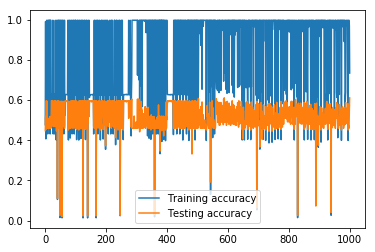

In [50]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

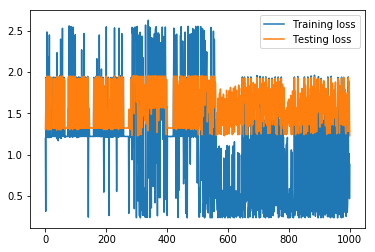

In [51]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()